In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_Stan"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3615.9905 Test MSE 3504.9845209227315 Test RE 0.9996428454249233
1 Train Loss 3613.613 Test MSE 3503.8419793136313 Test RE 0.9994799022463461
2 Train Loss 3611.1775 Test MSE 3502.683121508058 Test RE 0.9993146049984973
3 Train Loss 3608.6763 Test MSE 3501.5084031225038 Test RE 0.999147017517555
4 Train Loss 3606.1067 Test MSE 3500.318907043136 Test RE 0.9989772931766419
5 Train Loss 3603.465 Test MSE 3499.116601150971 Test RE 0.9988057117474686
6 Train Loss 3600.7498 Test MSE 3497.904850430529 Test RE 0.9986327526152773
7 Train Loss 3597.961 Test MSE 3496.688217938052 Test RE 0.99

124 Train Loss 3304.7058 Test MSE 3408.582508465385 Test RE 0.9857997765666073
125 Train Loss 3299.2427 Test MSE 3405.705284184572 Test RE 0.9853836261798261
126 Train Loss 3293.791 Test MSE 3402.559828840807 Test RE 0.9849284787254389
127 Train Loss 3288.3137 Test MSE 3399.2270779759865 Test RE 0.9844460000046996
128 Train Loss 3282.7637 Test MSE 3395.811175440776 Test RE 0.9839512379967732
129 Train Loss 3277.078 Test MSE 3392.3193591355457 Test RE 0.9834452233096735
130 Train Loss 3271.1877 Test MSE 3388.6036993135817 Test RE 0.9829064843709228
131 Train Loss 3265.0205 Test MSE 3384.4284602445623 Test RE 0.9823007578187278
132 Train Loss 3258.5093 Test MSE 3379.6262365691496 Test RE 0.9816036087227776
133 Train Loss 3251.5986 Test MSE 3374.208284710819 Test RE 0.9808164781502449
134 Train Loss 3244.2585 Test MSE 3368.3195246189794 Test RE 0.9799602306003717
135 Train Loss 3236.4875 Test MSE 3362.0695842672417 Test RE 0.979050646951155
136 Train Loss 3228.3147 Test MSE 3355.400334279

229 Train Loss 1703.7356 Test MSE 1896.8837623759605 Test RE 0.7353975341811897
230 Train Loss 1690.8427 Test MSE 1882.9504925190392 Test RE 0.7326916810513523
231 Train Loss 1678.0494 Test MSE 1865.7441205894077 Test RE 0.7293363356683393
232 Train Loss 1663.9152 Test MSE 1851.047927750336 Test RE 0.7264582191560759
233 Train Loss 1650.3159 Test MSE 1834.4527724321383 Test RE 0.7231944383418277
234 Train Loss 1636.8466 Test MSE 1820.7583942507058 Test RE 0.7204900213544814
235 Train Loss 1624.7961 Test MSE 1808.3363554662517 Test RE 0.7180280603179429
236 Train Loss 1614.2906 Test MSE 1796.0399180687134 Test RE 0.715582650306607
237 Train Loss 1604.8998 Test MSE 1788.161942368523 Test RE 0.7140115443299724
238 Train Loss 1596.4136 Test MSE 1776.1845332640933 Test RE 0.7116162419166651
239 Train Loss 1587.8834 Test MSE 1770.5587337565662 Test RE 0.710488378986381
240 Train Loss 1580.0963 Test MSE 1757.5129113897108 Test RE 0.7078660310299886
241 Train Loss 1570.6992 Test MSE 1750.50650

352 Train Loss 1196.7034 Test MSE 1242.9889115872159 Test RE 0.5952993893761308
353 Train Loss 1194.3148 Test MSE 1244.7245701662 Test RE 0.5957148701748661
354 Train Loss 1191.8342 Test MSE 1239.475536910289 Test RE 0.594457471232757
355 Train Loss 1189.577 Test MSE 1236.8968193101834 Test RE 0.593838767577759
356 Train Loss 1187.8038 Test MSE 1237.164544418842 Test RE 0.5939030320111207
357 Train Loss 1186.3706 Test MSE 1230.8425972472955 Test RE 0.592383657541437
358 Train Loss 1184.9178 Test MSE 1233.4070311549222 Test RE 0.5930004457060576
359 Train Loss 1183.2706 Test MSE 1225.9329320198553 Test RE 0.5912010077210986
360 Train Loss 1181.2385 Test MSE 1227.0570991261748 Test RE 0.5914720080420904
361 Train Loss 1179.1011 Test MSE 1221.955372163243 Test RE 0.5902411477502972
362 Train Loss 1177.0029 Test MSE 1220.0072145004776 Test RE 0.5897704507346925
363 Train Loss 1175.1115 Test MSE 1218.6831773781753 Test RE 0.589450333795214
364 Train Loss 1173.4132 Test MSE 1213.845908436641

479 Train Loss 979.5426 Test MSE 962.3407730874236 Test RE 0.5238009155563174
480 Train Loss 977.9531 Test MSE 960.4600266642259 Test RE 0.5232888212331519
481 Train Loss 976.38074 Test MSE 958.7719923135589 Test RE 0.5228287719123508
482 Train Loss 974.71295 Test MSE 956.851308210043 Test RE 0.5223048244356976
483 Train Loss 972.9936 Test MSE 954.8365951135427 Test RE 0.5217546611743187
484 Train Loss 971.32104 Test MSE 953.393703074867 Test RE 0.5213602898882963
485 Train Loss 969.70416 Test MSE 951.1571987507625 Test RE 0.5207484182304831
486 Train Loss 968.0738 Test MSE 949.7618611388143 Test RE 0.5203663118148235
487 Train Loss 966.3856 Test MSE 947.4656547423634 Test RE 0.5197368953395067
488 Train Loss 964.6655 Test MSE 945.9000472525801 Test RE 0.5193073069980281
489 Train Loss 962.9599 Test MSE 943.9074136800499 Test RE 0.5187600320909003
490 Train Loss 961.28253 Test MSE 942.1351285850701 Test RE 0.518272790107137
491 Train Loss 959.6098 Test MSE 940.2755615671005 Test RE 0.5

586 Train Loss 817.59314 Test MSE 794.4445076136446 Test RE 0.4759196026441227
587 Train Loss 815.5547 Test MSE 797.3625323045084 Test RE 0.4767928368639775
588 Train Loss 817.496 Test MSE 793.5602855709254 Test RE 0.4756546780597916
589 Train Loss 815.1697 Test MSE 791.5553195108288 Test RE 0.4750534164802236
590 Train Loss 811.77966 Test MSE 791.3432912410966 Test RE 0.4749897876361919
591 Train Loss 812.494 Test MSE 791.233919603121 Test RE 0.47495696230816264
592 Train Loss 811.8469 Test MSE 787.6913931395392 Test RE 0.4738925266987726
593 Train Loss 808.41486 Test MSE 787.5054063916671 Test RE 0.47383657652973965
594 Train Loss 807.44104 Test MSE 786.6215738483289 Test RE 0.47357060390670236
595 Train Loss 807.5467 Test MSE 785.1428650378276 Test RE 0.47312528022464945
596 Train Loss 805.1998 Test MSE 783.4914020398787 Test RE 0.47262743439819277
597 Train Loss 803.3597 Test MSE 782.5523569422509 Test RE 0.4723441182460792
598 Train Loss 803.3846 Test MSE 782.6446311637961 Test RE

691 Train Loss 704.4891 Test MSE 688.0371690039171 Test RE 0.44290212091603204
692 Train Loss 703.27466 Test MSE 688.4678028733243 Test RE 0.44304070268774076
693 Train Loss 701.9022 Test MSE 685.902024670417 Test RE 0.4422143711916202
694 Train Loss 700.58563 Test MSE 686.0675066748394 Test RE 0.4422677127073417
695 Train Loss 699.3482 Test MSE 684.0323470128798 Test RE 0.4416112511360614
696 Train Loss 698.2476 Test MSE 684.011975188393 Test RE 0.4416046750626325
697 Train Loss 697.25836 Test MSE 682.4560854797351 Test RE 0.44110214048654395
698 Train Loss 696.3384 Test MSE 682.2170477591206 Test RE 0.44102488329229794
699 Train Loss 695.4406 Test MSE 680.9120555153221 Test RE 0.44060286983788394
700 Train Loss 694.52783 Test MSE 680.4778199065712 Test RE 0.44046235538604955
701 Train Loss 693.5893 Test MSE 679.2550715593432 Test RE 0.44006644477760987
702 Train Loss 692.6198 Test MSE 678.731102775582 Test RE 0.43989668118401104
703 Train Loss 691.6374 Test MSE 677.5079827460015 Test

796 Train Loss 622.59064 Test MSE 615.5512765901908 Test RE 0.4189227328823846
797 Train Loss 622.74347 Test MSE 617.1066146487859 Test RE 0.41945165340388957
798 Train Loss 623.84814 Test MSE 616.2695843924058 Test RE 0.4191670892366361
799 Train Loss 624.6318 Test MSE 618.0507109861488 Test RE 0.4197723852007034
800 Train Loss 624.1511 Test MSE 614.4727103817816 Test RE 0.41855555469543215
801 Train Loss 622.5011 Test MSE 614.8213714396048 Test RE 0.41867428521395145
802 Train Loss 620.2768 Test MSE 611.5488667948963 Test RE 0.4175585614866835
803 Train Loss 618.41656 Test MSE 611.6839769520992 Test RE 0.41760468477319157
804 Train Loss 617.45856 Test MSE 611.6119726652204 Test RE 0.41758010491364717
805 Train Loss 617.3552 Test MSE 611.0896220188395 Test RE 0.4174017485049183
806 Train Loss 617.55756 Test MSE 612.5133839079544 Test RE 0.4178877123745551
807 Train Loss 617.42645 Test MSE 610.0027099591524 Test RE 0.41703037834004514
808 Train Loss 616.67786 Test MSE 610.6388222421521

901 Train Loss 576.0647 Test MSE 571.4345851246305 Test RE 0.4036315175575411
902 Train Loss 573.83594 Test MSE 572.0861660604971 Test RE 0.4038615733506
903 Train Loss 573.4044 Test MSE 570.6842630748487 Test RE 0.40336643637739333
904 Train Loss 574.1232 Test MSE 574.3320459049035 Test RE 0.40465353107605967
905 Train Loss 574.85547 Test MSE 571.2621986272524 Test RE 0.40357063056032516
906 Train Loss 574.8624 Test MSE 572.808737538757 Test RE 0.4041165408575242
907 Train Loss 574.06305 Test MSE 570.352302356861 Test RE 0.4032491024166878
908 Train Loss 573.0056 Test MSE 569.8551424598 Test RE 0.40307331370811816
909 Train Loss 572.1892 Test MSE 570.3426438303885 Test RE 0.4032456880282444
910 Train Loss 571.6203 Test MSE 568.440423320689 Test RE 0.4025726690313192
911 Train Loss 571.20795 Test MSE 570.0689333996912 Test RE 0.4031489165546299
912 Train Loss 570.7855 Test MSE 567.8716992082966 Test RE 0.4023712318446765
913 Train Loss 570.399 Test MSE 568.8250594539452 Test RE 0.40270

1030 Train Loss 546.48456 Test MSE 550.614448674931 Test RE 0.3962101633687583
1031 Train Loss 547.78687 Test MSE 551.3244094834989 Test RE 0.3964655172485938
1032 Train Loss 549.7746 Test MSE 553.8036357221044 Test RE 0.3973559414278848
1033 Train Loss 551.5894 Test MSE 554.3203802251782 Test RE 0.3975412811492042
1034 Train Loss 553.608 Test MSE 555.7904522694596 Test RE 0.39806807701234553
1035 Train Loss 553.70605 Test MSE 553.2836379916599 Test RE 0.3971693475704462
1036 Train Loss 552.4406 Test MSE 552.0738694998715 Test RE 0.3967348996091127
1037 Train Loss 548.6237 Test MSE 547.0498692947526 Test RE 0.39492558412115714
1038 Train Loss 544.80927 Test MSE 547.0144026809031 Test RE 0.394912781906033
1039 Train Loss 542.3806 Test MSE 544.9433385398389 Test RE 0.3941644786398641
1040 Train Loss 542.154 Test MSE 547.1265505159599 Test RE 0.39495326195879876
1041 Train Loss 543.1732 Test MSE 546.8924007169411 Test RE 0.3948687402670166
1042 Train Loss 543.91125 Test MSE 546.8951874538

1160 Train Loss 537.8334 Test MSE 538.0715642312392 Test RE 0.39167137307173727
1161 Train Loss 532.48486 Test MSE 534.8518434258968 Test RE 0.3904977702238128
1162 Train Loss 527.2868 Test MSE 532.9800644434179 Test RE 0.38981387416914026
1163 Train Loss 525.2187 Test MSE 533.1017824781106 Test RE 0.3898583830290528
1164 Train Loss 526.38617 Test MSE 537.5114517975421 Test RE 0.39146746234507573
1165 Train Loss 528.9581 Test MSE 536.7253864718175 Test RE 0.3911811134841338
1166 Train Loss 530.72363 Test MSE 538.2812659112217 Test RE 0.39174768833299045
1167 Train Loss 530.15845 Test MSE 534.8087552581359 Test RE 0.3904820404731067
1168 Train Loss 528.14813 Test MSE 533.4019202468572 Test RE 0.38996811325719966
1169 Train Loss 525.94604 Test MSE 533.1376374743194 Test RE 0.38987149322327447
1170 Train Loss 525.0466 Test MSE 532.2941164970882 Test RE 0.38956294722702745
1171 Train Loss 525.4058 Test MSE 534.7269587519555 Test RE 0.39045217812728
1172 Train Loss 526.1519 Test MSE 533.174

1267 Train Loss 515.6629 Test MSE 524.1263634912991 Test RE 0.3865625811444873
1268 Train Loss 516.07166 Test MSE 522.3426412406072 Test RE 0.38590423997464574
1269 Train Loss 515.78955 Test MSE 523.0174158246621 Test RE 0.3861534196409623
1270 Train Loss 514.7979 Test MSE 520.9712553998119 Test RE 0.38539732038929153
1271 Train Loss 513.8524 Test MSE 521.0215101515643 Test RE 0.3854159083434312
1272 Train Loss 513.6547 Test MSE 521.8910677194038 Test RE 0.3857373937299115
1273 Train Loss 514.14197 Test MSE 521.264705129343 Test RE 0.3855058473155868
1274 Train Loss 514.57446 Test MSE 522.359459851279 Test RE 0.3859104526791162
1275 Train Loss 514.35254 Test MSE 520.4358688476242 Test RE 0.38519923884527757
1276 Train Loss 513.54785 Test MSE 520.4645517752223 Test RE 0.38520985349571996
1277 Train Loss 512.78064 Test MSE 519.9949382244112 Test RE 0.3850360274481676
1278 Train Loss 512.5575 Test MSE 519.8653564294495 Test RE 0.3849880493193116
1279 Train Loss 512.8308 Test MSE 520.92388

1372 Train Loss 503.18713 Test MSE 510.66152352667297 Test RE 0.38156486561826053
1373 Train Loss 503.0751 Test MSE 507.0333752778282 Test RE 0.3802069783149472
1374 Train Loss 500.93158 Test MSE 506.0313552601471 Test RE 0.37983110225577765
1375 Train Loss 498.9683 Test MSE 506.0326609329394 Test RE 0.3798315922795784
1376 Train Loss 498.98096 Test MSE 506.3353675908602 Test RE 0.37994518214354683
1377 Train Loss 500.2849 Test MSE 508.29420209894903 Test RE 0.3806794102461484
1378 Train Loss 500.90933 Test MSE 506.0594008817007 Test RE 0.37984162774164193
1379 Train Loss 500.0273 Test MSE 505.58118042222105 Test RE 0.37966211228203406
1380 Train Loss 498.60138 Test MSE 504.81734115488007 Test RE 0.3793752044044402
1381 Train Loss 497.99844 Test MSE 504.6650046433372 Test RE 0.37931795889095166
1382 Train Loss 498.35022 Test MSE 505.93641171105406 Test RE 0.3797954678981092
1383 Train Loss 498.72528 Test MSE 504.576805819383 Test RE 0.37928481129856434
1384 Train Loss 498.44583 Test MS

1478 Train Loss 483.81116 Test MSE 486.83736083474327 Test RE 0.3725578851098922
1479 Train Loss 482.22064 Test MSE 485.0727890353704 Test RE 0.3718820927673675
1480 Train Loss 480.1768 Test MSE 484.6436788548336 Test RE 0.3717175672537018
1481 Train Loss 479.44595 Test MSE 484.77961659438176 Test RE 0.37176969514190306
1482 Train Loss 480.12637 Test MSE 485.4936883593955 Test RE 0.3720433994675374
1483 Train Loss 480.78793 Test MSE 484.907595493668 Test RE 0.37181876438392264
1484 Train Loss 480.35522 Test MSE 483.9306389421565 Test RE 0.3714440188359349
1485 Train Loss 479.30823 Test MSE 483.8837033755552 Test RE 0.3714260055538406
1486 Train Loss 478.7421 Test MSE 483.3149835766293 Test RE 0.371207668558546
1487 Train Loss 479.0036 Test MSE 484.55274327640166 Test RE 0.3716826922112409
1488 Train Loss 479.39273 Test MSE 483.2821285164078 Test RE 0.37119505126134417
1489 Train Loss 479.167 Test MSE 483.52955237015976 Test RE 0.37129005866241854
1490 Train Loss 478.3795 Test MSE 482.1

1603 Train Loss 455.47882 Test MSE 460.0147206674502 Test RE 0.36214932046044956
1604 Train Loss 455.80344 Test MSE 462.02336210287064 Test RE 0.36293911669252327
1605 Train Loss 456.4388 Test MSE 461.3718722596356 Test RE 0.3626831398521617
1606 Train Loss 457.59897 Test MSE 465.36592015785 Test RE 0.36424961190897276
1607 Train Loss 459.49408 Test MSE 465.505053258436 Test RE 0.36430405873060556
1608 Train Loss 462.54346 Test MSE 472.81329900197335 Test RE 0.36715263690422284
1609 Train Loss 466.73187 Test MSE 473.8338184975806 Test RE 0.3675486541713601
1610 Train Loss 472.14224 Test MSE 482.5183090390512 Test RE 0.3709016014222298
1611 Train Loss 476.60297 Test MSE 479.19824274520926 Test RE 0.3696233665272257
1612 Train Loss 478.49387 Test MSE 479.31295501238714 Test RE 0.36966760479169575
1613 Train Loss 474.00854 Test MSE 467.6943171783418 Test RE 0.3651597123898823
1614 Train Loss 465.70724 Test MSE 462.0494310709652 Test RE 0.362949355692941
1615 Train Loss 457.32886 Test MSE 

1705 Train Loss 439.9649 Test MSE 446.41149452851715 Test RE 0.3567545281607851
1706 Train Loss 441.45206 Test MSE 450.92204550878586 Test RE 0.3585523258962376
1707 Train Loss 443.88245 Test MSE 451.7120420458192 Test RE 0.35886627277953465
1708 Train Loss 447.82074 Test MSE 460.3571900654306 Test RE 0.362284100913541
1709 Train Loss 453.3304 Test MSE 462.66842224084564 Test RE 0.3631923894881081
1710 Train Loss 460.54523 Test MSE 473.17820942151235 Test RE 0.3672942911073595
1711 Train Loss 466.60776 Test MSE 469.82150286441487 Test RE 0.36598918717955226
1712 Train Loss 469.01544 Test MSE 468.84952629043033 Test RE 0.36561040812027834
1713 Train Loss 462.6726 Test MSE 453.8774923106611 Test RE 0.3597254240536754
1714 Train Loss 450.97293 Test MSE 446.5446909522893 Test RE 0.356807746865827
1715 Train Loss 440.34662 Test MSE 444.0569107858398 Test RE 0.35581243885204733
1716 Train Loss 437.3391 Test MSE 446.5076629582137 Test RE 0.35679295310687964
1717 Train Loss 441.4088 Test MSE 4

1829 Train Loss 448.97867 Test MSE 438.38876628497695 Test RE 0.3535342696562288
1830 Train Loss 434.03616 Test MSE 431.7957703812621 Test RE 0.3508657706000531
1831 Train Loss 424.36096 Test MSE 433.59050185329096 Test RE 0.3515941900326618
1832 Train Loss 424.96268 Test MSE 437.5748300558275 Test RE 0.35320592178139987
1833 Train Loss 431.43106 Test MSE 444.4052528440356 Test RE 0.35595197067402173
1834 Train Loss 434.79855 Test MSE 436.90045334832257 Test RE 0.3529336418474794
1835 Train Loss 431.37054 Test MSE 433.3914570840987 Test RE 0.35151347906508373
1836 Train Loss 425.176 Test MSE 430.3627460196237 Test RE 0.35028306797538256
1837 Train Loss 422.94223 Test MSE 432.4552251992996 Test RE 0.3511335961127736
1838 Train Loss 425.6031 Test MSE 436.8643095163467 Test RE 0.35291904282613534
1839 Train Loss 427.59976 Test MSE 432.26249071988343 Test RE 0.35105534166131336
1840 Train Loss 425.52252 Test MSE 430.19241311248544 Test RE 0.3502137419955275
1841 Train Loss 421.40802 Test M

1931 Train Loss 406.89835 Test MSE 415.6160343359307 Test RE 0.344229397682142
1932 Train Loss 406.76498 Test MSE 415.69418918061024 Test RE 0.34426176160490757
1933 Train Loss 406.63678 Test MSE 415.33592288514416 Test RE 0.3441133785203346
1934 Train Loss 406.5179 Test MSE 415.53124881515214 Test RE 0.34419428455493234
1935 Train Loss 406.41388 Test MSE 415.08127610176626 Test RE 0.34400787259662297
1936 Train Loss 406.3344 Test MSE 415.4896078282993 Test RE 0.34417703801955235
1937 Train Loss 406.29703 Test MSE 414.92239742501846 Test RE 0.34394202917053407
1938 Train Loss 406.32916 Test MSE 415.7588908090092 Test RE 0.34428855224870974
1939 Train Loss 406.4817 Test MSE 415.0938477903276 Test RE 0.34401308209093184
1940 Train Loss 406.83453 Test MSE 416.8566634406612 Test RE 0.3447427835368693
1941 Train Loss 407.53406 Test MSE 416.3091596742837 Test RE 0.34451631481802025
1942 Train Loss 408.79956 Test MSE 420.1431221039651 Test RE 0.3460990753797009
1943 Train Loss 410.99408 Test 

2042 Train Loss 391.14395 Test MSE 400.75246264945054 Test RE 0.33801806382058264
2043 Train Loss 390.99426 Test MSE 400.86801334445215 Test RE 0.3380667914152785
2044 Train Loss 390.8471 Test MSE 400.44411193812334 Test RE 0.33788799828525146
2045 Train Loss 390.70438 Test MSE 400.65467029360434 Test RE 0.33797681940828594
2046 Train Loss 390.5688 Test MSE 400.1393857640366 Test RE 0.3377594124109853
2047 Train Loss 390.44434 Test MSE 400.5159810217463 Test RE 0.3379183178861745
2048 Train Loss 390.33835 Test MSE 399.86761997585194 Test RE 0.3376446935815333
2049 Train Loss 390.26096 Test MSE 400.54605275057736 Test RE 0.3379310035189184
2050 Train Loss 390.23068 Test MSE 399.7264722785704 Test RE 0.33758509638612166
2051 Train Loss 390.27808 Test MSE 400.9758946830992 Test RE 0.33811227851247333
2052 Train Loss 390.44925 Test MSE 399.9943647049601 Test RE 0.3376982004079174
2053 Train Loss 390.83224 Test MSE 402.40022247673886 Test RE 0.3387122594789428
2054 Train Loss 391.55035 Test

2148 Train Loss 374.45596 Test MSE 384.85012018652566 Test RE 0.33124369698922507
2149 Train Loss 374.28424 Test MSE 384.6199988224588 Test RE 0.3311446484951721
2150 Train Loss 374.11313 Test MSE 384.52698349287033 Test RE 0.3311046045671681
2151 Train Loss 373.94247 Test MSE 384.27055998943086 Test RE 0.33099418687795557
2152 Train Loss 373.7708 Test MSE 384.2025335964807 Test RE 0.33096488807191177
2153 Train Loss 373.59857 Test MSE 383.9192885854924 Test RE 0.3308428672245149
2154 Train Loss 373.42618 Test MSE 383.8817144388638 Test RE 0.33082667704737717
2155 Train Loss 373.2544 Test MSE 383.56224280381304 Test RE 0.33068898914283984
2156 Train Loss 373.08548 Test MSE 383.58268416228253 Test RE 0.33069780080540034
2157 Train Loss 372.92014 Test MSE 383.20059463939174 Test RE 0.3305330545174339
2158 Train Loss 372.76053 Test MSE 383.3344347171622 Test RE 0.33059077194823344
2159 Train Loss 372.61084 Test MSE 382.841208789111 Test RE 0.3303780224412735
2160 Train Loss 372.47748 Test

2256 Train Loss 356.73895 Test MSE 367.3588358136921 Test RE 0.3236287195295031
2257 Train Loss 356.55392 Test MSE 367.2634754575301 Test RE 0.3235867124372742
2258 Train Loss 356.37122 Test MSE 367.0478101459168 Test RE 0.32349168981471266
2259 Train Loss 356.19144 Test MSE 366.8586619144265 Test RE 0.32340832769640915
2260 Train Loss 356.0126 Test MSE 366.7334103979864 Test RE 0.32335311455066756
2261 Train Loss 355.8327 Test MSE 366.47034322714745 Test RE 0.32323711905277264
2262 Train Loss 355.6521 Test MSE 366.3888892019925 Test RE 0.32320119468933334
2263 Train Loss 355.47162 Test MSE 366.10747392439015 Test RE 0.3230770489684712
2264 Train Loss 355.29062 Test MSE 366.01823461264684 Test RE 0.3230376712820411
2265 Train Loss 355.1074 Test MSE 365.76016443687746 Test RE 0.3229237683657552
2266 Train Loss 354.92218 Test MSE 365.6278707564868 Test RE 0.3228653631023752
2267 Train Loss 354.73666 Test MSE 365.41748523550257 Test RE 0.32277245993879805
2268 Train Loss 354.5521 Test MSE

2364 Train Loss 336.96356 Test MSE 348.20624857274 Test RE 0.3150794582059334
2365 Train Loss 336.87585 Test MSE 347.5198221980395 Test RE 0.31476874358623774
2366 Train Loss 336.91367 Test MSE 348.2166634702474 Test RE 0.31508417020599083
2367 Train Loss 336.73438 Test MSE 347.0722947477523 Test RE 0.3145660025842244
2368 Train Loss 336.3438 Test MSE 347.14985073038895 Test RE 0.3146011467214268
2369 Train Loss 336.01428 Test MSE 347.0580505832471 Test RE 0.3145595474797251
2370 Train Loss 335.87762 Test MSE 346.572402613268 Test RE 0.3143393844767529
2371 Train Loss 335.8009 Test MSE 347.03812728983957 Test RE 0.314550518511671
2372 Train Loss 335.62277 Test MSE 346.1246684080638 Test RE 0.31413627254662524
2373 Train Loss 335.3567 Test MSE 346.3326163221961 Test RE 0.3142306231954715
2374 Train Loss 335.1042 Test MSE 345.9548299308849 Test RE 0.3140591919778988
2375 Train Loss 334.9055 Test MSE 345.66559373427106 Test RE 0.3139278796323969
2376 Train Loss 334.72653 Test MSE 345.8362

2469 Train Loss 376.00293 Test MSE 355.93501315075343 Test RE 0.3185570094168878
2470 Train Loss 344.18048 Test MSE 331.3151813380401 Test RE 0.30734239981063927
2471 Train Loss 321.5005 Test MSE 340.04674838254834 Test RE 0.31136595379816107
2472 Train Loss 333.3545 Test MSE 362.52779401237484 Test RE 0.3214936978881866
2473 Train Loss 347.0536 Test MSE 341.5928435430741 Test RE 0.3120729969304648
2474 Train Loss 337.24884 Test MSE 332.10730459268075 Test RE 0.30770958449577895
2475 Train Loss 322.3627 Test MSE 339.7291519982278 Test RE 0.3112205152630642
2476 Train Loss 325.8959 Test MSE 338.4388750534039 Test RE 0.3106289518711796
2477 Train Loss 331.95584 Test MSE 339.05769443652116 Test RE 0.31091280730716137
2478 Train Loss 326.6371 Test MSE 330.8799638268697 Test RE 0.3071404701105074
2479 Train Loss 321.70023 Test MSE 330.9961090462048 Test RE 0.30719437148147055
2480 Train Loss 322.47098 Test MSE 337.31943108627746 Test RE 0.3101147973904547
2481 Train Loss 323.0246 Test MSE 3

2575 Train Loss 286.4361 Test MSE 298.7495187866902 Test RE 0.29184712342951463
2576 Train Loss 286.1064 Test MSE 298.3772877860069 Test RE 0.2916652513264066
2577 Train Loss 285.77582 Test MSE 298.083857248934 Test RE 0.291521801160538
2578 Train Loss 285.44324 Test MSE 297.7502272381882 Test RE 0.2913586127671009
2579 Train Loss 285.11005 Test MSE 297.4109424481891 Test RE 0.2911925646611233
2580 Train Loss 284.7758 Test MSE 297.1222925426156 Test RE 0.29105122300489344
2581 Train Loss 284.441 Test MSE 296.7529882484122 Test RE 0.29087028759599404
2582 Train Loss 284.10434 Test MSE 296.4734181383724 Test RE 0.2907332412930576
2583 Train Loss 283.7663 Test MSE 296.11606886926177 Test RE 0.29055797324148636
2584 Train Loss 283.4269 Test MSE 295.80867647777427 Test RE 0.29040712276287767
2585 Train Loss 283.08676 Test MSE 295.4845513140189 Test RE 0.29024797588428464
2586 Train Loss 282.7457 Test MSE 295.1469559782664 Test RE 0.2900821222615827
2587 Train Loss 282.40353 Test MSE 294.842

2677 Train Loss 253.0723 Test MSE 264.19530486939556 Test RE 0.274450709298527
2678 Train Loss 250.89098 Test MSE 268.4951194401657 Test RE 0.2766750567737649
2679 Train Loss 252.4748 Test MSE 265.68971414856475 Test RE 0.2752258240081711
2680 Train Loss 253.24068 Test MSE 264.5278979553796 Test RE 0.27462340672486674
2681 Train Loss 250.19469 Test MSE 264.3437702124111 Test RE 0.2745278126670593
2682 Train Loss 248.55016 Test MSE 263.1204953819028 Test RE 0.273891874892525
2683 Train Loss 250.10735 Test MSE 265.2246755968261 Test RE 0.2749848536834587
2684 Train Loss 250.1962 Test MSE 262.2023500643604 Test RE 0.2734135915479237
2685 Train Loss 247.74786 Test MSE 260.78383192367795 Test RE 0.27267300298925207
2686 Train Loss 246.65118 Test MSE 263.2989382580352 Test RE 0.2739847330530034
2687 Train Loss 247.88814 Test MSE 261.3782891663302 Test RE 0.2729836054007055
2688 Train Loss 247.83017 Test MSE 260.65159536349796 Test RE 0.2726038616015507
2689 Train Loss 245.71208 Test MSE 260.

2801 Train Loss 196.86946 Test MSE 214.91735213841056 Test RE 0.24753553360074118
2802 Train Loss 196.39058 Test MSE 214.46725713879863 Test RE 0.24727619460607062
2803 Train Loss 195.91118 Test MSE 214.02647642618695 Test RE 0.2470219585079165
2804 Train Loss 195.4312 Test MSE 213.57876645248552 Test RE 0.24676345756585166
2805 Train Loss 194.95023 Test MSE 213.13303040359432 Test RE 0.24650582704853202
2806 Train Loss 194.46864 Test MSE 212.68708046701894 Test RE 0.24624780317320583
2807 Train Loss 193.9864 Test MSE 212.23710916041088 Test RE 0.24598717823675462
2808 Train Loss 193.50339 Test MSE 211.79257929168566 Test RE 0.24572943357062998
2809 Train Loss 193.01945 Test MSE 211.3386021021398 Test RE 0.24546593188899204
2810 Train Loss 192.53505 Test MSE 210.8952196907045 Test RE 0.24520830640312577
2811 Train Loss 192.04938 Test MSE 210.43735789717925 Test RE 0.2449419833498461
2812 Train Loss 191.56302 Test MSE 209.9955912592141 Test RE 0.2446847475469643
2813 Train Loss 191.0764

2926 Train Loss 147.1593 Test MSE 168.1725065804704 Test RE 0.21896732280698694
2927 Train Loss 146.83786 Test MSE 168.05668644318527 Test RE 0.21889190859720176
2928 Train Loss 146.50157 Test MSE 167.57021879658552 Test RE 0.2185748697326627
2929 Train Loss 146.15288 Test MSE 167.26006789300178 Test RE 0.21837249907548015
2930 Train Loss 145.81639 Test MSE 167.0618782883439 Test RE 0.2182430838839784
2931 Train Loss 145.4918 Test MSE 166.57695752010306 Test RE 0.21792611296959263
2932 Train Loss 145.15915 Test MSE 166.37480571589614 Test RE 0.2177938391805647
2933 Train Loss 144.8172 Test MSE 165.9980051275842 Test RE 0.21754707296027756
2934 Train Loss 144.48227 Test MSE 165.62195839402645 Test RE 0.21730052105164827
2935 Train Loss 144.1561 Test MSE 165.42366103657895 Test RE 0.21717039632340143
2936 Train Loss 143.82661 Test MSE 164.9879162459523 Test RE 0.21688418192209122
2937 Train Loss 143.49055 Test MSE 164.718517156128 Test RE 0.21670704085289447
2938 Train Loss 143.15685 Tes

3050 Train Loss 128.49889 Test MSE 159.7930276369416 Test RE 0.21344241329080646
3051 Train Loss 133.97862 Test MSE 211.0226996508236 Test RE 0.2452824058132158
3052 Train Loss 204.78058 Test MSE 195.32614264336158 Test RE 0.23598369483052103
3053 Train Loss 169.18669 Test MSE 132.4792451345602 Test RE 0.19434605630113003
3054 Train Loss 111.45918 Test MSE 159.18945579258104 Test RE 0.21303892348994855
3055 Train Loss 145.84381 Test MSE 197.21233631748183 Test RE 0.23712036177867982
3056 Train Loss 169.87343 Test MSE 142.0951469641101 Test RE 0.2012757402847233
3057 Train Loss 125.628105 Test MSE 134.78370663926333 Test RE 0.1960290826904866
3058 Train Loss 115.92136 Test MSE 177.07520695397437 Test RE 0.2246884192652287
3059 Train Loss 149.52051 Test MSE 151.08777196864924 Test RE 0.2075470038619538
3060 Train Loss 137.0081 Test MSE 131.01938375581787 Test RE 0.19327228716219705
3061 Train Loss 109.57021 Test MSE 154.38491325927234 Test RE 0.20979939859770086
3062 Train Loss 128.34396

3152 Train Loss 91.62984 Test MSE 112.32416398820548 Test RE 0.17895276263001894
3153 Train Loss 91.45366 Test MSE 112.07373706279449 Test RE 0.17875316356342813
3154 Train Loss 91.27982 Test MSE 111.98330495001743 Test RE 0.17868103119383896
3155 Train Loss 91.10458 Test MSE 111.72300295577068 Test RE 0.17847324089588706
3156 Train Loss 90.92762 Test MSE 111.55626863059271 Test RE 0.17834001530499713
3157 Train Loss 90.751724 Test MSE 111.41046500364769 Test RE 0.1782234323318068
3158 Train Loss 90.57752 Test MSE 111.15350020516401 Test RE 0.17801778025819814
3159 Train Loss 90.40356 Test MSE 111.03521742651506 Test RE 0.17792303721193412
3160 Train Loss 90.22809 Test MSE 110.81991521623655 Test RE 0.17775045317987512
3161 Train Loss 90.05293 Test MSE 110.62111560905404 Test RE 0.17759094853647803
3162 Train Loss 89.87931 Test MSE 110.48565471022611 Test RE 0.1774821808815924
3163 Train Loss 89.70616 Test MSE 110.24350554244482 Test RE 0.17728758215113607
3164 Train Loss 89.53254 Test

3272 Train Loss 72.73508 Test MSE 91.90280357311663 Test RE 0.16186993410556072
3273 Train Loss 72.598114 Test MSE 91.74951571519306 Test RE 0.16173488354332766
3274 Train Loss 72.4615 Test MSE 91.59406259858052 Test RE 0.16159781006516183
3275 Train Loss 72.324974 Test MSE 91.44054514478117 Test RE 0.16146232918715783
3276 Train Loss 72.18883 Test MSE 91.28546509617739 Test RE 0.1613253537819824
3277 Train Loss 72.053116 Test MSE 91.13289338067514 Test RE 0.16119048028817104
3278 Train Loss 71.91747 Test MSE 90.97864456266045 Test RE 0.16105400941673428
3279 Train Loss 71.78232 Test MSE 90.82556218555521 Test RE 0.16091845612012834
3280 Train Loss 71.64742 Test MSE 90.67186881009451 Test RE 0.16078224682086834
3281 Train Loss 71.5128 Test MSE 90.52024906124416 Test RE 0.160647762091819
3282 Train Loss 71.3784 Test MSE 90.36679772568006 Test RE 0.1605115380412961
3283 Train Loss 71.2444 Test MSE 90.21499912350224 Test RE 0.160376667333157
3284 Train Loss 71.11077 Test MSE 90.0621570357

3398 Train Loss 59.746845 Test MSE 76.94170929022054 Test RE 0.14810943489736522
3399 Train Loss 59.699085 Test MSE 77.27996305137424 Test RE 0.14843463973953855
3400 Train Loss 59.618427 Test MSE 76.79744812541254 Test RE 0.1479705215277644
3401 Train Loss 59.488125 Test MSE 76.77812483769445 Test RE 0.14795190465368854
3402 Train Loss 59.378857 Test MSE 76.8683479354833 Test RE 0.14803880935431277
3403 Train Loss 59.31342 Test MSE 76.44952798037104 Test RE 0.14763496112213564
3404 Train Loss 59.238388 Test MSE 76.64079814627101 Test RE 0.14781953075877188
3405 Train Loss 59.12676 Test MSE 76.36969941916219 Test RE 0.14755786081132174
3406 Train Loss 59.017952 Test MSE 76.2059795557482 Test RE 0.14739961012851233
3407 Train Loss 58.939117 Test MSE 76.35114135009982 Test RE 0.14753993121770095
3408 Train Loss 58.86456 Test MSE 75.96619604109175 Test RE 0.14716752963271396
3409 Train Loss 58.76758 Test MSE 76.04188621978328 Test RE 0.14724082778315079
3410 Train Loss 58.66258 Test MSE 7

3523 Train Loss 49.83772 Test MSE 65.85693951544255 Test RE 0.1370258743938546
3524 Train Loss 49.768894 Test MSE 65.77693823438268 Test RE 0.13694262138546878
3525 Train Loss 49.700222 Test MSE 65.6988579967917 Test RE 0.13686131866971926
3526 Train Loss 49.631695 Test MSE 65.61876487332181 Test RE 0.1367778697811922
3527 Train Loss 49.56329 Test MSE 65.54129049240612 Test RE 0.1366971008846051
3528 Train Loss 49.495026 Test MSE 65.4610588771876 Test RE 0.13661340717346382
3529 Train Loss 49.426914 Test MSE 65.38438768421128 Test RE 0.13653337958233905
3530 Train Loss 49.358837 Test MSE 65.30412872973453 Test RE 0.13644955688797367
3531 Train Loss 49.291042 Test MSE 65.2276143711862 Test RE 0.13636959708714919
3532 Train Loss 49.22331 Test MSE 65.14748158922067 Test RE 0.13628580563203913
3533 Train Loss 49.1556 Test MSE 65.07182432183419 Test RE 0.1362066467242095
3534 Train Loss 49.08815 Test MSE 64.99154415188164 Test RE 0.13612260061423148
3535 Train Loss 49.02084 Test MSE 64.9161

3647 Train Loss 43.174572 Test MSE 58.00009579414095 Test RE 0.1285926556458184
3648 Train Loss 43.016304 Test MSE 57.55239890367722 Test RE 0.12809539734470224
3649 Train Loss 43.148327 Test MSE 58.662350993114075 Test RE 0.12932471854497976
3650 Train Loss 43.23872 Test MSE 57.458222247732685 Test RE 0.1279905491060246
3651 Train Loss 43.08184 Test MSE 57.88415876965412 Test RE 0.12846406872381888
3652 Train Loss 42.849007 Test MSE 57.753751757681485 Test RE 0.1283192790108421
3653 Train Loss 42.783554 Test MSE 57.27827056712536 Test RE 0.12778996705524792
3654 Train Loss 42.85875 Test MSE 58.13533748051496 Test RE 0.12874249127328466
3655 Train Loss 42.867325 Test MSE 57.20288347955419 Test RE 0.12770584365823645
3656 Train Loss 42.73266 Test MSE 57.48329671347566 Test RE 0.1280184732608279
3657 Train Loss 42.582005 Test MSE 57.47625572822177 Test RE 0.128010632689414
3658 Train Loss 42.540634 Test MSE 57.03465304380978 Test RE 0.12751791756516634
3659 Train Loss 42.56811 Test MSE 5

3767 Train Loss 37.639416 Test MSE 51.378038766245574 Test RE 0.12102931378307412
3768 Train Loss 37.597836 Test MSE 51.32648181905302 Test RE 0.12096857316039868
3769 Train Loss 37.556396 Test MSE 51.2772895565907 Test RE 0.12091058998978961
3770 Train Loss 37.51503 Test MSE 51.223279635305055 Test RE 0.12084689617907488
3771 Train Loss 37.47359 Test MSE 51.17665136531899 Test RE 0.12079188052333593
3772 Train Loss 37.432278 Test MSE 51.120792949015836 Test RE 0.12072594141733668
3773 Train Loss 37.391 Test MSE 51.07495633899216 Test RE 0.12067180582444519
3774 Train Loss 37.34981 Test MSE 51.019197707920604 Test RE 0.12060591901254213
3775 Train Loss 37.308628 Test MSE 50.97351632178835 Test RE 0.12055191307347277
3776 Train Loss 37.267357 Test MSE 50.91839625706889 Test RE 0.12048671621200523
3777 Train Loss 37.22642 Test MSE 50.871445244032536 Test RE 0.12043115399430465
3778 Train Loss 37.185497 Test MSE 50.81743747008074 Test RE 0.12036720902742118
3779 Train Loss 37.14434 Test M

3890 Train Loss 33.52754 Test MSE 46.113308189929086 Test RE 0.11466079530408356
3891 Train Loss 33.430237 Test MSE 46.512693728116886 Test RE 0.11515626112081247
3892 Train Loss 33.484768 Test MSE 45.80284547403075 Test RE 0.1142741604851404
3893 Train Loss 33.534225 Test MSE 46.51336578446881 Test RE 0.11515709305733338
3894 Train Loss 33.461746 Test MSE 45.827308292690475 Test RE 0.11430467272601347
3895 Train Loss 33.32969 Test MSE 45.89940319557444 Test RE 0.11439454867618933
3896 Train Loss 33.265686 Test MSE 46.22651955422561 Test RE 0.11480145911770757
3897 Train Loss 33.286835 Test MSE 45.63319776383889 Test RE 0.11406233593687469
3898 Train Loss 33.300346 Test MSE 46.1842273986482 Test RE 0.11474893177823092
3899 Train Loss 33.242775 Test MSE 45.66806248482183 Test RE 0.11410590062685434
3900 Train Loss 33.152195 Test MSE 45.71483823011047 Test RE 0.11416432244552757
3901 Train Loss 33.1007 Test MSE 45.93952461987363 Test RE 0.11444453483468574
3902 Train Loss 33.09777 Test M

3992 Train Loss 30.356739 Test MSE 42.21180846998551 Test RE 0.10970307202424409
3993 Train Loss 30.330242 Test MSE 42.18330380475852 Test RE 0.10966602578599628
3994 Train Loss 30.303595 Test MSE 42.144094303758216 Test RE 0.1096150464952763
3995 Train Loss 30.277145 Test MSE 42.11236411217429 Test RE 0.10957377426728813
3996 Train Loss 30.250874 Test MSE 42.077422884416045 Test RE 0.10952830737433278
3997 Train Loss 30.22475 Test MSE 42.042156835795545 Test RE 0.10948239866572602
3998 Train Loss 30.198494 Test MSE 42.010270065276565 Test RE 0.10944087246228212
3999 Train Loss 30.172266 Test MSE 41.97263387702695 Test RE 0.10939183849744079
4000 Train Loss 30.14629 Test MSE 41.94277924158595 Test RE 0.10935292701984033
4001 Train Loss 30.120361 Test MSE 41.90402191355513 Test RE 0.10930239142254573
4002 Train Loss 30.09446 Test MSE 41.87435051219313 Test RE 0.10926368714925296
4003 Train Loss 30.068548 Test MSE 41.83743569075731 Test RE 0.10921551519223359
4004 Train Loss 30.04288 Tes

4116 Train Loss 28.066816 Test MSE 38.63527975283372 Test RE 0.10495275433308637
4117 Train Loss 27.9263 Test MSE 39.2102463687716 Test RE 0.10573081878476595
4118 Train Loss 27.874506 Test MSE 38.42112858575897 Test RE 0.10466147927622708
4119 Train Loss 27.893595 Test MSE 39.175802650322616 Test RE 0.1056843696674197
4120 Train Loss 27.87418 Test MSE 38.57601298051954 Test RE 0.1048722243313997
4121 Train Loss 27.783022 Test MSE 38.606358988767425 Test RE 0.10491346534507162
4122 Train Loss 27.699207 Test MSE 38.91544785404761 Test RE 0.1053326053285844
4123 Train Loss 27.695642 Test MSE 38.31611626316961 Test RE 0.1045183514496367
4124 Train Loss 27.746605 Test MSE 39.107669727727995 Test RE 0.10559242875038231
4125 Train Loss 27.758266 Test MSE 38.30189353849168 Test RE 0.10449895134002925
4126 Train Loss 27.685577 Test MSE 38.71185545186087 Test RE 0.10505671180720653
4127 Train Loss 27.578314 Test MSE 38.47726697329752 Test RE 0.10473791354865586
4128 Train Loss 27.51832 Test MSE

4218 Train Loss 25.959589 Test MSE 36.1901360633414 Test RE 0.10157735918627311
4219 Train Loss 25.946798 Test MSE 36.3291111305076 Test RE 0.10177220777314497
4220 Train Loss 25.935946 Test MSE 36.120046483718134 Test RE 0.10147894887866725
4221 Train Loss 25.928389 Test MSE 36.347663015030065 Test RE 0.10179819003927008
4222 Train Loss 25.92526 Test MSE 36.04639955607503 Test RE 0.10137544089625036
4223 Train Loss 25.929977 Test MSE 36.42343321232015 Test RE 0.10190423885679066
4224 Train Loss 25.946712 Test MSE 35.98311372343541 Test RE 0.10128641053977792
4225 Train Loss 25.983686 Test MSE 36.62114998856903 Test RE 0.10218044715549304
4226 Train Loss 26.052425 Test MSE 35.98470079079767 Test RE 0.10128864417893985
4227 Train Loss 26.17603 Test MSE 37.10146674652812 Test RE 0.10284835490841862
4228 Train Loss 26.385263 Test MSE 36.22510127151735 Test RE 0.1016264169744625
4229 Train Loss 26.747812 Test MSE 38.27908887617076 Test RE 0.10446783775923488
4230 Train Loss 27.345125 Test 

4339 Train Loss 24.339846 Test MSE 33.8564729917473 Test RE 0.0982477620566002
4340 Train Loss 24.327497 Test MSE 33.914521022658406 Test RE 0.09833195048772139
4341 Train Loss 24.31493 Test MSE 33.82860239360756 Test RE 0.09820731502520681
4342 Train Loss 24.30172 Test MSE 33.86420048661705 Test RE 0.09825897358713072
4343 Train Loss 24.288103 Test MSE 33.803452700472846 Test RE 0.09817080238667213
4344 Train Loss 24.27403 Test MSE 33.80353286446799 Test RE 0.09817091879133544
4345 Train Loss 24.26 Test MSE 33.77628292917627 Test RE 0.09813134170718081
4346 Train Loss 24.246162 Test MSE 33.7509793405232 Test RE 0.09809457714764458
4347 Train Loss 24.23279 Test MSE 33.748481918083236 Test RE 0.09809094779917696
4348 Train Loss 24.219662 Test MSE 33.70692612179338 Test RE 0.09803053762965439
4349 Train Loss 24.206993 Test MSE 33.713424400786124 Test RE 0.09803998671262794
4350 Train Loss 24.194332 Test MSE 33.66677374715994 Test RE 0.09797213224784974
4351 Train Loss 24.18154 Test MSE 3

4457 Train Loss 27.73377 Test MSE 38.50261414629469 Test RE 0.10477240629135942
4458 Train Loss 28.49918 Test MSE 34.20046636534779 Test RE 0.09874561613434957
4459 Train Loss 26.94943 Test MSE 33.74910467141934 Test RE 0.09809185282037661
4460 Train Loss 24.786976 Test MSE 32.88634253582942 Test RE 0.09682992553274837
4461 Train Loss 23.962868 Test MSE 32.327904232662114 Test RE 0.09600427788031823
4462 Train Loss 24.51326 Test MSE 35.16561845935719 Test RE 0.10012924460067013
4463 Train Loss 25.314533 Test MSE 32.92400697412054 Test RE 0.09688535889564792
4464 Train Loss 25.418634 Test MSE 33.95971251031414 Test RE 0.09839744290270319
4465 Train Loss 24.808819 Test MSE 32.400509372439835 Test RE 0.09611202527172294
4466 Train Loss 24.167213 Test MSE 32.03645858042825 Test RE 0.09557054457791761
4467 Train Loss 23.84619 Test MSE 33.09812751213163 Test RE 0.09714121301258434
4468 Train Loss 23.84731 Test MSE 31.822117049687826 Test RE 0.09525029826528357
4469 Train Loss 23.895754 Test 

4562 Train Loss 21.876186 Test MSE 30.128914083169153 Test RE 0.09268160571180008
4563 Train Loss 21.866156 Test MSE 30.12083102503519 Test RE 0.09266917245486975
4564 Train Loss 21.85598 Test MSE 30.101915513403146 Test RE 0.09264007033461255
4565 Train Loss 21.845856 Test MSE 30.08602800748201 Test RE 0.09261561983212364
4566 Train Loss 21.83579 Test MSE 30.075096650442518 Test RE 0.09259879297837453
4567 Train Loss 21.825668 Test MSE 30.051001081779006 Test RE 0.09256169139094163
4568 Train Loss 21.815613 Test MSE 30.04684033573651 Test RE 0.09255528330121157
4569 Train Loss 21.80564 Test MSE 30.017703922313572 Test RE 0.0925103969996883
4570 Train Loss 21.795498 Test MSE 30.016938179963017 Test RE 0.09250921703634385
4571 Train Loss 21.78543 Test MSE 29.985967603561825 Test RE 0.09246148060233336
4572 Train Loss 21.775436 Test MSE 29.98561077521745 Test RE 0.09246093046208724
4573 Train Loss 21.765366 Test MSE 29.955958773970124 Test RE 0.0924152030335463
4574 Train Loss 21.755304 

4664 Train Loss 21.767035 Test MSE 28.919035923321164 Test RE 0.09080164474728275
4665 Train Loss 21.311499 Test MSE 28.793358924501888 Test RE 0.09060412600001369
4666 Train Loss 20.996258 Test MSE 28.684364357402703 Test RE 0.0904324766831078
4667 Train Loss 21.017588 Test MSE 28.950262413443557 Test RE 0.09085065488146449
4668 Train Loss 21.265343 Test MSE 29.0473607954232 Test RE 0.09100288264224977
4669 Train Loss 21.473194 Test MSE 29.06046024796738 Test RE 0.09102340005831795
4670 Train Loss 21.43601 Test MSE 28.80534258771951 Test RE 0.0906229785483637
4671 Train Loss 21.218704 Test MSE 28.752069898996364 Test RE 0.09053914056095537
4672 Train Loss 20.991045 Test MSE 28.534826358776634 Test RE 0.09019644631094094
4673 Train Loss 20.912865 Test MSE 28.712779497226524 Test RE 0.09047725744535916
4674 Train Loss 20.981707 Test MSE 28.669798638052004 Test RE 0.09040951327838266
4675 Train Loss 21.084505 Test MSE 28.73743875939632 Test RE 0.09051610118714568
4676 Train Loss 21.1207 

4788 Train Loss 20.641287 Test MSE 27.789205875442853 Test RE 0.0890102207247667
4789 Train Loss 21.099695 Test MSE 29.384288546771074 Test RE 0.09152914381343222
4790 Train Loss 21.840157 Test MSE 29.32037309276874 Test RE 0.0914295444735805
4791 Train Loss 23.113976 Test MSE 32.66544367496675 Test RE 0.09650417237096515
4792 Train Loss 25.133276 Test MSE 33.83438810398438 Test RE 0.09821571287124103
4793 Train Loss 28.634848 Test MSE 41.15364386078969 Test RE 0.10831932807211996
4794 Train Loss 33.94185 Test MSE 46.097342422126005 Test RE 0.11464094413541773
4795 Train Loss 42.968822 Test MSE 61.531340403807874 Test RE 0.1324494007767711
4796 Train Loss 55.319157 Test MSE 73.88486764259648 Test RE 0.14513747380995448
4797 Train Loss 74.3126 Test MSE 99.51556406471308 Test RE 0.16844080734792602
4798 Train Loss 94.63511 Test MSE 113.60974627159501 Test RE 0.17997393190467564
4799 Train Loss 117.416306 Test MSE 131.2870845507072 Test RE 0.19346963484402283
4800 Train Loss 125.61857 Tes

4911 Train Loss 19.041946 Test MSE 25.830318083836325 Test RE 0.08581568767337684
4912 Train Loss 19.034254 Test MSE 25.815991722404092 Test RE 0.08579188624221032
4913 Train Loss 19.026768 Test MSE 25.80031484725188 Test RE 0.08576583353527416
4914 Train Loss 19.019463 Test MSE 25.799302435880147 Test RE 0.08576415078144888
4915 Train Loss 19.012304 Test MSE 25.774036111697843 Test RE 0.08572214430381477
4916 Train Loss 19.004896 Test MSE 25.777599620060432 Test RE 0.08572807005442082
4917 Train Loss 18.997501 Test MSE 25.752963450021216 Test RE 0.08568709424196488
4918 Train Loss 18.990267 Test MSE 25.753710594414763 Test RE 0.08568833720897044
4919 Train Loss 18.983042 Test MSE 25.734819444467835 Test RE 0.08565690390965937
4920 Train Loss 18.975843 Test MSE 25.728277598792424 Test RE 0.08564601613438363
4921 Train Loss 18.9685 Test MSE 25.714850028910817 Test RE 0.08562366391997953
4922 Train Loss 18.961157 Test MSE 25.703099037300923 Test RE 0.08560409783406435
4923 Train Loss 18.

8 Train Loss 3654.6467 Test MSE 3497.0708341274785 Test RE 0.9985136919655057
9 Train Loss 3653.4998 Test MSE 3496.0439759374967 Test RE 0.9983670825186112
10 Train Loss 3652.3489 Test MSE 3495.016466858308 Test RE 0.9982203585880288
11 Train Loss 3651.1926 Test MSE 3493.987319014649 Test RE 0.9980733790277468
12 Train Loss 3650.03 Test MSE 3492.9570467806348 Test RE 0.9979262172023038
13 Train Loss 3648.8613 Test MSE 3491.9276693629913 Test RE 0.9977791615139311
14 Train Loss 3647.6892 Test MSE 3490.9025765046963 Test RE 0.9976326963712974
15 Train Loss 3646.517 Test MSE 3489.886288680845 Test RE 0.9974874680611353
16 Train Loss 3645.35 Test MSE 3488.8842582755256 Test RE 0.9973442564425343
17 Train Loss 3644.1934 Test MSE 3487.902771753059 Test RE 0.9972039610461623
18 Train Loss 3643.053 Test MSE 3486.9489277875628 Test RE 0.9970675980105739
19 Train Loss 3641.9375 Test MSE 3486.0306420820875 Test RE 0.9969363008178493
20 Train Loss 3640.8542 Test MSE 3485.1566169534 Test RE 0.99681

133 Train Loss 3344.2275 Test MSE 3148.9968238891342 Test RE 0.9475189864927118
134 Train Loss 3331.4697 Test MSE 3134.7606485043884 Test RE 0.9453747597260889
135 Train Loss 3317.9448 Test MSE 3120.091399652643 Test RE 0.9431602047502267
136 Train Loss 3303.9404 Test MSE 3105.3550612940608 Test RE 0.9409302736236312
137 Train Loss 3289.602 Test MSE 3090.474916444434 Test RE 0.938673206171017
138 Train Loss 3274.9949 Test MSE 3075.2404832903326 Test RE 0.9363567627035261
139 Train Loss 3260.034 Test MSE 3059.8563645202394 Test RE 0.9340117291231566
140 Train Loss 3244.599 Test MSE 3044.325322115562 Test RE 0.9316383121538572
141 Train Loss 3228.6099 Test MSE 3028.1098234286105 Test RE 0.9291538289450744
142 Train Loss 3212.0496 Test MSE 3011.1170182206106 Test RE 0.9265431008094104
143 Train Loss 3194.8564 Test MSE 2993.396644435831 Test RE 0.9238127324368948
144 Train Loss 3176.9062 Test MSE 2974.5274910560343 Test RE 0.9208964598024316
145 Train Loss 3158.0872 Test MSE 2954.895838986

258 Train Loss 1346.7557 Test MSE 1372.0903039099137 Test RE 0.6254508074641653
259 Train Loss 1338.9797 Test MSE 1361.1108070436837 Test RE 0.622943345621454
260 Train Loss 1324.5353 Test MSE 1352.4497185665762 Test RE 0.6209582104510437
261 Train Loss 1313.7917 Test MSE 1344.8075941755462 Test RE 0.6192013382921058
262 Train Loss 1308.7456 Test MSE 1343.840452115573 Test RE 0.6189786434736875
263 Train Loss 1302.1354 Test MSE 1331.2062875075735 Test RE 0.6160620972314661
264 Train Loss 1291.702 Test MSE 1319.2037204081062 Test RE 0.6132785055080875
265 Train Loss 1280.4965 Test MSE 1318.0679612812587 Test RE 0.6130144497624498
266 Train Loss 1273.7128 Test MSE 1306.5123988485313 Test RE 0.610321371246177
267 Train Loss 1267.7318 Test MSE 1301.347050273165 Test RE 0.6091137115604538
268 Train Loss 1257.2798 Test MSE 1293.1919030635538 Test RE 0.6072021466244211
269 Train Loss 1246.838 Test MSE 1281.5820832362338 Test RE 0.6044703784606131
270 Train Loss 1239.3192 Test MSE 1282.2967066

380 Train Loss 769.94135 Test MSE 836.6128239591526 Test RE 0.48838696993778374
381 Train Loss 768.33777 Test MSE 836.6288408609263 Test RE 0.4883916449848672
382 Train Loss 767.154 Test MSE 833.3532383776762 Test RE 0.48743462213475497
383 Train Loss 765.75854 Test MSE 832.8452599204271 Test RE 0.4872860392648755
384 Train Loss 764.20654 Test MSE 831.332852866186 Test RE 0.4868433941778606
385 Train Loss 762.96594 Test MSE 829.3077667632098 Test RE 0.48625006930097064
386 Train Loss 761.66223 Test MSE 829.7323768305129 Test RE 0.48637453470553776
387 Train Loss 760.2351 Test MSE 826.782794302583 Test RE 0.4855092683298466
388 Train Loss 758.97437 Test MSE 826.009687299161 Test RE 0.4852822205460745
389 Train Loss 757.6921 Test MSE 825.2248317517647 Test RE 0.48505161371013744
390 Train Loss 756.34436 Test MSE 822.3188735730877 Test RE 0.48419682678874365
391 Train Loss 755.1271 Test MSE 822.6763313920884 Test RE 0.4843020542996752
392 Train Loss 753.89343 Test MSE 820.5847400067543 Te

509 Train Loss 660.36456 Test MSE 737.5694112459794 Test RE 0.4585674859382974
510 Train Loss 658.57635 Test MSE 739.2356538621432 Test RE 0.459085168495866
511 Train Loss 657.484 Test MSE 735.1407198573432 Test RE 0.45781187079088487
512 Train Loss 657.18896 Test MSE 739.5271801458136 Test RE 0.4591756823936136
513 Train Loss 657.43164 Test MSE 735.7596181794714 Test RE 0.45800454097085774
514 Train Loss 657.56104 Test MSE 738.055169904681 Test RE 0.45871846594072946
515 Train Loss 656.7091 Test MSE 734.4214495639417 Test RE 0.45758785173264704
516 Train Loss 655.159 Test MSE 734.6952202182539 Test RE 0.45767313141313515
517 Train Loss 653.5096 Test MSE 732.7929505234554 Test RE 0.45708024474073955
518 Train Loss 652.56323 Test MSE 733.2587039087268 Test RE 0.4572254787082218
519 Train Loss 652.2922 Test MSE 733.2885416993047 Test RE 0.457234781331719
520 Train Loss 652.1301 Test MSE 731.4190989337146 Test RE 0.45665157316022
521 Train Loss 651.67096 Test MSE 733.4153491880347 Test RE

634 Train Loss 564.29785 Test MSE 652.1235760261277 Test RE 0.4311880940015243
635 Train Loss 564.20215 Test MSE 652.8079661791818 Test RE 0.43141429614444105
636 Train Loss 564.02515 Test MSE 650.6022355538822 Test RE 0.4306848405108043
637 Train Loss 563.1518 Test MSE 649.5781552587753 Test RE 0.4303457473351625
638 Train Loss 561.7907 Test MSE 648.7737730473981 Test RE 0.43007921305286
639 Train Loss 560.3723 Test MSE 646.0024746740239 Test RE 0.42915966805621
640 Train Loss 559.3113 Test MSE 647.3572137995218 Test RE 0.42960943018604864
641 Train Loss 558.57825 Test MSE 644.2907969180487 Test RE 0.4285907303753601
642 Train Loss 557.87805 Test MSE 644.5562862705569 Test RE 0.42867902478887376
643 Train Loss 556.96906 Test MSE 642.6574149455821 Test RE 0.4280471120077899
644 Train Loss 555.82446 Test MSE 640.3503835235352 Test RE 0.42727811287649825
645 Train Loss 554.60956 Test MSE 640.8917188625636 Test RE 0.42745867955124955
646 Train Loss 553.414 Test MSE 636.6099013953013 Test 

762 Train Loss 446.33298 Test MSE 517.7572371403229 Test RE 0.38420666892820426
763 Train Loss 445.2993 Test MSE 517.5787811859959 Test RE 0.3841404507550271
764 Train Loss 444.37817 Test MSE 516.8619605845536 Test RE 0.38387435097958567
765 Train Loss 443.59866 Test MSE 514.8468019225647 Test RE 0.3831252890840382
766 Train Loss 442.85538 Test MSE 515.2103969404459 Test RE 0.38326055054430036
767 Train Loss 442.06335 Test MSE 513.3061280459825 Test RE 0.38255161029335966
768 Train Loss 441.23724 Test MSE 512.451755795665 Test RE 0.38223310874195554
769 Train Loss 440.47226 Test MSE 512.8280252096065 Test RE 0.38237341096096034
770 Train Loss 439.91193 Test MSE 510.0342148372828 Test RE 0.3813304319489198
771 Train Loss 439.6726 Test MSE 513.6608876534408 Test RE 0.38268378329005265
772 Train Loss 439.98532 Test MSE 509.9883088445587 Test RE 0.3813132706042115
773 Train Loss 441.10333 Test MSE 517.6028154718947 Test RE 0.3841493696235899
774 Train Loss 443.6249 Test MSE 515.06065588246

888 Train Loss 354.5064 Test MSE 405.43677388853195 Test RE 0.33998783550517925
889 Train Loss 353.6735 Test MSE 404.18435845648474 Test RE 0.3394623092302035
890 Train Loss 353.21652 Test MSE 403.4008675019935 Test RE 0.33913313436430015
891 Train Loss 352.76312 Test MSE 403.2635278563836 Test RE 0.33907539974694534
892 Train Loss 351.99823 Test MSE 401.0013108319602 Test RE 0.3381229940890756
893 Train Loss 351.27194 Test MSE 401.51834024677004 Test RE 0.33834090262781485
894 Train Loss 350.7559 Test MSE 400.31085224957417 Test RE 0.3378317724665882
895 Train Loss 350.1896 Test MSE 399.0279018585985 Test RE 0.3372899819727718
896 Train Loss 349.5263 Test MSE 399.3754592768416 Test RE 0.33743684152730286
897 Train Loss 348.96393 Test MSE 397.3068651250724 Test RE 0.33656181769910476
898 Train Loss 348.46698 Test MSE 397.5730802585206 Test RE 0.3366745552998875
899 Train Loss 347.83313 Test MSE 396.3320587753388 Test RE 0.336148681011086
900 Train Loss 347.12082 Test MSE 395.1672901302

1017 Train Loss 269.95734 Test MSE 284.79902311397905 Test RE 0.28495157220777545
1018 Train Loss 269.47015 Test MSE 284.0284182274206 Test RE 0.28456580225259537
1019 Train Loss 269.04666 Test MSE 283.73534509155166 Test RE 0.2844189505445037
1020 Train Loss 268.6045 Test MSE 282.8841506099807 Test RE 0.2839920074659845
1021 Train Loss 268.14417 Test MSE 282.2801098332535 Test RE 0.28368864224766543
1022 Train Loss 267.6977 Test MSE 281.8350442353586 Test RE 0.2834649108227468
1023 Train Loss 267.2637 Test MSE 281.16534755464517 Test RE 0.28312792573204926
1024 Train Loss 266.84937 Test MSE 280.58124118343443 Test RE 0.2828336810705085
1025 Train Loss 266.45163 Test MSE 280.14017202357417 Test RE 0.28261128865740437
1026 Train Loss 266.0447 Test MSE 279.5443500174399 Test RE 0.2823105898091718
1027 Train Loss 265.62793 Test MSE 278.9419578247156 Test RE 0.2820062491725933
1028 Train Loss 265.2288 Test MSE 278.5365986005086 Test RE 0.281801268545483
1029 Train Loss 264.8528 Test MSE 27

1120 Train Loss 240.18759 Test MSE 246.27164405502975 Test RE 0.26497750999455844
1121 Train Loss 239.93193 Test MSE 245.86686101125053 Test RE 0.26475965601999607
1122 Train Loss 239.75725 Test MSE 246.11927457454254 Test RE 0.264895525865611
1123 Train Loss 239.59076 Test MSE 245.20580829654605 Test RE 0.26440349193694757
1124 Train Loss 239.38513 Test MSE 245.50570259844685 Test RE 0.26456512936209664
1125 Train Loss 239.15701 Test MSE 244.82726967692483 Test RE 0.2641993255044283
1126 Train Loss 238.93428 Test MSE 244.67388810175777 Test RE 0.26411655356158587
1127 Train Loss 238.71075 Test MSE 244.4301150947006 Test RE 0.26398494873071277
1128 Train Loss 238.47055 Test MSE 243.99996545208182 Test RE 0.26375256526775626
1129 Train Loss 238.22852 Test MSE 243.81440834332727 Test RE 0.26365225690996325
1130 Train Loss 238.01378 Test MSE 243.52983549573236 Test RE 0.2634983484935051
1131 Train Loss 237.82631 Test MSE 243.28014315968264 Test RE 0.26336323077517265
1132 Train Loss 237.6

1222 Train Loss 220.83755 Test MSE 221.11974953932574 Test RE 0.25108199848407914
1223 Train Loss 220.63162 Test MSE 220.85882883402857 Test RE 0.2509338167187234
1224 Train Loss 220.44855 Test MSE 220.47008580493423 Test RE 0.2507128798078376
1225 Train Loss 220.28673 Test MSE 220.61999491572425 Test RE 0.2507981017055259
1226 Train Loss 220.13663 Test MSE 219.95355583256824 Test RE 0.25041901532318916
1227 Train Loss 219.98724 Test MSE 220.30020937224077 Test RE 0.2506162716516737
1228 Train Loss 219.83047 Test MSE 219.4961935832393 Test RE 0.25015852441172715
1229 Train Loss 219.66281 Test MSE 219.8580974659748 Test RE 0.2503646693403587
1230 Train Loss 219.48485 Test MSE 219.0678385144676 Test RE 0.24991430832460176
1231 Train Loss 219.29875 Test MSE 219.3373862975016 Test RE 0.2500680121711289
1232 Train Loss 219.10866 Test MSE 218.6544223882473 Test RE 0.2496783827851052
1233 Train Loss 218.91759 Test MSE 218.8002798219325 Test RE 0.24976164516908878
1234 Train Loss 218.72807 Tes

1347 Train Loss 202.56044 Test MSE 198.34078809877468 Test RE 0.23779779712141083
1348 Train Loss 202.41672 Test MSE 198.27386915379105 Test RE 0.23775767799025888
1349 Train Loss 202.2731 Test MSE 198.0915401606378 Test RE 0.23764833405904742
1350 Train Loss 202.1305 Test MSE 197.8602729283898 Test RE 0.23750956911482024
1351 Train Loss 201.98805 Test MSE 197.7900679688403 Test RE 0.2374674286972167
1352 Train Loss 201.8444 Test MSE 197.5611180874614 Test RE 0.23732994989804243
1353 Train Loss 201.7006 Test MSE 197.39453442834053 Test RE 0.23722987041525512
1354 Train Loss 201.55817 Test MSE 197.28700685521042 Test RE 0.2371652479900873
1355 Train Loss 201.4159 Test MSE 197.05925118516146 Test RE 0.23702831213888498
1356 Train Loss 201.27277 Test MSE 196.91990442908389 Test RE 0.2369444922541455
1357 Train Loss 201.12901 Test MSE 196.78562495667924 Test RE 0.23686369237942298
1358 Train Loss 200.98592 Test MSE 196.55627392198184 Test RE 0.23672562139248132
1359 Train Loss 200.8433 Tes

1466 Train Loss 186.8392 Test MSE 180.9573365835677 Test RE 0.22713805763443534
1467 Train Loss 186.5924 Test MSE 180.9116630843924 Test RE 0.22710939108580008
1468 Train Loss 186.44122 Test MSE 180.30869807209294 Test RE 0.2267306059183161
1469 Train Loss 186.39407 Test MSE 180.81319647280236 Test RE 0.2270475771166523
1470 Train Loss 186.29988 Test MSE 180.26690951885766 Test RE 0.22670433072158455
1471 Train Loss 186.11534 Test MSE 180.0458087033012 Test RE 0.22656525946428085
1472 Train Loss 185.94095 Test MSE 180.2678605619908 Test RE 0.2267049287384729
1473 Train Loss 185.83914 Test MSE 179.77177382588556 Test RE 0.22639277440058383
1474 Train Loss 185.75146 Test MSE 179.90636569665602 Test RE 0.2264775066288961
1475 Train Loss 185.6117 Test MSE 179.634551710072 Test RE 0.22630635364220103
1476 Train Loss 185.44711 Test MSE 179.42092843056238 Test RE 0.22617175067629336
1477 Train Loss 185.31897 Test MSE 179.5188164740526 Test RE 0.22623343938640714
1478 Train Loss 185.22078 Test

1583 Train Loss 169.2195 Test MSE 161.6762287973187 Test RE 0.21469646563775843
1584 Train Loss 168.46355 Test MSE 162.2824543149086 Test RE 0.21509860483132748
1585 Train Loss 167.92381 Test MSE 162.04513910917044 Test RE 0.21494127160177687
1586 Train Loss 167.99373 Test MSE 161.08299780058735 Test RE 0.2143022158234014
1587 Train Loss 167.62547 Test MSE 161.5030305567422 Test RE 0.21458143631498608
1588 Train Loss 166.43144 Test MSE 159.0301417456284 Test RE 0.21293229397480085
1589 Train Loss 165.51587 Test MSE 159.7696787627931 Test RE 0.21342681867386787
1590 Train Loss 165.5331 Test MSE 160.7434168930654 Test RE 0.2140762101748402
1591 Train Loss 165.69417 Test MSE 158.51169388378108 Test RE 0.21258492456643166
1592 Train Loss 165.10945 Test MSE 159.22106805043907 Test RE 0.21306007535279387
1593 Train Loss 164.0448 Test MSE 157.82612437226413 Test RE 0.21212470719773463
1594 Train Loss 163.37096 Test MSE 157.12838867544085 Test RE 0.21165529528922353
1595 Train Loss 163.18753 T

1684 Train Loss 103.23912 Test MSE 104.77383479864017 Test RE 0.1728336213438866
1685 Train Loss 103.1175 Test MSE 102.12083283577746 Test RE 0.1706314116938294
1686 Train Loss 102.04688 Test MSE 101.95078245215478 Test RE 0.1704892858144885
1687 Train Loss 100.61044 Test MSE 100.66869106001309 Test RE 0.16941389238485863
1688 Train Loss 99.72782 Test MSE 100.23081803659814 Test RE 0.16904504575297974
1689 Train Loss 99.477554 Test MSE 101.01622096513088 Test RE 0.16970606697938093
1690 Train Loss 99.26693 Test MSE 99.53046161585094 Test RE 0.1684534147307947
1691 Train Loss 98.72368 Test MSE 99.94886275155552 Test RE 0.16880711139285498
1692 Train Loss 98.008865 Test MSE 98.687081735356 Test RE 0.16773819417711558
1693 Train Loss 97.40667 Test MSE 98.71811529053483 Test RE 0.16776456593338068
1694 Train Loss 96.86634 Test MSE 97.97718145159492 Test RE 0.16713379739352424
1695 Train Loss 96.2016 Test MSE 97.38041443167928 Test RE 0.1666240242149443
1696 Train Loss 95.428566 Test MSE 96

1805 Train Loss 63.8181 Test MSE 72.18539740526028 Test RE 0.1434585661310464
1806 Train Loss 66.3187 Test MSE 66.69908854705304 Test RE 0.1378992040654172
1807 Train Loss 64.60676 Test MSE 64.67320004784935 Test RE 0.13578881086421546
1808 Train Loss 59.26973 Test MSE 58.622525410920105 Test RE 0.1292808121333839
1809 Train Loss 55.115685 Test MSE 58.20901174362612 Test RE 0.12882404240404285
1810 Train Loss 54.53101 Test MSE 61.905538133312454 Test RE 0.1328515303320412
1811 Train Loss 56.77093 Test MSE 61.65822625111671 Test RE 0.1325858946287134
1812 Train Loss 59.085888 Test MSE 64.18535387203681 Test RE 0.13527569685930244
1813 Train Loss 58.92383 Test MSE 59.62261040733423 Test RE 0.13037889714871356
1814 Train Loss 56.681667 Test MSE 58.31331105669858 Test RE 0.12893940465911466
1815 Train Loss 53.921177 Test MSE 56.773981576198665 Test RE 0.12722617957454813
1816 Train Loss 52.606533 Test MSE 56.7076138962234 Test RE 0.1271517953653428
1817 Train Loss 53.09224 Test MSE 59.1469

1924 Train Loss 33.329647 Test MSE 36.800916211880484 Test RE 0.10243093227498375
1925 Train Loss 32.393166 Test MSE 37.8543844653151 Test RE 0.1038866888177541
1926 Train Loss 33.31906 Test MSE 37.54044229258403 Test RE 0.10345500413497812
1927 Train Loss 33.605267 Test MSE 37.04218549209568 Test RE 0.10276615577401682
1928 Train Loss 32.43976 Test MSE 36.032473995306205 Test RE 0.10135585716180713
1929 Train Loss 31.814806 Test MSE 36.43996807905127 Test RE 0.10192736657533708
1930 Train Loss 32.396797 Test MSE 37.1858047359672 Test RE 0.10296518451705293
1931 Train Loss 32.578465 Test MSE 35.76359429965483 Test RE 0.10097698277166776
1932 Train Loss 31.767712 Test MSE 35.46458236149046 Test RE 0.10055397301622684
1933 Train Loss 31.265633 Test MSE 36.14905158149098 Test RE 0.10151968548416111
1934 Train Loss 31.58901 Test MSE 35.622431697490796 Test RE 0.10077750244218463
1935 Train Loss 31.714764 Test MSE 35.51613864971461 Test RE 0.10062703614741178
1936 Train Loss 31.197865 Test 

2051 Train Loss 20.111681 Test MSE 22.583111675517046 Test RE 0.08024051380564076
2052 Train Loss 20.125029 Test MSE 23.357620155417965 Test RE 0.08160487533647663
2053 Train Loss 20.210562 Test MSE 22.634146316853187 Test RE 0.08033112875179461
2054 Train Loss 20.435268 Test MSE 24.386756491692392 Test RE 0.0833832523569736
2055 Train Loss 20.91626 Test MSE 23.63052154498821 Test RE 0.08208021084193409
2056 Train Loss 21.901022 Test MSE 27.88736698317202 Test RE 0.08916728961820948
2057 Train Loss 23.783333 Test MSE 28.30038242088719 Test RE 0.08982515224066884
2058 Train Loss 27.41072 Test MSE 38.933059120795654 Test RE 0.1053564368772861
2059 Train Loss 33.68232 Test MSE 43.92649139811427 Test RE 0.11190901358335699
2060 Train Loss 44.37631 Test MSE 64.24892806616676 Test RE 0.1353426740932788
2061 Train Loss 57.634148 Test MSE 69.08478227330022 Test RE 0.1403437272924212
2062 Train Loss 71.063805 Test MSE 75.52213014668511 Test RE 0.1467367599658853
2063 Train Loss 69.795265 Test M

2153 Train Loss 14.815814 Test MSE 17.0734733063008 Test RE 0.06976904040941148
2154 Train Loss 14.777023 Test MSE 16.969254219065192 Test RE 0.06955577402232746
2155 Train Loss 14.738272 Test MSE 16.998384397175315 Test RE 0.06961544969371947
2156 Train Loss 14.698254 Test MSE 16.891019353376258 Test RE 0.06939524919484791
2157 Train Loss 14.657537 Test MSE 16.904009526499504 Test RE 0.06942192855121743
2158 Train Loss 14.617461 Test MSE 16.820680726473782 Test RE 0.06925060846412114
2159 Train Loss 14.578565 Test MSE 16.816534811071122 Test RE 0.0692420735878438
2160 Train Loss 14.539961 Test MSE 16.74197470913073 Test RE 0.06908840247323798
2161 Train Loss 14.500918 Test MSE 16.738858359074065 Test RE 0.0690819721186715
2162 Train Loss 14.461345 Test MSE 16.65298725741093 Test RE 0.06890454745373067
2163 Train Loss 14.422128 Test MSE 16.668565776557262 Test RE 0.06893676929686184
2164 Train Loss 14.383529 Test MSE 16.565100640830618 Test RE 0.06872248406473544
2165 Train Loss 14.345

2279 Train Loss 11.160512 Test MSE 13.26092118324557 Test RE 0.061487757847903085
2280 Train Loss 11.13604 Test MSE 13.173351228962533 Test RE 0.06128440097723605
2281 Train Loss 11.111433 Test MSE 13.191418482398403 Test RE 0.06132641236066325
2282 Train Loss 11.087323 Test MSE 13.149066707382499 Test RE 0.06122788730609633
2283 Train Loss 11.064068 Test MSE 13.125763559395738 Test RE 0.061173608349790694
2284 Train Loss 11.041771 Test MSE 13.124289160793618 Test RE 0.06117017248050884
2285 Train Loss 11.020178 Test MSE 13.067863907989661 Test RE 0.06103853638943798
2286 Train Loss 10.99906 Test MSE 13.093917519351674 Test RE 0.061099352849827405
2287 Train Loss 10.978032 Test MSE 13.016171950481056 Test RE 0.06091769308022991
2288 Train Loss 10.956856 Test MSE 13.05757979240736 Test RE 0.06101451368312267
2289 Train Loss 10.935427 Test MSE 12.971089715133381 Test RE 0.06081210566522315
2290 Train Loss 10.913725 Test MSE 13.014521798042605 Test RE 0.060913831473822726
2291 Train Loss 

2399 Train Loss 9.070052 Test MSE 11.17895487609479 Test RE 0.05645499995981775
2400 Train Loss 9.088877 Test MSE 10.956292413429765 Test RE 0.055889936629988084
2401 Train Loss 9.128153 Test MSE 11.296034223031556 Test RE 0.05674986197657811
2402 Train Loss 9.140584 Test MSE 10.92940496121214 Test RE 0.05582131573931716
2403 Train Loss 9.108768 Test MSE 11.152145102047205 Test RE 0.05638726311145307
2404 Train Loss 9.049304 Test MSE 10.914545686049147 Test RE 0.05578335638042808
2405 Train Loss 8.995227 Test MSE 10.941440896734811 Test RE 0.05585204371080112
2406 Train Loss 8.969597 Test MSE 11.01748941506349 Test RE 0.05604580750494748
2407 Train Loss 8.971389 Test MSE 10.843494321062291 Test RE 0.05560149104366097
2408 Train Loss 8.982979 Test MSE 11.096994809739162 Test RE 0.05624766538324802
2409 Train Loss 8.984079 Test MSE 10.811619084363064 Test RE 0.055519708593645724
2410 Train Loss 8.965127 Test MSE 11.011273328300572 Test RE 0.056029994703009095
2411 Train Loss 8.93156 Test

2522 Train Loss 8.356491 Test MSE 10.094860676239795 Test RE 0.05364780710917047
2523 Train Loss 8.723475 Test MSE 11.758868466453439 Test RE 0.05790080157008545
2524 Train Loss 9.303436 Test MSE 11.220097465323745 Test RE 0.05655879193878718
2525 Train Loss 10.203179 Test MSE 14.272040975120602 Test RE 0.06378886162626814
2526 Train Loss 11.615983 Test MSE 14.148709432791389 Test RE 0.0635126485551744
2527 Train Loss 13.755119 Test MSE 19.852003733552834 Test RE 0.07523223845306007
2528 Train Loss 16.995007 Test MSE 20.87751658645252 Test RE 0.07715094119492809
2529 Train Loss 21.531414 Test MSE 30.541640346160232 Test RE 0.09331425416081951
2530 Train Loss 27.607286 Test MSE 32.25864938268945 Test RE 0.09590138957551736
2531 Train Loss 34.31532 Test MSE 42.94691626540503 Test RE 0.1106541744973859
2532 Train Loss 40.118908 Test MSE 38.74122776748007 Test RE 0.10509655972665184
2533 Train Loss 41.411575 Test MSE 38.8743137898588 Test RE 0.10527692173843282
2534 Train Loss 36.036716 Te

2641 Train Loss 12.632764 Test MSE 17.514515060025204 Test RE 0.07066443134520348
2642 Train Loss 16.355278 Test MSE 24.53446278220638 Test RE 0.08363538998452556
2643 Train Loss 21.484861 Test MSE 28.729847303043687 Test RE 0.09050414475596393
2644 Train Loss 27.848465 Test MSE 36.458341271054586 Test RE 0.1019530594501511
2645 Train Loss 33.123463 Test MSE 35.3363619701186 Test RE 0.10037203453580106
2646 Train Loss 35.007317 Test MSE 33.55690617587855 Test RE 0.09781214132633557
2647 Train Loss 30.85099 Test MSE 23.545659856579977 Test RE 0.08193269547510579
2648 Train Loss 23.690557 Test MSE 20.427227753456602 Test RE 0.0763144055104046
2649 Train Loss 18.292965 Test MSE 17.89095605598425 Test RE 0.07141979254713049
2650 Train Loss 17.239769 Test MSE 20.980372358288342 Test RE 0.0773407547164996
2651 Train Loss 18.654606 Test MSE 19.034604605144306 Test RE 0.07366712818896887
2652 Train Loss 17.246239 Test MSE 14.373879877978325 Test RE 0.06401604148032049
2653 Train Loss 12.520446

2762 Train Loss 11.749847 Test MSE 13.589223241907973 Test RE 0.06224423396544224
2763 Train Loss 11.370034 Test MSE 10.153322378790934 Test RE 0.05380292635847389
2764 Train Loss 8.820322 Test MSE 8.460640151502801 Test RE 0.04911378693779129
2765 Train Loss 6.435966 Test MSE 7.863757167182775 Test RE 0.04734965913113214
2766 Train Loss 5.95859 Test MSE 8.668497745703885 Test RE 0.04971343018848709
2767 Train Loss 7.1711273 Test MSE 10.655006570255106 Test RE 0.05511612428597268
2768 Train Loss 8.54768 Test MSE 10.026110591413882 Test RE 0.05346481337741131
2769 Train Loss 8.754512 Test MSE 9.824002664995005 Test RE 0.05292319387751681
2770 Train Loss 7.7188454 Test MSE 8.017616090489074 Test RE 0.04781062691013397
2771 Train Loss 6.39526 Test MSE 7.6055624660846295 Test RE 0.04656584397770257
2772 Train Loss 5.7845054 Test MSE 8.077358689658034 Test RE 0.0479884247674582
2773 Train Loss 6.1105103 Test MSE 8.311137578566427 Test RE 0.04867792369714837
2774 Train Loss 6.8341727 Test MS

2880 Train Loss 12.3441 Test MSE 7.627814863114225 Test RE 0.04663391552589145
2881 Train Loss 5.8049536 Test MSE 8.560200740683223 Test RE 0.04940191504183325
2882 Train Loss 6.875315 Test MSE 14.812637094322564 Test RE 0.06498572992043694
2883 Train Loss 12.61635 Test MSE 17.89826823728344 Test RE 0.07143438598529946
2884 Train Loss 17.127441 Test MSE 19.02093922881103 Test RE 0.07364067978625406
2885 Train Loss 16.823994 Test MSE 13.016896291121688 Test RE 0.060919388069629744
2886 Train Loss 11.852625 Test MSE 9.000669511494259 Test RE 0.050656970968017204
2887 Train Loss 6.7880692 Test MSE 7.33579602977052 Test RE 0.04573255165121283
2888 Train Loss 5.380416 Test MSE 9.362777213413356 Test RE 0.051665918509351136
2889 Train Loss 7.7059083 Test MSE 12.909828780453266 Test RE 0.0606683314875272
2890 Train Loss 10.724697 Test MSE 12.392602018068958 Test RE 0.05944058311973486
2891 Train Loss 11.265398 Test MSE 11.313470518200452 Test RE 0.05679364397006312
2892 Train Loss 9.073329 Te

3004 Train Loss 9.921819 Test MSE 9.72942147298922 Test RE 0.05266781706915942
3005 Train Loss 7.722474 Test MSE 11.087343024400878 Test RE 0.05622319891734478
3006 Train Loss 9.676419 Test MSE 13.286897785439015 Test RE 0.06154795206688606
3007 Train Loss 10.993917 Test MSE 10.605778557000455 Test RE 0.05498865376440784
3008 Train Loss 8.886742 Test MSE 7.430651118828057 Test RE 0.04602727305737642
3009 Train Loss 5.61778 Test MSE 7.135436342799199 Test RE 0.045103690443920805
3010 Train Loss 5.1842732 Test MSE 9.032959022541865 Test RE 0.0507477544623152
3011 Train Loss 7.649561 Test MSE 11.875538862508332 Test RE 0.0581873357590877
3012 Train Loss 9.561158 Test MSE 10.043221762363947 Test RE 0.05351041708151555
3013 Train Loss 8.699357 Test MSE 8.562451680143155 Test RE 0.04940840983174082
3014 Train Loss 6.4525204 Test MSE 7.0701873465291705 Test RE 0.044896994649776874
3015 Train Loss 5.5491967 Test MSE 8.209492420940732 Test RE 0.04837934263516231
3016 Train Loss 6.326843 Test MS

3131 Train Loss 4.133153 Test MSE 5.987594428440328 Test RE 0.041316925557007146
3132 Train Loss 4.0996933 Test MSE 5.91739997820972 Test RE 0.04107402591290953
3133 Train Loss 4.082235 Test MSE 5.908619983405119 Test RE 0.041043542625766885
3134 Train Loss 4.079253 Test MSE 5.965854040741032 Test RE 0.041241848425780776
3135 Train Loss 4.086759 Test MSE 5.885348788788208 Test RE 0.040962637560083164
3136 Train Loss 4.100139 Test MSE 6.020494237459972 Test RE 0.041430281332777395
3137 Train Loss 4.1148567 Test MSE 5.8848373011221655 Test RE 0.04096085751782254
3138 Train Loss 4.1273413 Test MSE 6.053722432393382 Test RE 0.041544454616075074
3139 Train Loss 4.135691 Test MSE 5.882297966820207 Test RE 0.04095201916527457
3140 Train Loss 4.1388307 Test MSE 6.058819160957121 Test RE 0.04156193941675793
3141 Train Loss 4.1372304 Test MSE 5.8738781886307825 Test RE 0.040922699807842314
3142 Train Loss 4.131385 Test MSE 6.041033734004527 Test RE 0.04150089285913857
3143 Train Loss 4.122624 Te

3252 Train Loss 3.8230562 Test MSE 5.657976141833211 Test RE 0.04016357527140436
3253 Train Loss 3.8244588 Test MSE 5.60139650549579 Test RE 0.03996225327051816
3254 Train Loss 3.8206758 Test MSE 5.6680595056762435 Test RE 0.040199348104091405
3255 Train Loss 3.812284 Test MSE 5.575596063542502 Test RE 0.039870112515725024
3256 Train Loss 3.802147 Test MSE 5.650152598867315 Test RE 0.040135797657449596
3257 Train Loss 3.7936635 Test MSE 5.575898985067999 Test RE 0.03987119557044504
3258 Train Loss 3.7886357 Test MSE 5.625318851077936 Test RE 0.040047497396571846
3259 Train Loss 3.7869272 Test MSE 5.599963666373414 Test RE 0.039957141764658394
3260 Train Loss 3.7868485 Test MSE 5.60167811749807 Test RE 0.03996325781542977
3261 Train Loss 3.7862704 Test MSE 5.614896187166907 Test RE 0.04001037993372229
3262 Train Loss 3.7839234 Test MSE 5.581655798060865 Test RE 0.03989177268305959
3263 Train Loss 3.779576 Test MSE 5.611666523159794 Test RE 0.039998871379803465
3264 Train Loss 3.7740805 

3375 Train Loss 4.2985964 Test MSE 5.724652061755913 Test RE 0.04039953420017932
3376 Train Loss 3.7932854 Test MSE 5.334906173010379 Test RE 0.03900005349487636
3377 Train Loss 3.5660882 Test MSE 5.406619541477441 Test RE 0.03926130353624763
3378 Train Loss 3.7479541 Test MSE 6.003043487173947 Test RE 0.04137019372762005
3379 Train Loss 4.047274 Test MSE 5.714662145555163 Test RE 0.04036426880911979
3380 Train Loss 4.118832 Test MSE 5.823790460851416 Test RE 0.0407478482604116
3381 Train Loss 3.9050245 Test MSE 5.358936161942788 Test RE 0.03908778867429309
3382 Train Loss 3.6358612 Test MSE 5.287229736573232 Test RE 0.038825396587676
3383 Train Loss 3.5485895 Test MSE 5.544082398128373 Test RE 0.03975727849783825
3384 Train Loss 3.667509 Test MSE 5.47276306247882 Test RE 0.03950073102114589
3385 Train Loss 3.8212774 Test MSE 5.750157779840529 Test RE 0.040489432584542816
3386 Train Loss 3.8406234 Test MSE 5.400522096896884 Test RE 0.03923915835345882
3387 Train Loss 3.7165203 Test MSE

3498 Train Loss 3.5044193 Test MSE 5.159236648235483 Test RE 0.03835257556864553
3499 Train Loss 3.470035 Test MSE 5.396184752185851 Test RE 0.03922339803077733
3500 Train Loss 3.4570322 Test MSE 5.150143294037212 Test RE 0.03831876171338601
3501 Train Loss 3.4803212 Test MSE 5.4278464976816645 Test RE 0.03933830003694058
3502 Train Loss 3.5095103 Test MSE 5.228224496106232 Test RE 0.03860814393535918
3503 Train Loss 3.5015967 Test MSE 5.29835606861148 Test RE 0.038866226781339885
3504 Train Loss 3.4467618 Test MSE 5.181012568429394 Test RE 0.03843342892743787
3505 Train Loss 3.3746884 Test MSE 5.111619808589465 Test RE 0.03817517899933684
3506 Train Loss 3.330411 Test MSE 5.186297147715124 Test RE 0.03845302478201076
3507 Train Loss 3.3357782 Test MSE 5.125906172350722 Test RE 0.03822848929771501
3508 Train Loss 3.3755622 Test MSE 5.2710127815837415 Test RE 0.038765808364624024
3509 Train Loss 3.4132564 Test MSE 5.1668846229692225 Test RE 0.03838099168194837
3510 Train Loss 3.42039 Te

3625 Train Loss 3.231197 Test MSE 5.263946016782428 Test RE 0.03873981329093104
3626 Train Loss 3.3666353 Test MSE 5.16991506461628 Test RE 0.03839224549489585
3627 Train Loss 3.4967132 Test MSE 5.505331034133507 Test RE 0.03961808951485752
3628 Train Loss 3.5318625 Test MSE 5.093327790693102 Test RE 0.03810681252017248
3629 Train Loss 3.4545765 Test MSE 5.274860938360907 Test RE 0.038779956470240844
3630 Train Loss 3.319336 Test MSE 4.921966959189236 Test RE 0.037460291872249
3631 Train Loss 3.202035 Test MSE 5.014458216669636 Test RE 0.037810621700835184
3632 Train Loss 3.1553657 Test MSE 5.018127091682537 Test RE 0.037824451418231764
3633 Train Loss 3.182962 Test MSE 5.007708448853547 Test RE 0.03778516542546747
3634 Train Loss 3.2482743 Test MSE 5.207150744716847 Test RE 0.038530255164468556
3635 Train Loss 3.303327 Test MSE 5.023493181465203 Test RE 0.03784466963577508
3636 Train Loss 3.3146694 Test MSE 5.189529669705875 Test RE 0.03846500644081353
3637 Train Loss 3.2794049 Test M

3728 Train Loss 17.14084 Test MSE 15.559404193493279 Test RE 0.06660369007748057
3729 Train Loss 14.183415 Test MSE 9.974707153783841 Test RE 0.05332758135677821
3730 Train Loss 7.7266903 Test MSE 5.595113683037304 Test RE 0.039939835094393444
3731 Train Loss 4.0669627 Test MSE 7.9345837569463775 Test RE 0.047562413503322756
3732 Train Loss 6.069611 Test MSE 12.440940045618342 Test RE 0.059556395932206796
3733 Train Loss 10.325283 Test MSE 13.361543285069187 Test RE 0.06172059744775842
3734 Train Loss 11.541594 Test MSE 9.974906239330709 Test RE 0.05332811353770138
3735 Train Loss 8.023004 Test MSE 5.718934579472239 Test RE 0.040379354692240105
3736 Train Loss 3.9233732 Test MSE 5.054848239166762 Test RE 0.03796259314874806
3737 Train Loss 3.4311354 Test MSE 7.908416109316393 Test RE 0.04748392014080974
3738 Train Loss 5.9745526 Test MSE 9.352503351111942 Test RE 0.051637563982934044
3739 Train Loss 7.6600556 Test MSE 8.201336457312351 Test RE 0.0483553047172734
3740 Train Loss 6.33317

3854 Train Loss 3.5353656 Test MSE 6.09400379689204 Test RE 0.04168244349445905
3855 Train Loss 3.857906 Test MSE 5.253676072561471 Test RE 0.038702004205907706
3856 Train Loss 3.8760316 Test MSE 5.778916776062986 Test RE 0.04059055877560302
3857 Train Loss 3.6039581 Test MSE 4.807072496496419 Test RE 0.03702048855616962
3858 Train Loss 3.2258537 Test MSE 4.881177506946051 Test RE 0.0373047479938006
3859 Train Loss 2.9470005 Test MSE 4.746820693489812 Test RE 0.036787749736307794
3860 Train Loss 2.8812854 Test MSE 4.668792165258292 Test RE 0.036484137228493134
3861 Train Loss 3.005132 Test MSE 5.255574295052861 Test RE 0.0387089953468783
3862 Train Loss 3.1996524 Test MSE 4.848524813677501 Test RE 0.03717976335038221
3863 Train Loss 3.3347628 Test MSE 5.439359440742445 Test RE 0.03937999794631829
3864 Train Loss 3.3380609 Test MSE 4.773091174236708 Test RE 0.03688940708573826
3865 Train Loss 3.2222483 Test MSE 5.06369629344267 Test RE 0.037995803663561575
3866 Train Loss 3.056231 Test 

3979 Train Loss 3.5413666 Test MSE 4.905541463040614 Test RE 0.03739773374371159
3980 Train Loss 3.0217981 Test MSE 5.607168961193595 Test RE 0.03998283929185355
3981 Train Loss 4.1482944 Test MSE 7.762009499717002 Test RE 0.04704233765655341
3982 Train Loss 5.343569 Test MSE 6.363096077598629 Test RE 0.04259278619551051
3983 Train Loss 5.267382 Test MSE 6.43017241318675 Test RE 0.0428166927855869
3984 Train Loss 4.0764375 Test MSE 4.630699587521955 Test RE 0.036334995738148974
3985 Train Loss 2.9822178 Test MSE 4.711122778747985 Test RE 0.036649159678354595
3986 Train Loss 2.9131536 Test MSE 5.883024908986437 Test RE 0.04095454953945844
3987 Train Loss 3.6538932 Test MSE 5.5876947096375895 Test RE 0.03991334672598937
3988 Train Loss 4.2752514 Test MSE 6.4885774065983135 Test RE 0.04301070436756285
3989 Train Loss 4.144036 Test MSE 4.923644423988861 Test RE 0.0374666747846518
3990 Train Loss 3.4360971 Test MSE 4.835425967207008 Test RE 0.03712950668413292
3991 Train Loss 2.843371 Test 

4100 Train Loss 10.093514 Test MSE 15.240070153343703 Test RE 0.0659166750900365
4101 Train Loss 14.056947 Test MSE 22.169115741567733 Test RE 0.0795016230966019
4102 Train Loss 19.029757 Test MSE 25.372045944287276 Test RE 0.08505102549496707
4103 Train Loss 24.443693 Test MSE 31.218917452686643 Test RE 0.09434322752198447
4104 Train Loss 27.798979 Test MSE 27.705903659140265 Test RE 0.08887671000596024
4105 Train Loss 27.252039 Test MSE 24.70325267951462 Test RE 0.08392259032592075
4106 Train Loss 21.749998 Test MSE 14.965316091666622 Test RE 0.06531978656690877
4107 Train Loss 14.793991 Test MSE 13.34039412947468 Test RE 0.06167173125637128
4108 Train Loss 10.8265505 Test MSE 12.291163411347542 Test RE 0.05919681028982971
4109 Train Loss 11.42638 Test MSE 16.911036985916937 Test RE 0.06943635734963888
4110 Train Loss 14.312782 Test MSE 16.166749792321315 Test RE 0.06789115048991416
4111 Train Loss 14.511159 Test MSE 12.860443192314095 Test RE 0.0605521792071413
4112 Train Loss 10.69

4205 Train Loss 31.97868 Test MSE 31.066680458127447 Test RE 0.09411291713820207
4206 Train Loss 32.413532 Test MSE 30.990315566753686 Test RE 0.09399717666381703
4207 Train Loss 28.270958 Test MSE 19.099281897062134 Test RE 0.07379217806363501
4208 Train Loss 19.224136 Test MSE 11.861606000108 Test RE 0.05815319187379551
4209 Train Loss 9.325871 Test MSE 4.768539376111315 Test RE 0.03687181333160198
4210 Train Loss 3.2719667 Test MSE 5.342268838471989 Test RE 0.03902695606208226
4211 Train Loss 3.665769 Test MSE 10.798770464903118 Test RE 0.05548670874103454
4212 Train Loss 8.3649235 Test MSE 13.271819589950718 Test RE 0.06151301932696969
4213 Train Loss 12.682339 Test MSE 16.085382061196917 Test RE 0.06772008588824296
4214 Train Loss 13.22772 Test MSE 10.442176580760954 Test RE 0.0545628851122709
4215 Train Loss 9.796194 Test MSE 7.701159456193209 Test RE 0.04685758133996088
4216 Train Loss 5.233438 Test MSE 4.65107175084489 Test RE 0.03641483358027512
4217 Train Loss 2.8823643 Test 

4328 Train Loss 2.4794118 Test MSE 4.1902732135981555 Test RE 0.0345639191204936
4329 Train Loss 2.4898393 Test MSE 4.398915896518385 Test RE 0.03541397197147489
4330 Train Loss 2.5049212 Test MSE 4.192351433577579 Test RE 0.034572489268476767
4331 Train Loss 2.5267184 Test MSE 4.4911152026479515 Test RE 0.03578317789812408
4332 Train Loss 2.5584486 Test MSE 4.217837264041679 Test RE 0.034677415295859666
4333 Train Loss 2.604754 Test MSE 4.662418411522443 Test RE 0.03645922496883966
4334 Train Loss 2.6730163 Test MSE 4.305623302060735 Test RE 0.03503642818562676
4335 Train Loss 2.773715 Test MSE 4.996430356811055 Test RE 0.03774259258167972
4336 Train Loss 2.9241424 Test MSE 4.552826908338322 Test RE 0.03602818462199002
4337 Train Loss 3.148228 Test MSE 5.678840104839666 Test RE 0.04023755934604389
4338 Train Loss 3.48705 Test MSE 5.194743739594084 Test RE 0.03848432503931642
4339 Train Loss 3.994854 Test MSE 7.127057427321716 Test RE 0.04507720075206218
4340 Train Loss 4.7682214 Test 

4455 Train Loss 2.3632681 Test MSE 4.134244619160625 Test RE 0.034332062524774026
4456 Train Loss 2.362425 Test MSE 4.167759023473104 Test RE 0.0344709386982128
4457 Train Loss 2.3615718 Test MSE 4.133729083317616 Test RE 0.03432992187246204
4458 Train Loss 2.3606477 Test MSE 4.163199453413052 Test RE 0.03445207776242085
4459 Train Loss 2.3597474 Test MSE 4.13580794422909 Test RE 0.03433855308181589
4460 Train Loss 2.358873 Test MSE 4.157357675910556 Test RE 0.03442789779857126
4461 Train Loss 2.358088 Test MSE 4.137700816984604 Test RE 0.03434641020151965
4462 Train Loss 2.3573537 Test MSE 4.153268477596794 Test RE 0.034410961904641116
4463 Train Loss 2.3567677 Test MSE 4.138728767239305 Test RE 0.034350676364071145
4464 Train Loss 2.3563342 Test MSE 4.15128820286067 Test RE 0.03440275736844757
4465 Train Loss 2.3560848 Test MSE 4.1390075753255955 Test RE 0.03435183337212719
4466 Train Loss 2.3561108 Test MSE 4.151614017665704 Test RE 0.03440410739610304
4467 Train Loss 2.3565361 Test

4560 Train Loss 3.635188 Test MSE 6.662873778592515 Test RE 0.04358455366777647
4561 Train Loss 4.403067 Test MSE 6.543877588261254 Test RE 0.043193599113912184
4562 Train Loss 5.6094637 Test MSE 10.026877435999817 Test RE 0.05346685795982337
4563 Train Loss 7.5505366 Test MSE 10.845451605086724 Test RE 0.05560650893717538
4564 Train Loss 10.519278 Test MSE 17.866724036900493 Test RE 0.0713714096609202
4565 Train Loss 15.164456 Test MSE 21.03432444171044 Test RE 0.07744013368959714
4566 Train Loss 21.759174 Test MSE 33.92037358592142 Test RE 0.09834043459891957
4567 Train Loss 31.125053 Test MSE 39.56226650361155 Test RE 0.10620437119480985
4568 Train Loss 41.812454 Test MSE 55.22868152113922 Test RE 0.125482784590246
4569 Train Loss 52.65698 Test MSE 53.424890621438315 Test RE 0.12341661501459779
4570 Train Loss 56.55642 Test MSE 53.18520258908533 Test RE 0.12313945263897262
4571 Train Loss 50.663956 Test MSE 30.188430844655986 Test RE 0.09277310233126394
4572 Train Loss 30.907093 Tes

4684 Train Loss 2.2299752 Test MSE 3.988860199676326 Test RE 0.03372300117364215
4685 Train Loss 2.2292783 Test MSE 3.995422946434529 Test RE 0.03375073147120728
4686 Train Loss 2.2285306 Test MSE 3.9893724202462053 Test RE 0.033725166336058474
4687 Train Loss 2.2277088 Test MSE 3.9909796102538513 Test RE 0.033731959045110796
4688 Train Loss 2.2269394 Test MSE 3.9917256537523738 Test RE 0.03373511169624448
4689 Train Loss 2.2262356 Test MSE 3.98539490112967 Test RE 0.033708349662615114
4690 Train Loss 2.2256064 Test MSE 3.9931121907485303 Test RE 0.03374097017993596
4691 Train Loss 2.2249846 Test MSE 3.9845324101442197 Test RE 0.03370470200390611
4692 Train Loss 2.2243192 Test MSE 3.98987437345698 Test RE 0.0337272879633824
4693 Train Loss 2.2236795 Test MSE 3.9855346573406067 Test RE 0.03370894068433863
4694 Train Loss 2.2229507 Test MSE 3.986794735086256 Test RE 0.03371426901953633
4695 Train Loss 2.222254 Test MSE 3.984394173594371 Test RE 0.033704117335286214
4696 Train Loss 2.2214

4785 Train Loss 4.7257133 Test MSE 9.248897725431867 Test RE 0.05135075086845824
4786 Train Loss 6.678801 Test MSE 10.503230688184368 Test RE 0.05472216383160001
4787 Train Loss 10.096293 Test MSE 18.952412550243114 Test RE 0.07350790756988936
4788 Train Loss 15.93573 Test MSE 24.711527988747306 Test RE 0.08393664570648388
4789 Train Loss 25.51239 Test MSE 43.28102450146971 Test RE 0.11108376117174418
4790 Train Loss 39.888214 Test MSE 55.54368109886317 Test RE 0.12584012449166754
4791 Train Loss 58.33709 Test MSE 77.94743673362211 Test RE 0.14907428291565172
4792 Train Loss 74.85655 Test MSE 74.04293289842907 Test RE 0.14529264046304394
4793 Train Loss 78.26277 Test MSE 62.849846259298964 Test RE 0.1338609552006222
4794 Train Loss 60.37532 Test MSE 28.408032482526036 Test RE 0.08999583023722345
4795 Train Loss 28.730734 Test MSE 11.820933730783134 Test RE 0.05805340550027962
4796 Train Loss 9.462457 Test MSE 17.115957491259593 Test RE 0.06985579016333156
4797 Train Loss 14.167975 Test

4912 Train Loss 2.113155 Test MSE 3.8538906647847155 Test RE 0.03314755536206575
4913 Train Loss 2.1124792 Test MSE 3.854168289523768 Test RE 0.03314874927446249
4914 Train Loss 2.111923 Test MSE 3.8551489407319433 Test RE 0.03315296617562775
4915 Train Loss 2.1114287 Test MSE 3.852504344294516 Test RE 0.03314159291106473
4916 Train Loss 2.1108212 Test MSE 3.853331834264267 Test RE 0.03314515200675752
4917 Train Loss 2.1101327 Test MSE 3.8519275428395487 Test RE 0.03313911181917253
4918 Train Loss 2.1094654 Test MSE 3.851653556689661 Test RE 0.033137933211966016
4919 Train Loss 2.1088614 Test MSE 3.8510773056952994 Test RE 0.03313545421418329
4920 Train Loss 2.1083412 Test MSE 3.850371930592219 Test RE 0.0331324194796222
4921 Train Loss 2.1077766 Test MSE 3.851295879971759 Test RE 0.033136394529657665
4922 Train Loss 2.1071384 Test MSE 3.8477519717469213 Test RE 0.03312114519902858
4923 Train Loss 2.1065018 Test MSE 3.8508878610039647 Test RE 0.033134639193787806
4924 Train Loss 2.1058

10 Train Loss 3117.8577 Test MSE 3493.76168233667 Test RE 0.9980411514354599
11 Train Loss 3116.4004 Test MSE 3492.4776106868226 Test RE 0.9978577282029127
12 Train Loss 3114.9368 Test MSE 3491.1997956635905 Test RE 0.9976751652218682
13 Train Loss 3113.478 Test MSE 3489.940181604637 Test RE 0.9974951699322159
14 Train Loss 3112.0366 Test MSE 3488.7118680510494 Test RE 0.9973196161117834
15 Train Loss 3110.6265 Test MSE 3487.529077472355 Test RE 0.9971505393450306
16 Train Loss 3109.2622 Test MSE 3486.406792575859 Test RE 0.9969900851939889
17 Train Loss 3107.9597 Test MSE 3485.360120987247 Test RE 0.9968404182746754
18 Train Loss 3106.7334 Test MSE 3484.4035595255546 Test RE 0.9967036168354468
19 Train Loss 3105.5984 Test MSE 3483.5499537737974 Test RE 0.9965815236222874
20 Train Loss 3104.5676 Test MSE 3482.809322267918 Test RE 0.99647557725722
21 Train Loss 3103.651 Test MSE 3482.187609990189 Test RE 0.9963866334343636
22 Train Loss 3102.8528 Test MSE 3481.6853561627395 Test RE 0.99

135 Train Loss 2712.6396 Test MSE 3136.1134149969203 Test RE 0.9455787200121816
136 Train Loss 2706.498 Test MSE 3124.4772870695347 Test RE 0.9438228683185131
137 Train Loss 2698.701 Test MSE 3115.6197979172794 Test RE 0.9424841109406245
138 Train Loss 2690.3591 Test MSE 3110.047639274756 Test RE 0.9416409366243071
139 Train Loss 2684.3313 Test MSE 3098.321910378332 Test RE 0.9398641385513894
140 Train Loss 2675.715 Test MSE 3090.123422024747 Test RE 0.9386198247677215
141 Train Loss 2670.1462 Test MSE 3082.1361008289455 Test RE 0.9374059721397414
142 Train Loss 2662.754 Test MSE 3073.584732841433 Test RE 0.9361046552862057
143 Train Loss 2656.3113 Test MSE 3063.6530848626576 Test RE 0.9345910180752413
144 Train Loss 2649.6958 Test MSE 3053.8842739477864 Test RE 0.9330998028167459
145 Train Loss 2641.778 Test MSE 3045.6754508538943 Test RE 0.9318448755296102
146 Train Loss 2635.1716 Test MSE 3034.6942019779503 Test RE 0.9301634651188659
147 Train Loss 2626.76 Test MSE 3025.457424161591

255 Train Loss 1443.2603 Test MSE 1558.5015149198493 Test RE 0.666584827538987
256 Train Loss 1432.387 Test MSE 1545.4447945535355 Test RE 0.6637867175917158
257 Train Loss 1422.5947 Test MSE 1540.5601881332634 Test RE 0.6627368894445989
258 Train Loss 1413.4712 Test MSE 1522.8428991495393 Test RE 0.6589149498041864
259 Train Loss 1404.3049 Test MSE 1520.793177962229 Test RE 0.6584713562106916
260 Train Loss 1394.9978 Test MSE 1502.6955151958787 Test RE 0.6545416772296139
261 Train Loss 1385.1611 Test MSE 1498.0314535505115 Test RE 0.6535251056021887
262 Train Loss 1375.4825 Test MSE 1485.5148820379147 Test RE 0.6507891644048805
263 Train Loss 1366.3074 Test MSE 1476.5533900814462 Test RE 0.6488232251428346
264 Train Loss 1357.7816 Test MSE 1470.8841836124748 Test RE 0.6475764533186019
265 Train Loss 1349.7385 Test MSE 1458.1352975640923 Test RE 0.6447639117510972
266 Train Loss 1341.9774 Test MSE 1457.0456403683927 Test RE 0.6445229523067737
267 Train Loss 1334.4613 Test MSE 1441.7858

383 Train Loss 908.55835 Test MSE 1045.3071953586532 Test RE 0.5459134316318692
384 Train Loss 905.5815 Test MSE 1043.0634854292512 Test RE 0.545327226264075
385 Train Loss 903.1434 Test MSE 1036.7582756834659 Test RE 0.5436765048312004
386 Train Loss 901.1365 Test MSE 1035.6399750005824 Test RE 0.5433832070284731
387 Train Loss 898.7296 Test MSE 1035.20196092425 Test RE 0.5432682854965927
388 Train Loss 896.29047 Test MSE 1033.850824041576 Test RE 0.5429136351412732
389 Train Loss 894.2245 Test MSE 1033.3967982738027 Test RE 0.5427944091160514
390 Train Loss 892.1096 Test MSE 1030.9384353738203 Test RE 0.5421483938667789
391 Train Loss 889.6963 Test MSE 1025.5883761911857 Test RE 0.540739823402154
392 Train Loss 887.1406 Test MSE 1024.9090931396647 Test RE 0.5405607182916354
393 Train Loss 884.59375 Test MSE 1019.0796688913721 Test RE 0.5390212396609588
394 Train Loss 882.2093 Test MSE 1017.9922843670464 Test RE 0.5387335880632104
395 Train Loss 880.04333 Test MSE 1016.4707204864999 T

509 Train Loss 692.66315 Test MSE 827.8615318527347 Test RE 0.4858258970492195
510 Train Loss 691.4687 Test MSE 833.040954838587 Test RE 0.4873432850733921
511 Train Loss 691.0168 Test MSE 823.6476317998511 Test RE 0.484587867808849
512 Train Loss 690.29944 Test MSE 829.7994981299382 Test RE 0.4863942069706487
513 Train Loss 689.24994 Test MSE 826.209119604538 Test RE 0.48534080043471345
514 Train Loss 688.4069 Test MSE 823.7779323337257 Test RE 0.48462619703993415
515 Train Loss 687.66656 Test MSE 827.0719700708753 Test RE 0.48559416683186435
516 Train Loss 686.5777 Test MSE 822.1443400819037 Test RE 0.48414543975998137
517 Train Loss 685.3523 Test MSE 822.6789100446297 Test RE 0.4843028133136986
518 Train Loss 684.501 Test MSE 823.7223334215461 Test RE 0.48460984242361776
519 Train Loss 683.98047 Test MSE 820.1748665888382 Test RE 0.4835651989854013
520 Train Loss 683.31116 Test MSE 821.5969109677787 Test RE 0.48398422753132897
521 Train Loss 682.30585 Test MSE 820.5874372363058 Test

636 Train Loss 608.4613 Test MSE 753.3672266305118 Test RE 0.46345243847057077
637 Train Loss 608.0372 Test MSE 763.2022305993773 Test RE 0.4664677520391817
638 Train Loss 607.62646 Test MSE 751.9822212374702 Test RE 0.463026232373034
639 Train Loss 607.21625 Test MSE 763.3850509237777 Test RE 0.4665236184110835
640 Train Loss 606.7994 Test MSE 750.6465157200078 Test RE 0.4626148253229151
641 Train Loss 606.3522 Test MSE 763.2197003223973 Test RE 0.4664730907393758
642 Train Loss 605.85077 Test MSE 749.6213147295241 Test RE 0.46229880758794045
643 Train Loss 605.25244 Test MSE 761.9022344749712 Test RE 0.46607030514024295
644 Train Loss 604.53564 Test MSE 749.2132431928532 Test RE 0.4621729596017025
645 Train Loss 603.69696 Test MSE 759.0005023589246 Test RE 0.46518193571033867
646 Train Loss 602.78485 Test MSE 749.6110305046907 Test RE 0.4622956363859678
647 Train Loss 601.8621 Test MSE 755.2791895764168 Test RE 0.4640401614043768
648 Train Loss 600.99603 Test MSE 750.5996168821594 Te

759 Train Loss 546.06525 Test MSE 710.3985617745585 Test RE 0.45004179336595546
760 Train Loss 541.6276 Test MSE 715.5707263392065 Test RE 0.45167712099695667
761 Train Loss 542.7294 Test MSE 700.9572871904809 Test RE 0.44704123826592174
762 Train Loss 545.4446 Test MSE 719.9217429418023 Test RE 0.4530482477097525
763 Train Loss 543.88983 Test MSE 704.680151299694 Test RE 0.44822680967910666
764 Train Loss 540.44305 Test MSE 702.3621578293827 Test RE 0.4474889978917566
765 Train Loss 540.4043 Test MSE 718.4588036802975 Test RE 0.45258769826484446
766 Train Loss 542.0525 Test MSE 699.856437443022 Test RE 0.4466900623703674
767 Train Loss 540.96564 Test MSE 708.4879745003052 Test RE 0.4494362016058935
768 Train Loss 538.4541 Test MSE 709.2686067724977 Test RE 0.4496837342574698
769 Train Loss 538.2509 Test MSE 699.2609679295697 Test RE 0.4464999898761383
770 Train Loss 539.3542 Test MSE 713.0937670041129 Test RE 0.4508946995862481
771 Train Loss 538.67896 Test MSE 701.89679432928 Test RE

884 Train Loss 495.29315 Test MSE 677.3447749932996 Test RE 0.439447200741142
885 Train Loss 495.36502 Test MSE 668.4308705493384 Test RE 0.4365460463880063
886 Train Loss 495.44986 Test MSE 678.7558293713496 Test RE 0.439904693965735
887 Train Loss 494.92236 Test MSE 669.6859065738596 Test RE 0.4369556804328359
888 Train Loss 494.0922 Test MSE 672.4580385435878 Test RE 0.4378591247632025
889 Train Loss 493.62424 Test MSE 674.9390849010172 Test RE 0.4386661257525704
890 Train Loss 493.59512 Test MSE 668.4079811058633 Test RE 0.4365385718816381
891 Train Loss 493.5112 Test MSE 676.028860654854 Test RE 0.43902012428877357
892 Train Loss 493.042 Test MSE 668.9592033974748 Test RE 0.43671853696928487
893 Train Loss 492.38956 Test MSE 671.6514840346865 Test RE 0.43759645914695333
894 Train Loss 491.96106 Test MSE 672.5881177242494 Test RE 0.43790147209107305
895 Train Loss 491.83878 Test MSE 668.3228045607726 Test RE 0.43651075651060023
896 Train Loss 491.74136 Test MSE 673.8904735363692 Te

1010 Train Loss 460.76666 Test MSE 647.8115630377889 Test RE 0.42976016495511415
1011 Train Loss 460.51355 Test MSE 649.3883755131583 Test RE 0.4302828781700911
1012 Train Loss 460.2289 Test MSE 648.5375291892008 Test RE 0.4300009016074958
1013 Train Loss 459.95444 Test MSE 647.6290375304147 Test RE 0.42969961670094325
1014 Train Loss 459.71225 Test MSE 649.2457044385693 Test RE 0.4302356088509223
1015 Train Loss 459.48438 Test MSE 646.7500159193941 Test RE 0.4294079037897377
1016 Train Loss 459.242 Test MSE 648.711392072031 Test RE 0.43005853604120237
1017 Train Loss 458.97668 Test MSE 646.9974863406362 Test RE 0.429490049587082
1018 Train Loss 458.70502 Test MSE 647.2715360626948 Test RE 0.4295809998381067
1019 Train Loss 458.44617 Test MSE 647.6159031979812 Test RE 0.42969525938687864
1020 Train Loss 458.20364 Test MSE 646.0788324953304 Test RE 0.4291850307523594
1021 Train Loss 457.96637 Test MSE 647.6572635642558 Test RE 0.4297089805366186
1022 Train Loss 457.72052 Test MSE 645.68

1137 Train Loss 428.45615 Test MSE 617.2636649589825 Test RE 0.4195050241019505
1138 Train Loss 427.8448 Test MSE 623.2098916448759 Test RE 0.42152076991174736
1139 Train Loss 427.3873 Test MSE 618.903718122582 Test RE 0.4200619612591511
1140 Train Loss 427.09906 Test MSE 620.11503186393 Test RE 0.42047283138831903
1141 Train Loss 426.8935 Test MSE 621.1551760286263 Test RE 0.420825321729579
1142 Train Loss 426.6802 Test MSE 617.5149031029018 Test RE 0.4195903887097114
1143 Train Loss 426.45157 Test MSE 622.6663886718263 Test RE 0.4213369251383338
1144 Train Loss 426.22693 Test MSE 616.0778657248717 Test RE 0.41910188367651613
1145 Train Loss 426.01797 Test MSE 622.8005767358624 Test RE 0.4213823229159912
1146 Train Loss 425.80005 Test MSE 615.8021325040933 Test RE 0.419008086080746
1147 Train Loss 425.53815 Test MSE 621.5829855256633 Test RE 0.4209702147355531
1148 Train Loss 425.23022 Test MSE 616.2642409268634 Test RE 0.4191652720045271
1149 Train Loss 424.89932 Test MSE 619.8171079

1260 Train Loss 401.7565 Test MSE 607.6870272089998 Test RE 0.4162380635808417
1261 Train Loss 401.80032 Test MSE 590.4408835513399 Test RE 0.41028913893859115
1262 Train Loss 400.13873 Test MSE 593.0733122855343 Test RE 0.4112027407827196
1263 Train Loss 398.2018 Test MSE 598.7216908589569 Test RE 0.41315623013420694
1264 Train Loss 397.30328 Test MSE 586.1814875560726 Test RE 0.40880656285146016
1265 Train Loss 397.96936 Test MSE 601.3068000646828 Test RE 0.41404721469719946
1266 Train Loss 398.82117 Test MSE 589.9655442367066 Test RE 0.4101239523540554
1267 Train Loss 398.02448 Test MSE 591.9495183680644 Test RE 0.4108129691940481
1268 Train Loss 396.15115 Test MSE 594.1010894125358 Test RE 0.4115588871666956
1269 Train Loss 395.1532 Test MSE 586.9265635380647 Test RE 0.4090662906234813
1270 Train Loss 395.90125 Test MSE 597.0663891463387 Test RE 0.41258470284680737
1271 Train Loss 396.70386 Test MSE 588.3780267628899 Test RE 0.40957178661422755
1272 Train Loss 395.83502 Test MSE 59

1385 Train Loss 366.82416 Test MSE 555.268692510844 Test RE 0.3978811858283355
1386 Train Loss 366.7842 Test MSE 563.6433100658134 Test RE 0.4008703988818674
1387 Train Loss 366.35394 Test MSE 555.5682305399542 Test RE 0.3979884892647323
1388 Train Loss 365.9472 Test MSE 559.037744961391 Test RE 0.39922927088477417
1389 Train Loss 365.56815 Test MSE 559.4020209115415 Test RE 0.39935932108269706
1390 Train Loss 365.17184 Test MSE 554.5428741967723 Test RE 0.39762105601212466
1391 Train Loss 365.0241 Test MSE 561.1269331227027 Test RE 0.39997455801195975
1392 Train Loss 365.04117 Test MSE 554.5336271078405 Test RE 0.3976177408017366
1393 Train Loss 364.74127 Test MSE 557.8625529397679 Test RE 0.398809426351079
1394 Train Loss 364.12552 Test MSE 556.581386065556 Test RE 0.3983512175026937
1395 Train Loss 363.73355 Test MSE 554.2828364785383 Test RE 0.39752781831940615
1396 Train Loss 363.71454 Test MSE 558.4901057793684 Test RE 0.3990336784015347
1397 Train Loss 363.63562 Test MSE 553.095

1488 Train Loss 339.6788 Test MSE 527.3217847511163 Test RE 0.3877391612574853
1489 Train Loss 339.37656 Test MSE 522.6711754700046 Test RE 0.38602558065501796
1490 Train Loss 338.76468 Test MSE 528.7109632020463 Test RE 0.3882495560689707
1491 Train Loss 338.4372 Test MSE 520.2255318807977 Test RE 0.38512139080254937
1492 Train Loss 338.5008 Test MSE 529.283475530186 Test RE 0.3884597063516138
1493 Train Loss 338.53513 Test MSE 519.7711162279919 Test RE 0.38495315278766107
1494 Train Loss 338.1572 Test MSE 527.0743401161129 Test RE 0.38764817769106796
1495 Train Loss 337.45242 Test MSE 520.3331834609182 Test RE 0.38516123581124223
1496 Train Loss 336.80377 Test MSE 523.9037171322093 Test RE 0.38648046746029274
1497 Train Loss 336.4482 Test MSE 522.0630969968463 Test RE 0.38580096318125595
1498 Train Loss 336.2909 Test MSE 521.4425365710765 Test RE 0.3855716001029828
1499 Train Loss 336.10178 Test MSE 523.0429920171064 Test RE 0.3861628612132089
1500 Train Loss 335.76953 Test MSE 519.5

1614 Train Loss 304.86267 Test MSE 481.35326538041244 Test RE 0.3704535586194355
1615 Train Loss 304.45895 Test MSE 480.8413804054896 Test RE 0.370256530713496
1616 Train Loss 304.54865 Test MSE 484.7169070309511 Test RE 0.3717456488861711
1617 Train Loss 304.72543 Test MSE 478.88113265315656 Test RE 0.36950104690360197
1618 Train Loss 304.61945 Test MSE 484.16696515509045 Test RE 0.3715347046045361
1619 Train Loss 304.13458 Test MSE 478.9430236389809 Test RE 0.36952492343960375
1620 Train Loss 303.50848 Test MSE 480.5600004807954 Test RE 0.3701481810529675
1621 Train Loss 303.0201 Test MSE 480.735361226519 Test RE 0.3702157101238001
1622 Train Loss 302.81668 Test MSE 477.7958386850815 Test RE 0.36908210711311296
1623 Train Loss 302.80945 Test MSE 481.8918558745439 Test RE 0.3706607525856805
1624 Train Loss 302.77783 Test MSE 476.9930335532445 Test RE 0.3687719060256198
1625 Train Loss 302.56088 Test MSE 480.3563170220531 Test RE 0.37006972981675873
1626 Train Loss 302.15106 Test MSE 4

1740 Train Loss 276.9534 Test MSE 442.75160188747077 Test RE 0.35528909719929086
1741 Train Loss 276.73593 Test MSE 442.86067558584574 Test RE 0.35533285797760383
1742 Train Loss 276.53082 Test MSE 441.7156045835528 Test RE 0.3548731821412129
1743 Train Loss 276.33408 Test MSE 442.5326891016589 Test RE 0.3552012522970027
1744 Train Loss 276.13916 Test MSE 440.9780150919417 Test RE 0.3545767695984526
1745 Train Loss 275.94052 Test MSE 441.93438092475014 Test RE 0.3549610534374517
1746 Train Loss 275.73373 Test MSE 440.4250877767973 Test RE 0.354354404004474
1747 Train Loss 275.51965 Test MSE 441.1602315875563 Test RE 0.3546500193537737
1748 Train Loss 275.3013 Test MSE 439.95819326865865 Test RE 0.35416652869904597
1749 Train Loss 275.08377 Test MSE 440.3133297094591 Test RE 0.35430944235603895
1750 Train Loss 274.87073 Test MSE 439.5467835201773 Test RE 0.3540008974597095
1751 Train Loss 274.66278 Test MSE 439.45509037569866 Test RE 0.35396397175616817
1752 Train Loss 274.45813 Test MS

1844 Train Loss 256.59277 Test MSE 414.9358649087235 Test RE 0.3439476109324687
1845 Train Loss 256.3643 Test MSE 413.5800642923239 Test RE 0.3433852277136718
1846 Train Loss 256.11322 Test MSE 414.02373138562314 Test RE 0.3435693612140177
1847 Train Loss 255.87695 Test MSE 413.38918891892814 Test RE 0.34330597903439347
1848 Train Loss 255.67235 Test MSE 413.0523311785738 Test RE 0.3431660759503642
1849 Train Loss 255.4875 Test MSE 413.3189285483747 Test RE 0.3432768033436186
1850 Train Loss 255.30118 Test MSE 412.1776491262707 Test RE 0.3428025381378611
1851 Train Loss 255.10182 Test MSE 413.02082437966067 Test RE 0.34315298769262886
1852 Train Loss 254.89267 Test MSE 411.5542717278569 Test RE 0.34254321280301114
1853 Train Loss 254.68314 Test MSE 412.3829989442775 Test RE 0.34288792082831004
1854 Train Loss 254.47865 Test MSE 411.25123185875714 Test RE 0.34241707711071917
1855 Train Loss 254.27841 Test MSE 411.50765066801733 Test RE 0.34252381052607106
1856 Train Loss 254.08073 Test 

1966 Train Loss 237.36813 Test MSE 387.45649148456624 Test RE 0.3323634670158144
1967 Train Loss 237.23212 Test MSE 386.0816522933111 Test RE 0.33177326862614936
1968 Train Loss 237.09334 Test MSE 386.9484915159069 Test RE 0.33214551220899746
1969 Train Loss 236.95241 Test MSE 385.8676696087599 Test RE 0.3316813145357175
1970 Train Loss 236.81036 Test MSE 386.23468527210974 Test RE 0.33183901536789506
1971 Train Loss 236.66823 Test MSE 385.78020652240656 Test RE 0.3316437219647219
1972 Train Loss 236.52896 Test MSE 385.4748162093637 Test RE 0.3315124285103138
1973 Train Loss 236.39339 Test MSE 385.65970850787124 Test RE 0.3315919236474482
1974 Train Loss 236.26053 Test MSE 384.83176511433214 Test RE 0.3312357977134424
1975 Train Loss 236.12828 Test MSE 385.4024842687029 Test RE 0.3314813239332066
1976 Train Loss 235.99467 Test MSE 384.36136504713284 Test RE 0.331033292359854
1977 Train Loss 235.859 Test MSE 384.9693158766817 Test RE 0.3312949893785507
1978 Train Loss 235.72209 Test MSE

2089 Train Loss 222.6774 Test MSE 364.4373838925511 Test RE 0.3223393086216591
2090 Train Loss 222.55951 Test MSE 364.2193355693517 Test RE 0.3222428639850465
2091 Train Loss 222.44438 Test MSE 364.5366245297401 Test RE 0.32238319404935095
2092 Train Loss 222.33813 Test MSE 363.5348844225915 Test RE 0.3219399377066894
2093 Train Loss 222.23917 Test MSE 364.4326812005975 Test RE 0.3223372288852898
2094 Train Loss 222.13972 Test MSE 363.16065543985803 Test RE 0.3217741898206265
2095 Train Loss 222.03319 Test MSE 364.0119636205055 Test RE 0.3221511148127261
2096 Train Loss 221.91954 Test MSE 363.0448135281698 Test RE 0.32172286555172497
2097 Train Loss 221.80362 Test MSE 363.38589753515544 Test RE 0.3218739608958532
2098 Train Loss 221.6911 Test MSE 363.02176543843757 Test RE 0.3217126530175013
2099 Train Loss 221.58406 Test MSE 362.77889112367956 Test RE 0.3216050164776941
2100 Train Loss 221.47954 Test MSE 362.93462570785846 Test RE 0.32167403875370754
2101 Train Loss 221.3751 Test MSE 

2191 Train Loss 213.11751 Test MSE 348.6438987911529 Test RE 0.31527740309140995
2192 Train Loss 212.8736 Test MSE 348.90443763868024 Test RE 0.3153951832551371
2193 Train Loss 212.72902 Test MSE 350.6894294640174 Test RE 0.3162009334146379
2194 Train Loss 212.67374 Test MSE 347.313756233996 Test RE 0.3146754068344268
2195 Train Loss 212.67323 Test MSE 351.00354243400085 Test RE 0.31634251250859624
2196 Train Loss 212.65686 Test MSE 347.42647610974836 Test RE 0.3147264662794536
2197 Train Loss 212.54297 Test MSE 349.5416190383564 Test RE 0.31568304470729913
2198 Train Loss 212.33261 Test MSE 348.34017567789704 Test RE 0.31514004531941364
2199 Train Loss 212.13278 Test MSE 347.82941807127395 Test RE 0.314908921790973
2200 Train Loss 212.04292 Test MSE 349.2685766495308 Test RE 0.31555972363883167
2201 Train Loss 212.04459 Test MSE 346.9634160381758 Test RE 0.3145166580709191
2202 Train Loss 212.02982 Test MSE 349.31914381746776 Test RE 0.31558256620911296
2203 Train Loss 211.92815 Test 

2317 Train Loss 204.4807 Test MSE 332.36098963660424 Test RE 0.3078270863046801
2318 Train Loss 202.71774 Test MSE 331.6485124904475 Test RE 0.3074969671946525
2319 Train Loss 203.06688 Test MSE 339.98760818267874 Test RE 0.3113388765719578
2320 Train Loss 204.35548 Test MSE 330.16866917962415 Test RE 0.30681016164102737
2321 Train Loss 204.33803 Test MSE 337.0298664189081 Test RE 0.3099816630976932
2322 Train Loss 203.05602 Test MSE 332.6367212441137 Test RE 0.30795474879117113
2323 Train Loss 202.26062 Test MSE 331.1208531522429 Test RE 0.307252252943454
2324 Train Loss 202.73364 Test MSE 337.8752468508486 Test RE 0.31037018698822005
2325 Train Loss 203.39456 Test MSE 330.2804749049069 Test RE 0.3068621051358286
2326 Train Loss 203.11688 Test MSE 334.8710884865525 Test RE 0.30898730523263623
2327 Train Loss 202.27635 Test MSE 332.83247686579904 Test RE 0.30804535064425037
2328 Train Loss 201.91568 Test MSE 330.71020123704113 Test RE 0.3070616686462656
2329 Train Loss 202.256 Test MSE

2439 Train Loss 195.04436 Test MSE 318.8676984116036 Test RE 0.30151371614257955
2440 Train Loss 195.81833 Test MSE 325.72874177582077 Test RE 0.3047402719075674
2441 Train Loss 195.70412 Test MSE 318.1195103064438 Test RE 0.3011597739550933
2442 Train Loss 195.06972 Test MSE 323.6802721523529 Test RE 0.3037805227839727
2443 Train Loss 194.88664 Test MSE 319.8169040851364 Test RE 0.30196215582280445
2444 Train Loss 194.935 Test MSE 321.20134307079775 Test RE 0.30261502428462167
2445 Train Loss 194.59976 Test MSE 320.9980626892356 Test RE 0.3025192503488147
2446 Train Loss 194.20116 Test MSE 319.0650013438709 Test RE 0.3016069841985827
2447 Train Loss 194.2907 Test MSE 322.5092650832583 Test RE 0.3032305178997447
2448 Train Loss 194.59581 Test MSE 318.40184609757796 Test RE 0.3012933862025453
2449 Train Loss 194.55836 Test MSE 322.4801592454319 Test RE 0.30321683460693755
2450 Train Loss 194.25128 Test MSE 318.00140280430054 Test RE 0.30110386331532596
2451 Train Loss 194.09079 Test MSE

2566 Train Loss 187.70844 Test MSE 307.53060044635214 Test RE 0.29610516162716416
2567 Train Loss 187.57758 Test MSE 310.4974666086725 Test RE 0.2975300535322481
2568 Train Loss 187.40251 Test MSE 308.3505598820652 Test RE 0.2964996469199764
2569 Train Loss 187.26164 Test MSE 308.8197228254048 Test RE 0.2967251269284664
2570 Train Loss 187.19516 Test MSE 309.6078119104178 Test RE 0.29710349789458906
2571 Train Loss 187.18819 Test MSE 307.61853449007214 Test RE 0.29614749215163283
2572 Train Loss 187.19649 Test MSE 310.27311737405745 Test RE 0.29742254427862563
2573 Train Loss 187.17674 Test MSE 307.21114734367984 Test RE 0.29595132930941825
2574 Train Loss 187.11272 Test MSE 309.7904703409508 Test RE 0.29719112562029965
2575 Train Loss 187.01503 Test MSE 307.57587653233435 Test RE 0.2961269578148171
2576 Train Loss 186.91132 Test MSE 308.6217637675546 Test RE 0.29663000858189825
2577 Train Loss 186.8266 Test MSE 308.3758479057852 Test RE 0.2965118047321541
2578 Train Loss 186.77159 Tes

2691 Train Loss 181.85834 Test MSE 297.1617901458306 Test RE 0.2910705676383818
2692 Train Loss 181.40146 Test MSE 299.3636230152964 Test RE 0.2921469273340828
2693 Train Loss 181.18802 Test MSE 300.31048762158474 Test RE 0.29260858194810774
2694 Train Loss 181.2685 Test MSE 296.75213437311754 Test RE 0.2908698691214697
2695 Train Loss 181.43066 Test MSE 302.0483384374631 Test RE 0.2934540011679826
2696 Train Loss 181.45299 Test MSE 296.3978297745621 Test RE 0.2906961765014222
2697 Train Loss 181.28256 Test MSE 300.39431014723084 Test RE 0.2926494154855795
2698 Train Loss 181.0386 Test MSE 298.1203708357591 Test RE 0.29153965549982247
2699 Train Loss 180.87137 Test MSE 297.68297793123827 Test RE 0.29132570805459024
2700 Train Loss 180.84402 Test MSE 300.2310343543197 Test RE 0.29256987160205367
2701 Train Loss 180.90001 Test MSE 296.34521820671443 Test RE 0.29067037560340686
2702 Train Loss 180.92848 Test MSE 300.4249196272748 Test RE 0.2926643252524364
2703 Train Loss 180.85919 Test M

2818 Train Loss 191.16602 Test MSE 325.1732991616499 Test RE 0.3044803348304545
2819 Train Loss 194.91841 Test MSE 292.5499149128061 Test RE 0.288803064964042
2820 Train Loss 197.79128 Test MSE 330.3486031319672 Test RE 0.3068937523187318
2821 Train Loss 198.84862 Test MSE 292.14462620791994 Test RE 0.288602946657563
2822 Train Loss 196.74313 Test MSE 320.2640128912423 Test RE 0.30217315590399546
2823 Train Loss 191.7375 Test MSE 286.9684195575218 Test RE 0.286034792547581
2824 Train Loss 184.90837 Test MSE 299.5048948077365 Test RE 0.2922158522950759
2825 Train Loss 178.82234 Test MSE 287.5444618606097 Test RE 0.28632173272293027
2826 Train Loss 175.4093 Test MSE 286.4622104347731 Test RE 0.2857824000865672
2827 Train Loss 175.32535 Test MSE 298.0932160944017 Test RE 0.2915263775339419
2828 Train Loss 177.66788 Test MSE 285.08688959483464 Test RE 0.285095546172299
2829 Train Loss 180.69792 Test MSE 306.6605694011677 Test RE 0.29568601122561666
2830 Train Loss 182.75316 Test MSE 285.96

2942 Train Loss 171.72968 Test MSE 279.1981989896143 Test RE 0.2821357474789259
2943 Train Loss 171.0858 Test MSE 283.39834645226466 Test RE 0.284249995075403
2944 Train Loss 170.43317 Test MSE 280.96348536223695 Test RE 0.2830262718721494
2945 Train Loss 170.0322 Test MSE 280.0357749523961 Test RE 0.28255862477161026
2946 Train Loss 169.98083 Test MSE 283.42217691487434 Test RE 0.28426194586229153
2947 Train Loss 170.19118 Test MSE 278.6001471290414 Test RE 0.28183341339596935
2948 Train Loss 170.47005 Test MSE 284.7692116154509 Test RE 0.28493665808413393
2949 Train Loss 170.63005 Test MSE 278.5292652155307 Test RE 0.28179755885203106
2950 Train Loss 170.5729 Test MSE 283.8305373078582 Test RE 0.2844666573252479
2951 Train Loss 170.3241 Test MSE 279.20359067826365 Test RE 0.2821384716740833
2952 Train Loss 169.9886 Test MSE 281.5665145904852 Test RE 0.2833298373580885
2953 Train Loss 169.69955 Test MSE 280.52984289118484 Test RE 0.2828077744312311
2954 Train Loss 169.54323 Test MSE 2

3065 Train Loss 165.56725 Test MSE 275.75176528618914 Test RE 0.2803889927783211
3066 Train Loss 165.5036 Test MSE 271.6790611223578 Test RE 0.2783106936438233
3067 Train Loss 165.50916 Test MSE 275.8965246247521 Test RE 0.28046257997652907
3068 Train Loss 165.59592 Test MSE 272.396695241297 Test RE 0.2786780269415601
3069 Train Loss 165.57518 Test MSE 274.60036949563766 Test RE 0.27980300122054463
3070 Train Loss 165.351 Test MSE 273.00970402383456 Test RE 0.27899142295136237
3071 Train Loss 165.08339 Test MSE 273.0271395216714 Test RE 0.2790003315663637
3072 Train Loss 164.99748 Test MSE 273.94484153181776 Test RE 0.27946882780436666
3073 Train Loss 165.09496 Test MSE 272.2733931443169 Test RE 0.27861494711151374
3074 Train Loss 165.18661 Test MSE 274.5844738567594 Test RE 0.2797949027029806
3075 Train Loss 165.14229 Test MSE 271.72319148451516 Test RE 0.2783332965137976
3076 Train Loss 165.00954 Test MSE 274.2994448658057 Test RE 0.2796496461919253
3077 Train Loss 164.90204 Test MSE

3168 Train Loss 171.4294 Test MSE 267.4857965283006 Test RE 0.276154530718575
3169 Train Loss 177.81747 Test MSE 312.29147465352827 Test RE 0.29838835766284394
3170 Train Loss 187.61353 Test MSE 281.1131172915009 Test RE 0.28310162709137837
3171 Train Loss 200.86914 Test MSE 347.91512227233983 Test RE 0.314947715742618
3172 Train Loss 215.96448 Test MSE 298.7748587077063 Test RE 0.2918595003971398
3173 Train Loss 226.1562 Test MSE 355.46715394968146 Test RE 0.31834757675218356
3174 Train Loss 223.3993 Test MSE 283.84159812237755 Test RE 0.28447220007323765
3175 Train Loss 203.93431 Test MSE 295.56176347638194 Test RE 0.2902858953117387
3176 Train Loss 178.66626 Test MSE 268.7170547540075 Test RE 0.27678938153682714
3177 Train Loss 164.76701 Test MSE 263.6787432578588 Test RE 0.274182271396056
3178 Train Loss 168.42506 Test MSE 303.4881199404528 Test RE 0.2941525770062545
3179 Train Loss 180.89745 Test MSE 272.75382835707785 Test RE 0.2788606513160023
3180 Train Loss 187.2668 Test MSE 3

3270 Train Loss 157.69815 Test MSE 261.5831987967092 Test RE 0.2730905882933846
3271 Train Loss 157.66084 Test MSE 261.18445413947916 Test RE 0.272882365932139
3272 Train Loss 157.62276 Test MSE 261.36398989105686 Test RE 0.2729761382137414
3273 Train Loss 157.58461 Test MSE 261.1817369000051 Test RE 0.2728809464589405
3274 Train Loss 157.54701 Test MSE 261.12114374171637 Test RE 0.2728492909578935
3275 Train Loss 157.51027 Test MSE 261.170413625028 Test RE 0.2728750311535288
3276 Train Loss 157.47353 Test MSE 260.92441951320586 Test RE 0.272746491584846
3277 Train Loss 157.43686 Test MSE 261.09392695836095 Test RE 0.27283507098043336
3278 Train Loss 157.39964 Test MSE 260.7950063261151 Test RE 0.2726788448491698
3279 Train Loss 157.36243 Test MSE 260.94687185206755 Test RE 0.2727582261417965
3280 Train Loss 157.32458 Test MSE 260.71759842792585 Test RE 0.2726383742453683
3281 Train Loss 157.28703 Test MSE 260.7628341284342 Test RE 0.2726620252244501
3282 Train Loss 157.24992 Test MSE 

3372 Train Loss 155.18553 Test MSE 253.34963609565594 Test RE 0.26875834141955246
3373 Train Loss 154.69781 Test MSE 262.6918398429786 Test RE 0.27366868223519947
3374 Train Loss 156.08185 Test MSE 251.80582955803612 Test RE 0.2679382398055099
3375 Train Loss 157.12885 Test MSE 263.184778726822 Test RE 0.2739253303072987
3376 Train Loss 156.48047 Test MSE 253.12927681936435 Test RE 0.2686414352380235
3377 Train Loss 155.06458 Test MSE 256.1243242573219 Test RE 0.27022605599669514
3378 Train Loss 154.38133 Test MSE 258.1021536949243 Test RE 0.2712674120218489
3379 Train Loss 154.55026 Test MSE 252.44510279154878 Test RE 0.2682781389450562
3380 Train Loss 154.91814 Test MSE 260.59867923527116 Test RE 0.2725761888894787
3381 Train Loss 155.13698 Test MSE 252.928178744006 Test RE 0.2685347031954022
3382 Train Loss 155.08852 Test MSE 258.0903985146116 Test RE 0.2712612345576073
3383 Train Loss 154.65872 Test MSE 254.72750487300206 Test RE 0.26948818575627753
3384 Train Loss 154.0045 Test MS

3496 Train Loss 149.84445 Test MSE 250.95080512667775 Test RE 0.26748295140254486
3497 Train Loss 149.91661 Test MSE 246.334214393894 Test RE 0.26501116932972935
3498 Train Loss 150.05952 Test MSE 252.6237497800668 Test RE 0.26837304790739497
3499 Train Loss 150.32317 Test MSE 245.28368001285506 Test RE 0.2644454728333745
3500 Train Loss 150.78966 Test MSE 256.0827654263693 Test RE 0.27020413161562157
3501 Train Loss 151.60498 Test MSE 244.4634868552906 Test RE 0.2640029688953577
3502 Train Loss 153.00197 Test MSE 263.58304024988485 Test RE 0.2741325092324625
3503 Train Loss 155.3979 Test MSE 245.704693361532 Test RE 0.2646723271845759
3504 Train Loss 159.38152 Test MSE 280.1467562089835 Test RE 0.2826146097701468
3505 Train Loss 165.93945 Test MSE 254.08780717125362 Test RE 0.26914958992869364
3506 Train Loss 175.90466 Test MSE 312.6372677133884 Test RE 0.2985535111893142
3507 Train Loss 190.07214 Test MSE 274.10829914142244 Test RE 0.2795521922036374
3508 Train Loss 205.77386 Test MS

3599 Train Loss 146.12987 Test MSE 242.83615990219477 Test RE 0.26312280370876223
3600 Train Loss 146.093 Test MSE 243.22691601525744 Test RE 0.26333441864243057
3601 Train Loss 146.05399 Test MSE 242.84144699029278 Test RE 0.26312566808009874
3602 Train Loss 146.01494 Test MSE 242.93334099064708 Test RE 0.26317544826280986
3603 Train Loss 145.9767 Test MSE 242.9186083290297 Test RE 0.26316746802099655
3604 Train Loss 145.93996 Test MSE 242.65965297916736 Test RE 0.26302716012979327
3605 Train Loss 145.90399 Test MSE 242.9151312835227 Test RE 0.26316558457422606
3606 Train Loss 145.86778 Test MSE 242.5077878320444 Test RE 0.2629448413150713
3607 Train Loss 145.83032 Test MSE 242.76807295620912 Test RE 0.26308591364246214
3608 Train Loss 145.79253 Test MSE 242.4797537223518 Test RE 0.26292964255044915
3609 Train Loss 145.7543 Test MSE 242.53124950459207 Test RE 0.2629575604459036
3610 Train Loss 145.71657 Test MSE 242.49794029756032 Test RE 0.26293950254904125
3611 Train Loss 145.67868 

3701 Train Loss 145.55301 Test MSE 243.1215152867533 Test RE 0.2632773553708137
3702 Train Loss 144.31177 Test MSE 238.16378941659895 Test RE 0.2605791575857217
3703 Train Loss 144.07909 Test MSE 235.93355046801415 Test RE 0.2593562161779054
3704 Train Loss 143.20432 Test MSE 242.48240453996988 Test RE 0.26293107973564345
3705 Train Loss 143.55028 Test MSE 235.16572818563407 Test RE 0.25893384774927963
3706 Train Loss 144.93936 Test MSE 243.1856911330622 Test RE 0.263312101230772
3707 Train Loss 144.39522 Test MSE 234.86348450457763 Test RE 0.2587673985772626
3708 Train Loss 142.79335 Test MSE 238.03041114854562 Test RE 0.2605061816219949
3709 Train Loss 142.61757 Test MSE 238.8794390553608 Test RE 0.26097036630234444
3710 Train Loss 143.01024 Test MSE 234.38813446283478 Test RE 0.2585054008558444
3711 Train Loss 143.00087 Test MSE 241.9086626326124 Test RE 0.2626198325749965
3712 Train Loss 143.24388 Test MSE 234.12990449377193 Test RE 0.2583629613975601
3713 Train Loss 143.21797 Test

3826 Train Loss 137.66899 Test MSE 230.31219898147177 Test RE 0.2562478798638067
3827 Train Loss 137.62813 Test MSE 230.32086122990506 Test RE 0.2562526986748272
3828 Train Loss 137.58733 Test MSE 230.17845019413343 Test RE 0.25617346387414514
3829 Train Loss 137.54617 Test MSE 230.21240695419743 Test RE 0.2561923589966978
3830 Train Loss 137.5053 Test MSE 230.03994779107103 Test RE 0.2560963802478229
3831 Train Loss 137.46455 Test MSE 230.11097237642434 Test RE 0.25613591193707874
3832 Train Loss 137.4232 Test MSE 229.89015893321644 Test RE 0.2560129890124692
3833 Train Loss 137.38225 Test MSE 230.02399839755114 Test RE 0.25608750210994186
3834 Train Loss 137.34119 Test MSE 229.72230415320226 Test RE 0.2559195077359694
3835 Train Loss 137.30023 Test MSE 229.9591777003944 Test RE 0.2560514168750251
3836 Train Loss 137.25946 Test MSE 229.5276347023383 Test RE 0.2558110501154737
3837 Train Loss 137.21901 Test MSE 229.92934994001828 Test RE 0.25603481025801583
3838 Train Loss 137.17929 Te

3950 Train Loss 132.85313 Test MSE 223.28259856154014 Test RE 0.25230697039414934
3951 Train Loss 132.80974 Test MSE 222.83174974538608 Test RE 0.25205211448640014
3952 Train Loss 132.76581 Test MSE 222.94337739959477 Test RE 0.2521152393855887
3953 Train Loss 132.72322 Test MSE 222.94679454641468 Test RE 0.25211717151628804
3954 Train Loss 132.68295 Test MSE 222.6236088825439 Test RE 0.25193436959305576
3955 Train Loss 132.64258 Test MSE 222.9420643632346 Test RE 0.25211449696173305
3956 Train Loss 132.60178 Test MSE 222.48442665211505 Test RE 0.2518556037561413
3957 Train Loss 132.55962 Test MSE 222.7555543312205 Test RE 0.2520090172677091
3958 Train Loss 132.5172 Test MSE 222.4865561496644 Test RE 0.2518568090643414
3959 Train Loss 132.47482 Test MSE 222.47374829790488 Test RE 0.25184955965755407
3960 Train Loss 132.43304 Test MSE 222.50859964289566 Test RE 0.2518692854729242
3961 Train Loss 132.3914 Test MSE 222.24968682353048 Test RE 0.2517227042434324
3962 Train Loss 132.35005 Te

4072 Train Loss 194.93462 Test MSE 331.3003912178698 Test RE 0.30733553975409217
4073 Train Loss 214.8515 Test MSE 267.03284642016513 Test RE 0.27592061694772274
4074 Train Loss 220.3329 Test MSE 313.6332915663788 Test RE 0.29902871037787726
4075 Train Loss 199.11772 Test MSE 226.81945337349336 Test RE 0.2542974232700902
4076 Train Loss 161.35631 Test MSE 227.97459356716794 Test RE 0.25494414056042325
4077 Train Loss 133.91066 Test MSE 229.91191764604207 Test RE 0.25602510432294995
4078 Train Loss 134.61118 Test MSE 221.1162906928853 Test RE 0.25108003471224344
4079 Train Loss 153.47899 Test MSE 273.59245785350066 Test RE 0.2792890252884733
4080 Train Loss 165.93927 Test MSE 224.09458832173735 Test RE 0.2527653239724737
4081 Train Loss 158.65944 Test MSE 238.5151978647397 Test RE 0.26077132778283624
4082 Train Loss 140.73631 Test MSE 219.39860732945007 Test RE 0.2501029089889622
4083 Train Loss 131.74953 Test MSE 214.24727511389887 Test RE 0.2471493447674365
4084 Train Loss 136.81825 T

4196 Train Loss 122.196945 Test MSE 207.28903143290796 Test RE 0.24310280561922087
4197 Train Loss 122.15057 Test MSE 207.1335251372504 Test RE 0.24301160178363868
4198 Train Loss 122.10396 Test MSE 207.16591404045252 Test RE 0.24303060057096454
4199 Train Loss 122.057304 Test MSE 206.98879441368894 Test RE 0.242926687014534
4200 Train Loss 122.010735 Test MSE 207.01614865145115 Test RE 0.24294273825742063
4201 Train Loss 121.96422 Test MSE 206.8688705492265 Test RE 0.2428563041513595
4202 Train Loss 121.9173 Test MSE 206.84566115779137 Test RE 0.24284268029119202
4203 Train Loss 121.870575 Test MSE 206.7578585197435 Test RE 0.242791133425146
4204 Train Loss 121.82365 Test MSE 206.6735157520356 Test RE 0.2427416074600722
4205 Train Loss 121.77672 Test MSE 206.64019231053476 Test RE 0.24272203719289492
4206 Train Loss 121.729614 Test MSE 206.51562079825348 Test RE 0.24264886457047774
4207 Train Loss 121.68261 Test MSE 206.50417080416304 Test RE 0.24264213779948107
4208 Train Loss 121.63

4297 Train Loss 128.83774 Test MSE 213.27986338888502 Test RE 0.24659072462306456
4298 Train Loss 128.96086 Test MSE 202.18691463771833 Test RE 0.24009235547465235
4299 Train Loss 127.58849 Test MSE 217.43742344061977 Test RE 0.24898257632845508
4300 Train Loss 125.009636 Test MSE 199.98774411560655 Test RE 0.23878305299658795
4301 Train Loss 126.054665 Test MSE 212.56116999067737 Test RE 0.24617490319206303
4302 Train Loss 127.666954 Test MSE 208.54722392473587 Test RE 0.24383947602378855
4303 Train Loss 123.890785 Test MSE 196.79304175356148 Test RE 0.23686815600155697
4304 Train Loss 119.495186 Test MSE 209.70335763708562 Test RE 0.244514434437297
4305 Train Loss 121.83279 Test MSE 203.32734963427123 Test RE 0.2407685236241373
4306 Train Loss 125.61125 Test MSE 206.28336732201524 Test RE 0.24251238119960436
4307 Train Loss 122.61713 Test MSE 200.63778620450555 Test RE 0.23917080952752479
4308 Train Loss 117.54004 Test MSE 198.3439925092953 Test RE 0.2377997180542972
4309 Train Loss 

4421 Train Loss 111.74891 Test MSE 191.17574175389728 Test RE 0.23346307521338552
4422 Train Loss 111.6996 Test MSE 191.09877945465877 Test RE 0.23341607745205664
4423 Train Loss 111.65012 Test MSE 191.01089270043707 Test RE 0.23336239699250336
4424 Train Loss 111.60058 Test MSE 190.94577816351372 Test RE 0.23332261763903792
4425 Train Loss 111.551254 Test MSE 190.85098894886258 Test RE 0.23326469749714673
4426 Train Loss 111.50136 Test MSE 190.7894230371018 Test RE 0.2332270704661662
4427 Train Loss 111.45185 Test MSE 190.6904375569735 Test RE 0.23316656111417064
4428 Train Loss 111.40216 Test MSE 190.63261949077543 Test RE 0.23313120994007894
4429 Train Loss 111.352425 Test MSE 190.53055957856117 Test RE 0.2330687952905617
4430 Train Loss 111.30266 Test MSE 190.47202678391184 Test RE 0.23303299206855912
4431 Train Loss 111.25276 Test MSE 190.37479719652328 Test RE 0.23297350670924688
4432 Train Loss 111.202644 Test MSE 190.3056696778357 Test RE 0.2329312050419218
4433 Train Loss 111.

4523 Train Loss 165.15675 Test MSE 232.8967923025366 Test RE 0.25768169192554186
4524 Train Loss 140.33305 Test MSE 195.10635441271327 Test RE 0.23585088865114318
4525 Train Loss 122.665016 Test MSE 190.10318204799776 Test RE 0.23280725119282042
4526 Train Loss 127.92185 Test MSE 231.13840627988992 Test RE 0.2567070920485732
4527 Train Loss 135.97722 Test MSE 189.73100338015618 Test RE 0.2325792477962806
4528 Train Loss 131.55173 Test MSE 205.62728895728588 Test RE 0.24212642221742806
4529 Train Loss 123.415405 Test MSE 199.6675019033567 Test RE 0.23859179365115818
4530 Train Loss 120.009 Test MSE 182.4878425496295 Test RE 0.22809658241544126
4531 Train Loss 119.8 Test MSE 210.55286821522802 Test RE 0.24500919918346595
4532 Train Loss 121.40672 Test MSE 188.87614129270867 Test RE 0.23205469555981037
4533 Train Loss 121.25722 Test MSE 190.4170128041384 Test RE 0.23299933621271823
4534 Train Loss 116.02955 Test MSE 194.63587027820995 Test RE 0.23556634877107616
4535 Train Loss 111.80855 

4625 Train Loss 101.92035 Test MSE 175.2953942036225 Test RE 0.22355637690794333
4626 Train Loss 101.87137 Test MSE 175.08938107495388 Test RE 0.22342497274778228
4627 Train Loss 101.82315 Test MSE 175.16527117826294 Test RE 0.22347338775515915
4628 Train Loss 101.77424 Test MSE 174.9400837697006 Test RE 0.22332969609552838
4629 Train Loss 101.72451 Test MSE 174.9386911674426 Test RE 0.2233288071910209
4630 Train Loss 101.6748 Test MSE 174.8555705498917 Test RE 0.22327574450428653
4631 Train Loss 101.62597 Test MSE 174.704586624044 Test RE 0.2231793268474858
4632 Train Loss 101.57705 Test MSE 174.73173165411768 Test RE 0.22319666461276208
4633 Train Loss 101.52793 Test MSE 174.5332644291824 Test RE 0.22306987079001167
4634 Train Loss 101.47798 Test MSE 174.54186679222272 Test RE 0.22307536803540445
4635 Train Loss 101.42887 Test MSE 174.4149500844515 Test RE 0.22299424956108863
4636 Train Loss 101.379265 Test MSE 174.32674593572352 Test RE 0.22293785673094543
4637 Train Loss 101.330025

4750 Train Loss 95.438194 Test MSE 164.3800426663884 Test RE 0.21648427438403173
4751 Train Loss 95.38378 Test MSE 164.2272375688623 Test RE 0.21638363080426007
4752 Train Loss 95.32877 Test MSE 164.20769969660566 Test RE 0.21637075900069308
4753 Train Loss 95.273895 Test MSE 164.02712374965228 Test RE 0.21625175696187215
4754 Train Loss 95.21887 Test MSE 164.04266021636496 Test RE 0.21626199828230658
4755 Train Loss 95.16414 Test MSE 163.81809472246405 Test RE 0.2161139221218606
4756 Train Loss 95.10921 Test MSE 163.88883137136634 Test RE 0.21616057607899436
4757 Train Loss 95.05426 Test MSE 163.59364542615663 Test RE 0.21596582113184754
4758 Train Loss 94.99946 Test MSE 163.75486120289608 Test RE 0.21607220828392884
4759 Train Loss 94.94487 Test MSE 163.34535503207275 Test RE 0.21580187038631568
4760 Train Loss 94.890396 Test MSE 163.65342932797358 Test RE 0.21600527896056995
4761 Train Loss 94.83676 Test MSE 163.0570806403772 Test RE 0.21561136106786874
4762 Train Loss 94.784 Test M

4874 Train Loss 89.329475 Test MSE 154.09737253194027 Test RE 0.2096039326493119
4875 Train Loss 89.28053 Test MSE 154.1482663603505 Test RE 0.20963854279794172
4876 Train Loss 89.22792 Test MSE 153.9024201174696 Test RE 0.20947130311645132
4877 Train Loss 89.173416 Test MSE 153.93025149508637 Test RE 0.2094902424267975
4878 Train Loss 89.12064 Test MSE 153.81997424466147 Test RE 0.20941518847601664
4879 Train Loss 89.070885 Test MSE 153.69820627149002 Test RE 0.2093322827551978
4880 Train Loss 89.02182 Test MSE 153.68746443443612 Test RE 0.20932496759968683
4881 Train Loss 88.97063 Test MSE 153.51239182675684 Test RE 0.20920570767626823
4882 Train Loss 88.917694 Test MSE 153.4834307738301 Test RE 0.20918597277641518
4883 Train Loss 88.86447 Test MSE 153.39474740256873 Test RE 0.20912552977704846
4884 Train Loss 88.81297 Test MSE 153.26801878086766 Test RE 0.20903912634203717
4885 Train Loss 88.76269 Test MSE 153.2434859190469 Test RE 0.20902239573745482
4886 Train Loss 88.71178 Test M

4993 Train Loss 83.01048 Test MSE 143.4479052496051 Test RE 0.20223155218713565
4994 Train Loss 82.95887 Test MSE 143.707064416505 Test RE 0.20241414987038472
4995 Train Loss 82.909546 Test MSE 143.1683460352761 Test RE 0.20203439606419019
4996 Train Loss 82.8648 Test MSE 143.70367073092035 Test RE 0.20241175982073445
4997 Train Loss 82.82844 Test MSE 142.83052897857706 Test RE 0.201795897208808
4998 Train Loss 82.80649 Test MSE 143.89278174426846 Test RE 0.20254490084538837
4999 Train Loss 82.81189 Test MSE 142.43777652115867 Test RE 0.20151825910808752
Training time: 41.00
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
3
0 Train Loss 3463.

115 Train Loss 3069.58 Test MSE 3124.9529153106855 Test RE 0.9438947030106744
116 Train Loss 3060.0288 Test MSE 3116.066213999426 Test RE 0.9425516296080823
117 Train Loss 3050.2227 Test MSE 3110.766244337397 Test RE 0.9417497177330968
118 Train Loss 3039.8726 Test MSE 3101.9373673754308 Test RE 0.940412346218737
119 Train Loss 3029.169 Test MSE 3094.6385017377834 Test RE 0.9393052984254436
120 Train Loss 3018.5378 Test MSE 3087.6670714325114 Test RE 0.9382466944088157
121 Train Loss 3008.0186 Test MSE 3078.321893331751 Test RE 0.9368257628901125
122 Train Loss 2997.4287 Test MSE 3071.749992500505 Test RE 0.9358252152329893
123 Train Loss 2986.6375 Test MSE 3061.2055243003215 Test RE 0.9342176198635227
124 Train Loss 2975.4822 Test MSE 3053.448873629079 Test RE 0.9330332831982971
125 Train Loss 2964.1487 Test MSE 3043.5788118409223 Test RE 0.9315240799120525
126 Train Loss 2952.8723 Test MSE 3034.6671081989602 Test RE 0.9301593128554216
127 Train Loss 2941.8489 Test MSE 3026.4272909249

238 Train Loss 1697.4814 Test MSE 1843.5756532633295 Test RE 0.7249904601559303
239 Train Loss 1673.0651 Test MSE 1835.4082834976582 Test RE 0.7233827588969456
240 Train Loss 1658.0328 Test MSE 1861.8226538838157 Test RE 0.7285694640090142
241 Train Loss 1666.3153 Test MSE 1815.1364293272711 Test RE 0.7193768310437305
242 Train Loss 1651.7628 Test MSE 1808.4584421372283 Test RE 0.718052298114124
243 Train Loss 1638.0812 Test MSE 1829.3293278814667 Test RE 0.7221838270643101
244 Train Loss 1643.6755 Test MSE 1788.644364635365 Test RE 0.714107853235333
245 Train Loss 1628.3546 Test MSE 1779.74757935502 Test RE 0.7123296394055554
246 Train Loss 1621.9734 Test MSE 1796.762113425419 Test RE 0.7157265052737819
247 Train Loss 1622.2474 Test MSE 1766.0566728672536 Test RE 0.7095845123682829
248 Train Loss 1607.4673 Test MSE 1754.9278936838036 Test RE 0.7073452611513933
249 Train Loss 1606.7654 Test MSE 1765.0621759495239 Test RE 0.7093846946063932
250 Train Loss 1600.1566 Test MSE 1746.8760279

363 Train Loss 1011.5342 Test MSE 1039.9833904712843 Test RE 0.5445214740363097
364 Train Loss 1008.60297 Test MSE 1036.5451305907593 Test RE 0.5436206152673831
365 Train Loss 1005.6241 Test MSE 1035.0851386392553 Test RE 0.5432376307859663
366 Train Loss 1002.3698 Test MSE 1029.893327309381 Test RE 0.5418735242384094
367 Train Loss 998.974 Test MSE 1028.7717130392343 Test RE 0.5415783778253858
368 Train Loss 995.79346 Test MSE 1024.8101353933632 Test RE 0.5405346213616457
369 Train Loss 992.88855 Test MSE 1022.4286117166977 Test RE 0.5399061904449571
370 Train Loss 990.02386 Test MSE 1020.0331021590588 Test RE 0.5392733301745475
371 Train Loss 987.03296 Test MSE 1016.1180303291871 Test RE 0.5382374208504586
372 Train Loss 983.93085 Test MSE 1014.7848534782631 Test RE 0.5378842132654539
373 Train Loss 980.9216 Test MSE 1010.7065136591783 Test RE 0.5368022681178438
374 Train Loss 978.1017 Test MSE 1009.5312226692711 Test RE 0.536490069484493
375 Train Loss 975.3798 Test MSE 1005.8057896

491 Train Loss 724.697 Test MSE 781.3342643203321 Test RE 0.47197635821669953
492 Train Loss 724.81366 Test MSE 772.3690595322263 Test RE 0.4692607645537185
493 Train Loss 723.6936 Test MSE 775.879445005967 Test RE 0.4703259410263253
494 Train Loss 721.2448 Test MSE 772.6561702080721 Test RE 0.46934797497161296
495 Train Loss 719.60815 Test MSE 769.1641667794295 Test RE 0.46828616972478854
496 Train Loss 719.2648 Test MSE 774.4796584789351 Test RE 0.4699014851861198
497 Train Loss 718.57806 Test MSE 766.9426666740517 Test RE 0.46760942862444205
498 Train Loss 716.7752 Test MSE 767.7874810858012 Test RE 0.4678669018834659
499 Train Loss 715.0221 Test MSE 768.4848270041838 Test RE 0.4680793246131655
500 Train Loss 714.2205 Test MSE 763.4844896471847 Test RE 0.46655400216197457
501 Train Loss 713.6494 Test MSE 767.4342158744087 Test RE 0.46775925483253294
502 Train Loss 712.3987 Test MSE 762.1167949122927 Test RE 0.4661359259014475
503 Train Loss 710.7793 Test MSE 761.6752055548365 Test R

617 Train Loss 637.1537 Test MSE 688.1479264630366 Test RE 0.44293776778349964
618 Train Loss 636.6851 Test MSE 688.3025662024023 Test RE 0.442987533197804
619 Train Loss 636.22003 Test MSE 687.0644077955048 Test RE 0.4425889180750842
620 Train Loss 635.7446 Test MSE 687.2869114979918 Test RE 0.4426605778061091
621 Train Loss 635.25806 Test MSE 686.3793404446899 Test RE 0.44236821181207125
622 Train Loss 634.7678 Test MSE 685.9821309509537 Test RE 0.4422401934759761
623 Train Loss 634.2816 Test MSE 685.7810225660244 Test RE 0.4421753632665035
624 Train Loss 633.7977 Test MSE 684.7980400496838 Test RE 0.4418583477008981
625 Train Loss 633.30945 Test MSE 684.9367493935263 Test RE 0.4419030957686248
626 Train Loss 632.81085 Test MSE 683.8708939952016 Test RE 0.44155913103006755
627 Train Loss 632.30066 Test MSE 683.7992994070447 Test RE 0.4415360169658097
628 Train Loss 631.78174 Test MSE 683.0938673054499 Test RE 0.44130820592974146
629 Train Loss 631.25745 Test MSE 682.5572516170824 Tes

744 Train Loss 580.3958 Test MSE 636.3236783408015 Test RE 0.4259325711558246
745 Train Loss 580.07745 Test MSE 634.5913219219689 Test RE 0.4253523869396837
746 Train Loss 579.85645 Test MSE 636.2841530676126 Test RE 0.4259193425402281
747 Train Loss 579.7665 Test MSE 633.9792574595618 Test RE 0.42514721088646407
748 Train Loss 579.9257 Test MSE 637.11790662904 Test RE 0.4261983024303826
749 Train Loss 580.37604 Test MSE 634.0543203208205 Test RE 0.42517237876157304
750 Train Loss 581.39404 Test MSE 639.6076026090469 Test RE 0.4270302281837475
751 Train Loss 582.7665 Test MSE 635.2080143605406 Test RE 0.42555901433466226
752 Train Loss 584.9127 Test MSE 643.3636068379302 Test RE 0.4282822298144661
753 Train Loss 586.1663 Test MSE 635.24292243534 Test RE 0.4255707075449786
754 Train Loss 586.9197 Test MSE 644.0757576396788 Test RE 0.42851920092524276
755 Train Loss 584.5972 Test MSE 630.8481597459386 Test RE 0.42409605257104477
756 Train Loss 581.5147 Test MSE 641.5949992618636 Test RE 

870 Train Loss 528.47614 Test MSE 593.1164118803742 Test RE 0.4112176818947085
871 Train Loss 529.7714 Test MSE 585.4550177483486 Test RE 0.4085531620669224
872 Train Loss 529.5036 Test MSE 589.118751910796 Test RE 0.40982951607139706
873 Train Loss 527.7002 Test MSE 587.6641429829614 Test RE 0.4093232428341325
874 Train Loss 527.108 Test MSE 584.7072845515574 Test RE 0.4082921801329823
875 Train Loss 527.8694 Test MSE 590.4952086670071 Test RE 0.4103080133872314
876 Train Loss 527.7448 Test MSE 584.3876122550703 Test RE 0.40818055372889633
877 Train Loss 526.4481 Test MSE 584.6684224480069 Test RE 0.4082786115003864
878 Train Loss 525.7961 Test MSE 587.8506105995622 Test RE 0.4093881774373423
879 Train Loss 526.14075 Test MSE 582.8421046164985 Test RE 0.40764044661795223
880 Train Loss 526.094 Test MSE 586.1868852842124 Test RE 0.4088084450514742
881 Train Loss 525.2069 Test MSE 583.7517008395556 Test RE 0.4079584089403251
882 Train Loss 524.5076 Test MSE 582.2993970509289 Test RE 0.4

1001 Train Loss 495.56662 Test MSE 554.5935706186407 Test RE 0.3976392308954808
1002 Train Loss 495.26428 Test MSE 554.132640122992 Test RE 0.3974739547763391
1003 Train Loss 495.11746 Test MSE 553.1193738943095 Test RE 0.3971103854912073
1004 Train Loss 495.1067 Test MSE 554.9297276491037 Test RE 0.3977597236139008
1005 Train Loss 495.16678 Test MSE 552.7980513555119 Test RE 0.3969950224607876
1006 Train Loss 495.23407 Test MSE 554.7980836635631 Test RE 0.39771254126042815
1007 Train Loss 495.41302 Test MSE 553.6782018897164 Test RE 0.39731093928461986
1008 Train Loss 495.78793 Test MSE 554.6420234926222 Test RE 0.3976566006810017
1009 Train Loss 496.8069 Test MSE 556.4591866752792 Test RE 0.39830748540054445
1010 Train Loss 498.40845 Test MSE 556.9414281267261 Test RE 0.3984800396391007
1011 Train Loss 501.74652 Test MSE 561.9922972312106 Test RE 0.4002828574912177
1012 Train Loss 505.10687 Test MSE 562.6873570922852 Test RE 0.4005303115733841
1013 Train Loss 510.80896 Test MSE 566.0

1123 Train Loss 474.16803 Test MSE 532.2984374635299 Test RE 0.3895645283876619
1124 Train Loss 473.99283 Test MSE 531.0280105193377 Test RE 0.38909936740695406
1125 Train Loss 473.81818 Test MSE 531.9438148478691 Test RE 0.3894347408484421
1126 Train Loss 473.64532 Test MSE 530.7446807944985 Test RE 0.38899555167264016
1127 Train Loss 473.47366 Test MSE 531.620542758493 Test RE 0.3893163895192384
1128 Train Loss 473.3043 Test MSE 530.431245092613 Test RE 0.3888806724242283
1129 Train Loss 473.13782 Test MSE 531.375940589339 Test RE 0.389226815676674
1130 Train Loss 472.97424 Test MSE 530.0799489679645 Test RE 0.3887518763729386
1131 Train Loss 472.81604 Test MSE 531.2232008831824 Test RE 0.3891708716099027
1132 Train Loss 472.66544 Test MSE 529.648205423095 Test RE 0.3885935273318571
1133 Train Loss 472.5259 Test MSE 531.2140739431876 Test RE 0.389167528425302
1134 Train Loss 472.40408 Test MSE 529.1367572176309 Test RE 0.38840586176216974
1135 Train Loss 472.3098 Test MSE 531.5104919

1246 Train Loss 457.56677 Test MSE 518.9325235272667 Test RE 0.3846424879515624
1247 Train Loss 458.40698 Test MSE 514.8733581958002 Test RE 0.3831351699346376
1248 Train Loss 460.1233 Test MSE 525.3922495030762 Test RE 0.3870291184957288
1249 Train Loss 463.30148 Test MSE 520.2364921076743 Test RE 0.3851254476926167
1250 Train Loss 469.1566 Test MSE 542.3115231015921 Test RE 0.3932115137917991
1251 Train Loss 478.02762 Test MSE 535.6520008737773 Test RE 0.39078976035872826
1252 Train Loss 490.44272 Test MSE 564.5298672056771 Test RE 0.4011855404504174
1253 Train Loss 498.22736 Test MSE 539.9420726122421 Test RE 0.39235156974975166
1254 Train Loss 496.31424 Test MSE 541.9262940183287 Test RE 0.3930718307735586
1255 Train Loss 476.52335 Test MSE 512.8533440317764 Test RE 0.3823828499194693
1256 Train Loss 458.43964 Test MSE 514.3558972500604 Test RE 0.38294259119392604
1257 Train Loss 458.07855 Test MSE 533.9030585419083 Test RE 0.3901512603998477
1258 Train Loss 470.5457 Test MSE 525.8

1350 Train Loss 447.602 Test MSE 506.01942304609577 Test RE 0.379826624022674
1351 Train Loss 447.51877 Test MSE 505.91596131122964 Test RE 0.3797877919852091
1352 Train Loss 447.43463 Test MSE 505.8474508065954 Test RE 0.3797620759214626
1353 Train Loss 447.35052 Test MSE 505.7539142605187 Test RE 0.3797269632851438
1354 Train Loss 447.2671 Test MSE 505.68020727658626 Test RE 0.3796992921705892
1355 Train Loss 447.18408 Test MSE 505.60136114315236 Test RE 0.37966968948128205
1356 Train Loss 447.1019 Test MSE 505.5197395375226 Test RE 0.37963904231255174
1357 Train Loss 447.0193 Test MSE 505.43382791924734 Test RE 0.3796067816629908
1358 Train Loss 446.93646 Test MSE 505.37484092470504 Test RE 0.3795846298843863
1359 Train Loss 446.85333 Test MSE 505.250628918918 Test RE 0.3795379794955334
1360 Train Loss 446.7701 Test MSE 505.2298546072827 Test RE 0.379530176713249
1361 Train Loss 446.6871 Test MSE 505.0603917414426 Test RE 0.37946652086934424
1362 Train Loss 446.60443 Test MSE 505.09

1475 Train Loss 450.6919 Test MSE 508.0657184324969 Test RE 0.38059384090094
1476 Train Loss 453.75366 Test MSE 511.55786357414416 Test RE 0.38189959019242714
1477 Train Loss 459.50674 Test MSE 508.9231893839916 Test RE 0.3809148727786334
1478 Train Loss 455.1796 Test MSE 505.00776873699857 Test RE 0.37944675175964065
1479 Train Loss 449.85083 Test MSE 498.5873802429862 Test RE 0.3770269986039801
1480 Train Loss 440.7997 Test MSE 497.2276361652706 Test RE 0.37651253488396275
1481 Train Loss 437.87393 Test MSE 498.7492727331541 Test RE 0.37708820441073015
1482 Train Loss 441.38943 Test MSE 502.6832087737753 Test RE 0.3785724443290512
1483 Train Loss 445.35376 Test MSE 502.5799452950484 Test RE 0.3785335582923524
1484 Train Loss 446.52396 Test MSE 499.07030457182765 Test RE 0.37720954578617877
1485 Train Loss 441.50735 Test MSE 496.68972109766327 Test RE 0.37630881876207567
1486 Train Loss 437.741 Test MSE 496.2928355598727 Test RE 0.3761584418076639
1487 Train Loss 438.42776 Test MSE 49

1602 Train Loss 429.88953 Test MSE 489.36039181537365 Test RE 0.37352202678619156
1603 Train Loss 429.71744 Test MSE 488.5047079643067 Test RE 0.3731953180736264
1604 Train Loss 429.58878 Test MSE 488.0865974550786 Test RE 0.3730355752050608
1605 Train Loss 429.556 Test MSE 489.4095511973009 Test RE 0.37354078765359666
1606 Train Loss 429.5619 Test MSE 487.5847957173423 Test RE 0.3728437669910319
1607 Train Loss 429.52222 Test MSE 489.14891710589256 Test RE 0.3734413102027686
1608 Train Loss 429.417 Test MSE 487.89439093161525 Test RE 0.372962118023915
1609 Train Loss 429.29633 Test MSE 488.1660685852249 Test RE 0.3730659431277444
1610 Train Loss 429.21814 Test MSE 488.5945016031178 Test RE 0.3732296156200685
1611 Train Loss 429.18747 Test MSE 487.5399135834016 Test RE 0.3728266064795218
1612 Train Loss 429.16586 Test MSE 488.73838020071037 Test RE 0.37328456486814626
1613 Train Loss 429.11755 Test MSE 487.5609465492538 Test RE 0.37283464845156555
1614 Train Loss 429.0425 Test MSE 488.

1704 Train Loss 427.2983 Test MSE 496.2907355834624 Test RE 0.3761576459824642
1705 Train Loss 429.85266 Test MSE 485.63463085282626 Test RE 0.37209739905651296
1706 Train Loss 433.92984 Test MSE 511.11103961247574 Test RE 0.3817327672595913
1707 Train Loss 439.84137 Test MSE 495.4052217579036 Test RE 0.37582191383363506
1708 Train Loss 446.75262 Test MSE 527.3934046455344 Test RE 0.3877654913805199
1709 Train Loss 451.82492 Test MSE 498.1497839355569 Test RE 0.37686150921771594
1710 Train Loss 450.07812 Test MSE 511.3798802479742 Test RE 0.38183314837083826
1711 Train Loss 440.07437 Test MSE 481.81369338195094 Test RE 0.37063069092052664
1712 Train Loss 427.89432 Test MSE 481.94959658330373 Test RE 0.3706829583702701
1713 Train Loss 423.01694 Test MSE 492.6600952210912 Test RE 0.37477922008047554
1714 Train Loss 427.46564 Test MSE 485.9061576353905 Test RE 0.3722014075894413
1715 Train Loss 434.52557 Test MSE 506.1529205569662 Test RE 0.37987672344841383
1716 Train Loss 436.0655 Test 

1829 Train Loss 416.7688 Test MSE 476.05914482365245 Test RE 0.3684107260542448
1830 Train Loss 416.83093 Test MSE 476.45971984231625 Test RE 0.3685656911505175
1831 Train Loss 416.83377 Test MSE 475.90535170175286 Test RE 0.36835121284769484
1832 Train Loss 416.73267 Test MSE 476.2867611812161 Test RE 0.36849878894242194
1833 Train Loss 416.57596 Test MSE 475.6017065995491 Test RE 0.36823368329296724
1834 Train Loss 416.41138 Test MSE 476.19554657060735 Test RE 0.36846350129038685
1835 Train Loss 416.29294 Test MSE 475.3550809941904 Test RE 0.36813819621827754
1836 Train Loss 416.23703 Test MSE 476.1909962212732 Test RE 0.368461740835396
1837 Train Loss 416.22653 Test MSE 475.205573872954 Test RE 0.3680802988563802
1838 Train Loss 416.22873 Test MSE 476.18782940489007 Test RE 0.36846051564148574
1839 Train Loss 416.20908 Test MSE 475.0801247653375 Test RE 0.3680317110499536
1840 Train Loss 416.15768 Test MSE 476.11787081919823 Test RE 0.3684334486714961
1841 Train Loss 416.07404 Test 

1931 Train Loss 411.378 Test MSE 470.44675379414855 Test RE 0.36623264027166375
1932 Train Loss 411.26303 Test MSE 470.9105305730764 Test RE 0.3664131159078314
1933 Train Loss 411.2104 Test MSE 470.63309263074404 Test RE 0.3663051634714583
1934 Train Loss 411.20364 Test MSE 470.5651386359839 Test RE 0.36627871739473766
1935 Train Loss 411.21158 Test MSE 470.8890655083448 Test RE 0.36640476488319995
1936 Train Loss 411.20932 Test MSE 470.29963983184626 Test RE 0.36617537327267075
1937 Train Loss 411.1736 Test MSE 470.9660851649637 Test RE 0.36643472864472004
1938 Train Loss 411.10617 Test MSE 470.0655864797455 Test RE 0.3660842449450216
1939 Train Loss 411.01135 Test MSE 470.80511937127994 Test RE 0.36637210364956707
1940 Train Loss 410.90747 Test MSE 469.9075837173892 Test RE 0.366022713974599
1941 Train Loss 410.80838 Test MSE 470.52688217285055 Test RE 0.3662638280500852
1942 Train Loss 410.7259 Test MSE 469.8870413037494 Test RE 0.36601471338849545
1943 Train Loss 410.6622 Test MSE 

2055 Train Loss 406.5085 Test MSE 470.04199736381054 Test RE 0.366075059299139
2056 Train Loss 407.03833 Test MSE 463.0445220690028 Test RE 0.36333997773963933
2057 Train Loss 407.80075 Test MSE 473.5335696165254 Test RE 0.3674321855325679
2058 Train Loss 408.90387 Test MSE 464.12634578385763 Test RE 0.36376417073684614
2059 Train Loss 410.42548 Test MSE 479.34349262142985 Test RE 0.36967938058960953
2060 Train Loss 412.4596 Test MSE 466.84608235311464 Test RE 0.3648284257549672
2061 Train Loss 414.89725 Test MSE 486.80935097152843 Test RE 0.3725471675208755
2062 Train Loss 417.4699 Test MSE 470.03826692074955 Test RE 0.3660736066365238
2063 Train Loss 419.4104 Test MSE 490.1561010801453 Test RE 0.37382558038506
2064 Train Loss 419.8285 Test MSE 468.81118398949354 Test RE 0.3655954580882074
2065 Train Loss 417.84195 Test MSE 481.31430783471194 Test RE 0.370438567287189
2066 Train Loss 413.73843 Test MSE 463.016703863248 Test RE 0.3633290634348711
2067 Train Loss 408.92282 Test MSE 467.

2181 Train Loss 401.28247 Test MSE 460.27661028438445 Test RE 0.36225239287060435
2182 Train Loss 409.1244 Test MSE 479.2092341213449 Test RE 0.36962760553082746
2183 Train Loss 411.15082 Test MSE 457.75968134641136 Test RE 0.36126058340424905
2184 Train Loss 404.4135 Test MSE 458.73257232314654 Test RE 0.36164427885439954
2185 Train Loss 399.0577 Test MSE 463.58991788610103 Test RE 0.36355389430399687
2186 Train Loss 401.40833 Test MSE 457.8809965666451 Test RE 0.3613084507740671
2187 Train Loss 405.67084 Test MSE 470.24591708465533 Test RE 0.3661544584056818
2188 Train Loss 404.98032 Test MSE 456.11378605674184 Test RE 0.36061053431198453
2189 Train Loss 400.99213 Test MSE 457.75350994171527 Test RE 0.36125814818237817
2190 Train Loss 399.30127 Test MSE 463.046312320991 Test RE 0.3633406801229499
2191 Train Loss 400.8888 Test MSE 456.1557710053441 Test RE 0.3606271309012742
2192 Train Loss 402.44067 Test MSE 464.7840894448168 Test RE 0.36402183642483554
2193 Train Loss 401.7721 Test 

2302 Train Loss 394.63864 Test MSE 451.8597756278869 Test RE 0.3589249520496575
2303 Train Loss 394.6146 Test MSE 452.20479309295376 Test RE 0.3590619544497192
2304 Train Loss 393.7889 Test MSE 451.5899538182131 Test RE 0.3588177725139134
2305 Train Loss 393.64984 Test MSE 451.55548143169386 Test RE 0.35880407696898037
2306 Train Loss 394.0437 Test MSE 451.7803448874591 Test RE 0.3588934036255119
2307 Train Loss 393.88254 Test MSE 451.46210314564036 Test RE 0.3587669760551241
2308 Train Loss 393.41708 Test MSE 451.14987422848236 Test RE 0.3586428938807434
2309 Train Loss 393.36707 Test MSE 451.66788666363084 Test RE 0.358848732551235
2310 Train Loss 393.5295 Test MSE 451.2793473206563 Test RE 0.3586943526930832
2311 Train Loss 393.40674 Test MSE 450.8255232590552 Test RE 0.35851394883117066
2312 Train Loss 393.13797 Test MSE 451.38531342445685 Test RE 0.35873646320869096
2313 Train Loss 393.0936 Test MSE 450.4975568551145 Test RE 0.35838351930063533
2314 Train Loss 393.14648 Test MSE 4

2406 Train Loss 388.6707 Test MSE 446.1838795339591 Test RE 0.3566635660837916
2407 Train Loss 388.46387 Test MSE 445.53993668672416 Test RE 0.3564061006202905
2408 Train Loss 388.36185 Test MSE 444.8934848064104 Test RE 0.35614744476303317
2409 Train Loss 388.37524 Test MSE 446.49316549806076 Test RE 0.3567871607834359
2410 Train Loss 388.42557 Test MSE 444.4419657604321 Test RE 0.35596667320619935
2411 Train Loss 388.4214 Test MSE 446.4192087105677 Test RE 0.3567576105830818
2412 Train Loss 388.3326 Test MSE 444.6181096813794 Test RE 0.35603720564807023
2413 Train Loss 388.1986 Test MSE 445.4517229393675 Test RE 0.3563708159336645
2414 Train Loss 388.0829 Test MSE 445.23754440527625 Test RE 0.35628513195046646
2415 Train Loss 388.02484 Test MSE 444.57851168052474 Test RE 0.35602135083336184
2416 Train Loss 388.014 Test MSE 445.7641841551276 Test RE 0.35649578181952923
2417 Train Loss 388.0115 Test MSE 444.2340130506093 Test RE 0.35588338573455597
2418 Train Loss 387.98016 Test MSE 44

2508 Train Loss 396.43173 Test MSE 448.7092766071428 Test RE 0.35767149829340283
2509 Train Loss 387.28302 Test MSE 439.5367667746907 Test RE 0.3539968638081996
2510 Train Loss 383.3634 Test MSE 438.3951681083037 Test RE 0.3535368509902475
2511 Train Loss 386.9973 Test MSE 456.22364421869275 Test RE 0.36065395946874396
2512 Train Loss 392.37817 Test MSE 442.16395739093485 Test RE 0.3550532392090622
2513 Train Loss 393.004 Test MSE 450.2446643406518 Test RE 0.35828291361370435
2514 Train Loss 388.37943 Test MSE 437.903365377542 Test RE 0.35333849207595147
2515 Train Loss 383.9315 Test MSE 437.8249599288517 Test RE 0.35330685849491583
2516 Train Loss 383.8859 Test MSE 447.5419502442273 Test RE 0.35720595045308673
2517 Train Loss 386.922 Test MSE 439.18440886143094 Test RE 0.3538549432521833
2518 Train Loss 388.58163 Test MSE 447.92877054177865 Test RE 0.35736028756947175
2519 Train Loss 386.84497 Test MSE 437.43351985632796 Test RE 0.3531488851032132
2520 Train Loss 383.82098 Test MSE 43

2633 Train Loss 376.91534 Test MSE 431.75915981670727 Test RE 0.35085089589872753
2634 Train Loss 376.85403 Test MSE 430.9659429232141 Test RE 0.3505284605887291
2635 Train Loss 376.79935 Test MSE 431.7281524291091 Test RE 0.35083829724876253
2636 Train Loss 376.75198 Test MSE 430.74979326886546 Test RE 0.35044054632386606
2637 Train Loss 376.71014 Test MSE 431.7499315781357 Test RE 0.3508471464089976
2638 Train Loss 376.67245 Test MSE 430.50344908342646 Test RE 0.3503403241779532
2639 Train Loss 376.6373 Test MSE 431.8210978401894 Test RE 0.35087606065926014
2640 Train Loss 376.6067 Test MSE 430.21529830816195 Test RE 0.3502230571335703
2641 Train Loss 376.584 Test MSE 432.0203055304306 Test RE 0.35095698439199213
2642 Train Loss 376.5776 Test MSE 429.89278108032397 Test RE 0.3500917575876124
2643 Train Loss 376.59717 Test MSE 432.4897161508828 Test RE 0.3511475983605053
2644 Train Loss 376.65836 Test MSE 429.5633871035996 Test RE 0.349957607609225
2645 Train Loss 376.78287 Test MSE 4

2758 Train Loss 370.99197 Test MSE 424.01517881464576 Test RE 0.34769024953426886
2759 Train Loss 370.3812 Test MSE 422.66168567439007 Test RE 0.34713487730011594
2760 Train Loss 370.3439 Test MSE 423.68705562758583 Test RE 0.3475556938412396
2761 Train Loss 370.66788 Test MSE 423.3477277497232 Test RE 0.3474164885512597
2762 Train Loss 370.71094 Test MSE 423.70732024441185 Test RE 0.3475640053988546
2763 Train Loss 370.3814 Test MSE 422.4978396415648 Test RE 0.3470675868552998
2764 Train Loss 370.0614 Test MSE 423.8073490713842 Test RE 0.34760502943410826
2765 Train Loss 370.0678 Test MSE 422.0309094873861 Test RE 0.34687575022778894
2766 Train Loss 370.21927 Test MSE 423.975434641973 Test RE 0.3476739541445806
2767 Train Loss 370.17502 Test MSE 421.8828351150116 Test RE 0.34681489222663003
2768 Train Loss 369.93222 Test MSE 423.48617404561014 Test RE 0.34747329125867554
2769 Train Loss 369.73294 Test MSE 422.0136859930973 Test RE 0.3468686719862131
2770 Train Loss 369.74033 Test MSE 

2863 Train Loss 364.3545 Test MSE 415.5026651167832 Test RE 0.34418244607727894
2864 Train Loss 364.29242 Test MSE 415.260483905701 Test RE 0.34408212581674286
2865 Train Loss 364.23083 Test MSE 415.29490383881347 Test RE 0.3440963855871878
2866 Train Loss 364.17047 Test MSE 415.13776786822064 Test RE 0.34403128120638404
2867 Train Loss 364.10974 Test MSE 415.0982200745068 Test RE 0.3440148938727776
2868 Train Loss 364.04892 Test MSE 415.0051299261325 Test RE 0.34397631722800026
2869 Train Loss 363.98862 Test MSE 414.9076075115235 Test RE 0.34393589920717044
2870 Train Loss 363.92844 Test MSE 414.86986402252023 Test RE 0.3439202551989251
2871 Train Loss 363.86835 Test MSE 414.7214343625309 Test RE 0.3438587268285902
2872 Train Loss 363.80777 Test MSE 414.7332750989029 Test RE 0.34386363555904753
2873 Train Loss 363.7473 Test MSE 414.52955205207934 Test RE 0.34377916976306977
2874 Train Loss 363.68707 Test MSE 414.5955997618774 Test RE 0.3438065561368024
2875 Train Loss 363.62656 Test M

2985 Train Loss 357.31027 Test MSE 405.8487178058041 Test RE 0.3401605139249948
2986 Train Loss 357.2471 Test MSE 405.55197319888043 Test RE 0.34003613351975004
2987 Train Loss 357.185 Test MSE 405.6858140679345 Test RE 0.34009223850797227
2988 Train Loss 357.12616 Test MSE 405.4152381813624 Test RE 0.33997880576716527
2989 Train Loss 357.06772 Test MSE 405.50241254975845 Test RE 0.34001535575572556
2990 Train Loss 357.00653 Test MSE 405.27563335801284 Test RE 0.3399202648401094
2991 Train Loss 356.94443 Test MSE 405.3111789918359 Test RE 0.33993517125853834
2992 Train Loss 356.88382 Test MSE 405.15133242506823 Test RE 0.33986813285530204
2993 Train Loss 356.82455 Test MSE 405.138703428644 Test RE 0.3398628357890707
2994 Train Loss 356.76572 Test MSE 405.0267772799101 Test RE 0.3398158862312911
2995 Train Loss 356.70496 Test MSE 404.9724285601394 Test RE 0.3397930862844663
2996 Train Loss 356.64377 Test MSE 404.88262013374907 Test RE 0.33975540720773373
2997 Train Loss 356.5837 Test MS

3110 Train Loss 350.22073 Test MSE 396.4578168795369 Test RE 0.3362020075929986
3111 Train Loss 350.15808 Test MSE 396.78729976281227 Test RE 0.3363416817232221
3112 Train Loss 350.09 Test MSE 396.50425253892996 Test RE 0.3362216960745177
3113 Train Loss 350.02322 Test MSE 396.39879178021744 Test RE 0.33617697958911985
3114 Train Loss 349.96387 Test MSE 396.57253455344767 Test RE 0.3362506452046666
3115 Train Loss 349.9094 Test MSE 396.10864926405776 Test RE 0.33605392536739354
3116 Train Loss 349.85382 Test MSE 396.4746878117196 Test RE 0.3362091609151016
3117 Train Loss 349.79376 Test MSE 396.0217017728796 Test RE 0.33601704072808186
3118 Train Loss 349.73032 Test MSE 396.204149379992 Test RE 0.3360944335142651
3119 Train Loss 349.66687 Test MSE 396.02621451529313 Test RE 0.33601895521158714
3120 Train Loss 349.60568 Test MSE 395.88830917523615 Test RE 0.3359604453941245
3121 Train Loss 349.54886 Test MSE 395.9921257747456 Test RE 0.3360044931519237
3122 Train Loss 349.49304 Test MSE

3232 Train Loss 370.43994 Test MSE 403.92177371263483 Test RE 0.3393520227931221
3233 Train Loss 366.01056 Test MSE 403.62925357128285 Test RE 0.3392291211733131
3234 Train Loss 351.92877 Test MSE 386.96122209399493 Test RE 0.3321509759460252
3235 Train Loss 342.95258 Test MSE 387.73309702361365 Test RE 0.3324820831391241
3236 Train Loss 346.47406 Test MSE 407.8952851049899 Test RE 0.3410170965984882
3237 Train Loss 355.2006 Test MSE 396.21728796293075 Test RE 0.336100006106058
3238 Train Loss 357.53455 Test MSE 402.2466031547054 Test RE 0.3386476003265858
3239 Train Loss 351.00256 Test MSE 386.4669959584698 Test RE 0.3319387968789127
3240 Train Loss 343.62762 Test MSE 386.18574831382807 Test RE 0.33181799226058456
3241 Train Loss 343.24872 Test MSE 397.7587533967971 Test RE 0.3367531623882487
3242 Train Loss 348.24918 Test MSE 390.54205473609056 Test RE 0.33368425383653216
3243 Train Loss 351.13037 Test MSE 397.85669098295796 Test RE 0.3367946181219848
3244 Train Loss 348.31393 Test M

3352 Train Loss 335.66672 Test MSE 378.60432314485956 Test RE 0.32854479726111435
3353 Train Loss 335.55353 Test MSE 378.670650950169 Test RE 0.32857357493172984
3354 Train Loss 335.5121 Test MSE 378.3364529568345 Test RE 0.3284285506634267
3355 Train Loss 335.49777 Test MSE 378.6688499205471 Test RE 0.32857279355159963
3356 Train Loss 335.44754 Test MSE 378.13128065528275 Test RE 0.3283394849928422
3357 Train Loss 335.3526 Test MSE 378.4086818008984 Test RE 0.32845989958882404
3358 Train Loss 335.25537 Test MSE 378.04038579987935 Test RE 0.328300019646751
3359 Train Loss 335.1925 Test MSE 378.1974415010103 Test RE 0.32836820817575607
3360 Train Loss 335.1561 Test MSE 377.9795421115954 Test RE 0.32827359946971146
3361 Train Loss 335.1108 Test MSE 378.01736860754585 Test RE 0.3282900251329322
3362 Train Loss 335.03674 Test MSE 377.7425068284717 Test RE 0.3281706512674766
3363 Train Loss 334.94736 Test MSE 377.8596820963478 Test RE 0.328221546390057
3364 Train Loss 334.8694 Test MSE 377.

3478 Train Loss 328.15338 Test MSE 368.82088056413 Test RE 0.32427208206635383
3479 Train Loss 328.08142 Test MSE 369.12226104682475 Test RE 0.32440454381831707
3480 Train Loss 328.01288 Test MSE 368.800988027858 Test RE 0.3242633370610197
3481 Train Loss 327.94995 Test MSE 368.8013955527739 Test RE 0.3242635162163866
3482 Train Loss 327.88623 Test MSE 368.8000980006157 Test RE 0.32426294578850795
3483 Train Loss 327.82214 Test MSE 368.5312709549486 Test RE 0.3241447428091926
3484 Train Loss 327.7638 Test MSE 368.7537884887075 Test RE 0.324242586615263
3485 Train Loss 327.70935 Test MSE 368.35652085379587 Test RE 0.32406788224463423
3486 Train Loss 327.65073 Test MSE 368.5936396347961 Test RE 0.3241721700942241
3487 Train Loss 327.5857 Test MSE 368.2228212157905 Test RE 0.32400906464755824
3488 Train Loss 327.51917 Test MSE 368.3471892404733 Test RE 0.32406377739627584
3489 Train Loss 327.45615 Test MSE 368.1475760971926 Test RE 0.3239759578644951
3490 Train Loss 327.39478 Test MSE 368

3581 Train Loss 323.47653 Test MSE 361.20777542162676 Test RE 0.3209078605044499
3582 Train Loss 323.38312 Test MSE 363.797460516436 Test RE 0.32205618304661177
3583 Train Loss 322.90573 Test MSE 360.9987155442779 Test RE 0.32081497951908367
3584 Train Loss 322.2351 Test MSE 361.2731793217319 Test RE 0.32093691258619184
3585 Train Loss 321.83136 Test MSE 362.1654293434653 Test RE 0.32133298319919046
3586 Train Loss 321.9423 Test MSE 360.5725008948037 Test RE 0.32062553780988706
3587 Train Loss 322.33777 Test MSE 363.46606984942434 Test RE 0.3219094657920897
3588 Train Loss 322.5672 Test MSE 360.46307349783376 Test RE 0.32057688201908524
3589 Train Loss 322.40625 Test MSE 362.57100967370127 Test RE 0.32151285938279467
3590 Train Loss 322.00247 Test MSE 360.39557252429506 Test RE 0.32054686470751076
3591 Train Loss 321.64978 Test MSE 361.0672610170831 Test RE 0.32084543581953023
3592 Train Loss 321.49924 Test MSE 361.0713263883096 Test RE 0.32084724206489257
3593 Train Loss 321.48682 Tes

3684 Train Loss 319.05084 Test MSE 355.6536305701574 Test RE 0.3184310677246313
3685 Train Loss 316.72244 Test MSE 353.00876102265414 Test RE 0.3172448289063754
3686 Train Loss 315.7054 Test MSE 352.4129223365873 Test RE 0.316976979217924
3687 Train Loss 316.37677 Test MSE 357.1687808920748 Test RE 0.31910863450747184
3688 Train Loss 317.6908 Test MSE 353.3451152059256 Test RE 0.3173959316991744
3689 Train Loss 318.31183 Test MSE 357.3755224916506 Test RE 0.3192009766842825
3690 Train Loss 317.7082 Test MSE 352.3110627706586 Test RE 0.31693116723313425
3691 Train Loss 316.41455 Test MSE 353.2248065528672 Test RE 0.317341892848299
3692 Train Loss 315.41647 Test MSE 352.87007831290094 Test RE 0.31718250652329427
3693 Train Loss 315.28085 Test MSE 351.7517636232114 Test RE 0.31667950079864404
3694 Train Loss 315.80173 Test MSE 355.15959644897987 Test RE 0.3182098265105421
3695 Train Loss 316.32745 Test MSE 351.8511260115247 Test RE 0.3167242252506237
3696 Train Loss 316.34235 Test MSE 354

3809 Train Loss 300.35187 Test MSE 329.35377110140786 Test RE 0.3064313045677073
3810 Train Loss 300.25262 Test MSE 329.35387890556643 Test RE 0.3064313547182888
3811 Train Loss 299.51605 Test MSE 328.54770267779105 Test RE 0.3060560911394807
3812 Train Loss 300.08035 Test MSE 332.1506765683326 Test RE 0.3077296767019981
3813 Train Loss 301.9366 Test MSE 329.88483790266423 Test RE 0.30667825778197194
3814 Train Loss 301.31158 Test MSE 327.59481165424677 Test RE 0.30561193970090994
3815 Train Loss 297.87213 Test MSE 324.91743776867395 Test RE 0.3043605216514448
3816 Train Loss 296.0151 Test MSE 326.85685354257976 Test RE 0.30526752648860167
3817 Train Loss 297.66385 Test MSE 328.91408107441237 Test RE 0.3062266920834104
3818 Train Loss 299.43167 Test MSE 327.6742687531022 Test RE 0.3056490000647728
3819 Train Loss 298.71136 Test MSE 327.4932017091629 Test RE 0.3055645402616955
3820 Train Loss 297.1928 Test MSE 325.6908455326269 Test RE 0.3047225442005977
3821 Train Loss 296.7046 Test MS

3929 Train Loss 292.17163 Test MSE 320.8523194132333 Test RE 0.3024505658964118
3930 Train Loss 293.04413 Test MSE 325.1111117354077 Test RE 0.3044512184273033
3931 Train Loss 294.60376 Test MSE 323.77212557596414 Test RE 0.3038236228801777
3932 Train Loss 297.3421 Test MSE 333.0557520212234 Test RE 0.30814865688297083
3933 Train Loss 302.04553 Test MSE 333.69658698218655 Test RE 0.3084449699372434
3934 Train Loss 309.84146 Test MSE 353.18216686619445 Test RE 0.31732273823767454
3935 Train Loss 321.57553 Test MSE 358.5243000227146 Test RE 0.31971359811342503
3936 Train Loss 337.6608 Test MSE 388.24302938772007 Test RE 0.33270064542887534
3937 Train Loss 354.31976 Test MSE 388.68128755485685 Test RE 0.3328883727531581
3938 Train Loss 365.89484 Test MSE 401.62911959275476 Test RE 0.3383875737200639
3939 Train Loss 362.8217 Test MSE 374.1186142591592 Test RE 0.3265926964133499
3940 Train Loss 345.8979 Test MSE 356.8958383436822 Test RE 0.31898668240146894
3941 Train Loss 324.0529 Test MSE

4055 Train Loss 287.2122 Test MSE 315.7544382154592 Test RE 0.3000381933273085
4056 Train Loss 287.1851 Test MSE 315.7142753873479 Test RE 0.3000191108313201
4057 Train Loss 287.1579 Test MSE 315.69023399192923 Test RE 0.3000076875033968
4058 Train Loss 287.13077 Test MSE 315.6597130192348 Test RE 0.29999318476182185
4059 Train Loss 287.1037 Test MSE 315.6139783706076 Test RE 0.29997145157996896
4060 Train Loss 287.07654 Test MSE 315.5999273139164 Test RE 0.29996477417802614
4061 Train Loss 287.04965 Test MSE 315.54053371752417 Test RE 0.29993654726243474
4062 Train Loss 287.02267 Test MSE 315.5303413842544 Test RE 0.2999317030703108
4063 Train Loss 286.9954 Test MSE 315.4695023965756 Test RE 0.2999027860083377
4064 Train Loss 286.96832 Test MSE 315.4576115704174 Test RE 0.29989713391602757
4065 Train Loss 286.9411 Test MSE 315.4001483404353 Test RE 0.299869818292307
4066 Train Loss 286.91412 Test MSE 315.3846780145725 Test RE 0.2998624639192704
4067 Train Loss 286.88647 Test MSE 315.3

4181 Train Loss 283.7074 Test MSE 311.3326871466497 Test RE 0.2979299542522071
4182 Train Loss 283.683 Test MSE 311.50123974847025 Test RE 0.2980105915834703
4183 Train Loss 283.6473 Test MSE 311.25998352478126 Test RE 0.297895165339341
4184 Train Loss 283.6073 Test MSE 311.3292012317325 Test RE 0.2979282863236185
4185 Train Loss 283.57208 Test MSE 311.25398482911464 Test RE 0.2978922947630673
4186 Train Loss 283.5439 Test MSE 311.1894380083812 Test RE 0.2978614052026948
4187 Train Loss 283.52252 Test MSE 311.2686355271975 Test RE 0.2978993055628137
4188 Train Loss 283.5021 Test MSE 311.09948393391716 Test RE 0.29781835138993046
4189 Train Loss 283.47708 Test MSE 311.2213772878037 Test RE 0.29787669048136095
4190 Train Loss 283.4472 Test MSE 311.04523496079327 Test RE 0.29779238374137335
4191 Train Loss 283.41455 Test MSE 311.1141846194683 Test RE 0.2978253878564652
4192 Train Loss 283.3823 Test MSE 311.02666573417326 Test RE 0.2977834945892961
4193 Train Loss 283.353 Test MSE 311.0027

4283 Train Loss 284.18567 Test MSE 313.0317059838248 Test RE 0.29874178658533607
4284 Train Loss 287.29163 Test MSE 318.73147452946426 Test RE 0.3014493042300137
4285 Train Loss 290.71548 Test MSE 317.2607865818428 Test RE 0.30075302775794704
4286 Train Loss 291.75085 Test MSE 320.8189361966134 Test RE 0.3024348311879623
4287 Train Loss 291.6899 Test MSE 319.554851445356 Test RE 0.30183841909230785
4288 Train Loss 293.3224 Test MSE 328.2194472722957 Test RE 0.30590316102945025
4289 Train Loss 298.26895 Test MSE 330.8721893229914 Test RE 0.30713686173426247
4290 Train Loss 304.35666 Test MSE 339.6529061358244 Test RE 0.31118558948764585
4291 Train Loss 308.74557 Test MSE 336.3719099493808 Test RE 0.30967893906746424
4292 Train Loss 310.00317 Test MSE 340.93242348475917 Test RE 0.3117711771135724
4293 Train Loss 309.07773 Test MSE 331.5213917791465 Test RE 0.3074380298284963
4294 Train Loss 305.90823 Test MSE 330.71271320744614 Test RE 0.30706283481585545
4295 Train Loss 300.0185 Test MS

4406 Train Loss 279.05536 Test MSE 308.74971028076965 Test RE 0.29669148973298076
4407 Train Loss 281.33847 Test MSE 308.5515213251806 Test RE 0.2965962501039861
4408 Train Loss 283.25458 Test MSE 311.1750401701303 Test RE 0.29785451452869455
4409 Train Loss 283.60526 Test MSE 307.6365442159015 Test RE 0.296156161097875
4410 Train Loss 282.22446 Test MSE 306.619922795465 Test RE 0.2956664145898067
4411 Train Loss 280.07343 Test MSE 304.11746063078095 Test RE 0.29445740988360264
4412 Train Loss 278.32178 Test MSE 303.25372206971434 Test RE 0.2940389612641423
4413 Train Loss 277.75665 Test MSE 304.8836455068586 Test RE 0.29482810036327
4414 Train Loss 278.33157 Test MSE 304.49650344503516 Test RE 0.294640854150991
4415 Train Loss 279.39005 Test MSE 307.16203186305984 Test RE 0.29592767070697185
4416 Train Loss 280.14127 Test MSE 305.28323055456144 Test RE 0.2950212401512397
4417 Train Loss 280.11865 Test MSE 306.10168460832875 Test RE 0.295416446446499
4418 Train Loss 279.3884 Test MSE 3

4530 Train Loss 276.69177 Test MSE 300.9734215588791 Test RE 0.2929313699171272
4531 Train Loss 275.8324 Test MSE 299.59828058591165 Test RE 0.292261405270003
4532 Train Loss 274.85004 Test MSE 298.994729277131 Test RE 0.29196687140072897
4533 Train Loss 274.29352 Test MSE 299.43744269868995 Test RE 0.292182945177754
4534 Train Loss 274.46136 Test MSE 299.58665645901243 Test RE 0.2922557354834318
4535 Train Loss 275.08844 Test MSE 300.8564735424564 Test RE 0.29287445281299074
4536 Train Loss 275.6208 Test MSE 300.16092461909386 Test RE 0.2925357092545407
4537 Train Loss 275.7059 Test MSE 301.00196916006144 Test RE 0.2929452619903723
4538 Train Loss 275.4273 Test MSE 299.47739418452113 Test RE 0.2922024363164576
4539 Train Loss 275.06186 Test MSE 300.30481718445924 Test RE 0.2926058194298689
4540 Train Loss 274.78516 Test MSE 298.9953274690731 Test RE 0.29196716346631646
4541 Train Loss 274.56772 Test MSE 299.43464925867227 Test RE 0.2921815822930262
4542 Train Loss 274.33722 Test MSE 2

4655 Train Loss 270.694 Test MSE 294.51669656686977 Test RE 0.28977223477863845
4656 Train Loss 270.62692 Test MSE 294.5624854517522 Test RE 0.28979475953187556
4657 Train Loss 270.59988 Test MSE 294.4093872672896 Test RE 0.2897194396589116
4658 Train Loss 270.6008 Test MSE 294.5935770958137 Test RE 0.2898100533289659
4659 Train Loss 270.61053 Test MSE 294.3685642011973 Test RE 0.28969935258566065
4660 Train Loss 270.61133 Test MSE 294.57172950828254 Test RE 0.2897993067132965
4661 Train Loss 270.5928 Test MSE 294.30201208257444 Test RE 0.289666602492956
4662 Train Loss 270.55292 Test MSE 294.4560551595384 Test RE 0.2897424009849086
4663 Train Loss 270.49695 Test MSE 294.1996055097745 Test RE 0.28961620130008403
4664 Train Loss 270.43387 Test MSE 294.2833831905217 Test RE 0.28965743460921295
4665 Train Loss 270.37195 Test MSE 294.098618116203 Test RE 0.289566489990006
4666 Train Loss 270.31906 Test MSE 294.12095802231784 Test RE 0.2895774876026459
4667 Train Loss 270.2769 Test MSE 294.

4778 Train Loss 305.39984 Test MSE 321.0115740736371 Test RE 0.3025256170708362
4779 Train Loss 297.64166 Test MSE 310.5968786109451 Test RE 0.29757767983264516
4780 Train Loss 286.25418 Test MSE 297.48613881834905 Test RE 0.2912293744029032
4781 Train Loss 274.88474 Test MSE 290.5303816432006 Test RE 0.2878045046717239
4782 Train Loss 268.2986 Test MSE 291.4085640801865 Test RE 0.28823914795380057
4783 Train Loss 267.9523 Test MSE 294.50478880250176 Test RE 0.28976637675019606
4784 Train Loss 272.2102 Test MSE 302.44817473413946 Test RE 0.29364816670668625
4785 Train Loss 277.6482 Test MSE 303.7322704752166 Test RE 0.2942708733514914
4786 Train Loss 280.87415 Test MSE 304.8556932402092 Test RE 0.2948145848751532
4787 Train Loss 280.40506 Test MSE 299.156153672048 Test RE 0.29204567582655533
4788 Train Loss 276.44485 Test MSE 294.3394272660253 Test RE 0.2896850148452117
4789 Train Loss 271.51553 Test MSE 290.7862960729109 Test RE 0.2879312334375317
4790 Train Loss 267.9506 Test MSE 289

4897 Train Loss 290.622 Test MSE 324.36810849947705 Test RE 0.3041031256933307
4898 Train Loss 298.0707 Test MSE 312.3495343956035 Test RE 0.2984160938441839
4899 Train Loss 289.49017 Test MSE 295.73084664141004 Test RE 0.290368915929281
4900 Train Loss 273.79984 Test MSE 286.86907682233374 Test RE 0.28598527849593386
4901 Train Loss 264.5998 Test MSE 288.8345629683625 Test RE 0.286963321484807
4902 Train Loss 268.24387 Test MSE 302.55671843929235 Test RE 0.29370085474296365
4903 Train Loss 277.80093 Test MSE 303.87646057473165 Test RE 0.29434071432007836
4904 Train Loss 281.89163 Test MSE 300.43331884104816 Test RE 0.29266841634623425
4905 Train Loss 276.408 Test MSE 288.771830718896 Test RE 0.2869321568761602
4906 Train Loss 266.96674 Test MSE 284.11496618216694 Test RE 0.2846091548023773
4907 Train Loss 262.86252 Test MSE 289.37932081254763 Test RE 0.28723380829664535
4908 Train Loss 266.4214 Test MSE 293.24212981908795 Test RE 0.2891445377519583
4909 Train Loss 271.98294 Test MSE 2

22 Train Loss 3117.2502 Test MSE 3479.7661048584728 Test RE 0.9960401307156234
23 Train Loss 3116.8545 Test MSE 3479.532556283978 Test RE 0.9960067049552427
24 Train Loss 3116.422 Test MSE 3479.351989381448 Test RE 0.9959808612282487
25 Train Loss 3115.9749 Test MSE 3479.223469282793 Test RE 0.995962466317213
26 Train Loss 3115.5322 Test MSE 3479.141012946952 Test RE 0.9959506642724589
27 Train Loss 3115.1077 Test MSE 3479.0927582569648 Test RE 0.9959437574731926
28 Train Loss 3114.7083 Test MSE 3479.0615200457455 Test RE 0.9959392862541915
29 Train Loss 3114.3347 Test MSE 3479.02655887355 Test RE 0.9959342821327988
30 Train Loss 3113.9817 Test MSE 3478.9660153318873 Test RE 0.9959256162531315
31 Train Loss 3113.641 Test MSE 3478.859467232205 Test RE 0.9959103653432559
32 Train Loss 3113.3013 Test MSE 3478.690103338591 Test RE 0.9958861227270064
33 Train Loss 3112.9534 Test MSE 3478.4462152826172 Test RE 0.9958512117432037
34 Train Loss 3112.5894 Test MSE 3478.121994800102 Test RE 0.99

142 Train Loss 2850.935 Test MSE 3161.9243791896242 Test RE 0.9494619160951238
143 Train Loss 2843.4097 Test MSE 3155.711155717263 Test RE 0.9485286047288174
144 Train Loss 2837.1729 Test MSE 3140.0582941532375 Test RE 0.9461732491292061
145 Train Loss 2830.5708 Test MSE 3134.0031219392736 Test RE 0.945260526161731
146 Train Loss 2822.8904 Test MSE 3131.7303326293354 Test RE 0.9449177109858439
147 Train Loss 2816.618 Test MSE 3116.176970344491 Test RE 0.9425683803185528
148 Train Loss 2808.5925 Test MSE 3106.320813535294 Test RE 0.9410765749100795
149 Train Loss 2801.307 Test MSE 3104.157953252719 Test RE 0.9407488927909483
150 Train Loss 2793.6926 Test MSE 3089.690282213028 Test RE 0.9385540397154417
151 Train Loss 2784.8345 Test MSE 3076.1789129351223 Test RE 0.9364996194855547
152 Train Loss 2776.7961 Test MSE 3072.4920326437305 Test RE 0.9359382416749028
153 Train Loss 2768.08 Test MSE 3057.343413113676 Test RE 0.9336281150070679
154 Train Loss 2758.9434 Test MSE 3043.845921738251 

263 Train Loss 1192.5204 Test MSE 1344.3812396452029 Test RE 0.6191031754676766
264 Train Loss 1180.683 Test MSE 1320.592542258913 Test RE 0.6136012420661597
265 Train Loss 1168.869 Test MSE 1315.467383235346 Test RE 0.6124094054522734
266 Train Loss 1157.6659 Test MSE 1310.3094744690047 Test RE 0.6112076066430846
267 Train Loss 1147.0494 Test MSE 1289.7002572934703 Test RE 0.6063818631694247
268 Train Loss 1137.416 Test MSE 1300.6113798158267 Test RE 0.6089415167908429
269 Train Loss 1129.5254 Test MSE 1274.992019170909 Test RE 0.6029142422212053
270 Train Loss 1121.9327 Test MSE 1286.6877471826076 Test RE 0.605673249109285
271 Train Loss 1113.5111 Test MSE 1263.182740100284 Test RE 0.600115579180866
272 Train Loss 1104.7655 Test MSE 1262.051891793068 Test RE 0.5998468961078562
273 Train Loss 1096.8528 Test MSE 1256.6224423091812 Test RE 0.5985552104044608
274 Train Loss 1089.9366 Test MSE 1247.2252359133263 Test RE 0.5963129688865512
275 Train Loss 1083.2369 Test MSE 1252.03329238146

380 Train Loss 842.4456 Test MSE 998.9588887881009 Test RE 0.5336734749172959
381 Train Loss 841.3263 Test MSE 996.7835970026662 Test RE 0.5330921055497778
382 Train Loss 840.1829 Test MSE 997.6752441602831 Test RE 0.5333304841763091
383 Train Loss 839.0681 Test MSE 993.1453542403318 Test RE 0.5321183277207935
384 Train Loss 837.8918 Test MSE 995.3860508923714 Test RE 0.5327182620574842
385 Train Loss 836.6817 Test MSE 990.1101787296144 Test RE 0.5313045956900685
386 Train Loss 835.40796 Test MSE 992.212841833867 Test RE 0.5318684531817328
387 Train Loss 834.11554 Test MSE 987.6321270549864 Test RE 0.5306393035326994
388 Train Loss 832.83344 Test MSE 988.5687706428612 Test RE 0.5308908658823357
389 Train Loss 831.5853 Test MSE 985.5101359583954 Test RE 0.530068940679677
390 Train Loss 830.3779 Test MSE 984.9951433307734 Test RE 0.5299304249716366
391 Train Loss 829.20557 Test MSE 983.5010951691634 Test RE 0.5295283711948218
392 Train Loss 828.0542 Test MSE 981.7123703360272 Test RE 0.5

506 Train Loss 716.45154 Test MSE 839.2548851088429 Test RE 0.48915753612042273
507 Train Loss 715.4943 Test MSE 838.260116927081 Test RE 0.4888675511360507
508 Train Loss 714.06055 Test MSE 839.4303358868237 Test RE 0.489208663964189
509 Train Loss 714.122 Test MSE 836.329867990538 Test RE 0.48830437277285377
510 Train Loss 713.2304 Test MSE 835.6014432452516 Test RE 0.48809167531584746
511 Train Loss 711.97656 Test MSE 836.1883909322692 Test RE 0.4882630692210376
512 Train Loss 711.829 Test MSE 833.4614732805222 Test RE 0.4874662748143357
513 Train Loss 711.03534 Test MSE 832.8246323505715 Test RE 0.4872800047771158
514 Train Loss 709.90656 Test MSE 832.9488387374378 Test RE 0.4873163395767913
515 Train Loss 709.5972 Test MSE 830.7474612316098 Test RE 0.4866719560845824
516 Train Loss 708.9015 Test MSE 830.2432467100814 Test RE 0.4865242431368512
517 Train Loss 707.8471 Test MSE 829.8018681271969 Test RE 0.48639490156742565
518 Train Loss 707.395 Test MSE 827.8481724443286 Test RE 0.

618 Train Loss 650.0957 Test MSE 751.6917978358948 Test RE 0.46293681095061395
619 Train Loss 650.1178 Test MSE 751.6558307494029 Test RE 0.4629257354755681
620 Train Loss 651.6864 Test MSE 750.3599035527899 Test RE 0.46252649899767134
621 Train Loss 649.53595 Test MSE 748.8166280411182 Test RE 0.46205061188170593
622 Train Loss 648.3872 Test MSE 749.591261811172 Test RE 0.46228954053049554
623 Train Loss 649.37946 Test MSE 749.1445222827914 Test RE 0.46215176291636434
624 Train Loss 648.54803 Test MSE 746.6710167410215 Test RE 0.46138817186894804
625 Train Loss 647.3527 Test MSE 747.6791905898908 Test RE 0.4616995557093919
626 Train Loss 647.44025 Test MSE 747.2705367638505 Test RE 0.46157336450327
627 Train Loss 647.05756 Test MSE 745.0362838639435 Test RE 0.46088282233829464
628 Train Loss 646.39557 Test MSE 746.2962777002487 Test RE 0.4612723766550655
629 Train Loss 646.0744 Test MSE 745.3064374012845 Test RE 0.4609663738663229
630 Train Loss 645.505 Test MSE 743.4473471102418 Test

739 Train Loss 605.9431 Test MSE 697.0408942620254 Test RE 0.44579063317411355
740 Train Loss 606.4895 Test MSE 697.3895546032875 Test RE 0.44590211162820786
741 Train Loss 605.3499 Test MSE 695.3019254423906 Test RE 0.4452342094969695
742 Train Loss 604.16534 Test MSE 695.0222480389759 Test RE 0.4451446552562325
743 Train Loss 604.3167 Test MSE 696.4750102507809 Test RE 0.44560964163239736
744 Train Loss 604.56647 Test MSE 694.4025689732526 Test RE 0.44494616640334544
745 Train Loss 603.7908 Test MSE 694.1421797426863 Test RE 0.4448627349340241
746 Train Loss 602.8586 Test MSE 694.1235774638825 Test RE 0.44485677396787743
747 Train Loss 602.76514 Test MSE 693.1794690212121 Test RE 0.4445541362533951
748 Train Loss 602.8473 Test MSE 693.7084336195323 Test RE 0.4447237233274476
749 Train Loss 602.2761 Test MSE 692.468118046116 Test RE 0.4443259737030744
750 Train Loss 601.52655 Test MSE 692.090420243682 Test RE 0.44420478123973695
751 Train Loss 601.2691 Test MSE 692.3964351003459 Test 

860 Train Loss 559.8776 Test MSE 650.7954305993379 Test RE 0.430748781269637
861 Train Loss 559.38336 Test MSE 650.0239704560549 Test RE 0.4304933983651444
862 Train Loss 559.139 Test MSE 650.1986899631693 Test RE 0.43055125049382614
863 Train Loss 558.7895 Test MSE 649.4408981121751 Test RE 0.43030027848012176
864 Train Loss 558.3019 Test MSE 648.8247548007053 Test RE 0.4300961109011707
865 Train Loss 557.83875 Test MSE 649.0893250002298 Test RE 0.43018379175439475
866 Train Loss 557.40106 Test MSE 648.0376052460349 Test RE 0.4298351369605283
867 Train Loss 556.96405 Test MSE 647.7910656970357 Test RE 0.4297533659021738
868 Train Loss 556.5885 Test MSE 647.8840075835209 Test RE 0.4297841942495332
869 Train Loss 556.2382 Test MSE 646.8343488986991 Test RE 0.429435899202604
870 Train Loss 555.79364 Test MSE 646.8936494787873 Test RE 0.42945558369704934
871 Train Loss 555.28345 Test MSE 646.3523384872022 Test RE 0.42927586506783205
872 Train Loss 554.84686 Test MSE 645.6192737153971 Test

986 Train Loss 472.915 Test MSE 565.2287509717262 Test RE 0.4014337959933261
987 Train Loss 471.86105 Test MSE 564.0649901721509 Test RE 0.40102032301412244
988 Train Loss 470.7897 Test MSE 563.1759063351266 Test RE 0.4007041526258306
989 Train Loss 469.7121 Test MSE 561.9774789794297 Test RE 0.40027758025584
990 Train Loss 468.63705 Test MSE 560.9223501770906 Test RE 0.39990163740500473
991 Train Loss 467.56042 Test MSE 559.7092571159396 Test RE 0.39946897460106245
992 Train Loss 466.47226 Test MSE 558.6111708122578 Test RE 0.39907692572782755
993 Train Loss 465.36414 Test MSE 557.0113823648046 Test RE 0.39850506425649607
994 Train Loss 464.23413 Test MSE 556.2831329368888 Test RE 0.39824447173229377
995 Train Loss 463.0907 Test MSE 554.3873890758599 Test RE 0.3975653087515548
996 Train Loss 461.97177 Test MSE 554.0646046830062 Test RE 0.39744955344754074
997 Train Loss 460.972 Test MSE 552.2117205218836 Test RE 0.39678442821463905
998 Train Loss 460.28766 Test MSE 553.3098356996666 T

1110 Train Loss 356.6304 Test MSE 445.53925958909656 Test RE 0.356405829800778
1111 Train Loss 359.22244 Test MSE 447.96145510996627 Test RE 0.35737332530492455
1112 Train Loss 357.27917 Test MSE 441.0415725645197 Test RE 0.35460232097582073
1113 Train Loss 353.18515 Test MSE 439.3313139511214 Test RE 0.3539141196992861
1114 Train Loss 351.38974 Test MSE 442.75019219863833 Test RE 0.3552885315915448
1115 Train Loss 352.24442 Test MSE 439.400214784834 Test RE 0.3539418709898607
1116 Train Loss 352.75244 Test MSE 440.0450656077844 Test RE 0.354201493107726
1117 Train Loss 350.96365 Test MSE 436.9758824125037 Test RE 0.3529641068025929
1118 Train Loss 348.31512 Test MSE 434.2695884341215 Test RE 0.3518694145604698
1119 Train Loss 347.0971 Test MSE 436.2016810432801 Test RE 0.3526512904082565
1120 Train Loss 347.41772 Test MSE 434.6848229664921 Test RE 0.3520375974431461
1121 Train Loss 347.41562 Test MSE 433.6565866290219 Test RE 0.3516209827527924
1122 Train Loss 345.84125 Test MSE 431.3

1227 Train Loss 269.93115 Test MSE 346.62828206005054 Test RE 0.3143647246406053
1228 Train Loss 269.19403 Test MSE 345.47861672297586 Test RE 0.31384296340479845
1229 Train Loss 268.4944 Test MSE 345.02323781428214 Test RE 0.31363605538565514
1230 Train Loss 267.95068 Test MSE 344.55873072467955 Test RE 0.31342485911985174
1231 Train Loss 267.53287 Test MSE 343.588023715557 Test RE 0.31298305012588823
1232 Train Loss 267.10406 Test MSE 343.5347575090767 Test RE 0.31295878841591623
1233 Train Loss 266.55005 Test MSE 342.0798923415592 Test RE 0.3122953971365609
1234 Train Loss 265.8888 Test MSE 341.957695197529 Test RE 0.31223961336339623
1235 Train Loss 265.24387 Test MSE 341.02647632047314 Test RE 0.31181417821765234
1236 Train Loss 264.7052 Test MSE 340.3592170883481 Test RE 0.31150897792194043
1237 Train Loss 264.25055 Test MSE 340.2263958046355 Test RE 0.31144819058671064
1238 Train Loss 263.7926 Test MSE 338.9622014361691 Test RE 0.31086902111960485
1239 Train Loss 263.26938 Test 

1330 Train Loss 224.71967 Test MSE 292.3826263944012 Test RE 0.28872048017574314
1331 Train Loss 224.37082 Test MSE 292.31713502787954 Test RE 0.288688142827265
1332 Train Loss 224.07591 Test MSE 291.54662692802003 Test RE 0.2883074204930046
1333 Train Loss 223.83482 Test MSE 291.5737913184623 Test RE 0.2883208514714424
1334 Train Loss 223.47818 Test MSE 290.5529376941208 Test RE 0.28781567666521757
1335 Train Loss 222.9635 Test MSE 290.3197721455115 Test RE 0.28770016902384826
1336 Train Loss 222.5249 Test MSE 290.0632948429588 Test RE 0.2875730594117184
1337 Train Loss 222.28865 Test MSE 289.2832779033553 Test RE 0.2871861389265048
1338 Train Loss 222.08069 Test MSE 289.56096030889097 Test RE 0.2873239405487029
1339 Train Loss 221.73152 Test MSE 288.4312291744884 Test RE 0.28676289110995895
1340 Train Loss 221.29385 Test MSE 288.20418040816276 Test RE 0.28665000115153316
1341 Train Loss 220.90454 Test MSE 288.0035389118381 Test RE 0.2865502040241344
1342 Train Loss 220.58629 Test MSE

1432 Train Loss 196.33917 Test MSE 255.95244528609672 Test RE 0.27013536962497753
1433 Train Loss 196.81612 Test MSE 258.1242547160511 Test RE 0.2712790259475393
1434 Train Loss 196.57974 Test MSE 254.70863806009316 Test RE 0.26947820552792795
1435 Train Loss 195.7325 Test MSE 255.58592085453415 Test RE 0.26994188312760564
1436 Train Loss 195.04175 Test MSE 255.4464410285871 Test RE 0.26986821595338895
1437 Train Loss 194.91037 Test MSE 254.03026167536203 Test RE 0.26911910986780707
1438 Train Loss 195.04565 Test MSE 255.96864341506793 Test RE 0.2701439173423564
1439 Train Loss 194.97572 Test MSE 253.64585059750223 Test RE 0.2689154106444225
1440 Train Loss 194.59485 Test MSE 254.1995592962619 Test RE 0.26920877169832225
1441 Train Loss 194.12369 Test MSE 253.86502332589845 Test RE 0.2690315690548413
1442 Train Loss 193.76472 Test MSE 252.70872631679168 Test RE 0.26841818122266353
1443 Train Loss 193.55983 Test MSE 253.6598898615895 Test RE 0.2689228527575462
1444 Train Loss 193.4524 T

1557 Train Loss 173.71411 Test MSE 226.8859179685598 Test RE 0.2543346787546134
1558 Train Loss 173.37305 Test MSE 226.91975697850796 Test RE 0.25435364448180103
1559 Train Loss 173.49023 Test MSE 228.2783425954546 Test RE 0.25511392539553457
1560 Train Loss 173.61847 Test MSE 226.0991903363109 Test RE 0.2538933426906504
1561 Train Loss 173.31453 Test MSE 226.9107222023604 Test RE 0.2543485809052637
1562 Train Loss 172.80298 Test MSE 226.54295764760622 Test RE 0.25414238014987184
1563 Train Loss 172.60742 Test MSE 225.5696591010477 Test RE 0.25359585541138496
1564 Train Loss 172.72252 Test MSE 227.05487346155508 Test RE 0.2544293590338729
1565 Train Loss 172.70074 Test MSE 225.461082843754 Test RE 0.25353481483719403
1566 Train Loss 172.38167 Test MSE 225.390798215546 Test RE 0.25349529362814804
1567 Train Loss 172.04759 Test MSE 225.874961681972 Test RE 0.25376741502967676
1568 Train Loss 171.9251 Test MSE 224.7347866044137 Test RE 0.25312611920554956
1569 Train Loss 171.91417 Test MS

1680 Train Loss 176.23386 Test MSE 229.04636372273822 Test RE 0.2555427185073162
1681 Train Loss 178.14096 Test MSE 219.4460977020412 Test RE 0.2501299757917261
1682 Train Loss 169.99084 Test MSE 208.39086796984049 Test RE 0.2437480509207181
1683 Train Loss 161.6349 Test MSE 211.800497168559 Test RE 0.24573402683169093
1684 Train Loss 161.37445 Test MSE 217.01943171204013 Test RE 0.24874314486335583
1685 Train Loss 167.9759 Test MSE 218.08994563267427 Test RE 0.24935589051528084
1686 Train Loss 170.08556 Test MSE 212.00401334866055 Test RE 0.24585205970511254
1687 Train Loss 163.43253 Test MSE 208.9235955548482 Test RE 0.24405940916341554
1688 Train Loss 158.53044 Test MSE 208.3247354209403 Test RE 0.24370937130114964
1689 Train Loss 161.23187 Test MSE 213.48174498831804 Test RE 0.24670740313707112
1690 Train Loss 164.00938 Test MSE 213.0950558266794 Test RE 0.24648386571415729
1691 Train Loss 162.7701 Test MSE 205.87558095537543 Test RE 0.2422725602044977
1692 Train Loss 160.56346 Tes

1801 Train Loss 147.13948 Test MSE 192.47739955996215 Test RE 0.23425651666385758
1802 Train Loss 147.05235 Test MSE 192.32813228191222 Test RE 0.2341656654403884
1803 Train Loss 146.96529 Test MSE 192.23980137586005 Test RE 0.2341118864102558
1804 Train Loss 146.87862 Test MSE 192.09454705266845 Test RE 0.23402342348688263
1805 Train Loss 146.79231 Test MSE 192.01665141554096 Test RE 0.23397596963572867
1806 Train Loss 146.70654 Test MSE 191.8482420743212 Test RE 0.2338733421234047
1807 Train Loss 146.62164 Test MSE 191.8109908600942 Test RE 0.23385063540265963
1808 Train Loss 146.53831 Test MSE 191.59873626734847 Test RE 0.23372121213472927
1809 Train Loss 146.45744 Test MSE 191.61927853873618 Test RE 0.23373374101665165
1810 Train Loss 146.38014 Test MSE 191.3618631753339 Test RE 0.23357669294604966
1811 Train Loss 146.30974 Test MSE 191.4647441039448 Test RE 0.23363947284816833
1812 Train Loss 146.25105 Test MSE 191.155295202285 Test RE 0.23345059025474557
1813 Train Loss 146.21254

1919 Train Loss 138.65588 Test MSE 181.03566978536796 Test RE 0.22718721432116898
1920 Train Loss 138.58495 Test MSE 180.96019609915535 Test RE 0.22713985226255806
1921 Train Loss 138.51634 Test MSE 180.8450986843102 Test RE 0.2270676060760946
1922 Train Loss 138.44725 Test MSE 180.77531344432452 Test RE 0.2270237909645161
1923 Train Loss 138.37631 Test MSE 180.64584360475848 Test RE 0.22694248008796558
1924 Train Loss 138.30357 Test MSE 180.5783632486326 Test RE 0.2269000888834651
1925 Train Loss 138.2301 Test MSE 180.45810636776096 Test RE 0.22682452379129264
1926 Train Loss 138.15802 Test MSE 180.37188273820428 Test RE 0.22677032846905057
1927 Train Loss 138.08755 Test MSE 180.2871769864246 Test RE 0.2267170745844021
1928 Train Loss 138.01787 Test MSE 180.16334502221721 Test RE 0.22663919981911007
1929 Train Loss 137.94777 Test MSE 180.10882584581717 Test RE 0.22660490561395635
1930 Train Loss 137.87683 Test MSE 179.97190219153643 Test RE 0.2265187536143151
1931 Train Loss 137.80498

2037 Train Loss 136.38315 Test MSE 175.87415386691777 Test RE 0.22392512246004487
2038 Train Loss 133.82378 Test MSE 169.77490637059248 Test RE 0.22000804388096712
2039 Train Loss 131.76471 Test MSE 172.79566740373096 Test RE 0.2219566873044696
2040 Train Loss 133.3377 Test MSE 176.4381132956757 Test RE 0.2242838551305322
2041 Train Loss 135.26079 Test MSE 171.60890999304257 Test RE 0.22119317691427656
2042 Train Loss 133.41663 Test MSE 170.85416333657173 Test RE 0.2207062302461371
2043 Train Loss 130.80362 Test MSE 172.05630239878764 Test RE 0.22148131968340873
2044 Train Loss 131.64397 Test MSE 171.7994639566536 Test RE 0.22131594892676998
2045 Train Loss 133.48943 Test MSE 173.02675274568725 Test RE 0.22210505271474668
2046 Train Loss 132.67378 Test MSE 170.82594185547757 Test RE 0.220688001501182
2047 Train Loss 130.86795 Test MSE 169.27908946993395 Test RE 0.21968654917865843
2048 Train Loss 130.85025 Test MSE 172.39399029264692 Test RE 0.2216985593244802
2049 Train Loss 131.73592

2155 Train Loss 124.01236 Test MSE 161.68578391170612 Test RE 0.21470280985729387
2156 Train Loss 123.93891 Test MSE 161.6278604450178 Test RE 0.2146643480804659
2157 Train Loss 123.86438 Test MSE 161.58698096865106 Test RE 0.21463719953978688
2158 Train Loss 123.789116 Test MSE 161.53029201488116 Test RE 0.21459954605566636
2159 Train Loss 123.71339 Test MSE 161.47769903119158 Test RE 0.2145646072552489
2160 Train Loss 123.63685 Test MSE 161.42456678620027 Test RE 0.21452930443237053
2161 Train Loss 123.55982 Test MSE 161.3559115060638 Test RE 0.21448367898586315
2162 Train Loss 123.48214 Test MSE 161.29633925015025 Test RE 0.21444408187396286
2163 Train Loss 123.40435 Test MSE 161.2161748842739 Test RE 0.21439078584007223
2164 Train Loss 123.32615 Test MSE 161.13914179521956 Test RE 0.2143395591011218
2165 Train Loss 123.247604 Test MSE 161.05050649741 Test RE 0.21428060178122166
2166 Train Loss 123.16868 Test MSE 160.95679127811619 Test RE 0.2142182478147358
2167 Train Loss 123.0895

2276 Train Loss 116.5028 Test MSE 151.3881704822182 Test RE 0.20775322787112388
2277 Train Loss 116.446594 Test MSE 151.5086618076879 Test RE 0.20783588783987494
2278 Train Loss 116.44995 Test MSE 151.34703688325197 Test RE 0.20772500169435745
2279 Train Loss 116.42232 Test MSE 151.24139974363666 Test RE 0.2076524951365195
2280 Train Loss 116.32528 Test MSE 151.18611593459883 Test RE 0.2076145396885946
2281 Train Loss 116.214066 Test MSE 151.017916488074 Test RE 0.2074990186023982
2282 Train Loss 116.158554 Test MSE 151.00926933097782 Test RE 0.20749307790894175
2283 Train Loss 116.1488 Test MSE 151.00145603278034 Test RE 0.20748770993957855
2284 Train Loss 116.11457 Test MSE 150.8192052941617 Test RE 0.20736245881158996
2285 Train Loss 116.02705 Test MSE 150.74456840842282 Test RE 0.20731114305450252
2286 Train Loss 115.93412 Test MSE 150.6902219865321 Test RE 0.20727376978591544
2287 Train Loss 115.8841 Test MSE 150.58272882381522 Test RE 0.2071998283994921
2288 Train Loss 115.85983 

2398 Train Loss 109.894066 Test MSE 142.5404065270147 Test RE 0.20159084552622686
2399 Train Loss 109.84047 Test MSE 142.46744242599473 Test RE 0.20153924339470275
2400 Train Loss 109.78648 Test MSE 142.39415209531901 Test RE 0.20148739724060508
2401 Train Loss 109.7331 Test MSE 142.3216659964054 Test RE 0.20143610688089944
2402 Train Loss 109.679146 Test MSE 142.24809796892362 Test RE 0.20138403760350707
2403 Train Loss 109.62531 Test MSE 142.17561005059414 Test RE 0.20133271962427612
2404 Train Loss 109.571915 Test MSE 142.10201126930502 Test RE 0.20128060182100319
2405 Train Loss 109.5182 Test MSE 142.02900828823766 Test RE 0.2012288925892365
2406 Train Loss 109.464714 Test MSE 141.95609623815344 Test RE 0.2011772344992375
2407 Train Loss 109.41115 Test MSE 141.88237971123903 Test RE 0.20112499294992253
2408 Train Loss 109.35771 Test MSE 141.8100342584491 Test RE 0.20107370985896478
2409 Train Loss 109.30422 Test MSE 141.736235783259 Test RE 0.20102138329290867
2410 Train Loss 109.2

2518 Train Loss 104.607346 Test MSE 135.4513884677469 Test RE 0.19651402025313472
2519 Train Loss 104.56382 Test MSE 135.5150100489161 Test RE 0.19656016619916436
2520 Train Loss 104.51562 Test MSE 135.4710022825478 Test RE 0.1965282476823276
2521 Train Loss 104.46862 Test MSE 135.2777112040948 Test RE 0.19638799362031914
2522 Train Loss 104.4244 Test MSE 135.41500751558686 Test RE 0.1964876275842299
2523 Train Loss 104.38022 Test MSE 135.20728393507207 Test RE 0.1963368659417009
2524 Train Loss 104.3351 Test MSE 135.18581766673356 Test RE 0.19632127955085033
2525 Train Loss 104.29097 Test MSE 135.21214585902885 Test RE 0.19634039595244845
2526 Train Loss 104.24769 Test MSE 134.99932669706916 Test RE 0.19618581866487675
2527 Train Loss 104.2029 Test MSE 135.09629626214155 Test RE 0.19625626582551287
2528 Train Loss 104.15607 Test MSE 134.95761579747338 Test RE 0.19615550844271928
2529 Train Loss 104.11031 Test MSE 134.88026599095997 Test RE 0.19609928795761225
2530 Train Loss 104.06729

2642 Train Loss 99.269424 Test MSE 128.50455365290406 Test RE 0.19140843333746657
2643 Train Loss 99.357086 Test MSE 128.94034658026993 Test RE 0.19173271694715682
2644 Train Loss 99.550964 Test MSE 128.94545832392984 Test RE 0.19173651745961365
2645 Train Loss 99.93983 Test MSE 130.1311242196774 Test RE 0.19261601817550655
2646 Train Loss 100.68984 Test MSE 130.8418171214114 Test RE 0.19314127469581086
2647 Train Loss 102.10737 Test MSE 134.26122150203656 Test RE 0.19564876322593677
2648 Train Loss 104.76634 Test MSE 137.82890190524688 Test RE 0.19823117623068195
2649 Train Loss 109.68401 Test MSE 148.02827078818325 Test RE 0.20543486112731923
2650 Train Loss 118.65017 Test MSE 161.1049334235359 Test RE 0.21431680672573963
2651 Train Loss 134.3124 Test MSE 188.20850694347857 Test RE 0.23164420211245346
2652 Train Loss 159.8012 Test MSE 219.48971572658624 Test RE 0.2501548329968749
2653 Train Loss 195.29063 Test MSE 256.1685634809593 Test RE 0.27024939246578533
2654 Train Loss 230.8452

2764 Train Loss 94.68905 Test MSE 122.46449646861522 Test RE 0.18685594093586128
2765 Train Loss 94.65036 Test MSE 122.45973074597822 Test RE 0.18685230513823448
2766 Train Loss 94.61121 Test MSE 122.369438640165 Test RE 0.18678340739103585
2767 Train Loss 94.572 Test MSE 122.33203589756945 Test RE 0.18675485963553262
2768 Train Loss 94.533195 Test MSE 122.29433110466366 Test RE 0.18672607692166704
2769 Train Loss 94.4953 Test MSE 122.21066956606109 Test RE 0.18666219635017217
2770 Train Loss 94.45671 Test MSE 122.19321182842637 Test RE 0.18664886356979374
2771 Train Loss 94.41805 Test MSE 122.11799537240822 Test RE 0.18659140854859574
2772 Train Loss 94.37934 Test MSE 122.06958012191379 Test RE 0.18655441659940164
2773 Train Loss 94.34037 Test MSE 122.03327628942208 Test RE 0.18652667363547298
2774 Train Loss 94.301605 Test MSE 121.95736896790332 Test RE 0.18646865281089428
2775 Train Loss 94.262634 Test MSE 121.92635060648874 Test RE 0.18644493829519743
2776 Train Loss 94.22392 Test 

2888 Train Loss 121.715576 Test MSE 130.89662240685473 Test RE 0.19318172068896655
2889 Train Loss 104.73778 Test MSE 117.42154211226811 Test RE 0.18296823544110252
2890 Train Loss 91.81551 Test MSE 122.90707742781197 Test RE 0.18719328074123393
2891 Train Loss 97.0221 Test MSE 134.19215730814977 Test RE 0.19559843572964444
2892 Train Loss 108.257164 Test MSE 132.127632973254 Test RE 0.19408797874877065
2893 Train Loss 107.66783 Test MSE 122.96302214012194 Test RE 0.1872358791131719
2894 Train Loss 96.43971 Test MSE 116.47303322705842 Test RE 0.18222774572128864
2895 Train Loss 90.47003 Test MSE 120.97230827815248 Test RE 0.18571406392150103
2896 Train Loss 95.71808 Test MSE 128.25716518191814 Test RE 0.19122410114796837
2897 Train Loss 101.773415 Test MSE 124.09562701860054 Test RE 0.18809621165374169
2898 Train Loss 98.98052 Test MSE 117.95798451702653 Test RE 0.18338570599886336
2899 Train Loss 91.71832 Test MSE 116.77138447033512 Test RE 0.1824609889924278
2900 Train Loss 90.2216 T

3011 Train Loss 84.75346 Test MSE 109.89656211829221 Test RE 0.17700839459348344
3012 Train Loss 84.71365 Test MSE 109.84481513069593 Test RE 0.1769667157205145
3013 Train Loss 84.673416 Test MSE 109.79979764226131 Test RE 0.17693044904069966
3014 Train Loss 84.63353 Test MSE 109.74482228265259 Test RE 0.1768861500843326
3015 Train Loss 84.59363 Test MSE 109.70002758168546 Test RE 0.17685004646349015
3016 Train Loss 84.55341 Test MSE 109.64853948057518 Test RE 0.17680853899092921
3017 Train Loss 84.5134 Test MSE 109.59752613268249 Test RE 0.1767674046316599
3018 Train Loss 84.47361 Test MSE 109.55420369621974 Test RE 0.1767324642828609
3019 Train Loss 84.43359 Test MSE 109.49576233514017 Test RE 0.17668531929342388
3020 Train Loss 84.393814 Test MSE 109.45908849710611 Test RE 0.17665572786766645
3021 Train Loss 84.35364 Test MSE 109.39621332054341 Test RE 0.17660498354053272
3022 Train Loss 84.313736 Test MSE 109.3601863483199 Test RE 0.17657590087593802
3023 Train Loss 84.27352 Test M

3135 Train Loss 82.18949 Test MSE 105.87751679896077 Test RE 0.17374154668335018
3136 Train Loss 81.94175 Test MSE 105.67688345189359 Test RE 0.17357685223960423
3137 Train Loss 81.59609 Test MSE 105.16349232760939 Test RE 0.17315471020473747
3138 Train Loss 81.20486 Test MSE 104.91782006047201 Test RE 0.17295233872417598
3139 Train Loss 80.81913 Test MSE 104.47348385916435 Test RE 0.1725857159547644
3140 Train Loss 80.4798 Test MSE 104.30214389165774 Test RE 0.17244413474148212
3141 Train Loss 80.21376 Test MSE 104.05136084431739 Test RE 0.17223669848756798
3142 Train Loss 80.02962 Test MSE 103.97468680808166 Test RE 0.17217322734938978
3143 Train Loss 79.92036 Test MSE 103.89496973389097 Test RE 0.1721072123503284
3144 Train Loss 79.87144 Test MSE 103.8830867700174 Test RE 0.17209736970696685
3145 Train Loss 79.8674 Test MSE 103.90255655336651 Test RE 0.17211349620852223
3146 Train Loss 79.89504 Test MSE 103.91496413526804 Test RE 0.17212377241645135
3147 Train Loss 79.9419 Test MSE 

3256 Train Loss 129.6495 Test MSE 130.7009813123922 Test RE 0.19303729978953968
3257 Train Loss 108.54056 Test MSE 109.72234738118516 Test RE 0.17686803669059703
3258 Train Loss 87.58029 Test MSE 99.60537395587872 Test RE 0.1685167966627201
3259 Train Loss 76.58004 Test MSE 102.14450348659413 Test RE 0.17065118592809417
3260 Train Loss 78.68822 Test MSE 110.86590274100539 Test RE 0.1777873303760668
3261 Train Loss 89.005325 Test MSE 121.78804562076095 Test RE 0.18633916304194184
3262 Train Loss 98.81825 Test MSE 122.3600967115204 Test RE 0.18677627754478043
3263 Train Loss 101.09379 Test MSE 116.98324736263899 Test RE 0.18262643703788647
3264 Train Loss 94.52454 Test MSE 106.92099211427772 Test RE 0.17459560201236318
3265 Train Loss 84.15222 Test MSE 99.47057438360213 Test RE 0.1684027281039241
3266 Train Loss 76.99732 Test MSE 100.69485956014415 Test RE 0.16943591025034324
3267 Train Loss 76.723915 Test MSE 103.51480425153152 Test RE 0.17179204220842134
3268 Train Loss 81.45671 Test M

3379 Train Loss 72.38812 Test MSE 94.88545431654097 Test RE 0.1644756572578677
3380 Train Loss 72.71228 Test MSE 95.58316364175536 Test RE 0.16507925881680982
3381 Train Loss 73.26249 Test MSE 96.19809139397258 Test RE 0.16560942055998357
3382 Train Loss 74.18283 Test MSE 97.91949740526412 Test RE 0.16708459015457983
3383 Train Loss 75.71853 Test MSE 99.93485266942633 Test RE 0.16879527992067836
3384 Train Loss 78.252464 Test MSE 104.25076234600458 Test RE 0.17240165460956414
3385 Train Loss 82.419495 Test MSE 110.0537989835528 Test RE 0.17713497861155672
3386 Train Loss 89.08291 Test MSE 120.32121640163777 Test RE 0.18521361858053967
3387 Train Loss 99.51081 Test MSE 134.3080632443141 Test RE 0.19568288972068673
3388 Train Loss 114.61865 Test MSE 153.4688245328903 Test RE 0.20917601895469032
3389 Train Loss 134.8346 Test MSE 175.04494330747505 Test RE 0.22339661826685406
3390 Train Loss 156.43074 Test MSE 188.52635702278377 Test RE 0.23183972214841225
3391 Train Loss 172.273 Test MSE 

3495 Train Loss 68.14306 Test MSE 89.72064597039825 Test RE 0.15993665390762563
3496 Train Loss 68.11068 Test MSE 89.66508616333195 Test RE 0.1598871255875671
3497 Train Loss 68.07814 Test MSE 89.64143992756104 Test RE 0.15986604169569824
3498 Train Loss 68.04539 Test MSE 89.588357145591 Test RE 0.1598187009182701
3499 Train Loss 68.01211 Test MSE 89.5598690900564 Test RE 0.1597932886539197
3500 Train Loss 67.9784 Test MSE 89.50681436275426 Test RE 0.15974595135117314
3501 Train Loss 67.94484 Test MSE 89.47959153955067 Test RE 0.15972165674002436
3502 Train Loss 67.91124 Test MSE 89.4272889962479 Test RE 0.15967496972554682
3503 Train Loss 67.87792 Test MSE 89.39881760508275 Test RE 0.15964954946246326
3504 Train Loss 67.84466 Test MSE 89.35083260765644 Test RE 0.15960669760107088
3505 Train Loss 67.81203 Test MSE 89.31574628952576 Test RE 0.15957535731544648
3506 Train Loss 67.77904 Test MSE 89.27710213523807 Test RE 0.1595408319256958
3507 Train Loss 67.746124 Test MSE 89.23013653416

3618 Train Loss 64.67323 Test MSE 86.09491170902565 Test RE 0.1566716987405302
3619 Train Loss 64.94782 Test MSE 85.42471974360288 Test RE 0.15606071459555773
3620 Train Loss 64.950035 Test MSE 85.82403203115962 Test RE 0.15642503716340664
3621 Train Loss 64.66395 Test MSE 85.24296537452793 Test RE 0.15589460447859302
3622 Train Loss 64.448494 Test MSE 85.11583418917749 Test RE 0.15577831065414585
3623 Train Loss 64.43761 Test MSE 85.57747683448268 Test RE 0.15620018671155914
3624 Train Loss 64.453636 Test MSE 85.08370755446526 Test RE 0.1557489089261124
3625 Train Loss 64.42049 Test MSE 85.23680214527855 Test RE 0.155888968637854
3626 Train Loss 64.42145 Test MSE 85.38919507383252 Test RE 0.1560282615663392
3627 Train Loss 64.435936 Test MSE 85.04661690991115 Test RE 0.15571495731951907
3628 Train Loss 64.349075 Test MSE 85.06374135108771 Test RE 0.15573063341286877
3629 Train Loss 64.18632 Test MSE 85.02266312160265 Test RE 0.15569302684222824
3630 Train Loss 64.10602 Test MSE 84.814

3737 Train Loss 62.116707 Test MSE 83.22138750606743 Test RE 0.1540349549891893
3738 Train Loss 62.824272 Test MSE 83.88327071194918 Test RE 0.15464628363598631
3739 Train Loss 64.01547 Test MSE 86.40403083623588 Test RE 0.15695270736321396
3740 Train Loss 66.01954 Test MSE 88.82346387099649 Test RE 0.15913498319276154
3741 Train Loss 69.36324 Test MSE 95.13589215612161 Test RE 0.16469257029710052
3742 Train Loss 74.91852 Test MSE 102.48714698908783 Test RE 0.17093717080073864
3743 Train Loss 83.91384 Test MSE 117.61449577998428 Test RE 0.18311850556970832
3744 Train Loss 98.06144 Test MSE 135.3890468499365 Test RE 0.19646879217521832
3745 Train Loss 118.62555 Test MSE 163.0593327237355 Test RE 0.2156128500344306
3746 Train Loss 145.20245 Test MSE 185.63342833188432 Test RE 0.23005406024902444
3747 Train Loss 171.3273 Test MSE 199.33386950495398 Test RE 0.23839237403623262
3748 Train Loss 183.35646 Test MSE 180.53841405853584 Test RE 0.22687498904313108
3749 Train Loss 165.77429 Test M

3861 Train Loss 57.633186 Test MSE 77.30598040474781 Test RE 0.1484596239096835
3862 Train Loss 57.60448 Test MSE 77.27676109542072 Test RE 0.14843156464683105
3863 Train Loss 57.575417 Test MSE 77.2388180293966 Test RE 0.14839512005422456
3864 Train Loss 57.546524 Test MSE 77.20864474625708 Test RE 0.14836613200480075
3865 Train Loss 57.51789 Test MSE 77.17330667784087 Test RE 0.14833217484495448
3866 Train Loss 57.489357 Test MSE 77.14016569645472 Test RE 0.14830032185113085
3867 Train Loss 57.461002 Test MSE 77.10763596912786 Test RE 0.148269049700756
3868 Train Loss 57.432552 Test MSE 77.07060527581908 Test RE 0.14823344255889911
3869 Train Loss 57.40409 Test MSE 77.04196330379189 Test RE 0.1482058957877686
3870 Train Loss 57.375286 Test MSE 77.00170246856989 Test RE 0.1481671657720304
3871 Train Loss 57.346382 Test MSE 76.97454756105496 Test RE 0.1481410376453851
3872 Train Loss 57.317825 Test MSE 76.93446522810615 Test RE 0.14810246248142245
3873 Train Loss 57.288948 Test MSE 76.

3984 Train Loss 91.155624 Test MSE 109.51763060510686 Test RE 0.17670296202808616
3985 Train Loss 92.1067 Test MSE 85.83104483195956 Test RE 0.15643142788633005
3986 Train Loss 67.36099 Test MSE 74.99439661871331 Test RE 0.1462231776374403
3987 Train Loss 55.742508 Test MSE 85.33938816239073 Test RE 0.1559827498399193
3988 Train Loss 66.98232 Test MSE 94.47861976140983 Test RE 0.16412267237895228
3989 Train Loss 75.76828 Test MSE 89.45802722658928 Test RE 0.15970240936040317
3990 Train Loss 71.35293 Test MSE 81.15552077861355 Test RE 0.15211107807014107
3991 Train Loss 62.68526 Test MSE 76.51757389487807 Test RE 0.14770064969985164
3992 Train Loss 57.383335 Test MSE 78.80635257475744 Test RE 0.1498933699106054
3993 Train Loss 60.12861 Test MSE 85.55338856958942 Test RE 0.1561782016260963
3994 Train Loss 67.18407 Test MSE 84.58184636134297 Test RE 0.15528889173468385
3995 Train Loss 65.85361 Test MSE 75.71570963587538 Test RE 0.1469246985747156
3996 Train Loss 56.83026 Test MSE 73.47143

4110 Train Loss 51.231884 Test MSE 69.73080373929561 Test RE 0.1409983873153205
4111 Train Loss 51.20672 Test MSE 69.70033364713676 Test RE 0.14096757809574675
4112 Train Loss 51.181484 Test MSE 69.67064416852902 Test RE 0.14093755169948197
4113 Train Loss 51.15625 Test MSE 69.64055137078039 Test RE 0.1409071108777893
4114 Train Loss 51.131233 Test MSE 69.61085160019478 Test RE 0.1408770611792535
4115 Train Loss 51.105915 Test MSE 69.58084170080362 Test RE 0.1408466911860365
4116 Train Loss 51.080788 Test MSE 69.55125507851105 Test RE 0.14081674313690887
4117 Train Loss 51.05556 Test MSE 69.5206870385652 Test RE 0.1407857949901898
4118 Train Loss 51.030396 Test MSE 69.49186330155955 Test RE 0.14075660660321743
4119 Train Loss 51.00521 Test MSE 69.4609054921323 Test RE 0.14072525040258105
4120 Train Loss 50.979984 Test MSE 69.4316954688238 Test RE 0.14069565807249987
4121 Train Loss 50.954803 Test MSE 69.40135562203923 Test RE 0.14066491454025323
4122 Train Loss 50.929596 Test MSE 69.37

4214 Train Loss 52.958107 Test MSE 74.64377069276347 Test RE 0.14588095404547136
4215 Train Loss 56.65436 Test MSE 80.52428845815649 Test RE 0.15151835890089635
4216 Train Loss 63.488388 Test MSE 93.40779655882541 Test RE 0.16318993655574676
4217 Train Loss 76.00633 Test MSE 113.24075760183274 Test RE 0.17968142904767748
4218 Train Loss 97.92876 Test MSE 149.44268529291259 Test RE 0.20641399585905335
4219 Train Loss 134.11823 Test MSE 196.18424540905608 Test RE 0.23650148610734084
4220 Train Loss 184.71608 Test MSE 248.66160682632236 Test RE 0.2662601532975889
4221 Train Loss 237.50879 Test MSE 262.09449600694836 Test RE 0.27335735292480196
4222 Train Loss 253.19707 Test MSE 210.2102031815435 Test RE 0.24480974744318168
4223 Train Loss 198.92848 Test MSE 117.19502380243404 Test RE 0.18279166791251106
4224 Train Loss 101.31773 Test MSE 66.21008399199371 Test RE 0.13739276992598934
4225 Train Loss 49.18392 Test MSE 97.4092755202229 Test RE 0.16664871395612282
4226 Train Loss 79.46052 Tes

4338 Train Loss 45.923134 Test MSE 63.47611484642039 Test RE 0.1345262321394087
4339 Train Loss 45.89946 Test MSE 63.41612331626275 Test RE 0.13446264647192163
4340 Train Loss 45.87538 Test MSE 63.387143407089845 Test RE 0.13443191958134368
4341 Train Loss 45.851578 Test MSE 63.38887420585813 Test RE 0.13443375491418907
4342 Train Loss 45.82828 Test MSE 63.31513185129024 Test RE 0.13435553656288565
4343 Train Loss 45.80502 Test MSE 63.33113900422536 Test RE 0.13437251918335452
4344 Train Loss 45.78123 Test MSE 63.27684372608591 Test RE 0.1343149064686406
4345 Train Loss 45.75745 Test MSE 63.24769884914918 Test RE 0.13428397064716524
4346 Train Loss 45.73371 Test MSE 63.24419768446555 Test RE 0.1342802538573784
4347 Train Loss 45.71027 Test MSE 63.17657471273631 Test RE 0.1342084460179082
4348 Train Loss 45.68675 Test MSE 63.187446806955364 Test RE 0.1342199935266694
4349 Train Loss 45.663128 Test MSE 63.13450081089215 Test RE 0.13416374896479627
4350 Train Loss 45.63948 Test MSE 63.110

4460 Train Loss 43.02553 Test MSE 59.99476956138113 Test RE 0.13078517102761775
4461 Train Loss 43.00175 Test MSE 59.96651003897531 Test RE 0.13075436532716678
4462 Train Loss 42.97778 Test MSE 59.937327641484835 Test RE 0.13072254598167707
4463 Train Loss 42.95395 Test MSE 59.909757245251875 Test RE 0.1306924771824566
4464 Train Loss 42.930016 Test MSE 59.880126526788196 Test RE 0.13066015364186076
4465 Train Loss 42.906193 Test MSE 59.852691540840055 Test RE 0.1306302182494971
4466 Train Loss 42.882053 Test MSE 59.822991379613015 Test RE 0.13059780350034708
4467 Train Loss 42.858215 Test MSE 59.79536140289797 Test RE 0.13056764092463596
4468 Train Loss 42.83435 Test MSE 59.7662658058658 Test RE 0.13053587085403626
4469 Train Loss 42.810284 Test MSE 59.73803260045912 Test RE 0.13050503505265867
4470 Train Loss 42.786488 Test MSE 59.709414512657624 Test RE 0.13047377145227804
4471 Train Loss 42.76238 Test MSE 59.68030823451879 Test RE 0.13044196684637138
4472 Train Loss 42.7385 Test MS

4586 Train Loss 40.50439 Test MSE 56.760938105971405 Test RE 0.12721156402211042
4587 Train Loss 40.475834 Test MSE 57.08320772128673 Test RE 0.12757218522382202
4588 Train Loss 40.450645 Test MSE 56.88968543402094 Test RE 0.12735575536780844
4589 Train Loss 40.429806 Test MSE 56.78201549364837 Test RE 0.12723518095545241
4590 Train Loss 40.41057 Test MSE 57.04242479695415 Test RE 0.1275266053011794
4591 Train Loss 40.388535 Test MSE 56.658568315862894 Test RE 0.1270967976131973
4592 Train Loss 40.36243 Test MSE 56.91393099906847 Test RE 0.1273828910717783
4593 Train Loss 40.335247 Test MSE 56.769954276397556 Test RE 0.1272216670580726
4594 Train Loss 40.312637 Test MSE 56.65757482781754 Test RE 0.12709568330951554
4595 Train Loss 40.294773 Test MSE 56.87557785181987 Test RE 0.12733996346129992
4596 Train Loss 40.275776 Test MSE 56.559730487934914 Test RE 0.12698589245806452
4597 Train Loss 40.251595 Test MSE 56.758629555965165 Test RE 0.12720897705603113
4598 Train Loss 40.224697 Test

4711 Train Loss 37.834988 Test MSE 53.75080939102001 Test RE 0.12379249441185795
4712 Train Loss 37.813892 Test MSE 53.72799657070203 Test RE 0.1237662217317579
4713 Train Loss 37.79287 Test MSE 53.69981038622326 Test RE 0.12373375304294651
4714 Train Loss 37.771538 Test MSE 53.67724067716285 Test RE 0.12370774803212196
4715 Train Loss 37.750595 Test MSE 53.648610033502436 Test RE 0.12367475169304543
4716 Train Loss 37.729458 Test MSE 53.62696633544521 Test RE 0.12364980184800778
4717 Train Loss 37.708286 Test MSE 53.59701157614385 Test RE 0.12361526309187927
4718 Train Loss 37.68712 Test MSE 53.577008529737476 Test RE 0.12359219359114483
4719 Train Loss 37.666058 Test MSE 53.54469045923339 Test RE 0.12355491207935462
4720 Train Loss 37.644897 Test MSE 53.5279302532752 Test RE 0.12353557339396216
4721 Train Loss 37.62384 Test MSE 53.491472299179904 Test RE 0.12349349609525677
4722 Train Loss 37.602623 Test MSE 53.48015245929005 Test RE 0.12348042858647348
4723 Train Loss 37.581722 Test

4836 Train Loss 35.63811 Test MSE 52.32674338507188 Test RE 0.12214161645011368
4837 Train Loss 36.829525 Test MSE 53.42357622698953 Test RE 0.12341509681671721
4838 Train Loss 38.29151 Test MSE 54.198581619082624 Test RE 0.12430705296531996
4839 Train Loss 38.546238 Test MSE 52.50314269918575 Test RE 0.12234731977002639
4840 Train Loss 37.464733 Test MSE 51.837050669179966 Test RE 0.12156875016862367
4841 Train Loss 36.06424 Test MSE 50.82265100787264 Test RE 0.12037338331453487
4842 Train Loss 35.461567 Test MSE 51.350571661961716 Test RE 0.12099695784574878
4843 Train Loss 35.893326 Test MSE 52.30019076206959 Test RE 0.12211062281647624
4844 Train Loss 36.700203 Test MSE 52.16806683620365 Test RE 0.12195628363493541
4845 Train Loss 37.055996 Test MSE 52.4225947148814 Test RE 0.12225343384150698
4846 Train Loss 36.66876 Test MSE 51.106714910121454 Test RE 0.1207093170515153
4847 Train Loss 35.919586 Test MSE 51.01793513682252 Test RE 0.12060442668713786
4848 Train Loss 35.399967 Test

4961 Train Loss 33.318394 Test MSE 48.2817248257422 Test RE 0.11732571191566557
4962 Train Loss 33.305202 Test MSE 48.19870620897489 Test RE 0.11722479993563262
4963 Train Loss 33.29457 Test MSE 48.26834005862441 Test RE 0.11730944814104327
4964 Train Loss 33.287266 Test MSE 48.163241084646955 Test RE 0.11718166436752311
4965 Train Loss 33.285706 Test MSE 48.28329088229833 Test RE 0.1173276146771256
4966 Train Loss 33.292442 Test MSE 48.1527623636768 Test RE 0.11716891625577172
4967 Train Loss 33.31234 Test MSE 48.36142075733542 Test RE 0.11742250347177059
4968 Train Loss 33.353024 Test MSE 48.209812936348634 Test RE 0.11723830557716648
4969 Train Loss 33.42654 Test MSE 48.589627621255495 Test RE 0.11769922284211533
4970 Train Loss 33.552116 Test MSE 48.45137046138235 Test RE 0.11753165258883032
4971 Train Loss 33.76242 Test MSE 49.18547318036191 Test RE 0.11841868573365254
4972 Train Loss 34.108192 Test MSE 49.19796369667055 Test RE 0.11843372082976603
4973 Train Loss 34.677685 Test M

60 Train Loss 3332.0076 Test MSE 3478.0512438584956 Test RE 0.9957946715650371
61 Train Loss 3331.74 Test MSE 3477.7068854892227 Test RE 0.9957453740283696
62 Train Loss 3331.4556 Test MSE 3477.414724823024 Test RE 0.995703547078652
63 Train Loss 3331.1545 Test MSE 3477.1701536417972 Test RE 0.9956685318886532
64 Train Loss 3330.8381 Test MSE 3476.968023552389 Test RE 0.9956395920488801
65 Train Loss 3330.5107 Test MSE 3476.80206477008 Test RE 0.9956158303828327
66 Train Loss 3330.176 Test MSE 3476.6641763976895 Test RE 0.9955960873538938
67 Train Loss 3329.8384 Test MSE 3476.5438799242256 Test RE 0.9955788628351799
68 Train Loss 3329.5005 Test MSE 3476.4279633149013 Test RE 0.9955622651605839
69 Train Loss 3329.1638 Test MSE 3476.3006328541737 Test RE 0.9955440328594953
70 Train Loss 3328.828 Test MSE 3476.1440693172003 Test RE 0.995521614250398
71 Train Loss 3328.4895 Test MSE 3475.939666870786 Test RE 0.9954923447436144
72 Train Loss 3328.1448 Test MSE 3475.669674151059 Test RE 0.99

184 Train Loss 2633.9414 Test MSE 2579.909561484168 Test RE 0.8576380701505594
185 Train Loss 2620.1785 Test MSE 2561.727217040373 Test RE 0.8546105525618242
186 Train Loss 2605.037 Test MSE 2544.764690100895 Test RE 0.8517764429859906
187 Train Loss 2591.4226 Test MSE 2525.842389192204 Test RE 0.8486037245417494
188 Train Loss 2576.9146 Test MSE 2508.292818676138 Test RE 0.8456505336076674
189 Train Loss 2561.8542 Test MSE 2491.8235684048536 Test RE 0.8428697245233826
190 Train Loss 2547.9749 Test MSE 2472.6298347128222 Test RE 0.8396172689809446
191 Train Loss 2533.3833 Test MSE 2454.959071635249 Test RE 0.8366117077516687
192 Train Loss 2518.2566 Test MSE 2438.244511501206 Test RE 0.8337588129677794
193 Train Loss 2504.0693 Test MSE 2419.908631964123 Test RE 0.8306179156985992
194 Train Loss 2489.8423 Test MSE 2402.977351581987 Test RE 0.8277070391631047
195 Train Loss 2474.7722 Test MSE 2384.3413992033024 Test RE 0.8244912093708746
196 Train Loss 2459.8757 Test MSE 2365.98910844331

304 Train Loss 1199.2985 Test MSE 1185.7255222828514 Test RE 0.5814252574683803
305 Train Loss 1191.6539 Test MSE 1176.0993087284687 Test RE 0.5790603216235083
306 Train Loss 1184.4392 Test MSE 1169.6969764379678 Test RE 0.5774820553347224
307 Train Loss 1177.6145 Test MSE 1165.0624359914202 Test RE 0.5763368782867124
308 Train Loss 1170.3206 Test MSE 1156.5246689153914 Test RE 0.5742212500383056
309 Train Loss 1162.7904 Test MSE 1150.1255430833962 Test RE 0.5726304448117003
310 Train Loss 1155.8265 Test MSE 1145.518387055679 Test RE 0.5714823766117454
311 Train Loss 1149.2001 Test MSE 1137.168349913544 Test RE 0.5693957113407816
312 Train Loss 1142.2958 Test MSE 1131.1234149804027 Test RE 0.5678803040579047
313 Train Loss 1135.1771 Test MSE 1126.8314302885285 Test RE 0.5668018850197827
314 Train Loss 1128.2866 Test MSE 1116.0025024294275 Test RE 0.5640718074990355
315 Train Loss 1121.6934 Test MSE 1116.2256323015288 Test RE 0.564128194012303
316 Train Loss 1115.063 Test MSE 1103.78418

429 Train Loss 730.9043 Test MSE 787.5502317096805 Test RE 0.47385006188032813
430 Train Loss 730.1434 Test MSE 794.1860977432287 Test RE 0.4758421948932062
431 Train Loss 729.11847 Test MSE 785.9357920712591 Test RE 0.4733641279370108
432 Train Loss 727.7201 Test MSE 791.2684653724725 Test RE 0.47496733065447344
433 Train Loss 726.1261 Test MSE 785.2924958589384 Test RE 0.47317036167077503
434 Train Loss 724.5845 Test MSE 787.2402750884665 Test RE 0.4737568059759471
435 Train Loss 723.228 Test MSE 785.5654102403824 Test RE 0.47325257548254746
436 Train Loss 722.02997 Test MSE 783.6743689734894 Test RE 0.47268261697211034
437 Train Loss 720.9335 Test MSE 785.4069285227564 Test RE 0.47320483555968496
438 Train Loss 719.9346 Test MSE 780.904154179686 Test RE 0.47184643318207004
439 Train Loss 719.048 Test MSE 784.8387381211056 Test RE 0.4730336382599512
440 Train Loss 718.2381 Test MSE 778.8405058530134 Test RE 0.4712225606814336
441 Train Loss 717.4143 Test MSE 783.7872308405726 Test RE

552 Train Loss 657.77856 Test MSE 720.8211157471874 Test RE 0.45333114796996654
553 Train Loss 657.64087 Test MSE 717.4359179384516 Test RE 0.4522654039349772
554 Train Loss 657.4019 Test MSE 719.8891468948652 Test RE 0.45303799121364413
555 Train Loss 656.9825 Test MSE 718.5625862125049 Test RE 0.4526203855957016
556 Train Loss 656.6615 Test MSE 717.194210142727 Test RE 0.4521892122640765
557 Train Loss 656.4922 Test MSE 719.3792737374995 Test RE 0.45287752704536527
558 Train Loss 656.2329 Test MSE 716.5264694846785 Test RE 0.4519786588102076
559 Train Loss 655.8464 Test MSE 717.2928141227684 Test RE 0.45222029598100705
560 Train Loss 655.5306 Test MSE 717.6870930384463 Test RE 0.45234456631330144
561 Train Loss 655.3309 Test MSE 715.5391197737595 Test RE 0.4516671456586672
562 Train Loss 655.0906 Test MSE 717.2703075920779 Test RE 0.452213201256503
563 Train Loss 654.7466 Test MSE 715.5958215485192 Test RE 0.4516850411312622
564 Train Loss 654.4186 Test MSE 715.2754208625088 Test RE 

673 Train Loss 601.78326 Test MSE 654.1912630840997 Test RE 0.43187113665931637
674 Train Loss 601.09937 Test MSE 654.1442332572047 Test RE 0.43185561276669215
675 Train Loss 600.4521 Test MSE 653.499475370125 Test RE 0.43164273084874627
676 Train Loss 599.87305 Test MSE 651.8730891369221 Test RE 0.43110527431679063
677 Train Loss 599.3396 Test MSE 652.7540124663198 Test RE 0.4313964678662754
678 Train Loss 598.80865 Test MSE 650.3377133566095 Test RE 0.43059727757567673
679 Train Loss 598.2528 Test MSE 651.5442485834097 Test RE 0.43099652402290656
680 Train Loss 597.663 Test MSE 649.222653587457 Test RE 0.4302279712301243
681 Train Loss 597.0501 Test MSE 649.7663272062649 Test RE 0.43040807481107735
682 Train Loss 596.4302 Test MSE 648.2677200890165 Test RE 0.429911446317478
683 Train Loss 595.8181 Test MSE 647.8621622393804 Test RE 0.42977694845965125
684 Train Loss 595.2217 Test MSE 647.383641184336 Test RE 0.4296181991760436
685 Train Loss 594.6434 Test MSE 646.0535238951826 Test R

801 Train Loss 539.64905 Test MSE 574.9479963317108 Test RE 0.40487046109571123
802 Train Loss 539.23773 Test MSE 577.7292825263634 Test RE 0.40584855137320663
803 Train Loss 538.82117 Test MSE 573.9952516934374 Test RE 0.40453486718339166
804 Train Loss 538.4023 Test MSE 577.0793507904394 Test RE 0.4056202021375994
805 Train Loss 537.9866 Test MSE 573.1032545244005 Test RE 0.40422041836740086
806 Train Loss 537.57806 Test MSE 576.4815808566412 Test RE 0.40541006605853613
807 Train Loss 537.1835 Test MSE 572.1842386895515 Test RE 0.4038961888257501
808 Train Loss 536.8071 Test MSE 576.0288722851603 Test RE 0.40525085138111383
809 Train Loss 536.4588 Test MSE 571.1975530745766 Test RE 0.40354779535029617
810 Train Loss 536.14386 Test MSE 575.8385068906406 Test RE 0.40518388241763986
811 Train Loss 535.87775 Test MSE 570.198453421014 Test RE 0.40319471179769384
812 Train Loss 535.66754 Test MSE 576.044696783836 Test RE 0.405256417810009
813 Train Loss 535.53314 Test MSE 569.286697050171 

925 Train Loss 488.8045 Test MSE 524.3169580455386 Test RE 0.38663286002301134
926 Train Loss 488.64877 Test MSE 519.4211903589862 Test RE 0.3848235498318209
927 Train Loss 488.2326 Test MSE 522.8676952880872 Test RE 0.3860981449659585
928 Train Loss 487.6194 Test MSE 519.3362926796278 Test RE 0.38479209947704596
929 Train Loss 486.99747 Test MSE 520.3681593836758 Test RE 0.3851741805394356
930 Train Loss 486.52307 Test MSE 520.1117429826006 Test RE 0.3850792697102219
931 Train Loss 486.22833 Test MSE 518.4468724378651 Test RE 0.38446245898758674
932 Train Loss 486.035 Test MSE 520.6080909016262 Test RE 0.3852629684234245
933 Train Loss 485.8245 Test MSE 517.2626909525292 Test RE 0.38402313374611013
934 Train Loss 485.5119 Test MSE 519.9017294770805 Test RE 0.38500151717551007
935 Train Loss 485.08273 Test MSE 516.6217744124771 Test RE 0.38378514725407714
936 Train Loss 484.57855 Test MSE 518.2666955349944 Test RE 0.3843956466695319
937 Train Loss 484.06757 Test MSE 516.4198148461584 T

1047 Train Loss 443.15594 Test MSE 475.21516445432314 Test RE 0.3680840131291494
1048 Train Loss 442.81064 Test MSE 473.3193560063483 Test RE 0.36734906800567135
1049 Train Loss 442.3809 Test MSE 474.5257166508733 Test RE 0.3678169058848961
1050 Train Loss 441.85596 Test MSE 472.56247234309944 Test RE 0.3670552370571104
1051 Train Loss 441.2858 Test MSE 473.80669072165574 Test RE 0.36753813263421187
1052 Train Loss 440.70746 Test MSE 472.11229714886133 Test RE 0.36688036225870996
1053 Train Loss 440.14044 Test MSE 473.5558505833545 Test RE 0.3674408297434154
1054 Train Loss 439.5919 Test MSE 471.6484162616978 Test RE 0.3667000761118747
1055 Train Loss 439.03888 Test MSE 473.80616872776193 Test RE 0.36753793017536357
1056 Train Loss 438.46094 Test MSE 470.7229044315103 Test RE 0.3663401131567909
1057 Train Loss 437.84772 Test MSE 474.98645163749444 Test RE 0.3679954262431792
1058 Train Loss 437.30063 Test MSE 469.4588440909398 Test RE 0.3658479049984736
1059 Train Loss 437.0149 Test MSE

1171 Train Loss 308.75192 Test MSE 355.11738936639915 Test RE 0.3181909179584305
1172 Train Loss 307.9199 Test MSE 349.1906528911023 Test RE 0.31552452011210363
1173 Train Loss 307.06158 Test MSE 353.7107580823588 Test RE 0.3175601104988782
1174 Train Loss 306.15375 Test MSE 347.06215437107244 Test RE 0.3145614072288695
1175 Train Loss 305.25522 Test MSE 352.67870163852234 Test RE 0.317096483976369
1176 Train Loss 304.49802 Test MSE 344.91592839282345 Test RE 0.31358727791604213
1177 Train Loss 303.94537 Test MSE 352.86734692723843 Test RE 0.31718127894765036
1178 Train Loss 303.60068 Test MSE 343.48849682682254 Test RE 0.3129377160583449
1179 Train Loss 303.4747 Test MSE 354.0295666545303 Test RE 0.3177031907991204
1180 Train Loss 303.51633 Test MSE 342.5127036376738 Test RE 0.3124928981470073
1181 Train Loss 303.8323 Test MSE 356.07663884473453 Test RE 0.31862037965145884
1182 Train Loss 304.32974 Test MSE 342.3672990345557 Test RE 0.31242656085683485
1183 Train Loss 304.90408 Test M

1292 Train Loss 213.3937 Test MSE 259.26118691615284 Test RE 0.27187580633045494
1293 Train Loss 212.80565 Test MSE 258.48821508545115 Test RE 0.2714702130070474
1294 Train Loss 212.20912 Test MSE 257.94046404204806 Test RE 0.27118243015618265
1295 Train Loss 211.59375 Test MSE 257.3491449009086 Test RE 0.27087141387188163
1296 Train Loss 210.96683 Test MSE 256.47554161308364 Test RE 0.27041126989056447
1297 Train Loss 210.34268 Test MSE 256.26003972810753 Test RE 0.27029764037198667
1298 Train Loss 209.7331 Test MSE 255.03283428118843 Test RE 0.26964964854378587
1299 Train Loss 209.13974 Test MSE 255.29020376268568 Test RE 0.2697856743429667
1300 Train Loss 208.5578 Test MSE 253.646724660554 Test RE 0.2689158739849846
1301 Train Loss 207.98082 Test MSE 254.32160089342105 Test RE 0.26927338771518405
1302 Train Loss 207.40569 Test MSE 252.21560681347356 Test RE 0.26815616638052375
1303 Train Loss 206.8388 Test MSE 253.42311701096438 Test RE 0.26879731360336234
1304 Train Loss 206.29366 

1413 Train Loss 158.6511 Test MSE 204.43162713472202 Test RE 0.24142144918133837
1414 Train Loss 158.26888 Test MSE 204.4446693486856 Test RE 0.24142915009342833
1415 Train Loss 157.89035 Test MSE 203.6567256135858 Test RE 0.24096345873227493
1416 Train Loss 157.51749 Test MSE 203.92207335136604 Test RE 0.24112038528403562
1417 Train Loss 157.15372 Test MSE 202.86721123486478 Test RE 0.24049593463613578
1418 Train Loss 156.80602 Test MSE 203.55925684089715 Test RE 0.2409057900662928
1419 Train Loss 156.4875 Test MSE 202.0729071396473 Test RE 0.24002465527626912
1420 Train Loss 156.22441 Test MSE 203.62495577325782 Test RE 0.2409446632096552
1421 Train Loss 156.06767 Test MSE 201.47025131686917 Test RE 0.23966646705880187
1422 Train Loss 156.1219 Test MSE 205.02642886982204 Test RE 0.24177240661302477
1423 Train Loss 156.59497 Test MSE 202.16788671552214 Test RE 0.24008105759675027
1424 Train Loss 157.91103 Test MSE 210.9198438009752 Test RE 0.24522262123715838
1425 Train Loss 160.8853 

1522 Train Loss 127.852 Test MSE 172.81959535569598 Test RE 0.22197205454482058
1523 Train Loss 127.60384 Test MSE 172.4506506195371 Test RE 0.22173498890317359
1524 Train Loss 127.35762 Test MSE 172.24746414235287 Test RE 0.22160432302924502
1525 Train Loss 127.111176 Test MSE 171.8975504326673 Test RE 0.22137911851827138
1526 Train Loss 126.86297 Test MSE 171.64896115295724 Test RE 0.2212189871314342
1527 Train Loss 126.61451 Test MSE 171.35897957425925 Test RE 0.22103204586795694
1528 Train Loss 126.366905 Test MSE 171.04941688645275 Test RE 0.2208323066880956
1529 Train Loss 126.12109 Test MSE 170.81242048165203 Test RE 0.22067926727737144
1530 Train Loss 125.87654 Test MSE 170.4621653895817 Test RE 0.22045289702610335
1531 Train Loss 125.632164 Test MSE 170.25214833551576 Test RE 0.22031705122932083
1532 Train Loss 125.38729 Test MSE 169.89590148150367 Test RE 0.2200864275392609
1533 Train Loss 125.14204 Test MSE 169.66747241021687 Test RE 0.21993842206099454
1534 Train Loss 124.8

1635 Train Loss 104.791176 Test MSE 144.6462410914478 Test RE 0.20307449688512882
1636 Train Loss 104.586914 Test MSE 144.53033300907435 Test RE 0.2029931166411816
1637 Train Loss 104.47484 Test MSE 144.3250733618287 Test RE 0.2028489216524499
1638 Train Loss 104.34108 Test MSE 143.92469600098178 Test RE 0.2025673610115736
1639 Train Loss 104.137505 Test MSE 143.98458547173206 Test RE 0.20260950245983111
1640 Train Loss 103.92262 Test MSE 143.40284355778047 Test RE 0.20219978591057927
1641 Train Loss 103.740395 Test MSE 143.40006864875252 Test RE 0.20219782957306257
1642 Train Loss 103.57688 Test MSE 143.188440862327 Test RE 0.20204857414164806
1643 Train Loss 103.413025 Test MSE 142.72608155144027 Test RE 0.20172210025140344
1644 Train Loss 103.24729 Test MSE 142.93484239948515 Test RE 0.20186957255871757
1645 Train Loss 103.07265 Test MSE 142.24130181857583 Test RE 0.20137922680967435
1646 Train Loss 102.88121 Test MSE 142.27229228196887 Test RE 0.2014011631094243
1647 Train Loss 102

1749 Train Loss 93.66678 Test MSE 121.15607651466574 Test RE 0.185855068897379
1750 Train Loss 90.21044 Test MSE 124.06599841890069 Test RE 0.18807375574541327
1751 Train Loss 88.58233 Test MSE 123.32787567130238 Test RE 0.18751345472393674
1752 Train Loss 90.08698 Test MSE 123.08036894837326 Test RE 0.18732519984114496
1753 Train Loss 90.39577 Test MSE 123.2048246636136 Test RE 0.18741988513236493
1754 Train Loss 88.45422 Test MSE 118.739349415917 Test RE 0.1839920856489804
1755 Train Loss 87.08988 Test MSE 122.37851708665228 Test RE 0.18679033588453128
1756 Train Loss 87.81574 Test MSE 121.50060985159702 Test RE 0.18611914070639424
1757 Train Loss 88.44499 Test MSE 119.5545541426026 Test RE 0.1846226039122934
1758 Train Loss 87.076805 Test MSE 119.91284371011882 Test RE 0.18489904201198562
1759 Train Loss 85.78158 Test MSE 118.01293422928215 Test RE 0.1834284153522021
1760 Train Loss 86.18462 Test MSE 120.70761730668958 Test RE 0.1855107787428423
1761 Train Loss 86.83638 Test MSE 118

1866 Train Loss 70.33074 Test MSE 98.4138426064391 Test RE 0.16750582127710667
1867 Train Loss 70.200554 Test MSE 98.2523691435397 Test RE 0.16736834646602208
1868 Train Loss 70.0706 Test MSE 98.08419368420151 Test RE 0.1672250455777169
1869 Train Loss 69.94069 Test MSE 97.9203672780931 Test RE 0.1670853323051534
1870 Train Loss 69.81117 Test MSE 97.75529418775213 Test RE 0.1669444375822778
1871 Train Loss 69.681915 Test MSE 97.58907058000452 Test RE 0.16680244060101243
1872 Train Loss 69.552864 Test MSE 97.42762884468348 Test RE 0.16666441273761054
1873 Train Loss 69.42402 Test MSE 97.25825884663747 Test RE 0.16651948346924889
1874 Train Loss 69.295364 Test MSE 97.09961876179975 Test RE 0.16638362124894365
1875 Train Loss 69.167114 Test MSE 96.92794482267675 Test RE 0.1662364715046618
1876 Train Loss 69.03891 Test MSE 96.77356822344478 Test RE 0.16610403679932773
1877 Train Loss 68.91098 Test MSE 96.59804873244387 Test RE 0.16595333590029884
1878 Train Loss 68.78323 Test MSE 96.448526

1987 Train Loss 58.036167 Test MSE 82.69121240429577 Test RE 0.15354351894063728
1988 Train Loss 57.939644 Test MSE 82.35304579465408 Test RE 0.15322923835530367
1989 Train Loss 57.847065 Test MSE 82.46889297603902 Test RE 0.15333697533623933
1990 Train Loss 57.741993 Test MSE 82.17919158416305 Test RE 0.15306741299448434
1991 Train Loss 57.631565 Test MSE 82.04517528712165 Test RE 0.15294255232362683
1992 Train Loss 57.5306 Test MSE 82.06928388019398 Test RE 0.15296502140188445
1993 Train Loss 57.43581 Test MSE 81.74025495872009 Test RE 0.15265808279961485
1994 Train Loss 57.334507 Test MSE 81.76684211601409 Test RE 0.15268290786576194
1995 Train Loss 57.227085 Test MSE 81.591362792065 Test RE 0.15251898393821353
1996 Train Loss 57.12349 Test MSE 81.39050974916988 Test RE 0.15233114066016762
1997 Train Loss 57.02559 Test MSE 81.42244281672558 Test RE 0.15236102082423508
1998 Train Loss 56.92633 Test MSE 81.14108423922661 Test RE 0.1520975481511927
1999 Train Loss 56.822346 Test MSE 81

2110 Train Loss 46.758595 Test MSE 67.79670879857812 Test RE 0.13902922940481668
2111 Train Loss 46.676434 Test MSE 67.68105828726938 Test RE 0.13891059780320025
2112 Train Loss 46.594376 Test MSE 67.56650869707103 Test RE 0.1387929955452491
2113 Train Loss 46.512337 Test MSE 67.45117202162147 Test RE 0.13867448446448744
2114 Train Loss 46.430466 Test MSE 67.33649979198962 Test RE 0.1385565556256885
2115 Train Loss 46.348614 Test MSE 67.22189951607052 Test RE 0.1384386004209937
2116 Train Loss 46.266987 Test MSE 67.10706692465195 Test RE 0.1383203052052275
2117 Train Loss 46.185383 Test MSE 66.99265934829741 Test RE 0.1382023471262052
2118 Train Loss 46.103844 Test MSE 66.87813388257176 Test RE 0.13808416657807573
2119 Train Loss 46.022358 Test MSE 66.7635299267042 Test RE 0.1379658036980978
2120 Train Loss 45.94109 Test MSE 66.64969927556888 Test RE 0.13784813888113145
2121 Train Loss 45.859837 Test MSE 66.53471494336182 Test RE 0.1377291794668032
2122 Train Loss 45.77857 Test MSE 66.

2230 Train Loss 38.52764 Test MSE 55.870850170317134 Test RE 0.12621019851599016
2231 Train Loss 38.45862 Test MSE 56.11017191331775 Test RE 0.12648021918168637
2232 Train Loss 38.381275 Test MSE 55.82162272832239 Test RE 0.12615458477134067
2233 Train Loss 38.304123 Test MSE 55.77194704215109 Test RE 0.12609843976796226
2234 Train Loss 38.22703 Test MSE 55.757392515058555 Test RE 0.12608198505364462
2235 Train Loss 38.158348 Test MSE 55.54672713865538 Test RE 0.1258435750081254
2236 Train Loss 38.108368 Test MSE 55.64864064494887 Test RE 0.1259589668892759
2237 Train Loss 38.070175 Test MSE 55.3879914040211 Test RE 0.12566363493753138
2238 Train Loss 38.024067 Test MSE 55.48648417814976 Test RE 0.12577531494527694
2239 Train Loss 37.959183 Test MSE 55.20632246842422 Test RE 0.12545738148318597
2240 Train Loss 37.88343 Test MSE 55.278725602843316 Test RE 0.1255396232531858
2241 Train Loss 37.811817 Test MSE 55.09630820989395 Test RE 0.12533231443294804
2242 Train Loss 37.751152 Test MS

2354 Train Loss 33.210228 Test MSE 49.13974421933385 Test RE 0.1183636245300771
2355 Train Loss 33.255184 Test MSE 47.357922181988805 Test RE 0.11619785996320882
2356 Train Loss 32.745804 Test MSE 47.54633755931489 Test RE 0.116428779414788
2357 Train Loss 32.1975 Test MSE 47.31828892816912 Test RE 0.11614922751695954
2358 Train Loss 32.045372 Test MSE 46.96385190048095 Test RE 0.11571340270897418
2359 Train Loss 32.25649 Test MSE 48.092676085650936 Test RE 0.11709579021529122
2360 Train Loss 32.47392 Test MSE 46.99352151073131 Test RE 0.11574994815149317
2361 Train Loss 32.43061 Test MSE 47.518416242592025 Test RE 0.11639458832465548
2362 Train Loss 32.149715 Test MSE 46.77987776443002 Test RE 0.11548653500324399
2363 Train Loss 31.860483 Test MSE 46.65194725498102 Test RE 0.11532851443211274
2364 Train Loss 31.754282 Test MSE 47.133148602043235 Test RE 0.11592177865983945
2365 Train Loss 31.829226 Test MSE 46.57131838936255 Test RE 0.11522880982048751
2366 Train Loss 31.932104 Test M

2477 Train Loss 28.014473 Test MSE 42.44833824728326 Test RE 0.11000999793292293
2478 Train Loss 28.44991 Test MSE 41.65579912501082 Test RE 0.10897817859732245
2479 Train Loss 29.202793 Test MSE 44.852817340186924 Test RE 0.11308283132573446
2480 Train Loss 30.473654 Test MSE 44.47080116127831 Test RE 0.11260023233732176
2481 Train Loss 32.63585 Test MSE 51.186588300849714 Test RE 0.12080360699270837
2482 Train Loss 36.18592 Test MSE 52.84716336841276 Test RE 0.12274749852289832
2483 Train Loss 42.026283 Test MSE 66.77773311273323 Test RE 0.13798047824998685
2484 Train Loss 50.880547 Test MSE 73.08127072647552 Test RE 0.14434603370242344
2485 Train Loss 63.729664 Test MSE 95.43631878133507 Test RE 0.16495240405829392
2486 Train Loss 78.59365 Test MSE 99.62772771808605 Test RE 0.16853570514589186
2487 Train Loss 91.49745 Test MSE 108.81680620931353 Test RE 0.1761366765006221
2488 Train Loss 91.63341 Test MSE 84.07511265862605 Test RE 0.15482302150434096
2489 Train Loss 74.83008 Test MS

2579 Train Loss 24.389816 Test MSE 36.54119851482958 Test RE 0.10206884578408995
2580 Train Loss 24.363842 Test MSE 36.53769104332845 Test RE 0.10206394703728353
2581 Train Loss 24.338106 Test MSE 36.48113997603603 Test RE 0.10198493191574677
2582 Train Loss 24.311796 Test MSE 36.4436614906982 Test RE 0.10193253192267492
2583 Train Loss 24.28491 Test MSE 36.42214292494108 Test RE 0.10190243387979986
2584 Train Loss 24.257875 Test MSE 36.35240283558057 Test RE 0.10180482718433256
2585 Train Loss 24.230938 Test MSE 36.35547144571187 Test RE 0.10180912391174803
2586 Train Loss 24.204409 Test MSE 36.27900207317734 Test RE 0.10170199591043594
2587 Train Loss 24.178154 Test MSE 36.27612328684848 Test RE 0.10169796073709836
2588 Train Loss 24.151833 Test MSE 36.21801748332361 Test RE 0.10161648000831375
2589 Train Loss 24.12558 Test MSE 36.18517741476041 Test RE 0.10157040005683465
2590 Train Loss 24.0993 Test MSE 36.159264074562834 Test RE 0.10153402466907838
2591 Train Loss 24.073112 Test M

2682 Train Loss 28.107592 Test MSE 44.85037299929806 Test RE 0.11307974995012812
2683 Train Loss 32.577675 Test MSE 49.09216331740424 Test RE 0.11830630624262514
2684 Train Loss 39.90466 Test MSE 64.20780305772486 Test RE 0.1352993515060725
2685 Train Loss 51.363243 Test MSE 74.60430404810776 Test RE 0.1458423828897031
2686 Train Loss 66.79749 Test MSE 97.00382450551359 Test RE 0.1663015275781323
2687 Train Loss 83.58868 Test MSE 98.854332787419 Test RE 0.16788027210992118
2688 Train Loss 92.120834 Test MSE 96.93876504349367 Test RE 0.16624574986673393
2689 Train Loss 83.17464 Test MSE 64.89218940285846 Test RE 0.13601851323053712
2690 Train Loss 56.933193 Test MSE 45.47346625764698 Test RE 0.11386253271207172
2691 Train Loss 32.342163 Test MSE 39.039790869543786 Test RE 0.1055007510003628
2692 Train Loss 28.040241 Test MSE 50.56258584322047 Test RE 0.12006500630528628
2693 Train Loss 39.73406 Test MSE 64.02982855808943 Test RE 0.13511170652496635
2694 Train Loss 51.354336 Test MSE 55.

2801 Train Loss 19.761993 Test MSE 29.90449019668719 Test RE 0.09233577770303956
2802 Train Loss 19.745348 Test MSE 29.877187650581646 Test RE 0.09229361718655034
2803 Train Loss 19.728724 Test MSE 29.85763452269426 Test RE 0.09226341146107032
2804 Train Loss 19.711931 Test MSE 29.827857216672786 Test RE 0.09221739239066377
2805 Train Loss 19.694965 Test MSE 29.805847850474763 Test RE 0.09218336344766855
2806 Train Loss 19.67813 Test MSE 29.7813922911922 Test RE 0.09214553767701653
2807 Train Loss 19.661482 Test MSE 29.75454216258617 Test RE 0.0921039903004721
2808 Train Loss 19.644928 Test MSE 29.73336083336778 Test RE 0.09207120148713116
2809 Train Loss 19.628298 Test MSE 29.706376926047202 Test RE 0.09202941333015824
2810 Train Loss 19.61167 Test MSE 29.681668610868623 Test RE 0.09199113258019127
2811 Train Loss 19.594898 Test MSE 29.659892571156366 Test RE 0.09195738161202391
2812 Train Loss 19.578318 Test MSE 29.63011047325256 Test RE 0.09191120188340748
2813 Train Loss 19.561743 

2921 Train Loss 22.130009 Test MSE 27.61847906088622 Test RE 0.08873637619981242
2922 Train Loss 18.807194 Test MSE 33.47599761924356 Test RE 0.0976941534652239
2923 Train Loss 23.367855 Test MSE 34.94219948053766 Test RE 0.09981066042465903
2924 Train Loss 27.021263 Test MSE 33.3966026482065 Test RE 0.09757823415775668
2925 Train Loss 23.684967 Test MSE 27.752831560275634 Test RE 0.08895194727118574
2926 Train Loss 18.672058 Test MSE 27.94139567733818 Test RE 0.08925362371157657
2927 Train Loss 19.235273 Test MSE 32.762184081327945 Test RE 0.09664696778202445
2928 Train Loss 22.98787 Test MSE 31.49570257939125 Test RE 0.09476052544292791
2929 Train Loss 23.12729 Test MSE 29.233529811743924 Test RE 0.09129404262175518
2930 Train Loss 19.601997 Test MSE 27.20268930442704 Test RE 0.08806589041131949
2931 Train Loss 17.963196 Test MSE 28.764092902539605 Test RE 0.09055806856575203
2932 Train Loss 19.983162 Test MSE 31.338773429883886 Test RE 0.09452415575989052
2933 Train Loss 21.553593 T

3023 Train Loss 16.848553 Test MSE 25.51880246182434 Test RE 0.0852966461105878
3024 Train Loss 16.837831 Test MSE 25.508403060943014 Test RE 0.08527926433087224
3025 Train Loss 16.827122 Test MSE 25.48185124338154 Test RE 0.08523486897995665
3026 Train Loss 16.816456 Test MSE 25.476851954746092 Test RE 0.08522650744826012
3027 Train Loss 16.805704 Test MSE 25.449894340125482 Test RE 0.08518140549789495
3028 Train Loss 16.794897 Test MSE 25.439850394699356 Test RE 0.08516459517628783
3029 Train Loss 16.784079 Test MSE 25.422624102005777 Test RE 0.08513575619615839
3030 Train Loss 16.773394 Test MSE 25.403003343214536 Test RE 0.08510289667393256
3031 Train Loss 16.762754 Test MSE 25.394302699441432 Test RE 0.08508832136189677
3032 Train Loss 16.752195 Test MSE 25.369137909703408 Test RE 0.08504615126425873
3033 Train Loss 16.741478 Test MSE 25.360739809669326 Test RE 0.08503207342671433
3034 Train Loss 16.730799 Test MSE 25.33884299173765 Test RE 0.08499535655799803
3035 Train Loss 16.7

3139 Train Loss 15.679871 Test MSE 23.733950173350745 Test RE 0.08225964349858529
3140 Train Loss 15.670482 Test MSE 23.721545003307412 Test RE 0.08223814311130756
3141 Train Loss 15.661075 Test MSE 23.70496766665258 Test RE 0.08220940283228467
3142 Train Loss 15.651739 Test MSE 23.692898775095763 Test RE 0.0821884725635676
3143 Train Loss 15.642378 Test MSE 23.67594271136384 Test RE 0.08215905779216179
3144 Train Loss 15.632996 Test MSE 23.664554893258785 Test RE 0.08213929670073203
3145 Train Loss 15.623671 Test MSE 23.646836508841243 Test RE 0.08210854082629195
3146 Train Loss 15.614352 Test MSE 23.63650571974586 Test RE 0.082090603148176
3147 Train Loss 15.605017 Test MSE 23.617703812963736 Test RE 0.08205794673633438
3148 Train Loss 15.595788 Test MSE 23.608704291513718 Test RE 0.08204231116437778
3149 Train Loss 15.58647 Test MSE 23.58829493994696 Test RE 0.08200684135656085
3150 Train Loss 15.577224 Test MSE 23.581436643734822 Test RE 0.08199491874625255
3151 Train Loss 15.56795

3260 Train Loss 14.7526 Test MSE 22.27435223895967 Test RE 0.0796900962649118
3261 Train Loss 14.750036 Test MSE 22.326247760017694 Test RE 0.07978287456517272
3262 Train Loss 14.740909 Test MSE 22.249825567797625 Test RE 0.07964621011496219
3263 Train Loss 14.727637 Test MSE 22.271566527408176 Test RE 0.07968511294237589
3264 Train Loss 14.715997 Test MSE 22.25164375758853 Test RE 0.07964946427458233
3265 Train Loss 14.7089615 Test MSE 22.22481365344661 Test RE 0.07960143078971535
3266 Train Loss 14.704681 Test MSE 22.249391618369913 Test RE 0.07964543342132661
3267 Train Loss 14.699112 Test MSE 22.192878737502696 Test RE 0.0795442204375112
3268 Train Loss 14.690586 Test MSE 22.219124202753076 Test RE 0.07959124133636993
3269 Train Loss 14.680274 Test MSE 22.179956056401295 Test RE 0.07952105818156079
3270 Train Loss 14.671122 Test MSE 22.179079366950013 Test RE 0.07951948658327639
3271 Train Loss 14.664172 Test MSE 22.1757363987297 Test RE 0.0795134935226577
3272 Train Loss 14.658412

3382 Train Loss 13.900252 Test MSE 20.98108650097714 Test RE 0.07734207099114866
3383 Train Loss 13.893695 Test MSE 20.971113375242762 Test RE 0.07732368696030884
3384 Train Loss 13.887218 Test MSE 20.96071807619414 Test RE 0.07730452005986131
3385 Train Loss 13.880704 Test MSE 20.951020178466845 Test RE 0.0772866347454918
3386 Train Loss 13.874162 Test MSE 20.940332007426502 Test RE 0.07726691832729543
3387 Train Loss 13.867696 Test MSE 20.93086612387628 Test RE 0.07724945245509217
3388 Train Loss 13.861178 Test MSE 20.9200509402547 Test RE 0.07722949210181743
3389 Train Loss 13.8546715 Test MSE 20.910422835787706 Test RE 0.07721171826383671
3390 Train Loss 13.848187 Test MSE 20.89995313438523 Test RE 0.0771923861619782
3391 Train Loss 13.841718 Test MSE 20.89025290915924 Test RE 0.07717447056117628
3392 Train Loss 13.83523 Test MSE 20.87959954067805 Test RE 0.07715478978176037
3393 Train Loss 13.828776 Test MSE 20.870389039036127 Test RE 0.07713777047295095
3394 Train Loss 13.822263 

3506 Train Loss 13.230614 Test MSE 19.923331748665966 Test RE 0.07536727154116298
3507 Train Loss 13.1960945 Test MSE 19.892540938553708 Test RE 0.07530901028550452
3508 Train Loss 13.1824665 Test MSE 19.868811104776388 Test RE 0.07526407878155102
3509 Train Loss 13.191478 Test MSE 19.939911259630144 Test RE 0.0753986240446016
3510 Train Loss 13.202028 Test MSE 19.85516881384702 Test RE 0.0752382354946794
3511 Train Loss 13.195635 Test MSE 19.89454387868332 Test RE 0.07531280154682576
3512 Train Loss 13.174668 Test MSE 19.837350467235677 Test RE 0.0752044679180912
3513 Train Loss 13.156006 Test MSE 19.830588504352235 Test RE 0.07519164934222765
3514 Train Loss 13.150945 Test MSE 19.86788185937085 Test RE 0.07526231874626753
3515 Train Loss 13.155343 Test MSE 19.812732344299206 Test RE 0.075157789114128
3516 Train Loss 13.156457 Test MSE 19.858929904114493 Test RE 0.07524536120583118
3517 Train Loss 13.147603 Test MSE 19.797396063784056 Test RE 0.07512869509375422
3518 Train Loss 13.133

3627 Train Loss 12.563485 Test MSE 18.93753556887949 Test RE 0.07347905133702046
3628 Train Loss 12.558542 Test MSE 18.92934645317816 Test RE 0.0734631624290915
3629 Train Loss 12.55348 Test MSE 18.922510794145218 Test RE 0.07344989692955618
3630 Train Loss 12.548494 Test MSE 18.914095373934135 Test RE 0.07343356240364572
3631 Train Loss 12.543516 Test MSE 18.907483478958167 Test RE 0.07342072601277247
3632 Train Loss 12.538551 Test MSE 18.898658628830912 Test RE 0.0734035898739317
3633 Train Loss 12.533537 Test MSE 18.892669752284714 Test RE 0.07339195836401781
3634 Train Loss 12.528604 Test MSE 18.88348579617763 Test RE 0.07337411783469229
3635 Train Loss 12.523648 Test MSE 18.878126409362547 Test RE 0.07336370481588807
3636 Train Loss 12.518796 Test MSE 18.86797026119134 Test RE 0.07334396787591145
3637 Train Loss 12.514037 Test MSE 18.864505394670125 Test RE 0.07333723321597736
3638 Train Loss 12.509399 Test MSE 18.852707565168007 Test RE 0.07331429713907904
3639 Train Loss 12.5048

3746 Train Loss 12.853257 Test MSE 18.704259297077353 Test RE 0.07302508431925692
3747 Train Loss 12.767105 Test MSE 18.824054388102617 Test RE 0.07325856280180609
3748 Train Loss 12.527749 Test MSE 18.268119086351703 Test RE 0.07216867417830186
3749 Train Loss 12.256237 Test MSE 18.25580894323249 Test RE 0.07214435431210761
3750 Train Loss 12.067949 Test MSE 18.164613878360928 Test RE 0.07196393376422684
3751 Train Loss 12.0207405 Test MSE 18.140550423797176 Test RE 0.07191625108963133
3752 Train Loss 12.095289 Test MSE 18.445825043918667 Test RE 0.07251884064197811
3753 Train Loss 12.220266 Test MSE 18.302646433588677 Test RE 0.07223684256991048
3754 Train Loss 12.320256 Test MSE 18.576463968550044 Test RE 0.07277518776716464
3755 Train Loss 12.348216 Test MSE 18.28956317792592 Test RE 0.07221101947273345
3756 Train Loss 12.296651 Test MSE 18.397710804777816 Test RE 0.07242419952096679
3757 Train Loss 12.193657 Test MSE 18.118056363628565 Test RE 0.07187164962410428
3758 Train Loss 1

3866 Train Loss 12.320357 Test MSE 17.442315146618025 Test RE 0.07051863128685526
3867 Train Loss 11.562993 Test MSE 18.451616126370826 Test RE 0.07253022342447125
3868 Train Loss 12.381855 Test MSE 19.325882194448337 Test RE 0.07422863490974309
3869 Train Loss 13.781506 Test MSE 20.779629109020473 Test RE 0.07696986160845731
3870 Train Loss 14.582461 Test MSE 19.737418056900417 Test RE 0.07501480416983998
3871 Train Loss 14.235478 Test MSE 19.204551851319582 Test RE 0.0739952596440134
3872 Train Loss 13.085266 Test MSE 17.708124118610876 Test RE 0.07105392750358751
3873 Train Loss 11.959585 Test MSE 17.41978389346043 Test RE 0.07047307005939978
3874 Train Loss 11.526159 Test MSE 17.876026721814803 Test RE 0.07138998775427313
3875 Train Loss 11.865387 Test MSE 18.19844651143979 Test RE 0.07203092105972125
3876 Train Loss 12.535803 Test MSE 19.085633007014227 Test RE 0.07376580635671316
3877 Train Loss 12.973238 Test MSE 18.493034968927685 Test RE 0.0726115830711643
3878 Train Loss 12.8

3969 Train Loss 11.156401 Test MSE 16.875936830977256 Test RE 0.069364259675189
3970 Train Loss 11.152581 Test MSE 16.878728734467565 Test RE 0.06936999714362503
3971 Train Loss 11.148646 Test MSE 16.864918744194668 Test RE 0.0693416124519482
3972 Train Loss 11.144805 Test MSE 16.86792307685569 Test RE 0.0693477884672978
3973 Train Loss 11.140947 Test MSE 16.853422882199506 Test RE 0.06931797529403252
3974 Train Loss 11.137137 Test MSE 16.857664910176304 Test RE 0.06932669845643587
3975 Train Loss 11.133361 Test MSE 16.84177246418114 Test RE 0.06929401212024178
3976 Train Loss 11.129557 Test MSE 16.84751075740981 Test RE 0.06930581596978587
3977 Train Loss 11.125818 Test MSE 16.83016918547472 Test RE 0.06927013766546364
3978 Train Loss 11.122126 Test MSE 16.8378945676256 Test RE 0.06928603402644275
3979 Train Loss 11.1184845 Test MSE 16.81820116224115 Test RE 0.06924550410291373
3980 Train Loss 11.114983 Test MSE 16.829681275149813 Test RE 0.0692691335798851
3981 Train Loss 11.111516 T

4090 Train Loss 10.748194 Test MSE 16.301904869083586 Test RE 0.06817434704702045
4091 Train Loss 10.740212 Test MSE 16.26804782341921 Test RE 0.0681035153958082
4092 Train Loss 10.732088 Test MSE 16.27122065289668 Test RE 0.06811015633726408
4093 Train Loss 10.725694 Test MSE 16.266676850011894 Test RE 0.06810064565763263
4094 Train Loss 10.722041 Test MSE 16.251013990555396 Test RE 0.06806785138319114
4095 Train Loss 10.720347 Test MSE 16.268995814222183 Test RE 0.06810549967094748
4096 Train Loss 10.719021 Test MSE 16.2408066826751 Test RE 0.06804647122038056
4097 Train Loss 10.71679 Test MSE 16.26185263815833 Test RE 0.06809054659723893
4098 Train Loss 10.712934 Test MSE 16.23193531257356 Test RE 0.06802788384657904
4099 Train Loss 10.707768 Test MSE 16.242637875507505 Test RE 0.06805030731979926
4100 Train Loss 10.70218 Test MSE 16.22507851283446 Test RE 0.06801351393817862
4101 Train Loss 10.697083 Test MSE 16.22227577082257 Test RE 0.0680076393112661
4102 Train Loss 10.692891 Te

4204 Train Loss 47.29493 Test MSE 63.258840148064856 Test RE 0.13429579741718134
4205 Train Loss 57.07055 Test MSE 67.7681500659994 Test RE 0.13899994393598233
4206 Train Loss 63.612606 Test MSE 67.33144977496055 Test RE 0.13855135988424735
4207 Train Loss 61.60112 Test MSE 54.368582593808114 Test RE 0.12450185303574136
4208 Train Loss 50.149704 Test MSE 39.75349830732753 Test RE 0.10646074136447702
4209 Train Loss 33.864292 Test MSE 25.649389284244368 Test RE 0.08551461097172147
4210 Train Loss 20.024298 Test MSE 20.816089349952367 Test RE 0.077037358235843
4211 Train Loss 15.000999 Test MSE 24.17176310231492 Test RE 0.08301488574162645
4212 Train Loss 18.000298 Test MSE 29.3729933858151 Test RE 0.09151155046964128
4213 Train Loss 24.882393 Test MSE 35.53462334257743 Test RE 0.10065321886278204
4214 Train Loss 29.636621 Test MSE 32.85933026350415 Test RE 0.09679015015126664
4215 Train Loss 28.090847 Test MSE 27.127899613372097 Test RE 0.08794474514532834
4216 Train Loss 21.148146 Test

4328 Train Loss 9.950967 Test MSE 15.197750278906701 Test RE 0.06582509005578711
4329 Train Loss 9.947832 Test MSE 15.196863607183158 Test RE 0.06582316983416561
4330 Train Loss 9.944626 Test MSE 15.188728057190731 Test RE 0.0658055484554361
4331 Train Loss 9.9414 Test MSE 15.188404308843921 Test RE 0.06580484712774853
4332 Train Loss 9.938186 Test MSE 15.180122025182277 Test RE 0.06578690288821838
4333 Train Loss 9.934916 Test MSE 15.179296463109047 Test RE 0.06578511397274427
4334 Train Loss 9.931655 Test MSE 15.171810317247493 Test RE 0.0657688899766254
4335 Train Loss 9.928384 Test MSE 15.170166478639148 Test RE 0.06576532690910267
4336 Train Loss 9.925155 Test MSE 15.163521508701942 Test RE 0.06575092177759301
4337 Train Loss 9.921921 Test MSE 15.160866462147686 Test RE 0.06574516521898276
4338 Train Loss 9.918655 Test MSE 15.155654249200644 Test RE 0.06573386285510036
4339 Train Loss 9.915434 Test MSE 15.151313309821253 Test RE 0.0657244483110437
4340 Train Loss 9.912229 Test MSE

4451 Train Loss 10.143969 Test MSE 15.5166468261607 Test RE 0.06651211338396044
4452 Train Loss 10.354454 Test MSE 15.354630032655612 Test RE 0.06616395966093536
4453 Train Loss 10.224669 Test MSE 15.069642139507959 Test RE 0.06554706943769321
4454 Train Loss 9.861519 Test MSE 14.738087894862248 Test RE 0.06482199320596836
4455 Train Loss 9.668667 Test MSE 14.94634837942831 Test RE 0.0652783788299452
4456 Train Loss 9.802352 Test MSE 15.177692768101481 Test RE 0.06578163877724502
4457 Train Loss 10.032038 Test MSE 15.18252142977133 Test RE 0.06579210189648103
4458 Train Loss 10.049356 Test MSE 14.992716118803115 Test RE 0.06537955628517059
4459 Train Loss 9.822276 Test MSE 14.71650075369578 Test RE 0.06477450284268513
4460 Train Loss 9.615104 Test MSE 14.741620995331612 Test RE 0.06482976249368874
4461 Train Loss 9.624707 Test MSE 14.911363385679945 Test RE 0.06520193535398938
4462 Train Loss 9.782282 Test MSE 14.990048711031985 Test RE 0.0653737400710644
4463 Train Loss 9.868968 Test 

4576 Train Loss 9.241579 Test MSE 14.260783678583348 Test RE 0.06376369943014482
4577 Train Loss 9.2387295 Test MSE 14.256717702634042 Test RE 0.06375460876035047
4578 Train Loss 9.235819 Test MSE 14.253333108396168 Test RE 0.06374704052850333
4579 Train Loss 9.23298 Test MSE 14.249483957518187 Test RE 0.06373843241757131
4580 Train Loss 9.23015 Test MSE 14.245857795470506 Test RE 0.06373032192770335
4581 Train Loss 9.227304 Test MSE 14.24228769630355 Test RE 0.063722335822936
4582 Train Loss 9.224411 Test MSE 14.238375197863345 Test RE 0.06371358264123475
4583 Train Loss 9.221567 Test MSE 14.235042657522815 Test RE 0.06370612601409427
4584 Train Loss 9.218695 Test MSE 14.2310239680868 Test RE 0.0636971329533351
4585 Train Loss 9.21585 Test MSE 14.227716556480203 Test RE 0.06368973064415262
4586 Train Loss 9.212975 Test MSE 14.223627177858983 Test RE 0.06368057702700325
4587 Train Loss 9.210114 Test MSE 14.22036090487972 Test RE 0.06367326489459701
4588 Train Loss 9.20724 Test MSE 14.2

4702 Train Loss 8.938102 Test MSE 14.047627132965841 Test RE 0.0632853659068402
4703 Train Loss 9.0806 Test MSE 14.119341134740356 Test RE 0.06344669811174904
4704 Train Loss 9.190064 Test MSE 14.01035341242509 Test RE 0.06320135001386097
4705 Train Loss 9.082318 Test MSE 13.893574310195097 Test RE 0.06293740088933411
4706 Train Loss 8.945886 Test MSE 13.85890205021969 Test RE 0.06285881977620816
4707 Train Loss 8.969703 Test MSE 14.030566643652826 Test RE 0.06324692499050098
4708 Train Loss 9.060436 Test MSE 13.968219598185028 Test RE 0.06310624466759031
4709 Train Loss 9.046403 Test MSE 13.872169223238954 Test RE 0.06288890005754359
4710 Train Loss 8.95003 Test MSE 13.867352807611455 Test RE 0.06287798160015037
4711 Train Loss 8.920553 Test MSE 13.87727130721851 Test RE 0.06290046403671758
4712 Train Loss 8.977852 Test MSE 13.973260906631106 Test RE 0.06311763156418679
4713 Train Loss 9.005875 Test MSE 13.86010054015016 Test RE 0.06286153766950235
4714 Train Loss 8.954504 Test MSE 13

4825 Train Loss 8.615622 Test MSE 13.458602861613624 Test RE 0.06194436409007432
4826 Train Loss 8.613136 Test MSE 13.455662756230778 Test RE 0.061937597677999584
4827 Train Loss 8.6106615 Test MSE 13.452380566824699 Test RE 0.06193004311420251
4828 Train Loss 8.608172 Test MSE 13.449367759205586 Test RE 0.06192310777094368
4829 Train Loss 8.605732 Test MSE 13.445936520839302 Test RE 0.061915208273348635
4830 Train Loss 8.603242 Test MSE 13.443222001998617 Test RE 0.06190895811432706
4831 Train Loss 8.60079 Test MSE 13.439623483175298 Test RE 0.061900671579235345
4832 Train Loss 8.598294 Test MSE 13.436915597164264 Test RE 0.061894435228680524
4833 Train Loss 8.595821 Test MSE 13.43350627550614 Test RE 0.06188658255505127
4834 Train Loss 8.5933485 Test MSE 13.430566158822316 Test RE 0.06187980979866754
4835 Train Loss 8.590864 Test MSE 13.427263536843778 Test RE 0.06187220110285579
4836 Train Loss 8.588414 Test MSE 13.424297486707214 Test RE 0.06186536701541459
4837 Train Loss 8.585954

4950 Train Loss 8.790682 Test MSE 13.437724782679663 Test RE 0.061896298875367226
4951 Train Loss 8.659264 Test MSE 13.131383174294992 Test RE 0.061186702267409965
4952 Train Loss 8.483741 Test MSE 13.382897722531798 Test RE 0.06176989873054517
4953 Train Loss 8.496503 Test MSE 13.413014066029996 Test RE 0.061839361941182044
4954 Train Loss 8.635303 Test MSE 13.289317643243663 Test RE 0.06155355647936603
4955 Train Loss 8.594439 Test MSE 13.24569297912717 Test RE 0.061452442914532515
4956 Train Loss 8.427794 Test MSE 13.261499405579343 Test RE 0.06148909837345155
4957 Train Loss 8.447765 Test MSE 13.25649749432605 Test RE 0.061477501192376
4958 Train Loss 8.544213 Test MSE 13.26427620389357 Test RE 0.06149553557495297
4959 Train Loss 8.505875 Test MSE 13.252272378755036 Test RE 0.061467703346156366
4960 Train Loss 8.420725 Test MSE 13.10728309622511 Test RE 0.0611305283864782
4961 Train Loss 8.406623 Test MSE 13.200512830392414 Test RE 0.06134754836068727
4962 Train Loss 8.459768 Test 

49 Train Loss 3712.4119 Test MSE 3555.8225574286475 Test RE 1.0068664043903652
50 Train Loss 3710.7146 Test MSE 3563.126769105917 Test RE 1.007900003839104
51 Train Loss 3709.4385 Test MSE 3570.18463182468 Test RE 1.0088977371687733
52 Train Loss 3708.521 Test MSE 3576.759330788876 Test RE 1.009826281284314
53 Train Loss 3707.8801 Test MSE 3582.6077537163746 Test RE 1.0106515365496318
54 Train Loss 3707.4197 Test MSE 3587.5044830052825 Test RE 1.011341982927345
55 Train Loss 3707.0417 Test MSE 3591.267078009955 Test RE 1.011872194539153
56 Train Loss 3706.6543 Test MSE 3593.7761536555327 Test RE 1.012225610273575
57 Train Loss 3706.186 Test MSE 3594.9862920102782 Test RE 1.0123960201546014
58 Train Loss 3705.5908 Test MSE 3594.9263853906987 Test RE 1.012387584868486
59 Train Loss 3704.8538 Test MSE 3593.691560738604 Test RE 1.0122136969521556
60 Train Loss 3703.9858 Test MSE 3591.4293696542436 Test RE 1.0118950578550037
61 Train Loss 3703.0217 Test MSE 3588.3241804581394 Test RE 1.0114

171 Train Loss 3297.5964 Test MSE 3311.8118822398046 Test RE 0.971705452909315
172 Train Loss 3285.474 Test MSE 3302.7095950747776 Test RE 0.9703692013279893
173 Train Loss 3273.06 Test MSE 3293.9704230371826 Test RE 0.9690845227363563
174 Train Loss 3260.4375 Test MSE 3287.1905476632687 Test RE 0.9680866909745979
175 Train Loss 3247.8374 Test MSE 3280.003300086859 Test RE 0.9670277797199105
176 Train Loss 3235.2583 Test MSE 3274.012845678193 Test RE 0.966144307554598
177 Train Loss 3222.4856 Test MSE 3264.7066213492694 Test RE 0.9647702210110962
178 Train Loss 3209.353 Test MSE 3258.006566488599 Test RE 0.9637797287495765
179 Train Loss 3195.767 Test MSE 3242.5778332455966 Test RE 0.9614949655894545
180 Train Loss 3181.8252 Test MSE 3240.254041705769 Test RE 0.9611503764338527
181 Train Loss 3167.804 Test MSE 3217.5057529281007 Test RE 0.9577705431767458
182 Train Loss 3154.0469 Test MSE 3228.647299115218 Test RE 0.9594273891353556
183 Train Loss 3140.6377 Test MSE 3199.858976479531 T

296 Train Loss 1724.9967 Test MSE 1758.5260711847632 Test RE 0.708070034673154
297 Train Loss 1720.3373 Test MSE 1784.6813854284742 Test RE 0.7133163141440406
298 Train Loss 1716.719 Test MSE 1747.6113348382878 Test RE 0.7058692065778808
299 Train Loss 1709.2534 Test MSE 1746.8533297873214 Test RE 0.7057161089056645
300 Train Loss 1702.1152 Test MSE 1762.015902833234 Test RE 0.7087722763150568
301 Train Loss 1696.1661 Test MSE 1726.3405381183359 Test RE 0.701560363225148
302 Train Loss 1686.9199 Test MSE 1727.0036228637991 Test RE 0.7016950844180733
303 Train Loss 1676.625 Test MSE 1734.3672669456223 Test RE 0.7031894462900475
304 Train Loss 1668.6646 Test MSE 1702.9164916496304 Test RE 0.6967845069666884
305 Train Loss 1661.102 Test MSE 1711.050732198272 Test RE 0.6984466732095903
306 Train Loss 1654.3479 Test MSE 1715.1617481998196 Test RE 0.6992852231087381
307 Train Loss 1650.3342 Test MSE 1690.447131320763 Test RE 0.6942287678497426
308 Train Loss 1646.5193 Test MSE 1703.319382945

420 Train Loss 1070.0387 Test MSE 1150.9626896112939 Test RE 0.5728388083212299
421 Train Loss 1066.6895 Test MSE 1176.4121595226745 Test RE 0.5791373335876946
422 Train Loss 1062.9371 Test MSE 1145.7194723648852 Test RE 0.5715325336712055
423 Train Loss 1058.9324 Test MSE 1164.5695476730366 Test RE 0.57621495359118
424 Train Loss 1054.8992 Test MSE 1142.5513872727836 Test RE 0.5707418003522852
425 Train Loss 1051.102 Test MSE 1150.5182934670756 Test RE 0.5727282087608114
426 Train Loss 1047.6246 Test MSE 1142.5124871272667 Test RE 0.5707320843218673
427 Train Loss 1044.4686 Test MSE 1137.0434939117456 Test RE 0.5693644519307387
428 Train Loss 1041.59 Test MSE 1143.0536161876046 Test RE 0.5708672264580072
429 Train Loss 1038.9448 Test MSE 1126.3954758615298 Test RE 0.566692230776565
430 Train Loss 1036.5237 Test MSE 1143.6317176937844 Test RE 0.5710115667944367
431 Train Loss 1034.38 Test MSE 1117.0386743248444 Test RE 0.5643336078753911
432 Train Loss 1032.7119 Test MSE 1147.865815261

546 Train Loss 854.18164 Test MSE 942.1046804014559 Test RE 0.5182644151977964
547 Train Loss 854.4062 Test MSE 911.7136142971926 Test RE 0.5098366242042192
548 Train Loss 855.8551 Test MSE 959.198139592285 Test RE 0.5229449503720675
549 Train Loss 859.51953 Test MSE 905.8884448288342 Test RE 0.5082052765185191
550 Train Loss 866.72003 Test MSE 993.3055530492126 Test RE 0.5321612425290884
551 Train Loss 876.4148 Test MSE 908.3097964342484 Test RE 0.5088840148805417
552 Train Loss 882.46625 Test MSE 985.8347084649754 Test RE 0.5301562211830425
553 Train Loss 872.96124 Test MSE 907.0572481534815 Test RE 0.5085330213679506
554 Train Loss 853.69714 Test MSE 913.3338340763162 Test RE 0.5102894422274348
555 Train Loss 844.86646 Test MSE 950.4710444763455 Test RE 0.5205605532711817
556 Train Loss 853.2472 Test MSE 902.4341512682336 Test RE 0.5072354181922807
557 Train Loss 861.82526 Test MSE 952.0845800878608 Test RE 0.5210022220744863
558 Train Loss 854.7514 Test MSE 907.533075061247 Test RE

666 Train Loss 778.48285 Test MSE 856.8339759442301 Test RE 0.4942539507436558
667 Train Loss 780.56555 Test MSE 827.4233476957204 Test RE 0.48569730707388165
668 Train Loss 782.12915 Test MSE 850.0493984026346 Test RE 0.4922932624492623
669 Train Loss 778.4496 Test MSE 845.8163308090953 Test RE 0.49106597407108526
670 Train Loss 777.3539 Test MSE 828.130929478721 Test RE 0.48590493786246813
671 Train Loss 779.3327 Test MSE 852.3934338599778 Test RE 0.4929715515258841
672 Train Loss 778.4338 Test MSE 837.1402283234453 Test RE 0.4885408863196168
673 Train Loss 776.14044 Test MSE 831.1298498249708 Test RE 0.48678394944199316
674 Train Loss 776.28015 Test MSE 850.2272961558764 Test RE 0.4923447731519997
675 Train Loss 777.12604 Test MSE 832.0730344355442 Test RE 0.48706007774301957
676 Train Loss 775.8863 Test MSE 835.7623748378078 Test RE 0.4881386747493644
677 Train Loss 774.3952 Test MSE 843.8947922062987 Test RE 0.4905078512709816
678 Train Loss 774.90594 Test MSE 829.7021834073727 Te

788 Train Loss 741.19965 Test MSE 782.5189508176677 Test RE 0.47233403626579884
789 Train Loss 755.92786 Test MSE 858.698105331974 Test RE 0.4947913084817855
790 Train Loss 764.18176 Test MSE 784.3847464186689 Test RE 0.4728968047924926
791 Train Loss 753.2168 Test MSE 802.8821955976894 Test RE 0.47844026637491527
792 Train Loss 739.37195 Test MSE 816.5189316622905 Test RE 0.4824862477379966
793 Train Loss 742.88116 Test MSE 782.7432636528793 Test RE 0.47240172983092404
794 Train Loss 753.3252 Test MSE 833.7821784228261 Test RE 0.4875600511376666
795 Train Loss 750.5976 Test MSE 786.0633526721906 Test RE 0.4734025408476713
796 Train Loss 740.0424 Test MSE 790.0953825392965 Test RE 0.47461512232841396
797 Train Loss 738.54913 Test MSE 823.5921672393036 Test RE 0.4845715514226936
798 Train Loss 745.2902 Test MSE 781.018012279033 Test RE 0.4718808302202078
799 Train Loss 746.3726 Test MSE 811.0590906559788 Test RE 0.48087041460003677
800 Train Loss 739.66144 Test MSE 797.2382661469791 Tes

903 Train Loss 717.4495 Test MSE 774.8690549396847 Test RE 0.47001959996123466
904 Train Loss 717.2922 Test MSE 770.9768027083617 Test RE 0.4688376338108787
905 Train Loss 717.1472 Test MSE 775.6654371682384 Test RE 0.4702610724568688
906 Train Loss 717.0245 Test MSE 769.2173175398931 Test RE 0.46830234919410224
907 Train Loss 716.9434 Test MSE 777.650594720754 Test RE 0.47086245659443765
908 Train Loss 716.94025 Test MSE 766.3878297194915 Test RE 0.46744025435422804
909 Train Loss 717.088 Test MSE 782.3041671560579 Test RE 0.4722692093398399
910 Train Loss 717.52466 Test MSE 762.0177097502933 Test RE 0.46610562302964936
911 Train Loss 718.5356 Test MSE 793.4477589968825 Test RE 0.47562095302977736
912 Train Loss 720.6301 Test MSE 757.0258152978728 Test RE 0.46457641107838993
913 Train Loss 724.827 Test MSE 820.2257701048094 Test RE 0.48358020480179115
914 Train Loss 732.4449 Test MSE 758.3732617620968 Test RE 0.4649896820153775
915 Train Loss 745.21136 Test MSE 868.2944104002579 Test 

1019 Train Loss 701.64417 Test MSE 755.4349129245837 Test RE 0.4640879968036985
1020 Train Loss 701.5163 Test MSE 756.1119537952503 Test RE 0.46429591423477773
1021 Train Loss 701.3886 Test MSE 755.1093149776569 Test RE 0.4639879733722725
1022 Train Loss 701.26013 Test MSE 755.8428865557526 Test RE 0.46421329555952423
1023 Train Loss 701.1319 Test MSE 754.8394258972613 Test RE 0.46390504731349996
1024 Train Loss 701.0031 Test MSE 755.5240887310238 Test RE 0.46411538778033723
1025 Train Loss 700.87494 Test MSE 754.607886366775 Test RE 0.4638338927133671
1026 Train Loss 700.7464 Test MSE 755.2005135081439 Test RE 0.46401599166241997
1027 Train Loss 700.6182 Test MSE 754.3669424332774 Test RE 0.4637598364471689
1028 Train Loss 700.4899 Test MSE 754.890096026309 Test RE 0.463920617336306
1029 Train Loss 700.3618 Test MSE 754.0951866941599 Test RE 0.4636762957043304
1030 Train Loss 700.2339 Test MSE 754.6129202506603 Test RE 0.4638354397963663
1031 Train Loss 700.1061 Test MSE 753.799365735

1140 Train Loss 688.7177 Test MSE 742.7078210670578 Test RE 0.4601620599273275
1141 Train Loss 688.6205 Test MSE 741.1458261700992 Test RE 0.4596779199465146
1142 Train Loss 688.5201 Test MSE 742.4520506692825 Test RE 0.4600828188284685
1143 Train Loss 688.416 Test MSE 741.2362655377374 Test RE 0.45970596551511667
1144 Train Loss 688.3108 Test MSE 741.7172817819672 Test RE 0.45985510161694737
1145 Train Loss 688.2066 Test MSE 741.6099388559537 Test RE 0.4598218248014799
1146 Train Loss 688.10535 Test MSE 740.9858482693912 Test RE 0.45962830604138516
1147 Train Loss 688.00574 Test MSE 741.7880805622466 Test RE 0.45987704825633424
1148 Train Loss 687.9063 Test MSE 740.580555307325 Test RE 0.4595025886624979
1149 Train Loss 687.80566 Test MSE 741.5540076936518 Test RE 0.4598044849219189
1150 Train Loss 687.7037 Test MSE 740.5641189475124 Test RE 0.45949748956035863
1151 Train Loss 687.6004 Test MSE 741.049484686251 Test RE 0.4596480422283822
1152 Train Loss 687.4973 Test MSE 740.691723437

1262 Train Loss 677.8655 Test MSE 733.0253119180095 Test RE 0.4571527068086326
1263 Train Loss 677.6128 Test MSE 731.5156841338144 Test RE 0.4566817229933785
1264 Train Loss 677.4599 Test MSE 728.2782778064159 Test RE 0.4556700538387397
1265 Train Loss 677.4658 Test MSE 734.0522497093209 Test RE 0.4574728206385544
1266 Train Loss 677.4481 Test MSE 728.4911951015731 Test RE 0.4557366581493565
1267 Train Loss 677.2969 Test MSE 731.0375306843384 Test RE 0.456532444146164
1268 Train Loss 677.115 Test MSE 731.7852392202196 Test RE 0.4567658562154996
1269 Train Loss 677.0383 Test MSE 728.1496645522178 Test RE 0.45562981661219776
1270 Train Loss 677.0273 Test MSE 732.6346257538759 Test RE 0.4570308644665109
1271 Train Loss 676.94824 Test MSE 729.0160468319298 Test RE 0.4559007995336557
1272 Train Loss 676.7904 Test MSE 730.064867637082 Test RE 0.45622862934627695
1273 Train Loss 676.6654 Test MSE 731.4077568255145 Test RE 0.45664803250094566
1274 Train Loss 676.61743 Test MSE 728.166582522141

1385 Train Loss 678.8327 Test MSE 707.170045900516 Test RE 0.4490179866451487
1386 Train Loss 690.80273 Test MSE 818.3418197382367 Test RE 0.483024525576461
1387 Train Loss 711.704 Test MSE 730.028172523782 Test RE 0.4562171635352517
1388 Train Loss 742.9742 Test MSE 902.2049174440004 Test RE 0.5071709908324177
1389 Train Loss 769.48254 Test MSE 743.5205180711026 Test RE 0.4604137538434211
1390 Train Loss 764.69574 Test MSE 819.9854880007387 Test RE 0.48350936809783013
1391 Train Loss 713.51337 Test MSE 711.8499142318061 Test RE 0.45050127908992593
1392 Train Loss 669.5611 Test MSE 704.8733742806664 Test RE 0.44828825726211474
1393 Train Loss 678.2089 Test MSE 819.1028274313074 Test RE 0.4832490649760066
1394 Train Loss 712.48254 Test MSE 717.3588936884246 Test RE 0.4522411255724666
1395 Train Loss 715.9346 Test MSE 765.7716279701831 Test RE 0.4672522976745152
1396 Train Loss 682.4367 Test MSE 728.4929567181545 Test RE 0.4557372091737023
1397 Train Loss 666.81573 Test MSE 705.312387368

1489 Train Loss 658.16565 Test MSE 714.5320860327791 Test RE 0.4513492006366232
1490 Train Loss 658.0777 Test MSE 713.7297895040218 Test RE 0.45109573574010603
1491 Train Loss 657.98926 Test MSE 714.4687864547041 Test RE 0.45132920793979253
1492 Train Loss 657.8993 Test MSE 713.7592702778843 Test RE 0.4511050519507001
1493 Train Loss 657.80817 Test MSE 713.9957192321928 Test RE 0.45117976515588004
1494 Train Loss 657.7169 Test MSE 713.9734077485339 Test RE 0.451172715695828
1495 Train Loss 657.62646 Test MSE 713.5347159067817 Test RE 0.45103408574124154
1496 Train Loss 657.5366 Test MSE 714.0199198563622 Test RE 0.4511874113777792
1497 Train Loss 657.44635 Test MSE 713.3728834614013 Test RE 0.4509829346993917
1498 Train Loss 657.3554 Test MSE 713.7514183879638 Test RE 0.45110257069609544
1499 Train Loss 657.26306 Test MSE 713.4380146738381 Test RE 0.4510035216852401
1500 Train Loss 657.1707 Test MSE 713.3529601481896 Test RE 0.4509766370553371
1501 Train Loss 657.0791 Test MSE 713.5212

1610 Train Loss 647.1119 Test MSE 723.5694418184456 Test RE 0.45419454976246965
1611 Train Loss 650.32404 Test MSE 696.079644722854 Test RE 0.4454831448461494
1612 Train Loss 651.4779 Test MSE 712.0041384650706 Test RE 0.4505500776148746
1613 Train Loss 647.868 Test MSE 708.7249425335247 Test RE 0.449511356804457
1614 Train Loss 646.147 Test MSE 695.8697024614088 Test RE 0.4454159594366679
1615 Train Loss 648.56415 Test MSE 719.0938335800853 Test RE 0.45278767023201744
1616 Train Loss 649.4491 Test MSE 699.7280767899622 Test RE 0.44664909678488546
1617 Train Loss 646.8873 Test MSE 702.2039009941714 Test RE 0.4474385807519221
1618 Train Loss 645.58075 Test MSE 713.5442841648744 Test RE 0.45103710983802126
1619 Train Loss 647.2873 Test MSE 696.8579955369471 Test RE 0.44573214314264087
1620 Train Loss 647.9444 Test MSE 710.6024112575899 Test RE 0.4501063586758574
1621 Train Loss 646.144 Test MSE 703.9123795142842 Test RE 0.4479825643394342
1622 Train Loss 645.259 Test MSE 699.313956083763

1730 Train Loss 636.13635 Test MSE 697.045261541363 Test RE 0.4457920297128157
1731 Train Loss 636.0486 Test MSE 697.0129512324776 Test RE 0.44578169763978437
1732 Train Loss 635.9607 Test MSE 696.9535589000673 Test RE 0.44576270475109414
1733 Train Loss 635.8725 Test MSE 696.8730300006329 Test RE 0.44573695137302494
1734 Train Loss 635.78436 Test MSE 696.8503954543143 Test RE 0.4457297125108779
1735 Train Loss 635.69617 Test MSE 696.7400672784313 Test RE 0.44569442624782146
1736 Train Loss 635.60803 Test MSE 696.7414454407117 Test RE 0.4456948670427262
1737 Train Loss 635.51984 Test MSE 696.6118940298782 Test RE 0.44565342908643546
1738 Train Loss 635.43115 Test MSE 696.6320781892231 Test RE 0.4456598853892529
1739 Train Loss 635.3425 Test MSE 696.4826667492206 Test RE 0.44561209096661547
1740 Train Loss 635.25385 Test MSE 696.5209809735799 Test RE 0.4456243475866632
1741 Train Loss 635.1648 Test MSE 696.3558678799011 Test RE 0.4455715259361385
1742 Train Loss 635.07587 Test MSE 696.4

1849 Train Loss 625.9388 Test MSE 690.3944194323104 Test RE 0.4436601748146973
1850 Train Loss 625.8171 Test MSE 690.2407133898175 Test RE 0.4436107848980507
1851 Train Loss 625.7241 Test MSE 688.288530057148 Test RE 0.4429830163840025
1852 Train Loss 625.6577 Test MSE 691.2226420602191 Test RE 0.44392621061259124
1853 Train Loss 625.57367 Test MSE 688.6455422803139 Test RE 0.44309788815793383
1854 Train Loss 625.4598 Test MSE 689.4688080779105 Test RE 0.4433626676087108
1855 Train Loss 625.35406 Test MSE 690.3764210392778 Test RE 0.44365439172750976
1856 Train Loss 625.27594 Test MSE 688.1822051503884 Test RE 0.4429487996674867
1857 Train Loss 625.19855 Test MSE 690.4898326639166 Test RE 0.44369083090589295
1858 Train Loss 625.099 Test MSE 688.9577374829245 Test RE 0.4431983152658023
1859 Train Loss 624.9921 Test MSE 688.8940183257674 Test RE 0.44317781990407373
1860 Train Loss 624.9012 Test MSE 690.153494362343 Test RE 0.4435827566154359
1861 Train Loss 624.8205 Test MSE 688.24846867

1969 Train Loss 614.36646 Test MSE 683.7866774556447 Test RE 0.4415319418871498
1970 Train Loss 614.2637 Test MSE 683.4423942302819 Test RE 0.441420773312788
1971 Train Loss 614.1611 Test MSE 683.7541060170611 Test RE 0.44152142581374143
1972 Train Loss 614.0588 Test MSE 683.232064203807 Test RE 0.4413528442612465
1973 Train Loss 613.95605 Test MSE 683.7814880824965 Test RE 0.44153026645354887
1974 Train Loss 613.85333 Test MSE 682.9421109137959 Test RE 0.4412591826079459
1975 Train Loss 613.7515 Test MSE 683.9211795006757 Test RE 0.44157536480762777
1976 Train Loss 613.65063 Test MSE 682.5030770416739 Test RE 0.441117326607815
1977 Train Loss 613.5515 Test MSE 684.2828972268844 Test RE 0.4416921213345738
1978 Train Loss 613.4558 Test MSE 681.7830312541479 Test RE 0.44088457418381105
1979 Train Loss 613.3667 Test MSE 685.0919704049477 Test RE 0.4419531651800295
1980 Train Loss 613.2916 Test MSE 680.5333132090379 Test RE 0.44048031498127016
1981 Train Loss 613.2419 Test MSE 686.85294226

2086 Train Loss 604.0841 Test MSE 677.2835764547045 Test RE 0.4394273481232749
2087 Train Loss 603.9843 Test MSE 678.2155797046943 Test RE 0.43972959000099976
2088 Train Loss 603.88104 Test MSE 677.8747199451471 Test RE 0.4396190757603252
2089 Train Loss 603.7807 Test MSE 677.379394045812 Test RE 0.4394584306582377
2090 Train Loss 603.685 Test MSE 678.2756237702565 Test RE 0.43974905473224735
2091 Train Loss 603.5898 Test MSE 677.1158585425661 Test RE 0.43937293635018376
2092 Train Loss 603.49 Test MSE 677.9009288873968 Test RE 0.43962757426252785
2093 Train Loss 603.3879 Test MSE 677.5210845807474 Test RE 0.43950439001634367
2094 Train Loss 603.2874 Test MSE 677.2319768109483 Test RE 0.4394106086604475
2095 Train Loss 603.18945 Test MSE 677.849895716396 Test RE 0.4396110261133234
2096 Train Loss 603.0922 Test MSE 676.9250561875933 Test RE 0.43931102722744775
2097 Train Loss 602.9927 Test MSE 677.6216381896371 Test RE 0.43953700310686117
2098 Train Loss 602.8913 Test MSE 677.1548453506

2205 Train Loss 592.2473 Test MSE 660.9540212699948 Test RE 0.43409764968514464
2206 Train Loss 593.28265 Test MSE 692.1555081689563 Test RE 0.4442256684583903
2207 Train Loss 595.6002 Test MSE 655.4686997734862 Test RE 0.43229258754764294
2208 Train Loss 600.6424 Test MSE 726.8034533411114 Test RE 0.45520843501810887
2209 Train Loss 611.3398 Test MSE 661.427995303999 Test RE 0.4342532687860623
2210 Train Loss 633.2843 Test MSE 826.5858490096298 Test RE 0.4854514390785122
2211 Train Loss 674.56396 Test MSE 723.2279001315147 Test RE 0.45408734188863326
2212 Train Loss 739.46967 Test MSE 996.2100980354508 Test RE 0.5329387263405794
2213 Train Loss 802.2475 Test MSE 762.1978748841209 Test RE 0.4661607208428743
2214 Train Loss 793.8225 Test MSE 835.6026261638413 Test RE 0.48809202079904185
2215 Train Loss 683.52716 Test MSE 662.003315401 Test RE 0.43444208777363263
2216 Train Loss 594.56726 Test MSE 657.3980810738225 Test RE 0.4329283496914661
2217 Train Loss 628.8677 Test MSE 865.12223719

2327 Train Loss 579.3671 Test MSE 663.7016939731952 Test RE 0.4349990143648054
2328 Train Loss 579.2544 Test MSE 663.5697181828231 Test RE 0.4349557628608007
2329 Train Loss 579.1421 Test MSE 663.9000905481809 Test RE 0.4350640253982669
2330 Train Loss 579.03 Test MSE 663.3143325186521 Test RE 0.4348720548846256
2331 Train Loss 578.9173 Test MSE 663.6816672470248 Test RE 0.4349924514224911
2332 Train Loss 578.8035 Test MSE 663.4212145298334 Test RE 0.43490708965271074
2333 Train Loss 578.68976 Test MSE 663.2550647665261 Test RE 0.434852626339479
2334 Train Loss 578.57605 Test MSE 663.5234861835509 Test RE 0.4349406105533432
2335 Train Loss 578.46204 Test MSE 663.0558702185575 Test RE 0.43478732206850224
2336 Train Loss 578.3476 Test MSE 663.3127602092666 Test RE 0.4348715394775365
2337 Train Loss 578.2323 Test MSE 663.1110493573843 Test RE 0.4348054130710629
2338 Train Loss 578.11633 Test MSE 662.9664969148853 Test RE 0.4347580185884849
2339 Train Loss 578.0005 Test MSE 663.13907779362

2448 Train Loss 551.57117 Test MSE 635.2891218049041 Test RE 0.42558618252332037
2449 Train Loss 551.2951 Test MSE 639.600951986399 Test RE 0.427028008053563
2450 Train Loss 551.0619 Test MSE 632.862262507865 Test RE 0.4247725167299161
2451 Train Loss 550.91614 Test MSE 641.9861503874138 Test RE 0.42782350303757516
2452 Train Loss 550.94696 Test MSE 629.1554606514258 Test RE 0.42352670066958126
2453 Train Loss 551.34625 Test MSE 649.0005766844213 Test RE 0.4301543817867502
2454 Train Loss 552.5129 Test MSE 624.544083094277 Test RE 0.4219717325329268
2455 Train Loss 555.31635 Test MSE 669.8505108827211 Test RE 0.4370093775227404
2456 Train Loss 561.5418 Test MSE 626.1665901173477 Test RE 0.4225194985187487
2457 Train Loss 574.94385 Test MSE 734.9124721341362 Test RE 0.45774079417486435
2458 Train Loss 602.12476 Test MSE 669.6578668212139 Test RE 0.43694653266869143
2459 Train Loss 653.16406 Test MSE 901.6289260767699 Test RE 0.5070090693293758
2460 Train Loss 728.9495 Test MSE 775.66462

2572 Train Loss 532.2812 Test MSE 618.6562622697621 Test RE 0.4199779763192179
2573 Train Loss 532.1458 Test MSE 618.8864925633771 Test RE 0.4200561155578573
2574 Train Loss 532.00995 Test MSE 618.8620714853143 Test RE 0.42004782783101996
2575 Train Loss 531.87555 Test MSE 618.3856192352961 Test RE 0.41988610256418724
2576 Train Loss 531.74164 Test MSE 618.8025340657945 Test RE 0.420027622064331
2577 Train Loss 531.6068 Test MSE 618.2731435399409 Test RE 0.4198479151229176
2578 Train Loss 531.47125 Test MSE 618.3563694698522 Test RE 0.41987617209777206
2579 Train Loss 531.3359 Test MSE 618.3790064328539 Test RE 0.4198838574996343
2580 Train Loss 531.2012 Test MSE 617.9505318640163 Test RE 0.4197383636127553
2581 Train Loss 531.0662 Test MSE 618.2550340782274 Test RE 0.4198417663232326
2582 Train Loss 530.9307 Test MSE 617.8484271009742 Test RE 0.4197036852247341
2583 Train Loss 530.79517 Test MSE 617.871240644584 Test RE 0.41971143375942405
2584 Train Loss 530.6593 Test MSE 617.8867115

2697 Train Loss 507.83487 Test MSE 599.931400231097 Test RE 0.413573407903761
2698 Train Loss 507.59418 Test MSE 600.5512033217243 Test RE 0.413786988910126
2699 Train Loss 507.3545 Test MSE 599.2650724269356 Test RE 0.4133436716191263
2700 Train Loss 507.1176 Test MSE 600.5034177642433 Test RE 0.41377052617124344
2701 Train Loss 506.88315 Test MSE 598.391674487703 Test RE 0.41304234824555497
2702 Train Loss 506.65417 Test MSE 600.7821815347618 Test RE 0.41386655464128774
2703 Train Loss 506.4343 Test MSE 597.1338959699059 Test RE 0.4126080264637606
2704 Train Loss 506.23157 Test MSE 601.7356966162272 Test RE 0.4141948529472714
2705 Train Loss 506.0622 Test MSE 595.1781802152288 Test RE 0.41193179134507574
2706 Train Loss 505.9556 Test MSE 604.1668956880229 Test RE 0.4150307473931795
2707 Train Loss 505.97177 Test MSE 592.0780237622397 Test RE 0.41085755814639585
2708 Train Loss 506.2323 Test MSE 610.1241485633425 Test RE 0.41707188722677496
2709 Train Loss 506.97745 Test MSE 587.71609

2816 Train Loss 486.3606 Test MSE 580.7747762180104 Test RE 0.40691685846554354
2817 Train Loss 486.18323 Test MSE 581.4822157717327 Test RE 0.4071646149822094
2818 Train Loss 486.00293 Test MSE 580.9729712714827 Test RE 0.4069862847151345
2819 Train Loss 485.82443 Test MSE 580.5394901616083 Test RE 0.4068344241333036
2820 Train Loss 485.6495 Test MSE 581.1332745157724 Test RE 0.4070424290844041
2821 Train Loss 485.47507 Test MSE 580.0711788243174 Test RE 0.4066702978203556
2822 Train Loss 485.29773 Test MSE 580.5924357062266 Test RE 0.4068529754803056
2823 Train Loss 485.11877 Test MSE 580.1621008145537 Test RE 0.4067021678954506
2824 Train Loss 484.94043 Test MSE 579.7947319573897 Test RE 0.40657338201808774
2825 Train Loss 484.76413 Test MSE 580.1994017532152 Test RE 0.406715241938691
2826 Train Loss 484.58887 Test MSE 579.3595927185603 Test RE 0.4064207855655759
2827 Train Loss 484.41156 Test MSE 579.7334232845581 Test RE 0.4065518855021097
2828 Train Loss 484.23346 Test MSE 579.32

2932 Train Loss 465.53574 Test MSE 561.4289508275368 Test RE 0.4000821835247041
2933 Train Loss 465.35287 Test MSE 561.2572157285275 Test RE 0.40002098841856126
2934 Train Loss 465.17007 Test MSE 561.0631906658751 Test RE 0.3999518393688304
2935 Train Loss 464.987 Test MSE 560.8929835624136 Test RE 0.3998911690121842
2936 Train Loss 464.80417 Test MSE 560.6967630681479 Test RE 0.39982121475266774
2937 Train Loss 464.62115 Test MSE 560.5291285143614 Test RE 0.39976144192561164
2938 Train Loss 464.43802 Test MSE 560.3288064705422 Test RE 0.39969000211888617
2939 Train Loss 464.25476 Test MSE 560.1646769177244 Test RE 0.39963145993333443
2940 Train Loss 464.07147 Test MSE 559.9567570799425 Test RE 0.39955728619161357
2941 Train Loss 463.8885 Test MSE 559.8046840660602 Test RE 0.39950302663857795
2942 Train Loss 463.7051 Test MSE 559.5796896741903 Test RE 0.39942273526504213
2943 Train Loss 463.52158 Test MSE 559.4486060910654 Test RE 0.3993759494087157
2944 Train Loss 463.33792 Test MSE 5

3048 Train Loss 449.73 Test MSE 544.1312048887866 Test RE 0.3938706558048122
3049 Train Loss 449.6257 Test MSE 546.6953552489997 Test RE 0.39479759820567045
3050 Train Loss 449.53497 Test MSE 543.7707174590128 Test RE 0.39374016435049036
3051 Train Loss 449.38214 Test MSE 544.8301483968804 Test RE 0.394123540575717
3052 Train Loss 449.2253 Test MSE 545.568551775345 Test RE 0.39439052618268844
3053 Train Loss 449.1194 Test MSE 543.1792094702369 Test RE 0.3935259529040437
3054 Train Loss 449.01288 Test MSE 545.2264256429587 Test RE 0.3942668456063152
3055 Train Loss 448.86554 Test MSE 544.2714757079287 Test RE 0.3939214202150098
3056 Train Loss 448.7221 Test MSE 543.2743733830245 Test RE 0.3935604238748435
3057 Train Loss 448.61166 Test MSE 545.0384273455728 Test RE 0.3941988666138071
3058 Train Loss 448.4961 Test MSE 543.1758570842694 Test RE 0.39352473852314057
3059 Train Loss 448.35458 Test MSE 543.6189813677863 Test RE 0.3936852250534604
3060 Train Loss 448.21814 Test MSE 544.2836666

3166 Train Loss 434.59305 Test MSE 529.1739957478059 Test RE 0.3884195287478225
3167 Train Loss 434.46167 Test MSE 529.0338528095501 Test RE 0.38836809211360457
3168 Train Loss 434.33005 Test MSE 528.8959263505286 Test RE 0.3883174623407858
3169 Train Loss 434.19827 Test MSE 528.7534014782607 Test RE 0.3882651376555332
3170 Train Loss 434.06668 Test MSE 528.6165644013555 Test RE 0.38821489447587726
3171 Train Loss 433.93475 Test MSE 528.4733428717028 Test RE 0.3881623001179413
3172 Train Loss 433.80283 Test MSE 528.3367753589212 Test RE 0.38811214263529764
3173 Train Loss 433.67093 Test MSE 528.194295160335 Test RE 0.3880598066761084
3174 Train Loss 433.53833 Test MSE 528.0534539857204 Test RE 0.3880080658268057
3175 Train Loss 433.4065 Test MSE 527.9157617454789 Test RE 0.38795747513128775
3176 Train Loss 433.2747 Test MSE 527.7719566782845 Test RE 0.3879046314252668
3177 Train Loss 433.142 Test MSE 527.6338773227811 Test RE 0.3878538849574267
3178 Train Loss 433.01 Test MSE 527.49274

3283 Train Loss 420.65723 Test MSE 528.3584013310532 Test RE 0.38812008569064127
3284 Train Loss 487.2626 Test MSE 755.1526018233384 Test RE 0.46400127229970767
3285 Train Loss 582.00366 Test MSE 566.0777208887222 Test RE 0.40173515835333373
3286 Train Loss 540.97253 Test MSE 555.2790726407773 Test RE 0.3978849047838259
3287 Train Loss 434.7829 Test MSE 558.7192278308812 Test RE 0.39911552232223263
3288 Train Loss 437.95502 Test MSE 543.6877862762178 Test RE 0.3937101382920885
3289 Train Loss 511.72336 Test MSE 652.2330849843244 Test RE 0.431224296477966
3290 Train Loss 501.22885 Test MSE 503.6624473809862 Test RE 0.37894099890080585
3291 Train Loss 430.26093 Test MSE 502.04768339581625 Test RE 0.3783330604756809
3292 Train Loss 431.98032 Test MSE 622.1534106654555 Test RE 0.4211633320926177
3293 Train Loss 480.12698 Test MSE 514.7055572748181 Test RE 0.38307273159675864
3294 Train Loss 464.74042 Test MSE 522.4013344967052 Test RE 0.3859259205137834
3295 Train Loss 420.7175 Test MSE 55

3400 Train Loss 406.70117 Test MSE 499.0062768332021 Test RE 0.37718534814441523
3401 Train Loss 406.59427 Test MSE 499.23049643153274 Test RE 0.3772700793923441
3402 Train Loss 406.48624 Test MSE 498.8884687712218 Test RE 0.37714082155238027
3403 Train Loss 406.37787 Test MSE 498.81455038614496 Test RE 0.37711288076508226
3404 Train Loss 406.2699 Test MSE 498.8427179638352 Test RE 0.3771235282155268
3405 Train Loss 406.16223 Test MSE 498.4776900871098 Test RE 0.37698552300036153
3406 Train Loss 406.05457 Test MSE 498.6064959873974 Test RE 0.37703422610606707
3407 Train Loss 405.94632 Test MSE 498.3424803943811 Test RE 0.3769343917715271
3408 Train Loss 405.8373 Test MSE 498.2418997095815 Test RE 0.3768963514339092
3409 Train Loss 405.7288 Test MSE 498.2422484016278 Test RE 0.37689648331837844
3410 Train Loss 405.62036 Test MSE 497.93614831203 Test RE 0.3767806904761361
3411 Train Loss 405.51172 Test MSE 498.00630969890966 Test RE 0.3768072345669102
3412 Train Loss 405.403 Test MSE 497

3527 Train Loss 391.71964 Test MSE 483.5674557304185 Test RE 0.3713046108909237
3528 Train Loss 391.59088 Test MSE 483.4243944171279 Test RE 0.3712496824068037
3529 Train Loss 391.4618 Test MSE 483.31369029916567 Test RE 0.3712071719105529
3530 Train Loss 391.3333 Test MSE 483.1612110452363 Test RE 0.37114861174691643
3531 Train Loss 391.20453 Test MSE 483.06016320108233 Test RE 0.37110979889594614
3532 Train Loss 391.07553 Test MSE 482.89466644303315 Test RE 0.37104622220861494
3533 Train Loss 390.94684 Test MSE 482.8096973040494 Test RE 0.3710135765125505
3534 Train Loss 390.8178 Test MSE 482.6250123326472 Test RE 0.37094260943581847
3535 Train Loss 390.68912 Test MSE 482.56557266233915 Test RE 0.37091976625036266
3536 Train Loss 390.56033 Test MSE 482.3478335110613 Test RE 0.3708360751707336
3537 Train Loss 390.43155 Test MSE 482.3280535263958 Test RE 0.3708284715219023
3538 Train Loss 390.303 Test MSE 482.0614094036531 Test RE 0.37072595529739716
3539 Train Loss 390.17413 Test MSE 

3650 Train Loss 379.67853 Test MSE 470.69319210483553 Test RE 0.3663285511648172
3651 Train Loss 379.56494 Test MSE 470.5083494189096 Test RE 0.3662566149189124
3652 Train Loss 379.47354 Test MSE 471.65845173597535 Test RE 0.36670397731187815
3653 Train Loss 379.39642 Test MSE 469.88337820719846 Test RE 0.3660132867159876
3654 Train Loss 379.3069 Test MSE 471.1579837535255 Test RE 0.366509374301778
3655 Train Loss 379.2022 Test MSE 470.45385562351953 Test RE 0.36623540457164516
3656 Train Loss 379.10013 Test MSE 470.01886219763486 Test RE 0.36606605019825866
3657 Train Loss 379.0121 Test MSE 470.9760750902562 Test RE 0.3664386149501964
3658 Train Loss 378.92783 Test MSE 469.63566334601586 Test RE 0.3659167958765598
3659 Train Loss 378.8354 Test MSE 470.4773525955974 Test RE 0.3662445503311334
3660 Train Loss 378.73526 Test MSE 470.0189443404854 Test RE 0.3660660821860255
3661 Train Loss 378.63812 Test MSE 469.6308130577882 Test RE 0.3659149063197732
3662 Train Loss 378.54932 Test MSE 4

3753 Train Loss 370.3231 Test MSE 460.99880803640013 Test RE 0.36253647782669346
3754 Train Loss 370.23428 Test MSE 460.9037039731444 Test RE 0.36249908025652533
3755 Train Loss 370.14566 Test MSE 460.806210803283 Test RE 0.36246073921782807
3756 Train Loss 370.0574 Test MSE 460.7124678502462 Test RE 0.362423869197961
3757 Train Loss 369.9688 Test MSE 460.61273600093705 Test RE 0.3623846395682472
3758 Train Loss 369.8803 Test MSE 460.52091408951907 Test RE 0.3623485175658022
3759 Train Loss 369.7917 Test MSE 460.4212407019502 Test RE 0.36230930277928286
3760 Train Loss 369.70383 Test MSE 460.3290113916526 Test RE 0.3622730129562556
3761 Train Loss 369.6151 Test MSE 460.2301325948903 Test RE 0.36223410269583606
3762 Train Loss 369.52664 Test MSE 460.1351746689186 Test RE 0.36219673142099673
3763 Train Loss 369.43866 Test MSE 460.03994855891415 Test RE 0.36215925072798416
3764 Train Loss 369.35056 Test MSE 459.94163193455535 Test RE 0.36212054954810863
3765 Train Loss 369.2621 Test MSE 4

3856 Train Loss 363.07184 Test MSE 449.04440447052787 Test RE 0.3578050405651735
3857 Train Loss 363.3237 Test MSE 463.0928127978096 Test RE 0.3633589235364818
3858 Train Loss 364.97366 Test MSE 447.07710544677104 Test RE 0.357020394142393
3859 Train Loss 364.67563 Test MSE 456.55263479115524 Test RE 0.3607839728638774
3860 Train Loss 362.97708 Test MSE 454.7590279313506 Test RE 0.36007458980211365
3861 Train Loss 362.6284 Test MSE 447.36501121650235 Test RE 0.3571353314621947
3862 Train Loss 363.6545 Test MSE 460.13633721397025 Test RE 0.36219718897105496
3863 Train Loss 363.86655 Test MSE 448.98082165804993 Test RE 0.3577797078186081
3864 Train Loss 362.8346 Test MSE 451.809841020402 Test RE 0.3589051192688385
3865 Train Loss 362.21695 Test MSE 456.73906430627454 Test RE 0.3608576269303022
3866 Train Loss 362.7021 Test MSE 447.6657040828985 Test RE 0.3572553341500126
3867 Train Loss 363.10773 Test MSE 456.3493721855693 Test RE 0.3607036512876951
3868 Train Loss 362.60513 Test MSE 451

3980 Train Loss 354.43094 Test MSE 443.37381829455967 Test RE 0.355538660487902
3981 Train Loss 354.36475 Test MSE 443.31763277397124 Test RE 0.3555161323673841
3982 Train Loss 354.299 Test MSE 443.2367227947548 Test RE 0.35548368823101173
3983 Train Loss 354.23297 Test MSE 443.15762516741813 Test RE 0.3554519679679958
3984 Train Loss 354.16705 Test MSE 443.0990562911571 Test RE 0.35542847845879394
3985 Train Loss 354.10123 Test MSE 443.0008432216039 Test RE 0.35538908584903534
3986 Train Loss 354.03574 Test MSE 442.9573736294924 Test RE 0.35537164909035546
3987 Train Loss 353.96997 Test MSE 442.8500786384452 Test RE 0.35532860667878824
3988 Train Loss 353.9047 Test MSE 442.80870125306654 Test RE 0.3553120063518933
3989 Train Loss 353.83856 Test MSE 442.7059633439466 Test RE 0.35527078524431055
3990 Train Loss 353.77252 Test MSE 442.6554057018341 Test RE 0.3552504984540463
3991 Train Loss 353.70755 Test MSE 442.5651300090529 Test RE 0.3552142714931461
3992 Train Loss 353.64145 Test MSE

4104 Train Loss 349.72507 Test MSE 442.17801772248214 Test RE 0.35505888431704874
4105 Train Loss 348.66974 Test MSE 434.4140708915634 Test RE 0.35192794356090285
4106 Train Loss 347.57855 Test MSE 432.57962612296933 Test RE 0.3511840963729499
4107 Train Loss 347.92422 Test MSE 442.52366024452834 Test RE 0.3551976287480572
4108 Train Loss 348.70764 Test MSE 431.3700875833213 Test RE 0.35069277868802196
4109 Train Loss 348.44427 Test MSE 438.0989820579976 Test RE 0.35341740353339207
4110 Train Loss 347.53992 Test MSE 436.6070040440373 Test RE 0.3528150959322773
4111 Train Loss 347.32425 Test MSE 431.8254232216568 Test RE 0.350877817948352
4112 Train Loss 347.8336 Test MSE 440.7127045671935 Test RE 0.3544700895606919
4113 Train Loss 348.00452 Test MSE 432.4633533711318 Test RE 0.35113689594663866
4114 Train Loss 347.49985 Test MSE 435.5153285943077 Test RE 0.3523737371863266
4115 Train Loss 347.06458 Test MSE 437.47112799463724 Test RE 0.3531640656804454
4116 Train Loss 347.19464 Test MS

4224 Train Loss 341.42007 Test MSE 428.67699918974324 Test RE 0.3495963589682139
4225 Train Loss 341.3691 Test MSE 428.64659761216683 Test RE 0.3495839621411243
4226 Train Loss 341.3185 Test MSE 428.57319176558127 Test RE 0.3495540276851346
4227 Train Loss 341.26736 Test MSE 428.52050058641646 Test RE 0.34953253896348224
4228 Train Loss 341.21664 Test MSE 428.46970799764676 Test RE 0.34951182328172836
4229 Train Loss 341.16562 Test MSE 428.3973761023112 Test RE 0.3494823207064215
4230 Train Loss 341.11517 Test MSE 428.3621850835324 Test RE 0.34946796616998227
4231 Train Loss 341.06442 Test MSE 428.27955693503856 Test RE 0.34943425954900476
4232 Train Loss 341.01334 Test MSE 428.24839058677935 Test RE 0.3494215449706556
4233 Train Loss 340.9627 Test MSE 428.16643427912544 Test RE 0.34938810798581055
4234 Train Loss 340.91183 Test MSE 428.1312768978559 Test RE 0.3493737633033391
4235 Train Loss 340.86142 Test MSE 428.0576048297493 Test RE 0.3493437022023951
4236 Train Loss 340.8107 Test 

4343 Train Loss 337.3452 Test MSE 456.18587620498425 Test RE 0.3606390309728479
4344 Train Loss 351.62512 Test MSE 419.6381945557181 Test RE 0.3458910421107517
4345 Train Loss 352.88797 Test MSE 431.2588422108044 Test RE 0.3506475559599063
4346 Train Loss 338.76913 Test MSE 435.8218019777655 Test RE 0.3524976985859535
4347 Train Loss 339.99057 Test MSE 419.0877554826031 Test RE 0.34566411517427487
4348 Train Loss 349.19547 Test MSE 442.98305262553237 Test RE 0.3553819496920164
4349 Train Loss 343.89468 Test MSE 422.79252461704635 Test RE 0.34718860259322387
4350 Train Loss 336.55695 Test MSE 416.8208297309787 Test RE 0.344727965879632
4351 Train Loss 341.57516 Test MSE 444.99422512798793 Test RE 0.3561877649503593
4352 Train Loss 344.8546 Test MSE 418.5641687409958 Test RE 0.3454481201838279
4353 Train Loss 338.82104 Test MSE 419.2444927521667 Test RE 0.3457287476816697
4354 Train Loss 336.88348 Test MSE 438.64395164288993 Test RE 0.3536371505363249
4355 Train Loss 341.37537 Test MSE 4

4466 Train Loss 331.94617 Test MSE 417.8755428422176 Test RE 0.3451638358815932
4467 Train Loss 331.90906 Test MSE 417.9007222511412 Test RE 0.3451742347797832
4468 Train Loss 331.8719 Test MSE 417.8085007584744 Test RE 0.3451361464996697
4469 Train Loss 331.83447 Test MSE 417.77810257243516 Test RE 0.3451235908628064
4470 Train Loss 331.79703 Test MSE 417.75828704201984 Test RE 0.3451154060296808
4471 Train Loss 331.7601 Test MSE 417.6682541292013 Test RE 0.34507821536164435
4472 Train Loss 331.72272 Test MSE 417.6754036830201 Test RE 0.3450811688357115
4473 Train Loss 331.68564 Test MSE 417.59570093826824 Test RE 0.34504824227562786
4474 Train Loss 331.64816 Test MSE 417.5610782977979 Test RE 0.3450339380947662
4475 Train Loss 331.61115 Test MSE 417.535193842042 Test RE 0.3450232436663568
4476 Train Loss 331.57407 Test MSE 417.4577053958181 Test RE 0.3449912265382279
4477 Train Loss 331.5369 Test MSE 417.45183473383275 Test RE 0.34498880074278404
4478 Train Loss 331.49963 Test MSE 41

4587 Train Loss 327.52838 Test MSE 412.70568741810183 Test RE 0.3430220489853567
4588 Train Loss 327.4927 Test MSE 412.6669020214287 Test RE 0.343005930284748
4589 Train Loss 327.45667 Test MSE 412.6210958618959 Test RE 0.3429868928718687
4590 Train Loss 327.42078 Test MSE 412.57944589072224 Test RE 0.3429695818874638
4591 Train Loss 327.38516 Test MSE 412.5379730852908 Test RE 0.3429523436702578
4592 Train Loss 327.34958 Test MSE 412.4923205807458 Test RE 0.3429333671546103
4593 Train Loss 327.31375 Test MSE 412.45471422554346 Test RE 0.3429177344175575
4594 Train Loss 327.27765 Test MSE 412.4053206889997 Test RE 0.3428972007368976
4595 Train Loss 327.24197 Test MSE 412.37034394278515 Test RE 0.34288265960215425
4596 Train Loss 327.20584 Test MSE 412.3185933457151 Test RE 0.34286114382226773
4597 Train Loss 327.1701 Test MSE 412.2864538658556 Test RE 0.34284778086247414
4598 Train Loss 327.13412 Test MSE 412.2323341127016 Test RE 0.3428252777629341
4599 Train Loss 327.0988 Test MSE 41

4710 Train Loss 324.20496 Test MSE 408.53093698339956 Test RE 0.3412827086077613
4711 Train Loss 324.1422 Test MSE 410.3714361804374 Test RE 0.3420506121195617
4712 Train Loss 324.19257 Test MSE 406.7200763955427 Test RE 0.3405254810289271
4713 Train Loss 324.25406 Test MSE 410.4448302230432 Test RE 0.34208119825765043
4714 Train Loss 324.16324 Test MSE 407.8658954331558 Test RE 0.3410048108949455
4715 Train Loss 324.01752 Test MSE 408.12167475144764 Test RE 0.3411117189604987
4716 Train Loss 323.98364 Test MSE 409.8363171377566 Test RE 0.34182752458394355
4717 Train Loss 324.00928 Test MSE 407.057985458606 Test RE 0.34066690846646314
4718 Train Loss 324.01205 Test MSE 409.57613280206124 Test RE 0.34171900285983764
4719 Train Loss 323.97046 Test MSE 407.8505419503931 Test RE 0.3409983925343799
4720 Train Loss 323.8825 Test MSE 408.2653398415706 Test RE 0.34117175195670363
4721 Train Loss 323.81897 Test MSE 408.9693024611521 Test RE 0.3414657626099767
4722 Train Loss 323.8256 Test MSE 4

4833 Train Loss 320.56583 Test MSE 404.24856121481304 Test RE 0.3394892691443231
4834 Train Loss 320.53653 Test MSE 404.22111767826624 Test RE 0.33947774536268455
4835 Train Loss 320.50662 Test MSE 404.1784108807137 Test RE 0.3394598116258421
4836 Train Loss 320.4775 Test MSE 404.14466136203157 Test RE 0.3394456386218952
4837 Train Loss 320.44778 Test MSE 404.10864450409713 Test RE 0.3394305128032096
4838 Train Loss 320.41827 Test MSE 404.070832171579 Test RE 0.3394146322227773
4839 Train Loss 320.38916 Test MSE 404.0376745915443 Test RE 0.3394007059531456
4840 Train Loss 320.35928 Test MSE 403.99516428468553 Test RE 0.3393828506780165
4841 Train Loss 320.3301 Test MSE 403.9669358320475 Test RE 0.3393709935805434
4842 Train Loss 320.3001 Test MSE 403.9223090397337 Test RE 0.3393522476686865
4843 Train Loss 320.2707 Test MSE 403.8938100342039 Test RE 0.33934027584643023
4844 Train Loss 320.24097 Test MSE 403.85047069956545 Test RE 0.33932206910996826
4845 Train Loss 320.2112 Test MSE 40

4950 Train Loss 318.67474 Test MSE 401.7188702228294 Test RE 0.33842538074146994
4951 Train Loss 317.8748 Test MSE 404.01423846278686 Test RE 0.33939086237358035
4952 Train Loss 318.19296 Test MSE 397.7042239769706 Test RE 0.3367300785669522
4953 Train Loss 318.74353 Test MSE 405.2174347525912 Test RE 0.33989585725918303
4954 Train Loss 318.43372 Test MSE 399.8015566847069 Test RE 0.3376168007990676
4955 Train Loss 317.81522 Test MSE 399.27712736519237 Test RE 0.33739529809797386
4956 Train Loss 317.85345 Test MSE 404.58061507272987 Test RE 0.3396286704839056
4957 Train Loss 318.25198 Test MSE 398.19978539124395 Test RE 0.3369398053863123
4958 Train Loss 318.189 Test MSE 402.45013497941176 Test RE 0.3387332652480793
4959 Train Loss 317.75833 Test MSE 401.46797925925824 Test RE 0.3383196835269816
4960 Train Loss 317.63797 Test MSE 398.53445960333454 Test RE 0.33708136922451387
4961 Train Loss 317.87866 Test MSE 403.69172898611765 Test RE 0.3392553738047089
4962 Train Loss 317.94373 Test

72 Train Loss 3679.6492 Test MSE 3469.6818816655764 Test RE 0.9945958413242958
73 Train Loss 3679.1296 Test MSE 3469.2102955840564 Test RE 0.9945282481687787
74 Train Loss 3678.5818 Test MSE 3468.7183230338387 Test RE 0.9944577280929674
75 Train Loss 3677.9988 Test MSE 3468.202839247728 Test RE 0.9943838325163082
76 Train Loss 3677.3784 Test MSE 3467.6618940349945 Test RE 0.9943062810905257
77 Train Loss 3676.72 Test MSE 3467.093911446305 Test RE 0.9942248470003142
78 Train Loss 3676.0247 Test MSE 3466.4961898077772 Test RE 0.9941391418918292
79 Train Loss 3675.2925 Test MSE 3465.8637496234783 Test RE 0.9940484505730717
80 Train Loss 3674.5217 Test MSE 3465.189560225147 Test RE 0.9939517633444964
81 Train Loss 3673.7075 Test MSE 3464.466413221217 Test RE 0.9938480445246232
82 Train Loss 3672.8442 Test MSE 3463.689475646724 Test RE 0.9937365986203041
83 Train Loss 3671.9268 Test MSE 3462.8579335658465 Test RE 0.9936173062579029
84 Train Loss 3670.9521 Test MSE 3461.9743495440352 Test RE

191 Train Loss 2039.4026 Test MSE 2169.3255278594106 Test RE 0.7864374264334597
192 Train Loss 2016.5276 Test MSE 2151.6171306009496 Test RE 0.7832209695917743
193 Train Loss 1995.3906 Test MSE 2138.251025295133 Test RE 0.7807844481082352
194 Train Loss 1975.3296 Test MSE 2119.059216747282 Test RE 0.7772725964082844
195 Train Loss 1955.2429 Test MSE 2105.4207758096436 Test RE 0.7747672633077727
196 Train Loss 1934.6155 Test MSE 2086.4551444863105 Test RE 0.7712698173080195
197 Train Loss 1914.034 Test MSE 2070.8368573066173 Test RE 0.768377701245655
198 Train Loss 1894.7515 Test MSE 2056.40253695729 Test RE 0.765695113196064
199 Train Loss 1876.9513 Test MSE 2039.305923130732 Test RE 0.76250553434916
200 Train Loss 1859.8092 Test MSE 2026.262375344281 Test RE 0.7600631023914954
201 Train Loss 1842.3246 Test MSE 2008.190454692773 Test RE 0.7566660684097903
202 Train Loss 1824.5085 Test MSE 1993.5986837147257 Test RE 0.7539120398610772
203 Train Loss 1807.0332 Test MSE 1978.488606543995 

314 Train Loss 1078.3862 Test MSE 1215.6526466251805 Test RE 0.5887169769560339
315 Train Loss 1076.2552 Test MSE 1212.4220658099257 Test RE 0.587934202770727
316 Train Loss 1074.1556 Test MSE 1210.363139882437 Test RE 0.5874347779558439
317 Train Loss 1072.1348 Test MSE 1207.5139071163167 Test RE 0.5867429506308955
318 Train Loss 1070.1411 Test MSE 1205.2029969546884 Test RE 0.5861812347006553
319 Train Loss 1068.1179 Test MSE 1202.7703172314646 Test RE 0.5855893379335984
320 Train Loss 1066.0714 Test MSE 1200.202147147137 Test RE 0.584963825049393
321 Train Loss 1064.0615 Test MSE 1198.2842580058552 Test RE 0.5844962603484519
322 Train Loss 1062.1196 Test MSE 1195.5938169111867 Test RE 0.5838397231238017
323 Train Loss 1060.2297 Test MSE 1193.9856149074192 Test RE 0.583446927446456
324 Train Loss 1058.36 Test MSE 1191.0756032400711 Test RE 0.5827354979658724
325 Train Loss 1056.4869 Test MSE 1189.6080992463699 Test RE 0.5823763980734379
326 Train Loss 1054.6125 Test MSE 1186.43759903

429 Train Loss 924.66864 Test MSE 1029.8249949857773 Test RE 0.541855547575083
430 Train Loss 922.8275 Test MSE 1027.7213663402126 Test RE 0.5413018391521174
431 Train Loss 921.1525 Test MSE 1025.6357858424292 Test RE 0.5407523215889375
432 Train Loss 919.8094 Test MSE 1024.5703586626414 Test RE 0.5404713827177756
433 Train Loss 918.4602 Test MSE 1021.7899911264477 Test RE 0.5397375483198993
434 Train Loss 916.72546 Test MSE 1020.110474368749 Test RE 0.53929378244119
435 Train Loss 914.79407 Test MSE 1017.8075840189115 Test RE 0.5386847130389998
436 Train Loss 912.9773 Test MSE 1015.8860029860012 Test RE 0.5381759649343304
437 Train Loss 911.362 Test MSE 1014.4164371949672 Test RE 0.5377865653299367
438 Train Loss 909.7252 Test MSE 1011.9453261913986 Test RE 0.537131143870975
439 Train Loss 907.8779 Test MSE 1010.1521700279496 Test RE 0.5366550375774785
440 Train Loss 905.91296 Test MSE 1007.6571744080229 Test RE 0.5359918801806103
441 Train Loss 904.0014 Test MSE 1005.7178692719788 Te

542 Train Loss 720.93805 Test MSE 816.6090876902532 Test RE 0.4825128838889076
543 Train Loss 719.8339 Test MSE 817.4651079509994 Test RE 0.48276571760326265
544 Train Loss 718.6328 Test MSE 814.3343929507639 Test RE 0.48184038652648387
545 Train Loss 717.079 Test MSE 814.0189243190964 Test RE 0.48174704633778953
546 Train Loss 715.15155 Test MSE 810.9168483157707 Test RE 0.4808282455810719
547 Train Loss 712.9889 Test MSE 809.695746443577 Test RE 0.48046608670384083
548 Train Loss 711.0407 Test MSE 808.3457136981333 Test RE 0.480065371030417
549 Train Loss 709.57043 Test MSE 807.1214312051469 Test RE 0.4797016910311519
550 Train Loss 708.54504 Test MSE 807.2130632680817 Test RE 0.479728920396113
551 Train Loss 707.7143 Test MSE 805.474171287715 Test RE 0.47921192770238163
552 Train Loss 706.78 Test MSE 805.4769718649969 Test RE 0.47921276079481295
553 Train Loss 705.5681 Test MSE 803.1001761059863 Test RE 0.47850520963516174
554 Train Loss 704.0255 Test MSE 802.407861411524 Test RE 0.

665 Train Loss 616.5348 Test MSE 727.6453077788944 Test RE 0.45547199205897687
666 Train Loss 616.1216 Test MSE 726.7200250120185 Test RE 0.45518230803092635
667 Train Loss 615.7737 Test MSE 727.3405287817291 Test RE 0.45537659335663133
668 Train Loss 615.52167 Test MSE 726.1507247439307 Test RE 0.4550039820102161
669 Train Loss 615.4572 Test MSE 727.7030048505761 Test RE 0.4554900495376497
670 Train Loss 615.5917 Test MSE 726.326979163079 Test RE 0.4550591989190547
671 Train Loss 616.14014 Test MSE 729.1022347675814 Test RE 0.45592774817741666
672 Train Loss 616.8159 Test MSE 727.4386938596391 Test RE 0.455407322134144
673 Train Loss 617.86676 Test MSE 730.387792216918 Test RE 0.4563295184295552
674 Train Loss 618.0162 Test MSE 727.2725881053083 Test RE 0.4553553245595002
675 Train Loss 617.484 Test MSE 727.7983409065441 Test RE 0.45551988533769383
676 Train Loss 615.3167 Test MSE 724.2315935549829 Test RE 0.45440232314222556
677 Train Loss 612.8057 Test MSE 722.9588208806181 Test RE 

790 Train Loss 568.48157 Test MSE 686.7210516610496 Test RE 0.44247831373504654
791 Train Loss 567.987 Test MSE 684.4662222778413 Test RE 0.44175128385957313
792 Train Loss 567.43677 Test MSE 685.2028010486027 Test RE 0.44198891218556063
793 Train Loss 566.89136 Test MSE 683.9254194840472 Test RE 0.44157673358326927
794 Train Loss 566.4115 Test MSE 683.8728294974926 Test RE 0.4415597558834664
795 Train Loss 566.0125 Test MSE 683.7452714332857 Test RE 0.4415185734209071
796 Train Loss 565.6841 Test MSE 682.8962027342172 Test RE 0.44124435137560913
797 Train Loss 565.39856 Test MSE 683.5716159164225 Test RE 0.44146250209717564
798 Train Loss 565.12524 Test MSE 682.1193675778882 Test RE 0.44099330907936085
799 Train Loss 564.8422 Test MSE 683.162081176116 Test RE 0.4413302399362158
800 Train Loss 564.53357 Test MSE 681.3913440267319 Test RE 0.44075791096523464
801 Train Loss 564.20044 Test MSE 682.5207865620588 Test RE 0.4411230496044395
802 Train Loss 563.8405 Test MSE 680.6917200785564 

916 Train Loss 519.9373 Test MSE 633.3488875141086 Test RE 0.4249357949192301
917 Train Loss 519.5273 Test MSE 633.4275918035885 Test RE 0.4249621968215101
918 Train Loss 519.1381 Test MSE 632.525533221275 Test RE 0.4246594965783559
919 Train Loss 518.7723 Test MSE 632.5352034966147 Test RE 0.424662742738666
920 Train Loss 518.43243 Test MSE 631.6926520591057 Test RE 0.42437981822211823
921 Train Loss 518.1309 Test MSE 631.8746604067469 Test RE 0.42444095167541745
922 Train Loss 517.8797 Test MSE 630.9330823482929 Test RE 0.42412459678401626
923 Train Loss 517.7119 Test MSE 631.565860786302 Test RE 0.4243372260236622
924 Train Loss 517.64667 Test MSE 630.4477954034941 Test RE 0.42396145608955427
925 Train Loss 517.7463 Test MSE 631.8560663121201 Test RE 0.4244347066447379
926 Train Loss 517.98584 Test MSE 630.4714623531411 Test RE 0.4239694137510297
927 Train Loss 518.418 Test MSE 632.5343935596533 Test RE 0.4246624708564373
928 Train Loss 518.7777 Test MSE 630.5884213049679 Test RE 0.

1041 Train Loss 436.27917 Test MSE 534.428044137389 Test RE 0.39034303066838827
1042 Train Loss 435.49216 Test MSE 534.4086971070741 Test RE 0.39033596512712454
1043 Train Loss 434.6944 Test MSE 532.410310336126 Test RE 0.38960546351929104
1044 Train Loss 433.84976 Test MSE 532.3795298801026 Test RE 0.3895942011461397
1045 Train Loss 432.96234 Test MSE 530.7037073783013 Test RE 0.38898053618135203
1046 Train Loss 432.06543 Test MSE 529.9966670926968 Test RE 0.38872133639769113
1047 Train Loss 431.19095 Test MSE 529.1799166297047 Test RE 0.3884217017379377
1048 Train Loss 430.34897 Test MSE 527.8057178372725 Test RE 0.38791703820468904
1049 Train Loss 429.52365 Test MSE 527.595107100971 Test RE 0.38783963505987756
1050 Train Loss 428.69086 Test MSE 525.867982334591 Test RE 0.38720430265346606
1051 Train Loss 427.83615 Test MSE 525.6314889595662 Test RE 0.3871172260932762
1052 Train Loss 426.96008 Test MSE 524.0961103326927 Test RE 0.38655142457170594
1053 Train Loss 426.07684 Test MSE 5

1144 Train Loss 364.80933 Test MSE 458.39789596630294 Test RE 0.3615123328354562
1145 Train Loss 364.25555 Test MSE 458.7098453311597 Test RE 0.36163532027054746
1146 Train Loss 363.71286 Test MSE 457.06984210402936 Test RE 0.36098827273773354
1147 Train Loss 363.12646 Test MSE 457.0637218180043 Test RE 0.36098585586543824
1148 Train Loss 362.51974 Test MSE 456.53394405427713 Test RE 0.3607765877489859
1149 Train Loss 361.93866 Test MSE 455.26985333278 Test RE 0.3602767667920228
1150 Train Loss 361.3725 Test MSE 455.49483535067316 Test RE 0.3603657753020078
1151 Train Loss 360.78308 Test MSE 454.25786326668424 Test RE 0.3598761260056892
1152 Train Loss 360.16776 Test MSE 453.74135255934715 Test RE 0.35967147050509835
1153 Train Loss 359.5543 Test MSE 453.5010640183456 Test RE 0.3595762219923956
1154 Train Loss 358.9536 Test MSE 452.21201435644986 Test RE 0.35906482137049583
1155 Train Loss 358.34888 Test MSE 452.2521475019946 Test RE 0.35908075425216124
1156 Train Loss 357.7322 Test MS

1246 Train Loss 323.39655 Test MSE 410.25914383001174 Test RE 0.3420038102569829
1247 Train Loss 318.2956 Test MSE 408.6371254133643 Test RE 0.3413270601085479
1248 Train Loss 318.49146 Test MSE 420.5874871361204 Test RE 0.3462820531258055
1249 Train Loss 321.70145 Test MSE 407.7254339209291 Test RE 0.34094608794646725
1250 Train Loss 318.55005 Test MSE 409.72753167863596 Test RE 0.3417821548465697
1251 Train Loss 316.3139 Test MSE 415.7650800848566 Test RE 0.3442911148985262
1252 Train Loss 318.4421 Test MSE 406.67908649098786 Test RE 0.34050832124327374
1253 Train Loss 318.30392 Test MSE 411.93109468392936 Test RE 0.3426999948146729
1254 Train Loss 315.95 Test MSE 410.87229524465664 Test RE 0.34225928515628734
1255 Train Loss 315.57367 Test MSE 405.3806738909227 Test RE 0.33996431275413214
1256 Train Loss 316.77734 Test MSE 413.32972471520554 Test RE 0.34328128662418134
1257 Train Loss 315.7858 Test MSE 407.36605531819777 Test RE 0.34079579594808485
1258 Train Loss 314.12054 Test MSE

1372 Train Loss 283.35492 Test MSE 375.3213166600585 Test RE 0.32711723412258836
1373 Train Loss 283.1577 Test MSE 377.3108050342451 Test RE 0.3279830732786947
1374 Train Loss 282.99365 Test MSE 374.16902740259525 Test RE 0.32661470014318594
1375 Train Loss 282.90027 Test MSE 378.52924336172345 Test RE 0.3285122193246598
1376 Train Loss 282.9484 Test MSE 372.6896879458459 Test RE 0.3259683979357839
1377 Train Loss 283.3121 Test MSE 382.550205642759 Test RE 0.33025243601235066
1378 Train Loss 284.28583 Test MSE 372.04761226878423 Test RE 0.3256874851427962
1379 Train Loss 286.67474 Test MSE 395.11819827710593 Test RE 0.33563351890950294
1380 Train Loss 291.375 Test MSE 378.96726573866044 Test RE 0.3287022364789928
1381 Train Loss 301.22705 Test MSE 427.0070055271553 Test RE 0.3489147345579204
1382 Train Loss 314.3972 Test MSE 401.2744887481803 Test RE 0.33823814584379097
1383 Train Loss 331.66498 Test MSE 445.4027758152463 Test RE 0.3563512360276213
1384 Train Loss 329.7825 Test MSE 387

1494 Train Loss 263.42896 Test MSE 359.4151244678442 Test RE 0.3201105474864668
1495 Train Loss 263.48294 Test MSE 352.301324562737 Test RE 0.3169267870656387
1496 Train Loss 263.63898 Test MSE 359.73371133441526 Test RE 0.32025238963475283
1497 Train Loss 263.44928 Test MSE 352.6228611963618 Test RE 0.3170713796693382
1498 Train Loss 262.83765 Test MSE 355.82696214309595 Test RE 0.3185086536535676
1499 Train Loss 262.1546 Test MSE 354.78859861726454 Test RE 0.31804358293595353
1500 Train Loss 261.82355 Test MSE 352.5473014454966 Test RE 0.3170374069457221
1501 Train Loss 261.9234 Test MSE 357.58354643109533 Test RE 0.31929386466962195
1502 Train Loss 262.15836 Test MSE 351.52893517383757 Test RE 0.31657917950903075
1503 Train Loss 262.17557 Test MSE 357.30532500259693 Test RE 0.3191696256178362
1504 Train Loss 261.86737 Test MSE 351.71652888253357 Test RE 0.31666363961373756
1505 Train Loss 261.4137 Test MSE 354.63303634826576 Test RE 0.3179738498524949
1506 Train Loss 261.05078 Test 

1612 Train Loss 245.84204 Test MSE 336.87960981720704 Test RE 0.3099125564867232
1613 Train Loss 245.71344 Test MSE 337.43848881105447 Test RE 0.3101695204533446
1614 Train Loss 245.58891 Test MSE 336.49780112329745 Test RE 0.3097368841529146
1615 Train Loss 245.46767 Test MSE 337.3327436867977 Test RE 0.3101209168032433
1616 Train Loss 245.3499 Test MSE 335.99152514391534 Test RE 0.3095037899528048
1617 Train Loss 245.23839 Test MSE 337.4511372149189 Test RE 0.3101753335314737
1618 Train Loss 245.13803 Test MSE 335.3041587367847 Test RE 0.30918703877017106
1619 Train Loss 245.05972 Test MSE 337.9706321309402 Test RE 0.3104139940714051
1620 Train Loss 245.02092 Test MSE 334.388768727466 Test RE 0.30876470556787206
1621 Train Loss 245.05803 Test MSE 339.3530692695135 Test RE 0.3110482058362824
1622 Train Loss 245.2261 Test MSE 333.3501633302601 Test RE 0.3082848238892076
1623 Train Loss 245.64839 Test MSE 342.8383413124408 Test RE 0.312641411303831
1624 Train Loss 246.50261 Test MSE 333

1728 Train Loss 232.26561 Test MSE 322.1724879714588 Test RE 0.30307215381109315
1729 Train Loss 232.1381 Test MSE 322.1660715029997 Test RE 0.3030691357653708
1730 Train Loss 232.01003 Test MSE 321.8164677242163 Test RE 0.3029046509165029
1731 Train Loss 231.88136 Test MSE 321.92142207417396 Test RE 0.30295404019941025
1732 Train Loss 231.75162 Test MSE 321.51238267313687 Test RE 0.3027615094768694
1733 Train Loss 231.62064 Test MSE 321.61885688852254 Test RE 0.3028116376017133
1734 Train Loss 231.48792 Test MSE 321.24346840084047 Test RE 0.30263486750774554
1735 Train Loss 231.35454 Test MSE 321.2818714470698 Test RE 0.30265295620779764
1736 Train Loss 231.22011 Test MSE 320.9941029666634 Test RE 0.3025173844559362
1737 Train Loss 231.08504 Test MSE 320.94459108264397 Test RE 0.3024940525891835
1738 Train Loss 230.94933 Test MSE 320.73151790737336 Test RE 0.30239362393081115
1739 Train Loss 230.81297 Test MSE 320.622996284003 Test RE 0.30234246116460084
1740 Train Loss 230.6757 Test 

1847 Train Loss 218.39938 Test MSE 306.4478329632849 Test RE 0.2955834318461391
1848 Train Loss 218.28168 Test MSE 306.4432149907239 Test RE 0.2955812047112512
1849 Train Loss 218.16689 Test MSE 306.2883232620065 Test RE 0.2955064945067796
1850 Train Loss 218.0529 Test MSE 306.12717383262634 Test RE 0.2954287459203251
1851 Train Loss 217.93674 Test MSE 306.08331461716756 Test RE 0.2954075819429621
1852 Train Loss 217.8178 Test MSE 305.8542932208867 Test RE 0.29529704452758815
1853 Train Loss 217.69736 Test MSE 305.8242351922024 Test RE 0.2952825339169526
1854 Train Loss 217.57689 Test MSE 305.62167453048414 Test RE 0.29518472850131544
1855 Train Loss 217.45749 Test MSE 305.5433949866933 Test RE 0.29514692292729505
1856 Train Loss 217.3402 Test MSE 305.3991022259968 Test RE 0.2950772231821896
1857 Train Loss 217.22316 Test MSE 305.2745027047426 Test RE 0.2950170228880172
1858 Train Loss 217.10591 Test MSE 305.16071110656844 Test RE 0.2949620337107844
1859 Train Loss 216.98792 Test MSE 3

1949 Train Loss 206.57166 Test MSE 294.079551639582 Test RE 0.2895571035089814
1950 Train Loss 206.41576 Test MSE 292.47951350072117 Test RE 0.2887683130022081
1951 Train Loss 206.25061 Test MSE 294.2237469732306 Test RE 0.2896280837353121
1952 Train Loss 206.16078 Test MSE 292.41157515631164 Test RE 0.28873477290864086
1953 Train Loss 206.16016 Test MSE 293.8760733498362 Test RE 0.289456911606689
1954 Train Loss 206.11043 Test MSE 292.3273974829319 Test RE 0.28869321030832024
1955 Train Loss 205.9142 Test MSE 293.29350568220815 Test RE 0.2891698656262485
1956 Train Loss 205.65938 Test MSE 291.99993736553296 Test RE 0.2885314704193193
1957 Train Loss 205.47316 Test MSE 292.7299229498713 Test RE 0.28889190258740044
1958 Train Loss 205.36136 Test MSE 292.26589705043995 Test RE 0.2886628407785343
1959 Train Loss 205.26292 Test MSE 291.87401217412605 Test RE 0.2884692490041171
1960 Train Loss 205.14995 Test MSE 292.6989038442849 Test RE 0.2888765959768836
1961 Train Loss 205.02782 Test MSE

2073 Train Loss 192.69693 Test MSE 277.84173476871183 Test RE 0.281449544954112
2074 Train Loss 192.6184 Test MSE 277.5790436152613 Test RE 0.28131646237455377
2075 Train Loss 192.55269 Test MSE 277.9341278371168 Test RE 0.2814963374664193
2076 Train Loss 192.45076 Test MSE 277.2734469598232 Test RE 0.2811615640731174
2077 Train Loss 192.31477 Test MSE 277.4933596452546 Test RE 0.2812730401992946
2078 Train Loss 192.18779 Test MSE 277.2506614896855 Test RE 0.2811500113440116
2079 Train Loss 192.09508 Test MSE 277.04946234242976 Test RE 0.28104797838841095
2080 Train Loss 192.0185 Test MSE 277.18992249142866 Test RE 0.2811192130307853
2081 Train Loss 191.92407 Test MSE 276.7813869070789 Test RE 0.280911973263636
2082 Train Loss 191.80406 Test MSE 276.8085376047416 Test RE 0.28092575086824645
2083 Train Loss 191.68149 Test MSE 276.67812300485906 Test RE 0.28085956588716604
2084 Train Loss 191.57748 Test MSE 276.43994472224267 Test RE 0.2807386509209002
2085 Train Loss 191.4896 Test MSE 2

2179 Train Loss 207.7707 Test MSE 275.3915303373417 Test RE 0.28020578647353617
2180 Train Loss 201.15704 Test MSE 271.06132361384493 Test RE 0.2779941053987845
2181 Train Loss 185.64078 Test MSE 274.7399433899042 Test RE 0.27987410133113483
2182 Train Loss 187.49956 Test MSE 271.7349947504709 Test RE 0.27833934164787205
2183 Train Loss 197.04134 Test MSE 286.4224668378163 Test RE 0.2857625747586684
2184 Train Loss 194.11629 Test MSE 264.2332607151766 Test RE 0.2744704231891401
2185 Train Loss 185.11504 Test MSE 265.0506707697774 Test RE 0.27489463481082554
2186 Train Loss 185.08208 Test MSE 282.1389642240598 Test RE 0.28361770842792244
2187 Train Loss 190.96875 Test MSE 265.5757884220211 Test RE 0.27516681031241375
2188 Train Loss 190.12186 Test MSE 269.92911783336496 Test RE 0.27741291608319263
2189 Train Loss 183.56706 Test MSE 268.02224961002156 Test RE 0.27643131129579745
2190 Train Loss 182.79588 Test MSE 264.07121177552057 Test RE 0.2743862466885612
2191 Train Loss 187.60022 Tes

2305 Train Loss 170.9952 Test MSE 251.27212194603345 Test RE 0.26765413889329853
2306 Train Loss 170.90117 Test MSE 251.16297602852688 Test RE 0.2675960016646183
2307 Train Loss 170.80675 Test MSE 251.04514263220562 Test RE 0.2675332228160531
2308 Train Loss 170.71243 Test MSE 250.91621942372336 Test RE 0.26746451869685395
2309 Train Loss 170.61815 Test MSE 250.8124141458863 Test RE 0.2674091872780992
2310 Train Loss 170.52356 Test MSE 250.67710351260007 Test RE 0.2673370453387845
2311 Train Loss 170.42921 Test MSE 250.5713218993761 Test RE 0.2672806334696543
2312 Train Loss 170.33469 Test MSE 250.44418093054108 Test RE 0.26721281519296514
2313 Train Loss 170.24026 Test MSE 250.32521914720297 Test RE 0.2671493441858358
2314 Train Loss 170.14558 Test MSE 250.21178646391135 Test RE 0.267088809133136
2315 Train Loss 170.05083 Test MSE 250.08010053921564 Test RE 0.2670185157504033
2316 Train Loss 169.95636 Test MSE 249.97482459329365 Test RE 0.26696230658819586
2317 Train Loss 169.86145 Te

2409 Train Loss 162.27968 Test MSE 239.02473741972506 Test RE 0.26104972182009867
2410 Train Loss 162.431 Test MSE 241.67509125867872 Test RE 0.2624930175858155
2411 Train Loss 162.54547 Test MSE 239.14961470441335 Test RE 0.2611179049798699
2412 Train Loss 162.31464 Test MSE 239.82507945415995 Test RE 0.2614864014441592
2413 Train Loss 161.95628 Test MSE 240.1393722556466 Test RE 0.2616576854191301
2414 Train Loss 161.88956 Test MSE 238.69071123268265 Test RE 0.2608672555007793
2415 Train Loss 162.02827 Test MSE 240.54296486430917 Test RE 0.2618774718984643
2416 Train Loss 161.95764 Test MSE 238.68970102422668 Test RE 0.26086670346717716
2417 Train Loss 161.6831 Test MSE 239.06685516215936 Test RE 0.26107272015233673
2418 Train Loss 161.52763 Test MSE 239.72544416724915 Test RE 0.26143207856181183
2419 Train Loss 161.54434 Test MSE 238.161894891522 Test RE 0.260578121167189
2420 Train Loss 161.53557 Test MSE 239.75648328909935 Test RE 0.2614490028385013
2421 Train Loss 161.40587 Test 

2511 Train Loss 153.96025 Test MSE 229.0476851753242 Test RE 0.2555434556661465
2512 Train Loss 153.8767 Test MSE 228.96052286588127 Test RE 0.25549482850545
2513 Train Loss 153.79341 Test MSE 228.82990760453598 Test RE 0.255421941956916
2514 Train Loss 153.71011 Test MSE 228.73548593556282 Test RE 0.2553692393738182
2515 Train Loss 153.62683 Test MSE 228.61271437767334 Test RE 0.2553006966915636
2516 Train Loss 153.54352 Test MSE 228.50857130176772 Test RE 0.2552425397588388
2517 Train Loss 153.4598 Test MSE 228.3944407196382 Test RE 0.25517879025084556
2518 Train Loss 153.3765 Test MSE 228.28293163431522 Test RE 0.2551164896375484
2519 Train Loss 153.2929 Test MSE 228.175109302833 Test RE 0.25505623435842756
2520 Train Loss 153.20946 Test MSE 228.05822803098044 Test RE 0.2549909005106702
2521 Train Loss 153.1256 Test MSE 227.95384547159645 Test RE 0.2549325389918692
2522 Train Loss 153.04219 Test MSE 227.83499112955855 Test RE 0.2548660698570518
2523 Train Loss 152.95847 Test MSE 227

2613 Train Loss 147.15977 Test MSE 218.79512880658967 Test RE 0.2497587051965272
2614 Train Loss 146.48692 Test MSE 218.232089210074 Test RE 0.24943713810500756
2615 Train Loss 146.72792 Test MSE 221.09991663505332 Test RE 0.2510707380767283
2616 Train Loss 146.98006 Test MSE 218.2058934623529 Test RE 0.24942216691433072
2617 Train Loss 146.53603 Test MSE 218.58513657106914 Test RE 0.2496388214050428
2618 Train Loss 146.20404 Test MSE 219.94450400118814 Test RE 0.25041386247623
2619 Train Loss 146.37569 Test MSE 217.75358605389465 Test RE 0.2491635258320027
2620 Train Loss 146.43375 Test MSE 219.05700608743413 Test RE 0.2499081293893579
2621 Train Loss 146.11525 Test MSE 218.6143443671261 Test RE 0.2496554994746069
2622 Train Loss 145.8966 Test MSE 217.5093200901581 Test RE 0.2490237365234906
2623 Train Loss 145.99901 Test MSE 219.23472842799424 Test RE 0.25000948486237673
2624 Train Loss 145.9943 Test MSE 217.61439187500284 Test RE 0.24908387695633402
2625 Train Loss 145.71474 Test MS

2735 Train Loss 137.62488 Test MSE 207.12430263519585 Test RE 0.2430061917469424
2736 Train Loss 137.55182 Test MSE 207.0289266809866 Test RE 0.24295023593719833
2737 Train Loss 137.47873 Test MSE 206.9238332213714 Test RE 0.2428885640677529
2738 Train Loss 137.4055 Test MSE 206.8290061386139 Test RE 0.24283290336163532
2739 Train Loss 137.33235 Test MSE 206.72414205446344 Test RE 0.2427713363721199
2740 Train Loss 137.25912 Test MSE 206.6270503188843 Test RE 0.2427143187000173
2741 Train Loss 137.18584 Test MSE 206.52578066527883 Test RE 0.2426548332470075
2742 Train Loss 137.11269 Test MSE 206.4237959990105 Test RE 0.24259491305700762
2743 Train Loss 137.0393 Test MSE 206.32619828024076 Test RE 0.24253755651715336
2744 Train Loss 136.96596 Test MSE 206.22163347979543 Test RE 0.24247609048567498
2745 Train Loss 136.89243 Test MSE 206.12534952929403 Test RE 0.24241947838044414
2746 Train Loss 136.81888 Test MSE 206.02074965009564 Test RE 0.24235796176947136
2747 Train Loss 136.7455 Tes

2859 Train Loss 129.76657 Test MSE 194.8566092931145 Test RE 0.23569989031447264
2860 Train Loss 129.58286 Test MSE 197.15637625317154 Test RE 0.23708671730089864
2861 Train Loss 129.9124 Test MSE 194.84826663416985 Test RE 0.23569484459174117
2862 Train Loss 130.10558 Test MSE 196.5702297037094 Test RE 0.23673402517526554
2863 Train Loss 129.40024 Test MSE 194.65618305214053 Test RE 0.23557864065012077
2864 Train Loss 128.95792 Test MSE 194.72518311419086 Test RE 0.23562038990345774
2865 Train Loss 129.08855 Test MSE 196.8465205569995 Test RE 0.23690033845313563
2866 Train Loss 129.3099 Test MSE 193.90639434208828 Test RE 0.2351244947213102
2867 Train Loss 129.29027 Test MSE 195.9243596050615 Test RE 0.23634478711399276
2868 Train Loss 128.78513 Test MSE 194.768007350885 Test RE 0.23564629746323143
2869 Train Loss 128.48563 Test MSE 193.85557051346908 Test RE 0.23509367905326356
2870 Train Loss 128.72076 Test MSE 196.103232318736 Test RE 0.23645265014042757
2871 Train Loss 128.75313 T

2980 Train Loss 120.57173 Test MSE 183.53694190213216 Test RE 0.2287512918966372
2981 Train Loss 120.4506 Test MSE 183.32172434794916 Test RE 0.22861713434281525
2982 Train Loss 120.327415 Test MSE 183.1701993973275 Test RE 0.22852263282842974
2983 Train Loss 120.204025 Test MSE 182.92671546132738 Test RE 0.22837069737888366
2984 Train Loss 120.08276 Test MSE 182.77115761764412 Test RE 0.22827357540081586
2985 Train Loss 119.96516 Test MSE 182.49813356516322 Test RE 0.22810301383670079
2986 Train Loss 119.85409 Test MSE 182.3451211199349 Test RE 0.22800736924524673
2987 Train Loss 119.74961 Test MSE 182.03825510245846 Test RE 0.22781543327613693
2988 Train Loss 119.652084 Test MSE 181.9038527695816 Test RE 0.22773131749672926
2989 Train Loss 119.56086 Test MSE 181.5558329929145 Test RE 0.22751336459148241
2990 Train Loss 119.47534 Test MSE 181.4641641943116 Test RE 0.22745592080218532
2991 Train Loss 119.39349 Test MSE 181.0610242939726 Test RE 0.22720312283941274
2992 Train Loss 119.3

3104 Train Loss 112.14031 Test MSE 170.1264027899928 Test RE 0.22023567485501636
3105 Train Loss 112.07438 Test MSE 170.25090583278197 Test RE 0.22031624728928076
3106 Train Loss 112.007095 Test MSE 170.05871448521984 Test RE 0.2201918578391556
3107 Train Loss 111.94138 Test MSE 169.94766524355967 Test RE 0.22011995287370073
3108 Train Loss 111.878 Test MSE 169.9886279539046 Test RE 0.22014647917694788
3109 Train Loss 111.816185 Test MSE 169.70382142742022 Test RE 0.21996198025172495
3110 Train Loss 111.754326 Test MSE 169.84147104474462 Test RE 0.22005116959630663
3111 Train Loss 111.69107 Test MSE 169.54320485315887 Test RE 0.2198578638481345
3112 Train Loss 111.626175 Test MSE 169.60730409851297 Test RE 0.21989942078169564
3113 Train Loss 111.56058 Test MSE 169.43418847269052 Test RE 0.21978716811405546
3114 Train Loss 111.495834 Test MSE 169.34708257561192 Test RE 0.21973066470165653
3115 Train Loss 111.43167 Test MSE 169.3298176197794 Test RE 0.21971946363205766
3116 Train Loss 11

3225 Train Loss 106.97917 Test MSE 160.92221817765162 Test RE 0.21419523981769983
3226 Train Loss 105.256035 Test MSE 160.14035228565928 Test RE 0.21367425560549572
3227 Train Loss 107.651474 Test MSE 167.82116242418778 Test RE 0.21873847115127948
3228 Train Loss 109.16228 Test MSE 160.26306916261458 Test RE 0.21375611010205825
3229 Train Loss 107.50397 Test MSE 160.89530482693937 Test RE 0.21417732758430974
3230 Train Loss 105.17711 Test MSE 161.7231484216636 Test RE 0.21472761662033527
3231 Train Loss 105.28944 Test MSE 159.67998360426165 Test RE 0.21336690104737632
3232 Train Loss 107.04147 Test MSE 164.61564893896536 Test RE 0.21663936252248478
3233 Train Loss 107.16043 Test MSE 158.97232638519526 Test RE 0.21289358472042513
3234 Train Loss 105.31663 Test MSE 159.1908239030486 Test RE 0.21303983894051515
3235 Train Loss 104.40378 Test MSE 161.9215079388489 Test RE 0.21485926201005803
3236 Train Loss 105.41704 Test MSE 159.17239808816998 Test RE 0.21302750925299485
3237 Train Loss 1

3326 Train Loss 105.058334 Test MSE 154.91751423542263 Test RE 0.21016097265854577
3327 Train Loss 103.29003 Test MSE 153.81769893493 Test RE 0.20941363963237444
3328 Train Loss 100.935585 Test MSE 151.98863516290217 Test RE 0.20816483539516165
3329 Train Loss 99.437965 Test MSE 151.6063119134672 Test RE 0.20790285406836384
3330 Train Loss 99.2041 Test MSE 152.8755705773881 Test RE 0.20877132875365195
3331 Train Loss 99.981445 Test MSE 152.7944403664821 Test RE 0.20871592451330784
3332 Train Loss 101.04696 Test MSE 154.2882958460287 Test RE 0.20973373982589683
3333 Train Loss 101.4513 Test MSE 152.85173346633997 Test RE 0.20875505179280796
3334 Train Loss 101.03888 Test MSE 152.68330176080136 Test RE 0.20864000350327902
3335 Train Loss 99.94071 Test MSE 151.42563222609903 Test RE 0.20777893105775605
3336 Train Loss 99.03028 Test MSE 151.065033042224 Test RE 0.2075313852133648
3337 Train Loss 98.74528 Test MSE 151.731689210839 Test RE 0.20798880336261966
3338 Train Loss 99.063354 Test M

3443 Train Loss 93.38118 Test MSE 145.18643014196428 Test RE 0.2034533397461733
3444 Train Loss 93.91503 Test MSE 143.1330735743504 Test RE 0.20200950687074493
3445 Train Loss 95.146385 Test MSE 147.3441465145595 Test RE 0.20495959470248734
3446 Train Loss 95.1077 Test MSE 142.63235337216497 Test RE 0.20165585394921012
3447 Train Loss 93.92848 Test MSE 143.29080518571166 Test RE 0.20212078273029865
3448 Train Loss 93.12361 Test MSE 144.4515669757638 Test RE 0.20293779558413683
3449 Train Loss 93.451385 Test MSE 142.52236699220043 Test RE 0.20157808872192215
3450 Train Loss 94.127525 Test MSE 145.69709581697475 Test RE 0.20381082989907967
3451 Train Loss 94.08784 Test MSE 142.22443875576124 Test RE 0.20136728944984628
3452 Train Loss 93.37381 Test MSE 142.82391090350174 Test RE 0.20179122203229746
3453 Train Loss 92.84925 Test MSE 143.55335041275387 Test RE 0.20230586634899944
3454 Train Loss 93.00923 Test MSE 142.04180141999876 Test RE 0.20123795513850076
3455 Train Loss 93.41711 Test 

3558 Train Loss 88.28381 Test MSE 134.74463102682887 Test RE 0.1960006648946204
3559 Train Loss 87.76107 Test MSE 134.77810618843358 Test RE 0.19602501000740524
3560 Train Loss 87.442604 Test MSE 134.57192896999857 Test RE 0.19587501769460555
3561 Train Loss 87.38104 Test MSE 134.57170908257734 Test RE 0.19587485766691462
3562 Train Loss 87.51026 Test MSE 134.9896897544841 Test RE 0.1961788161662026
3563 Train Loss 87.700584 Test MSE 134.70897679983466 Test RE 0.19597473171090724
3564 Train Loss 87.83193 Test MSE 135.10589555994463 Test RE 0.19626323821827657
3565 Train Loss 87.811775 Test MSE 134.4957995938719 Test RE 0.19581960512613542
3566 Train Loss 87.6532 Test MSE 134.61475397842744 Test RE 0.1959061820024043
3567 Train Loss 87.40263 Test MSE 134.06981831865684 Test RE 0.19550925476761227
3568 Train Loss 87.15522 Test MSE 134.05641344278172 Test RE 0.19549948059607278
3569 Train Loss 86.975586 Test MSE 133.90108353702286 Test RE 0.19538618606326508
3570 Train Loss 86.89248 Test 

3685 Train Loss 81.58258 Test MSE 125.78219415174719 Test RE 0.1893700932481479
3686 Train Loss 81.53392 Test MSE 126.09660009259812 Test RE 0.1896066208548661
3687 Train Loss 81.47612 Test MSE 125.75230695507743 Test RE 0.18934759373022253
3688 Train Loss 81.41793 Test MSE 125.76643528701825 Test RE 0.18935823007792213
3689 Train Loss 81.36611 Test MSE 125.79526364517595 Test RE 0.18937993131353703
3690 Train Loss 81.322044 Test MSE 125.49540906663606 Test RE 0.18915408688073784
3691 Train Loss 81.28123 Test MSE 125.74498482997139 Test RE 0.18934208111981526
3692 Train Loss 81.237946 Test MSE 125.33578427601486 Test RE 0.18903375065044495
3693 Train Loss 81.18929 Test MSE 125.54734332432106 Test RE 0.18919322202138228
3694 Train Loss 81.13655 Test MSE 125.27639881869761 Test RE 0.18898896222133088
3695 Train Loss 81.0834 Test MSE 125.2807064364944 Test RE 0.18899221137770322
3696 Train Loss 81.0338 Test MSE 125.25314026960966 Test RE 0.18897141776309634
3697 Train Loss 80.987755 Test 

3808 Train Loss 83.29555 Test MSE 122.82293555596296 Test RE 0.1871291937495401
3809 Train Loss 78.76411 Test MSE 117.47209281870168 Test RE 0.18300761568661614
3810 Train Loss 76.1193 Test MSE 117.52713129818576 Test RE 0.18305048238430985
3811 Train Loss 77.08262 Test MSE 124.04740615183502 Test RE 0.18805966305058988
3812 Train Loss 79.60289 Test MSE 119.55855085110606 Test RE 0.18462568985314076
3813 Train Loss 80.67617 Test MSE 123.33725307403766 Test RE 0.18752058350868853
3814 Train Loss 79.22698 Test MSE 117.15141033005659 Test RE 0.18275765229930843
3815 Train Loss 76.9043 Test MSE 117.30213646546629 Test RE 0.18287518182810944
3816 Train Loss 75.7527 Test MSE 119.29282558214967 Test RE 0.1844204054944083
3817 Train Loss 76.434494 Test MSE 117.44120292344884 Test RE 0.1829835527044248
3818 Train Loss 77.78871 Test MSE 121.98427181389638 Test RE 0.18648921844325334
3819 Train Loss 78.21217 Test MSE 117.17278701294225 Test RE 0.1827743254838931
3820 Train Loss 77.31525 Test MSE 

3912 Train Loss 79.17804 Test MSE 118.1162907489513 Test RE 0.183508721691331
3913 Train Loss 80.71337 Test MSE 119.33613645665503 Test RE 0.18445388061810905
3914 Train Loss 80.04136 Test MSE 115.21751002161164 Test RE 0.18124292087640242
3915 Train Loss 77.25619 Test MSE 113.0324929888364 Test RE 0.17951612414519064
3916 Train Loss 73.50573 Test MSE 110.5946342060574 Test RE 0.17756969066479222
3917 Train Loss 71.31603 Test MSE 110.53176731902988 Test RE 0.17751921425318481
3918 Train Loss 71.622185 Test MSE 113.09674704103499 Test RE 0.17956714044739341
3919 Train Loss 73.475006 Test MSE 112.96573217919206 Test RE 0.17946310217057257
3920 Train Loss 74.929886 Test MSE 114.22146799563323 Test RE 0.18045780836479824
3921 Train Loss 74.55081 Test MSE 111.20776389988522 Test RE 0.17806122793997609
3922 Train Loss 72.75466 Test MSE 110.89681969945856 Test RE 0.17781211825139503
3923 Train Loss 71.186516 Test MSE 110.02587183459417 Test RE 0.17711250238244164
3924 Train Loss 71.03489 Test

4037 Train Loss 66.333305 Test MSE 103.19114245891934 Test RE 0.1715232591478826
4038 Train Loss 66.29061 Test MSE 103.09793525998825 Test RE 0.17144577762238822
4039 Train Loss 66.248505 Test MSE 103.02097003129178 Test RE 0.1713817713596117
4040 Train Loss 66.20727 Test MSE 103.00699241315534 Test RE 0.1713701446480087
4041 Train Loss 66.16637 Test MSE 102.86572920938947 Test RE 0.1712525963118654
4042 Train Loss 66.125656 Test MSE 102.9072559709551 Test RE 0.1712871600494754
4043 Train Loss 66.08504 Test MSE 102.7254126092229 Test RE 0.1711357557353074
4044 Train Loss 66.044014 Test MSE 102.79386009702954 Test RE 0.1711927614052479
4045 Train Loss 66.00269 Test MSE 102.59641048662097 Test RE 0.17102826621276218
4046 Train Loss 65.96098 Test MSE 102.66393121704174 Test RE 0.1710845355015376
4047 Train Loss 65.91916 Test MSE 102.47909613101304 Test RE 0.1709304567006299
4048 Train Loss 65.87715 Test MSE 102.52392090438681 Test RE 0.1709678354520927
4049 Train Loss 65.835014 Test MSE 1

4141 Train Loss 62.434948 Test MSE 97.32648197114068 Test RE 0.16657787690568027
4142 Train Loss 62.30873 Test MSE 96.70472639879702 Test RE 0.16604494556439314
4143 Train Loss 62.551487 Test MSE 98.48387817101202 Test RE 0.16756541288564925
4144 Train Loss 62.78758 Test MSE 96.57238220622386 Test RE 0.16593128717012762
4145 Train Loss 62.730022 Test MSE 97.82444908477954 Test RE 0.1670034777825434
4146 Train Loss 62.42028 Test MSE 96.5996784991417 Test RE 0.1659547358461725
4147 Train Loss 62.137573 Test MSE 96.63829632894645 Test RE 0.16598790454536574
4148 Train Loss 62.07946 Test MSE 97.39102485784782 Test RE 0.16663310152151264
4149 Train Loss 62.202175 Test MSE 96.311992159055 Test RE 0.165707434248029
4150 Train Loss 62.311234 Test MSE 97.56007117775916 Test RE 0.16677765539480782
4151 Train Loss 62.262268 Test MSE 96.23461819560916 Test RE 0.16564085885699426
4152 Train Loss 62.086063 Test MSE 96.70374007642236 Test RE 0.16604409878953158
4153 Train Loss 61.92293 Test MSE 96.61

4265 Train Loss 62.88905 Test MSE 94.44475810750588 Test RE 0.16409325851161566
4266 Train Loss 65.10674 Test MSE 101.68216555617644 Test RE 0.1702645376215809
4267 Train Loss 67.8775 Test MSE 99.19037039664903 Test RE 0.16816536949819058
4268 Train Loss 71.47487 Test MSE 111.22232507183061 Test RE 0.17807288492865656
4269 Train Loss 75.913086 Test MSE 108.23726018533162 Test RE 0.1756670082895713
4270 Train Loss 82.107796 Test MSE 127.84441227031185 Test RE 0.19091615769741382
4271 Train Loss 89.68408 Test MSE 124.72780738381928 Test RE 0.18857471229641337
4272 Train Loss 99.75514 Test MSE 148.95583854061894 Test RE 0.20607749909002518
4273 Train Loss 107.548515 Test MSE 137.56423034793198 Test RE 0.1980407540290415
4274 Train Loss 112.89529 Test MSE 148.41582560473782 Test RE 0.2057036112310585
4275 Train Loss 106.33434 Test MSE 118.56990800020094 Test RE 0.18386076014657585
4276 Train Loss 92.37797 Test MSE 110.8415950525979 Test RE 0.17776783909953522
4277 Train Loss 73.21444 Test 

4368 Train Loss 53.85715 Test MSE 84.29800348609221 Test RE 0.1550281106749908
4369 Train Loss 53.81921 Test MSE 84.15720225484635 Test RE 0.15489858642556953
4370 Train Loss 53.78127 Test MSE 84.19570607396079 Test RE 0.15493401717279912
4371 Train Loss 53.743793 Test MSE 84.03278951568268 Test RE 0.1547840478918799
4372 Train Loss 53.706585 Test MSE 84.10166824492673 Test RE 0.15484747042493596
4373 Train Loss 53.669838 Test MSE 83.90678866781401 Test RE 0.15466796084026335
4374 Train Loss 53.63341 Test MSE 84.01032341111454 Test RE 0.15476335580801442
4375 Train Loss 53.59741 Test MSE 83.77563410735759 Test RE 0.15454703295131503
4376 Train Loss 53.561974 Test MSE 83.92522610261491 Test RE 0.1546849530518071
4377 Train Loss 53.527473 Test MSE 83.64169234731246 Test RE 0.1544234374546399
4378 Train Loss 53.49377 Test MSE 83.85671418893381 Test RE 0.1546218020399867
4379 Train Loss 53.461422 Test MSE 83.50228796460154 Test RE 0.15429469614953661
4380 Train Loss 53.430737 Test MSE 83.8

4471 Train Loss 50.407997 Test MSE 78.7999670702444 Test RE 0.14988729702340545
4472 Train Loss 50.366993 Test MSE 79.09434079359394 Test RE 0.15016700368178748
4473 Train Loss 50.3186 Test MSE 78.76454677124511 Test RE 0.14985360633920655
4474 Train Loss 50.268085 Test MSE 78.86355780911744 Test RE 0.14994776355754
4475 Train Loss 50.219902 Test MSE 78.73263611096537 Test RE 0.14982324742675693
4476 Train Loss 50.177723 Test MSE 78.67912840632084 Test RE 0.1497723278780547
4477 Train Loss 50.142693 Test MSE 78.70017855280456 Test RE 0.14979236189889006
4478 Train Loss 50.113235 Test MSE 78.53255933472082 Test RE 0.14963275958046984
4479 Train Loss 50.085968 Test MSE 78.64879639882568 Test RE 0.1497434553334096
4480 Train Loss 50.057346 Test MSE 78.39666635625855 Test RE 0.14950324103626378
4481 Train Loss 50.025455 Test MSE 78.56983189561161 Test RE 0.14966826418260384
4482 Train Loss 49.989986 Test MSE 78.27695421721762 Test RE 0.14938905129344318
4483 Train Loss 49.951954 Test MSE 7

4574 Train Loss 47.359825 Test MSE 74.84219187354091 Test RE 0.14607471877714945
4575 Train Loss 47.289154 Test MSE 73.65710549786593 Test RE 0.1449135961847106
4576 Train Loss 47.18839 Test MSE 74.35180153327197 Test RE 0.14559536777897786
4577 Train Loss 47.088017 Test MSE 73.79758678886503 Test RE 0.14505172238099712
4578 Train Loss 47.01304 Test MSE 73.83526290438118 Test RE 0.1450887445137654
4579 Train Loss 46.971317 Test MSE 74.05844521140598 Test RE 0.14530785938259336
4580 Train Loss 46.95247 Test MSE 73.50647612194749 Test RE 0.14476534561494284
4581 Train Loss 46.93917 Test MSE 74.14031159708615 Test RE 0.14538815099241884
4582 Train Loss 46.919662 Test MSE 73.36581378426061 Test RE 0.14462676746485673
4583 Train Loss 46.891994 Test MSE 73.99233307473651 Test RE 0.14524298657875673
4584 Train Loss 46.85733 Test MSE 73.36804698356607 Test RE 0.14462896861224553
4585 Train Loss 46.816624 Test MSE 73.74318197905386 Test RE 0.14499824525059807
4586 Train Loss 46.76882 Test MSE 7

4702 Train Loss 43.335033 Test MSE 67.96788237999574 Test RE 0.13920462972331066
4703 Train Loss 43.31911 Test MSE 68.62616343120476 Test RE 0.13987711618012177
4704 Train Loss 43.286877 Test MSE 67.92000225314369 Test RE 0.13915558957870766
4705 Train Loss 43.241116 Test MSE 68.40474196710434 Test RE 0.13965127797773658
4706 Train Loss 43.18774 Test MSE 67.90951733744113 Test RE 0.13914484833245785
4707 Train Loss 43.133698 Test MSE 68.1382946361668 Test RE 0.13937903065699392
4708 Train Loss 43.084423 Test MSE 67.92859956895965 Test RE 0.139164396459265
4709 Train Loss 43.043526 Test MSE 67.91566589026795 Test RE 0.1391511473029097
4710 Train Loss 43.011784 Test MSE 67.96281205282871 Test RE 0.13919943737249107
4711 Train Loss 42.987186 Test MSE 67.74404135236034 Test RE 0.13897521692236534
4712 Train Loss 42.965794 Test MSE 67.97569975063335 Test RE 0.1392126348491017
4713 Train Loss 42.944683 Test MSE 67.59796163090623 Test RE 0.13882529659992457
4714 Train Loss 42.92101 Test MSE 6

4823 Train Loss 41.02165 Test MSE 64.14203519516651 Test RE 0.1352300403901634
4824 Train Loss 41.286385 Test MSE 64.64525117346811 Test RE 0.13575946675779968
4825 Train Loss 41.62884 Test MSE 65.02989268721255 Test RE 0.13616275454978058
4826 Train Loss 42.061375 Test MSE 65.09907678965743 Test RE 0.13623516581621825
4827 Train Loss 42.493206 Test MSE 65.87210780225769 Test RE 0.13704165350623843
4828 Train Loss 42.864132 Test MSE 65.40164690245287 Test RE 0.13655139843969544
4829 Train Loss 42.999157 Test MSE 65.82402079001525 Test RE 0.136991623781979
4830 Train Loss 42.83661 Test MSE 64.8172024541047 Test RE 0.13593990160061542
4831 Train Loss 42.283607 Test MSE 64.48971804609609 Test RE 0.1355960532834221
4832 Train Loss 41.488266 Test MSE 63.472535723568434 Test RE 0.13452243943170925
4833 Train Loss 40.610405 Test MSE 62.94323323265785 Test RE 0.1339603685641176
4834 Train Loss 39.931263 Test MSE 62.67030056499727 Test RE 0.13366961545222142
4835 Train Loss 39.601505 Test MSE 6

4948 Train Loss 37.67366 Test MSE 58.44432802143511 Test RE 0.1290841723882493
4949 Train Loss 36.8105 Test MSE 59.30518822489994 Test RE 0.13003137476537488
4950 Train Loss 37.263332 Test MSE 58.38124925116823 Test RE 0.12901449352160127
4951 Train Loss 38.119793 Test MSE 61.10029143459715 Test RE 0.13198465779513727
4952 Train Loss 38.245895 Test MSE 57.91037570356027 Test RE 0.1284931574486549
4953 Train Loss 37.54869 Test MSE 58.74564340700488 Test RE 0.12941649757282714
4954 Train Loss 36.797935 Test MSE 58.27877799041748 Test RE 0.1289012201319571
4955 Train Loss 36.69305 Test MSE 57.669771843533795 Test RE 0.12822595033521958
4956 Train Loss 37.135475 Test MSE 59.90634676338244 Test RE 0.13068875716515044
4957 Train Loss 37.48186 Test MSE 57.55854973960603 Test RE 0.12810224217425895
4958 Train Loss 37.31003 Test MSE 58.75489415787432 Test RE 0.1294266868616031
4959 Train Loss 36.80536 Test MSE 57.66022108484092 Test RE 0.12821533207040767
4960 Train Loss 36.48826 Test MSE 57.45

52 Train Loss 2965.7476 Test MSE 3519.4714325410564 Test RE 1.0017065926708748
53 Train Loss 2965.0269 Test MSE 3516.9638039543993 Test RE 1.0013496703702676
54 Train Loss 2964.33 Test MSE 3514.7192498294376 Test RE 1.0010300847305875
55 Train Loss 2963.656 Test MSE 3512.884526703686 Test RE 1.0007687761222426
56 Train Loss 2963.0015 Test MSE 3511.5272170367853 Test RE 1.0005754187318356
57 Train Loss 2962.3643 Test MSE 3510.6130912908757 Test RE 1.0004451746488394
58 Train Loss 2961.7463 Test MSE 3510.005195186102 Test RE 1.0003585525918601
59 Train Loss 2961.1519 Test MSE 3509.486779142926 Test RE 1.0002846750554877
60 Train Loss 2960.5813 Test MSE 3508.812755084283 Test RE 1.0001886142417398
61 Train Loss 2960.0288 Test MSE 3507.7866601757064 Test RE 1.0000423591466947
62 Train Loss 2959.4834 Test MSE 3506.335790747206 Test RE 0.9998355220312983
63 Train Loss 2958.9358 Test MSE 3504.5462111835 Test RE 0.9995803391725755
64 Train Loss 2958.3838 Test MSE 3502.638805473394 Test RE 0.99

179 Train Loss 2176.1921 Test MSE 2152.1609904451166 Test RE 0.7833199499155507
180 Train Loss 2163.8901 Test MSE 2128.8299826894527 Test RE 0.7790624978549802
181 Train Loss 2151.7625 Test MSE 2117.3332926590547 Test RE 0.7769559967692129
182 Train Loss 2140.4463 Test MSE 2117.0448560247432 Test RE 0.776903074018179
183 Train Loss 2129.7407 Test MSE 2086.887309338529 Test RE 0.7713496892500232
184 Train Loss 2119.1233 Test MSE 2099.2563489417703 Test RE 0.7736322177134437
185 Train Loss 2108.271 Test MSE 2066.346608112203 Test RE 0.7675442025405804
186 Train Loss 2096.3972 Test MSE 2069.0685375485477 Test RE 0.7680495663538007
187 Train Loss 2084.3447 Test MSE 2054.53564432652 Test RE 0.7653474684329514
188 Train Loss 2072.8276 Test MSE 2038.7780736703294 Test RE 0.7624068453348115
189 Train Loss 2062.153 Test MSE 2042.4235664088126 Test RE 0.763088162085596
190 Train Loss 2052.0676 Test MSE 2014.7823857702015 Test RE 0.757906937782518
191 Train Loss 2042.0878 Test MSE 2029.1868865321

303 Train Loss 1197.0463 Test MSE 1242.657320679266 Test RE 0.5952199803686508
304 Train Loss 1191.3934 Test MSE 1230.5025265528625 Test RE 0.5923018167605651
305 Train Loss 1186.1633 Test MSE 1221.2472366700695 Test RE 0.5900700976089043
306 Train Loss 1181.889 Test MSE 1235.0088262698205 Test RE 0.5933853782553171
307 Train Loss 1178.2388 Test MSE 1206.8746905110925 Test RE 0.5865876292373242
308 Train Loss 1174.7981 Test MSE 1233.1496428504743 Test RE 0.5929385685888365
309 Train Loss 1171.2472 Test MSE 1200.984873353653 Test RE 0.5851545395429336
310 Train Loss 1167.6617 Test MSE 1221.2810172938614 Test RE 0.5900782584454416
311 Train Loss 1164.3112 Test MSE 1204.0984974184732 Test RE 0.5859125723648405
312 Train Loss 1162.1381 Test MSE 1204.6722106397715 Test RE 0.586052139750296
313 Train Loss 1158.7494 Test MSE 1208.4069211463427 Test RE 0.5869598727071207
314 Train Loss 1155.0059 Test MSE 1185.638574892388 Test RE 0.5814039395770467
315 Train Loss 1148.1029 Test MSE 1204.523787

428 Train Loss 860.8165 Test MSE 906.726333622827 Test RE 0.5084402508634511
429 Train Loss 861.91125 Test MSE 959.3923282906788 Test RE 0.5229978825327436
430 Train Loss 856.0575 Test MSE 909.6086245506257 Test RE 0.5092477216010981
431 Train Loss 844.3022 Test MSE 912.2503936898983 Test RE 0.5099866875134146
432 Train Loss 838.6637 Test MSE 938.3886012139401 Test RE 0.5172412727782127
433 Train Loss 841.42993 Test MSE 899.3226148499615 Test RE 0.5063602051484908
434 Train Loss 844.4173 Test MSE 936.8889282789168 Test RE 0.5168277964741314
435 Train Loss 841.2386 Test MSE 909.0731226801697 Test RE 0.5090977981900152
436 Train Loss 834.8729 Test MSE 901.9100117651859 Test RE 0.5070880940166255
437 Train Loss 832.92395 Test MSE 931.1798844926445 Test RE 0.5152507145358043
438 Train Loss 834.1509 Test MSE 895.0742287020786 Test RE 0.5051627704129033
439 Train Loss 833.04614 Test MSE 915.1434454806039 Test RE 0.5107947167561236
440 Train Loss 829.4861 Test MSE 910.2991325876377 Test RE 0.

556 Train Loss 755.93646 Test MSE 835.5577914290368 Test RE 0.4880789261957112
557 Train Loss 755.6882 Test MSE 833.0076960579513 Test RE 0.48733355649696347
558 Train Loss 755.451 Test MSE 835.540328254301 Test RE 0.4880738257393481
559 Train Loss 755.20026 Test MSE 832.7261684951803 Test RE 0.4872511986609876
560 Train Loss 754.9314 Test MSE 834.3348261107252 Test RE 0.48772160670198866
561 Train Loss 754.6601 Test MSE 833.255462778911 Test RE 0.48740602645175746
562 Train Loss 754.40356 Test MSE 832.922066508626 Test RE 0.48730850797371095
563 Train Loss 754.163 Test MSE 833.5576567344102 Test RE 0.48749440139177924
564 Train Loss 753.92676 Test MSE 832.1056192159765 Test RE 0.48706961452023645
565 Train Loss 753.6832 Test MSE 833.096514965978 Test RE 0.48735953661743864
566 Train Loss 753.43225 Test MSE 832.0155694179931 Test RE 0.4870432586670369
567 Train Loss 753.1824 Test MSE 832.1748757217196 Test RE 0.4870898836044175
568 Train Loss 752.94116 Test MSE 832.0879949436004 Test R

683 Train Loss 733.1106 Test MSE 813.0204628410481 Test RE 0.48145150440230905
684 Train Loss 732.9618 Test MSE 812.6713239863847 Test RE 0.4813481174122809
685 Train Loss 732.8133 Test MSE 812.8635074095025 Test RE 0.48140502951052283
686 Train Loss 732.6651 Test MSE 812.3561266868012 Test RE 0.48125476211821283
687 Train Loss 732.517 Test MSE 812.6082113118663 Test RE 0.4813294261185144
688 Train Loss 732.3694 Test MSE 812.1318337013323 Test RE 0.48118831987964344
689 Train Loss 732.2217 Test MSE 812.3072902277257 Test RE 0.48124029609096003
690 Train Loss 732.07416 Test MSE 811.8917645171078 Test RE 0.48111719409636344
691 Train Loss 731.9266 Test MSE 812.0236631243896 Test RE 0.48115627326521
692 Train Loss 731.7787 Test MSE 811.6190554742375 Test RE 0.4810363852774924
693 Train Loss 731.6313 Test MSE 811.766443934091 Test RE 0.48108006093603156
694 Train Loss 731.48364 Test MSE 811.340390398275 Test RE 0.4809537975486276
695 Train Loss 731.33624 Test MSE 811.4898158134042 Test RE 

807 Train Loss 716.9761 Test MSE 797.5217910847892 Test RE 0.47684044987021
808 Train Loss 716.8564 Test MSE 796.6320958894771 Test RE 0.476574400060306
809 Train Loss 716.7291 Test MSE 796.7306982947874 Test RE 0.47660389292684313
810 Train Loss 716.5983 Test MSE 796.9327586836893 Test RE 0.4766643253057229
811 Train Loss 716.47314 Test MSE 796.117296134406 Test RE 0.4764203891721679
812 Train Loss 716.3526 Test MSE 796.8201286632938 Test RE 0.47663064077644
813 Train Loss 716.2284 Test MSE 796.0418312219151 Test RE 0.4763978084072478
814 Train Loss 716.0986 Test MSE 796.1336756639072 Test RE 0.4764252901470115
815 Train Loss 715.9696 Test MSE 796.2391806617882 Test RE 0.47645685744881333
816 Train Loss 715.8447 Test MSE 795.5525970007978 Test RE 0.47625139277752326
817 Train Loss 715.722 Test MSE 796.1373753085958 Test RE 0.4764263971233274
818 Train Loss 715.59546 Test MSE 795.4455283381103 Test RE 0.47621934378685987
819 Train Loss 715.4658 Test MSE 795.5622320518316 Test RE 0.4762

929 Train Loss 702.6697 Test MSE 778.4758294675294 Test RE 0.4711122275264424
930 Train Loss 701.5908 Test MSE 780.325723774912 Test RE 0.47167164804246015
931 Train Loss 701.1203 Test MSE 787.1839776075934 Test RE 0.4737398659181167
932 Train Loss 701.6821 Test MSE 777.2106758455939 Test RE 0.47072925372219643
933 Train Loss 701.8141 Test MSE 785.6191716868829 Test RE 0.47326876911034554
934 Train Loss 701.09753 Test MSE 781.9025340255704 Test RE 0.4721479628219383
935 Train Loss 700.6548 Test MSE 777.8794878728334 Test RE 0.47093174816511085
936 Train Loss 700.91614 Test MSE 786.2929530964739 Test RE 0.4734716736268472
937 Train Loss 701.025 Test MSE 778.4242927238611 Test RE 0.4710966329562302
938 Train Loss 700.58124 Test MSE 781.2073220970049 Test RE 0.4719380160085516
939 Train Loss 700.2329 Test MSE 783.7042639353457 Test RE 0.472691632638951
940 Train Loss 700.31824 Test MSE 777.7646019406349 Test RE 0.4708969706503861
941 Train Loss 700.3569 Test MSE 783.5330157880978 Test RE 

1054 Train Loss 703.91437 Test MSE 783.6245003636873 Test RE 0.4726675773070857
1055 Train Loss 692.8511 Test MSE 765.8881451129622 Test RE 0.46728784406321044
1056 Train Loss 685.6284 Test MSE 762.8916253964037 Test RE 0.46637282172489664
1057 Train Loss 690.1569 Test MSE 792.2584292245219 Test RE 0.4752643559579087
1058 Train Loss 696.9767 Test MSE 763.1033673774092 Test RE 0.4664375385540716
1059 Train Loss 694.72003 Test MSE 774.2424578317455 Test RE 0.4698295210804128
1060 Train Loss 687.41187 Test MSE 768.2151054719589 Test RE 0.46799717455112566
1061 Train Loss 685.4135 Test MSE 761.8606429255411 Test RE 0.4660575837897791
1062 Train Loss 689.80804 Test MSE 784.8253280412945 Test RE 0.47302959701833613
1063 Train Loss 692.1974 Test MSE 762.0142820640248 Test RE 0.46610457471697897
1064 Train Loss 688.478 Test MSE 768.001665221442 Test RE 0.4679321560603871
1065 Train Loss 684.77 Test MSE 771.0474420126642 Test RE 0.4688591115035924
1066 Train Loss 685.95215 Test MSE 760.87151524

1158 Train Loss 673.6525 Test MSE 755.4922800757178 Test RE 0.46410561771343906
1159 Train Loss 673.52185 Test MSE 755.4526642030277 Test RE 0.4640934493626934
1160 Train Loss 673.3899 Test MSE 755.3440748787652 Test RE 0.4640600935963072
1161 Train Loss 673.2565 Test MSE 755.2031905835013 Test RE 0.46401681409610057
1162 Train Loss 673.12274 Test MSE 755.1528220273797 Test RE 0.46400133995156223
1163 Train Loss 672.98804 Test MSE 754.9170782655091 Test RE 0.4639289082817559
1164 Train Loss 672.85345 Test MSE 754.9510256949842 Test RE 0.4639393392398695
1165 Train Loss 672.71844 Test MSE 754.6172336714314 Test RE 0.4638367654525456
1166 Train Loss 672.5831 Test MSE 754.7098920018235 Test RE 0.4638652414925251
1167 Train Loss 672.4467 Test MSE 754.2805812290885 Test RE 0.4637332896819177
1168 Train Loss 672.30945 Test MSE 754.4533787746336 Test RE 0.46378640478750405
1169 Train Loss 672.1704 Test MSE 753.9493420041653 Test RE 0.4636314552141443
1170 Train Loss 672.0302 Test MSE 754.2422

1284 Train Loss 657.88605 Test MSE 738.438180095765 Test RE 0.4588374753769476
1285 Train Loss 657.765 Test MSE 738.0460106608798 Test RE 0.45871561959029916
1286 Train Loss 657.6434 Test MSE 738.0476209076304 Test RE 0.45871611999604794
1287 Train Loss 657.52216 Test MSE 737.8920376174967 Test RE 0.45866776788247593
1288 Train Loss 657.40094 Test MSE 737.5799226750185 Test RE 0.4585707535510407
1289 Train Loss 657.28064 Test MSE 737.7285283813876 Test RE 0.45861694705259953
1290 Train Loss 657.16046 Test MSE 737.2009628292886 Test RE 0.4584529342992351
1291 Train Loss 657.0408 Test MSE 737.4991073081003 Test RE 0.4585456304574202
1292 Train Loss 656.9202 Test MSE 736.868194404333 Test RE 0.4583494510643533
1293 Train Loss 656.79956 Test MSE 737.1930824447963 Test RE 0.45845048395310767
1294 Train Loss 656.6788 Test MSE 736.5994573856888 Test RE 0.45826586305055866
1295 Train Loss 656.5582 Test MSE 736.8827981751846 Test RE 0.4583539929873456
1296 Train Loss 656.43805 Test MSE 736.3037

1405 Train Loss 645.1374 Test MSE 724.9067088040327 Test RE 0.45461406651364583
1406 Train Loss 645.0299 Test MSE 724.1335228120469 Test RE 0.4543715559936029
1407 Train Loss 644.92145 Test MSE 724.5120081904251 Test RE 0.45449028445963763
1408 Train Loss 644.8121 Test MSE 724.1050936299893 Test RE 0.4543626366865513
1409 Train Loss 644.7031 Test MSE 724.1136248954082 Test RE 0.4543653132847873
1410 Train Loss 644.59406 Test MSE 724.1014133930046 Test RE 0.4543614820445529
1411 Train Loss 644.4861 Test MSE 723.6783279234265 Test RE 0.4542287231341852
1412 Train Loss 644.37805 Test MSE 723.9786777081075 Test RE 0.4543229731216537
1413 Train Loss 644.2705 Test MSE 723.4322474961976 Test RE 0.4541514883340473
1414 Train Loss 644.1627 Test MSE 723.7354449023726 Test RE 0.454246647990795
1415 Train Loss 644.0544 Test MSE 723.2466046675557 Test RE 0.45409321378470885
1416 Train Loss 643.94543 Test MSE 723.3828919847755 Test RE 0.45413599603233606
1417 Train Loss 643.83624 Test MSE 723.162615

1509 Train Loss 635.2798 Test MSE 717.0580872829986 Test RE 0.4521462976610241
1510 Train Loss 635.11334 Test MSE 711.599433798609 Test RE 0.45042201260305037
1511 Train Loss 634.6267 Test MSE 712.3518585193035 Test RE 0.4506600813115169
1512 Train Loss 634.42126 Test MSE 715.1545334081394 Test RE 0.4515457488208565
1513 Train Loss 634.5706 Test MSE 710.7217473640437 Test RE 0.45014415174026273
1514 Train Loss 634.625 Test MSE 714.9236944638592 Test RE 0.45147286754018207
1515 Train Loss 634.35895 Test MSE 711.9443256048826 Test RE 0.4505311526863993
1516 Train Loss 634.05304 Test MSE 711.3748044776601 Test RE 0.45035091503610836
1517 Train Loss 633.9919 Test MSE 714.6141247146566 Test RE 0.45137511062123437
1518 Train Loss 634.06104 Test MSE 710.4791931799206 Test RE 0.450067332883213
1519 Train Loss 633.9875 Test MSE 713.4163642668566 Test RE 0.45099667842508717
1520 Train Loss 633.7542 Test MSE 711.9992375934336 Test RE 0.4505485269975559
1521 Train Loss 633.5685 Test MSE 710.916678

1613 Train Loss 641.57294 Test MSE 721.6019744823263 Test RE 0.45357662619133593
1614 Train Loss 632.0063 Test MSE 701.3921185722446 Test RE 0.4471798754023612
1615 Train Loss 626.5938 Test MSE 700.4320267328385 Test RE 0.4468737123015612
1616 Train Loss 632.57635 Test MSE 723.5551858547414 Test RE 0.4541900754076013
1617 Train Loss 635.4469 Test MSE 697.8464265740625 Test RE 0.44604814681108285
1618 Train Loss 629.61926 Test MSE 706.0243509231701 Test RE 0.44865410939547984
1619 Train Loss 626.4662 Test MSE 710.954633289361 Test RE 0.4502178962481292
1620 Train Loss 629.69257 Test MSE 697.109979968538 Test RE 0.445812724415838
1621 Train Loss 631.0573 Test MSE 713.56778508016 Test RE 0.4510445373361237
1622 Train Loss 627.9599 Test MSE 701.0696812476481 Test RE 0.44707707694358556
1623 Train Loss 626.0501 Test MSE 699.4720642790389 Test RE 0.4465673805999111
1624 Train Loss 627.5652 Test MSE 713.0990858313475 Test RE 0.45089638115089437
1625 Train Loss 628.46326 Test MSE 697.133686185

1718 Train Loss 617.69415 Test MSE 695.2506337661999 Test RE 0.44521778696939973
1719 Train Loss 617.61993 Test MSE 695.3032290605246 Test RE 0.4452346268804802
1720 Train Loss 617.5457 Test MSE 695.0745623843037 Test RE 0.44516140796672937
1721 Train Loss 617.47186 Test MSE 695.1724719086388 Test RE 0.44519276000382546
1722 Train Loss 617.3974 Test MSE 694.9600010868699 Test RE 0.445124720988983
1723 Train Loss 617.3234 Test MSE 694.9752065823806 Test RE 0.44512959055335666
1724 Train Loss 617.24927 Test MSE 694.881587819579 Test RE 0.4450996082715007
1725 Train Loss 617.17523 Test MSE 694.7829110078604 Test RE 0.44506800391589885
1726 Train Loss 617.10114 Test MSE 694.779305822436 Test RE 0.44506684919926964
1727 Train Loss 617.0273 Test MSE 694.6151940558871 Test RE 0.4450142821323361
1728 Train Loss 616.953 Test MSE 694.6493640471092 Test RE 0.4450252277229604
1729 Train Loss 616.8793 Test MSE 694.4876953257958 Test RE 0.4449734383959683
1730 Train Loss 616.8052 Test MSE 694.489067

1821 Train Loss 611.9792 Test MSE 689.7587434749729 Test RE 0.4434558792364994
1822 Train Loss 612.7074 Test MSE 690.8281061445159 Test RE 0.443799500474086
1823 Train Loss 611.69275 Test MSE 687.8557098910085 Test RE 0.4428437127883317
1824 Train Loss 610.6383 Test MSE 689.1008870879607 Test RE 0.4432443560932287
1825 Train Loss 611.1469 Test MSE 690.2949973201526 Test RE 0.4436282284239352
1826 Train Loss 611.8414 Test MSE 688.622306163865 Test RE 0.44309041264234045
1827 Train Loss 611.25903 Test MSE 687.9671296623906 Test RE 0.44287957753917045
1828 Train Loss 610.422 Test MSE 689.6296177050411 Test RE 0.4434143688804999
1829 Train Loss 610.5857 Test MSE 688.2575990935333 Test RE 0.44297306267643355
1830 Train Loss 611.0526 Test MSE 688.5515385695568 Test RE 0.44306764453860226
1831 Train Loss 610.7991 Test MSE 689.1790197645965 Test RE 0.44326948368120533
1832 Train Loss 610.2668 Test MSE 686.7634229157146 Test RE 0.4424919641627429
1833 Train Loss 610.2385 Test MSE 689.7276075026

1927 Train Loss 604.2975 Test MSE 682.4605301409243 Test RE 0.44110357687667506
1928 Train Loss 604.2343 Test MSE 682.3145063258244 Test RE 0.44105638361775457
1929 Train Loss 604.1709 Test MSE 682.2932916864456 Test RE 0.4410495268641828
1930 Train Loss 604.1074 Test MSE 682.1764516328717 Test RE 0.44101176124539515
1931 Train Loss 604.0436 Test MSE 682.1313982573402 Test RE 0.44099719800701853
1932 Train Loss 603.9801 Test MSE 682.0195070939883 Test RE 0.4409610277667289
1933 Train Loss 603.91626 Test MSE 681.9813437359196 Test RE 0.44094869029775274
1934 Train Loss 603.8524 Test MSE 681.8502268686647 Test RE 0.4409063001425169
1935 Train Loss 603.78827 Test MSE 681.8349627053684 Test RE 0.4409013649652856
1936 Train Loss 603.7241 Test MSE 681.6768929240469 Test RE 0.4408502549270307
1937 Train Loss 603.6598 Test MSE 681.6800198969366 Test RE 0.44085126605505115
1938 Train Loss 603.5953 Test MSE 681.5066281902541 Test RE 0.4407951951621055
1939 Train Loss 603.53076 Test MSE 681.51966

2047 Train Loss 597.7681 Test MSE 673.6228189100798 Test RE 0.4382381737325849
2048 Train Loss 597.7115 Test MSE 673.9017454459614 Test RE 0.43832889483147564
2049 Train Loss 597.65533 Test MSE 674.1287232721769 Test RE 0.438402705712941
2050 Train Loss 597.6055 Test MSE 673.3390006615433 Test RE 0.4381458423184246
2051 Train Loss 597.5591 Test MSE 674.2361308295301 Test RE 0.4384376292273101
2052 Train Loss 597.50775 Test MSE 673.3504574700664 Test RE 0.43814956981056696
2053 Train Loss 597.4508 Test MSE 673.6677515735358 Test RE 0.4382527893894973
2054 Train Loss 597.3945 Test MSE 673.7998744384637 Test RE 0.4382957633742084
2055 Train Loss 597.3446 Test MSE 673.1693418688118 Test RE 0.43809063982928925
2056 Train Loss 597.2981 Test MSE 673.8718546847608 Test RE 0.4383191737336312
2057 Train Loss 597.24805 Test MSE 673.0940653368052 Test RE 0.4380661446064654
2058 Train Loss 597.19293 Test MSE 673.4794097357085 Test RE 0.4381915224626184
2059 Train Loss 597.1378 Test MSE 673.43628838

2161 Train Loss 618.0507 Test MSE 685.6739146692042 Test RE 0.4421408316004134
2162 Train Loss 637.0937 Test MSE 772.2344514402761 Test RE 0.46921987150670197
2163 Train Loss 666.20416 Test MSE 723.0001681357741 Test RE 0.4540158441225795
2164 Train Loss 689.5052 Test MSE 804.7162796231305 Test RE 0.47898642314081447
2165 Train Loss 694.73126 Test MSE 697.8448463983026 Test RE 0.4460476418039341
2166 Train Loss 653.7772 Test MSE 693.5861238312654 Test RE 0.44468451632086725
2167 Train Loss 606.6345 Test MSE 679.3730961386284 Test RE 0.440104675188549
2168 Train Loss 594.80475 Test MSE 673.2132617354611 Test RE 0.43810493086087654
2169 Train Loss 620.3768 Test MSE 744.4128207937813 Test RE 0.4606899434378676
2170 Train Loss 642.23206 Test MSE 680.1914532105129 Test RE 0.4403696653535272
2171 Train Loss 626.7889 Test MSE 681.6927790000495 Test RE 0.4408553917740664
2172 Train Loss 599.77655 Test MSE 682.3908295119011 Test RE 0.4410810510451675
2173 Train Loss 596.6647 Test MSE 668.543746

2284 Train Loss 587.09 Test MSE 664.0304913892419 Test RE 0.4351067501471412
2285 Train Loss 587.0482 Test MSE 663.8815238095713 Test RE 0.43505794181985696
2286 Train Loss 587.0056 Test MSE 663.9102920861426 Test RE 0.4350673679984444
2287 Train Loss 586.9636 Test MSE 663.8693628643828 Test RE 0.4350539571179006
2288 Train Loss 586.9211 Test MSE 663.7729769032526 Test RE 0.4350223736330287
2289 Train Loss 586.8794 Test MSE 663.8344918063285 Test RE 0.43504253093086126
2290 Train Loss 586.8369 Test MSE 663.6893659526306 Test RE 0.4349949743708245
2291 Train Loss 586.7953 Test MSE 663.7384338662268 Test RE 0.4350110541081383
2292 Train Loss 586.7526 Test MSE 663.6511030194168 Test RE 0.43498243505318174
2293 Train Loss 586.71094 Test MSE 663.6120968565053 Test RE 0.43496965179631325
2294 Train Loss 586.6687 Test MSE 663.6268293336747 Test RE 0.43497448002724
2295 Train Loss 586.6267 Test MSE 663.5044606338217 Test RE 0.43493437487087927
2296 Train Loss 586.5844 Test MSE 663.558170332554

2407 Train Loss 584.70605 Test MSE 656.6988682788703 Test RE 0.4326980557616769
2408 Train Loss 583.292 Test MSE 662.134627670233 Test RE 0.43448517271476383
2409 Train Loss 582.7662 Test MSE 661.9821707034479 Test RE 0.43443514957582463
2410 Train Loss 583.5676 Test MSE 658.1240972442066 Test RE 0.4331673420610192
2411 Train Loss 583.7698 Test MSE 663.1826170796372 Test RE 0.4348288761045108
2412 Train Loss 582.9117 Test MSE 658.1233103987807 Test RE 0.43316708311605345
2413 Train Loss 582.5007 Test MSE 660.3227705407527 Test RE 0.4338903055221503
2414 Train Loss 582.96606 Test MSE 662.0368614491076 Test RE 0.4344530949923394
2415 Train Loss 583.1232 Test MSE 657.3211704544578 Test RE 0.43290302427418925
2416 Train Loss 582.5898 Test MSE 661.1751202170876 Test RE 0.434170249673172
2417 Train Loss 582.26483 Test MSE 659.3133859603641 Test RE 0.43355855133970095
2418 Train Loss 582.519 Test MSE 659.1155256659961 Test RE 0.43349349088336536
2419 Train Loss 582.6556 Test MSE 661.121987064

2533 Train Loss 577.8234 Test MSE 655.4800077808333 Test RE 0.43229631644169597
2534 Train Loss 577.7868 Test MSE 655.4450458277518 Test RE 0.4322847873905463
2535 Train Loss 577.74927 Test MSE 655.4128265254164 Test RE 0.43227416248345896
2536 Train Loss 577.71216 Test MSE 655.3825681699777 Test RE 0.4322641839968516
2537 Train Loss 577.6751 Test MSE 655.3458838418054 Test RE 0.432252086068208
2538 Train Loss 577.6378 Test MSE 655.3180531490932 Test RE 0.43224290770682683
2539 Train Loss 577.6004 Test MSE 655.2773804669018 Test RE 0.4322294937995461
2540 Train Loss 577.56366 Test MSE 655.2566168382332 Test RE 0.43222264576536096
2541 Train Loss 577.52594 Test MSE 655.2095472672263 Test RE 0.43220712138959555
2542 Train Loss 577.489 Test MSE 655.1907055341527 Test RE 0.432200906897
2543 Train Loss 577.4515 Test MSE 655.1459895262064 Test RE 0.43218615803931276
2544 Train Loss 577.4143 Test MSE 655.1226300157805 Test RE 0.4321784530794879
2545 Train Loss 577.37683 Test MSE 655.083956402

2637 Train Loss 574.91907 Test MSE 647.6779838737823 Test RE 0.4297158542585481
2638 Train Loss 576.39996 Test MSE 658.0458324417787 Test RE 0.4331415849397144
2639 Train Loss 575.47296 Test MSE 652.2076778513816 Test RE 0.4312158974255567
2640 Train Loss 574.89166 Test MSE 651.2206345397401 Test RE 0.43088947538298467
2641 Train Loss 575.5725 Test MSE 655.7357890721693 Test RE 0.43238065351062
2642 Train Loss 574.92084 Test MSE 650.7479658163805 Test RE 0.43073307297694396
2643 Train Loss 574.5703 Test MSE 652.7805320045838 Test RE 0.4314052309827959
2644 Train Loss 575.3556 Test MSE 654.0736279444247 Test RE 0.4318323058858226
2645 Train Loss 574.87244 Test MSE 652.1116737203031 Test RE 0.43118415904489266
2646 Train Loss 574.1369 Test MSE 651.5266500110495 Test RE 0.43099070325574423
2647 Train Loss 574.757 Test MSE 652.9966456391949 Test RE 0.4314766369397947
2648 Train Loss 574.83325 Test MSE 653.4283383127656 Test RE 0.4316192368517884
2649 Train Loss 574.19366 Test MSE 650.31499

2765 Train Loss 570.3131 Test MSE 648.8865337354412 Test RE 0.4301165865742252
2766 Train Loss 570.28046 Test MSE 648.8449035346382 Test RE 0.43010278899472615
2767 Train Loss 570.2473 Test MSE 648.815646802949 Test RE 0.43009309211363866
2768 Train Loss 570.2146 Test MSE 648.7916748658914 Test RE 0.4300851466673331
2769 Train Loss 570.1814 Test MSE 648.75373329494 Test RE 0.4300725707162853
2770 Train Loss 570.1487 Test MSE 648.7272212420579 Test RE 0.4300637829262155
2771 Train Loss 570.116 Test MSE 648.6953217987483 Test RE 0.43005320917236023
2772 Train Loss 570.0827 Test MSE 648.6639488070493 Test RE 0.4300428096685855
2773 Train Loss 570.05 Test MSE 648.6318121045588 Test RE 0.4300321567495857
2774 Train Loss 570.0168 Test MSE 648.6085519140545 Test RE 0.43002444611978113
2775 Train Loss 569.9839 Test MSE 648.5648112492922 Test RE 0.43000994594690284
2776 Train Loss 569.951 Test MSE 648.5471660241042 Test RE 0.43000409635885345
2777 Train Loss 569.9179 Test MSE 648.5055367054521 

2892 Train Loss 566.5174 Test MSE 644.6288118443249 Test RE 0.42870314162581885
2893 Train Loss 566.37427 Test MSE 645.589899121996 Test RE 0.42902260274043014
2894 Train Loss 566.40045 Test MSE 642.9285275663306 Test RE 0.42813739085236924
2895 Train Loss 566.4569 Test MSE 645.8609652923276 Test RE 0.42911266092557676
2896 Train Loss 566.3899 Test MSE 643.5436680092965 Test RE 0.4283421582935855
2897 Train Loss 566.25 Test MSE 644.086886266079 Test RE 0.4285229029815898
2898 Train Loss 566.17847 Test MSE 645.1554632259379 Test RE 0.4288782276617306
2899 Train Loss 566.1998 Test MSE 642.8694953218974 Test RE 0.42811773509733664
2900 Train Loss 566.2089 Test MSE 645.2173833459099 Test RE 0.42889880840207784
2901 Train Loss 566.1407 Test MSE 643.5578998479837 Test RE 0.4283468946177075
2902 Train Loss 566.04816 Test MSE 643.801216575804 Test RE 0.42842786178118525
2903 Train Loss 566.0063 Test MSE 644.821108925105 Test RE 0.4287670793633817
2904 Train Loss 566.0113 Test MSE 642.937822180

3019 Train Loss 562.12665 Test MSE 640.4089417032185 Test RE 0.4272976491000741
3020 Train Loss 562.0912 Test MSE 640.3836871174374 Test RE 0.4272892237558753
3021 Train Loss 562.0557 Test MSE 640.3350046020248 Test RE 0.4272729820011337
3022 Train Loss 562.0203 Test MSE 640.3058960445156 Test RE 0.4272632703334697
3023 Train Loss 561.9851 Test MSE 640.2588265932097 Test RE 0.4272475657948806
3024 Train Loss 561.9499 Test MSE 640.2294978580886 Test RE 0.42723778008504676
3025 Train Loss 561.9138 Test MSE 640.1777185261845 Test RE 0.4272205030506422
3026 Train Loss 561.87836 Test MSE 640.1522801952774 Test RE 0.42721201487292526
3027 Train Loss 561.84265 Test MSE 640.0951973356032 Test RE 0.42719296704015547
3028 Train Loss 561.8067 Test MSE 640.0726267003009 Test RE 0.42718543526855185
3029 Train Loss 561.77045 Test MSE 640.0099646926058 Test RE 0.4271645243975896
3030 Train Loss 561.7344 Test MSE 639.9913628875044 Test RE 0.427158316612238
3031 Train Loss 561.6984 Test MSE 639.9206927

3141 Train Loss 557.9861 Test MSE 632.5394791662337 Test RE 0.4246641780062281
3142 Train Loss 557.95544 Test MSE 633.7037232453326 Test RE 0.4250548140675376
3143 Train Loss 557.94165 Test MSE 632.0314742525802 Test RE 0.4244936156712745
3144 Train Loss 557.91034 Test MSE 633.3283046268006 Test RE 0.4249288899756715
3145 Train Loss 557.85815 Test MSE 632.7110837958552 Test RE 0.42472177867736766
3146 Train Loss 557.80945 Test MSE 632.3360342022467 Test RE 0.42459587971080326
3147 Train Loss 557.7794 Test MSE 633.3301923900484 Test RE 0.4249295232684975
3148 Train Loss 557.75525 Test MSE 632.0920633827941 Test RE 0.4245139620334678
3149 Train Loss 557.72125 Test MSE 632.9594487047744 Test RE 0.4248051308097404
3150 Train Loss 557.6764 Test MSE 632.5769372789655 Test RE 0.42467675183259346
3151 Train Loss 557.6337 Test MSE 632.2418772030168 Test RE 0.4245642666442472
3152 Train Loss 557.6002 Test MSE 632.9413513574 Test RE 0.42479905782908783
3153 Train Loss 557.5715 Test MSE 632.071522

3256 Train Loss 552.8785 Test MSE 627.9216052183859 Test RE 0.4231112014709508
3257 Train Loss 552.8125 Test MSE 627.8621519943189 Test RE 0.4230911703712657
3258 Train Loss 552.7462 Test MSE 627.8141326770073 Test RE 0.4230749909140648
3259 Train Loss 552.67993 Test MSE 627.7532947660936 Test RE 0.42305449151714725
3260 Train Loss 552.6129 Test MSE 627.705286118538 Test RE 0.4230383142525426
3261 Train Loss 552.5456 Test MSE 627.6450882315205 Test RE 0.42301802875886
3262 Train Loss 552.4786 Test MSE 627.5953521255185 Test RE 0.42300126794392606
3263 Train Loss 552.411 Test MSE 627.5376463799593 Test RE 0.422981820568653
3264 Train Loss 552.3435 Test MSE 627.4853679751902 Test RE 0.4229642014859482
3265 Train Loss 552.27576 Test MSE 627.430702920372 Test RE 0.4229457772596379
3266 Train Loss 552.20776 Test MSE 627.3741216216763 Test RE 0.4229267063401046
3267 Train Loss 552.14 Test MSE 627.3224097308156 Test RE 0.42290927591891253
3268 Train Loss 552.07166 Test MSE 627.2648791501324 T

3374 Train Loss 546.5371 Test MSE 622.196530973561 Test RE 0.4211779268675326
3375 Train Loss 546.28094 Test MSE 619.8811462658132 Test RE 0.4203935301222684
3376 Train Loss 546.3198 Test MSE 624.3391966848498 Test RE 0.4219025113463679
3377 Train Loss 546.3689 Test MSE 620.589655477591 Test RE 0.42063371134850036
3378 Train Loss 546.1309 Test MSE 620.6227042646818 Test RE 0.4206449113812238
3379 Train Loss 546.01514 Test MSE 623.65305784293 Test RE 0.4216706155433297
3380 Train Loss 546.12006 Test MSE 619.6003571694715 Test RE 0.42029830598889584
3381 Train Loss 546.03656 Test MSE 621.8128194347489 Test RE 0.4210480356301082
3382 Train Loss 545.8283 Test MSE 622.4490594446416 Test RE 0.4212633891153112
3383 Train Loss 545.82135 Test MSE 619.5727906103524 Test RE 0.42028895616619283
3384 Train Loss 545.85657 Test MSE 622.6750115746366 Test RE 0.42133984253908296
3385 Train Loss 545.72186 Test MSE 621.2135859784714 Test RE 0.42084510729127217
3386 Train Loss 545.60504 Test MSE 620.15091

3491 Train Loss 539.43634 Test MSE 615.6055858146348 Test RE 0.4189412129568982
3492 Train Loss 539.37286 Test MSE 615.5456095802942 Test RE 0.4189208044932905
3493 Train Loss 539.3091 Test MSE 615.4862378750759 Test RE 0.4189006007570387
3494 Train Loss 539.2454 Test MSE 615.4287396775288 Test RE 0.4188810336322494
3495 Train Loss 539.1816 Test MSE 615.3682430807557 Test RE 0.4188604451399221
3496 Train Loss 539.1174 Test MSE 615.3080818648659 Test RE 0.41883996978238014
3497 Train Loss 539.0535 Test MSE 615.2532229741149 Test RE 0.4188212981534957
3498 Train Loss 538.9892 Test MSE 615.1872399009919 Test RE 0.41879883922416067
3499 Train Loss 538.9245 Test MSE 615.1340851770491 Test RE 0.4187807458567051
3500 Train Loss 538.8598 Test MSE 615.069337159561 Test RE 0.4187587051851886
3501 Train Loss 538.79535 Test MSE 615.0111843727277 Test RE 0.418738908586762
3502 Train Loss 538.7307 Test MSE 614.9551480397527 Test RE 0.4187198315943251
3503 Train Loss 538.6654 Test MSE 614.88663881820

3608 Train Loss 528.5697 Test MSE 617.6819790273954 Test RE 0.41964714742967335
3609 Train Loss 532.4319 Test MSE 599.5727707979948 Test RE 0.41344977562749896
3610 Train Loss 534.62274 Test MSE 614.3056970785062 Test RE 0.41849866925914847
3611 Train Loss 530.71375 Test MSE 603.798655695267 Test RE 0.4149042474018422
3612 Train Loss 527.77795 Test MSE 600.0836762875591 Test RE 0.41362589168093217
3613 Train Loss 529.912 Test MSE 616.9302402939876 Test RE 0.41939170768316353
3614 Train Loss 531.7302 Test MSE 598.920373750577 Test RE 0.4132247763943704
3615 Train Loss 529.4169 Test MSE 604.160616766868 Test RE 0.4150285907439745
3616 Train Loss 527.0585 Test MSE 608.320677797276 Test RE 0.41645501800253015
3617 Train Loss 528.03735 Test MSE 598.0726430556837 Test RE 0.41293222717782696
3618 Train Loss 529.4568 Test MSE 609.6528372546894 Test RE 0.4169107653681773
3619 Train Loss 528.2562 Test MSE 600.0520951639438 Test RE 0.4136150074136184
3620 Train Loss 526.39996 Test MSE 599.3811776

3723 Train Loss 505.0552 Test MSE 576.0504270583244 Test RE 0.40525843347368073
3724 Train Loss 504.7996 Test MSE 575.8132165339589 Test RE 0.40517498464743135
3725 Train Loss 504.54355 Test MSE 575.6598043034297 Test RE 0.4051210062590298
3726 Train Loss 504.28845 Test MSE 575.5017130753232 Test RE 0.40506537403083004
3727 Train Loss 504.03464 Test MSE 575.2672785071748 Test RE 0.4049828625485598
3728 Train Loss 503.78375 Test MSE 575.145194515513 Test RE 0.4049398872658537
3729 Train Loss 503.53616 Test MSE 574.8683233569211 Test RE 0.40484240781799874
3730 Train Loss 503.29227 Test MSE 574.7032221151981 Test RE 0.40478426860481737
3731 Train Loss 503.05078 Test MSE 574.4067939294946 Test RE 0.4046798625930149
3732 Train Loss 502.81033 Test MSE 574.1504222946481 Test RE 0.40458954331232233
3733 Train Loss 502.56992 Test MSE 573.8831568367777 Test RE 0.4044953646858201
3734 Train Loss 502.33023 Test MSE 573.562123090045 Test RE 0.4043822102687162
3735 Train Loss 502.09262 Test MSE 573

3842 Train Loss 484.62073 Test MSE 553.894184784254 Test RE 0.39738842472603336
3843 Train Loss 484.05392 Test MSE 555.8208262090843 Test RE 0.3980789540708673
3844 Train Loss 483.92825 Test MSE 551.5861848511071 Test RE 0.3965596293431106
3845 Train Loss 484.07272 Test MSE 555.5129611968329 Test RE 0.3979686923178785
3846 Train Loss 483.88913 Test MSE 553.4062664511913 Test RE 0.39721335896310844
3847 Train Loss 483.43433 Test MSE 551.9590129538562 Test RE 0.3966936279849228
3848 Train Loss 483.2108 Test MSE 555.0112549995872 Test RE 0.3977889409218034
3849 Train Loss 483.2595 Test MSE 551.9761385987739 Test RE 0.39669978204832135
3850 Train Loss 483.16898 Test MSE 553.2660214278739 Test RE 0.3971630245795243
3851 Train Loss 482.8222 Test MSE 553.0107610764659 Test RE 0.39707139445458295
3852 Train Loss 482.54794 Test MSE 551.4225560699981 Test RE 0.3965008050074013
3853 Train Loss 482.50604 Test MSE 553.5392348771998 Test RE 0.3972610758630629
3854 Train Loss 482.45023 Test MSE 551.5

3958 Train Loss 464.98105 Test MSE 533.6433461839262 Test RE 0.39005635606506234
3959 Train Loss 464.80945 Test MSE 533.4463310044595 Test RE 0.3899843471872063
3960 Train Loss 464.63724 Test MSE 533.270749854605 Test RE 0.38992016122180473
3961 Train Loss 464.4644 Test MSE 533.0680307713382 Test RE 0.3898460414889036
3962 Train Loss 464.29257 Test MSE 532.8997792104911 Test RE 0.38978451333705777
3963 Train Loss 464.12012 Test MSE 532.6918737689244 Test RE 0.389708470683134
3964 Train Loss 463.94772 Test MSE 532.5275299448774 Test RE 0.389648350448468
3965 Train Loss 463.7752 Test MSE 532.3176768910051 Test RE 0.3895715685461892
3966 Train Loss 463.6028 Test MSE 532.1605855311436 Test RE 0.389514081404748
3967 Train Loss 463.43027 Test MSE 531.9436022763946 Test RE 0.38943466303691093
3968 Train Loss 463.25745 Test MSE 531.7952789835285 Test RE 0.38938036568434153
3969 Train Loss 463.08496 Test MSE 531.5709695023932 Test RE 0.3892982373510369
3970 Train Loss 462.912 Test MSE 531.43275

4073 Train Loss 448.7373 Test MSE 517.8480425177747 Test RE 0.3842403589469413
4074 Train Loss 448.55783 Test MSE 517.0545482706507 Test RE 0.3839458619372697
4075 Train Loss 448.3585 Test MSE 516.2119499692859 Test RE 0.3836328929870098
4076 Train Loss 448.2169 Test MSE 517.5888564040592 Test RE 0.38414418958678986
4077 Train Loss 448.1225 Test MSE 515.8233448647317 Test RE 0.3834884661016051
4078 Train Loss 447.9815 Test MSE 516.9229137236388 Test RE 0.383896985317856
4079 Train Loss 447.787 Test MSE 516.0312733989532 Test RE 0.38356575046788893
4080 Train Loss 447.62033 Test MSE 515.7727442793172 Test RE 0.3834696561572836
4081 Train Loss 447.49866 Test MSE 516.720990929162 Test RE 0.383821998195451
4082 Train Loss 447.3698 Test MSE 514.984623972439 Test RE 0.38317656606506467
4083 Train Loss 447.2146 Test MSE 516.2221929105259 Test RE 0.38363669908805814
4084 Train Loss 447.0513 Test MSE 515.29430522605 Test RE 0.3832917585970426
4085 Train Loss 446.89487 Test MSE 514.9495174561596

4189 Train Loss 430.64453 Test MSE 498.79506430613304 Test RE 0.377105514777532
4190 Train Loss 430.48218 Test MSE 497.3925687687447 Test RE 0.37657497514201815
4191 Train Loss 430.325 Test MSE 498.8926481548208 Test RE 0.37714240127707
4192 Train Loss 430.17706 Test MSE 496.53442818844246 Test RE 0.37624998660065323
4193 Train Loss 430.04684 Test MSE 499.4411330832003 Test RE 0.37734966039391704
4194 Train Loss 429.95026 Test MSE 495.2892448826915 Test RE 0.3757779203505723
4195 Train Loss 429.91995 Test MSE 501.0124118866731 Test RE 0.3779427792541873
4196 Train Loss 430.0189 Test MSE 493.51074914359765 Test RE 0.37510263770432933
4197 Train Loss 430.37408 Test MSE 505.1780709568658 Test RE 0.379510726198363
4198 Train Loss 431.24353 Test MSE 491.6633855395733 Test RE 0.3743999167798325
4199 Train Loss 433.14462 Test MSE 516.8082508671602 Test RE 0.3838544053073074
4200 Train Loss 437.15887 Test MSE 493.9774342430511 Test RE 0.3752799524302928
4201 Train Loss 445.37512 Test MSE 552.2

4313 Train Loss 412.74524 Test MSE 480.255605753009 Test RE 0.3700309334644248
4314 Train Loss 412.57864 Test MSE 480.15147764372466 Test RE 0.3699908165873105
4315 Train Loss 412.41428 Test MSE 479.6057995853494 Test RE 0.369780514969367
4316 Train Loss 412.2514 Test MSE 479.93728319451213 Test RE 0.36990828136338394
4317 Train Loss 412.08716 Test MSE 479.3001748495792 Test RE 0.36966267644204714
4318 Train Loss 411.921 Test MSE 479.44387403682015 Test RE 0.36971808665055794
4319 Train Loss 411.75317 Test MSE 479.1410010239265 Test RE 0.3696012895372449
4320 Train Loss 411.58658 Test MSE 478.84774439345347 Test RE 0.3694881656151997
4321 Train Loss 411.4215 Test MSE 478.9723464703267 Test RE 0.369536235172555
4322 Train Loss 411.25638 Test MSE 478.43893353204214 Test RE 0.3693304087600419
4323 Train Loss 411.09055 Test MSE 478.6079151166037 Test RE 0.369395625576224
4324 Train Loss 410.9232 Test MSE 478.18297560246253 Test RE 0.36923160232209556
4325 Train Loss 410.7553 Test MSE 478.0

4433 Train Loss 428.08746 Test MSE 527.2292423501019 Test RE 0.3877051365989005
4434 Train Loss 436.29297 Test MSE 459.57556435952273 Test RE 0.3619764149786498
4435 Train Loss 404.96344 Test MSE 452.9716234962801 Test RE 0.3593662667867401
4436 Train Loss 396.46365 Test MSE 504.79540095600765 Test RE 0.37936696017707894
4437 Train Loss 418.05328 Test MSE 466.1025550452073 Test RE 0.3645377860775322
4438 Train Loss 418.88138 Test MSE 471.9934454081109 Test RE 0.36683417926940637
4439 Train Loss 398.05112 Test MSE 471.5005501400471 Test RE 0.36664258968058927
4440 Train Loss 396.00266 Test MSE 458.39376328828234 Test RE 0.3615107032278026
4441 Train Loss 410.18658 Test MSE 489.83500136557967 Test RE 0.37370311434615855
4442 Train Loss 408.2323 Test MSE 458.63870375128766 Test RE 0.36160727606583215
4443 Train Loss 394.4487 Test MSE 453.3704727103905 Test RE 0.3595244460277348
4444 Train Loss 395.17914 Test MSE 484.78861993598804 Test RE 0.37177314738484907
4445 Train Loss 404.4004 Test 

4535 Train Loss 375.89694 Test MSE 442.3679088887255 Test RE 0.35513511527597263
4536 Train Loss 375.6926 Test MSE 442.03484119282234 Test RE 0.35500139591569024
4537 Train Loss 375.48657 Test MSE 441.7376033453761 Test RE 0.3548820189055615
4538 Train Loss 375.2789 Test MSE 441.7088188459079 Test RE 0.35487045630864694
4539 Train Loss 375.07025 Test MSE 441.20061792352413 Test RE 0.3546662523299345
4540 Train Loss 374.8604 Test MSE 441.2328160094238 Test RE 0.3546791935698791
4541 Train Loss 374.65012 Test MSE 440.778008945667 Test RE 0.3544963511038483
4542 Train Loss 374.4406 Test MSE 440.65001257382517 Test RE 0.35444487673312525
4543 Train Loss 374.23145 Test MSE 440.41586224604185 Test RE 0.3543506926757341
4544 Train Loss 374.02377 Test MSE 440.0847901555166 Test RE 0.35421748030731587
4545 Train Loss 373.81815 Test MSE 440.0070522305737 Test RE 0.3541861938954269
4546 Train Loss 373.6135 Test MSE 439.6035940594517 Test RE 0.35402377367318466
4547 Train Loss 373.40845 Test MSE 4

4657 Train Loss 346.9077 Test MSE 417.5058404838326 Test RE 0.3450111156242016
4658 Train Loss 346.9902 Test MSE 404.167543900914 Test RE 0.33945524813653605
4659 Train Loss 354.56894 Test MSE 422.3973940558042 Test RE 0.34702632808893147
4660 Train Loss 351.14124 Test MSE 406.73955013561977 Test RE 0.3405336331041715
4661 Train Loss 343.86697 Test MSE 401.9335682377436 Test RE 0.33851580411620286
4662 Train Loss 346.65897 Test MSE 423.3588454443483 Test RE 0.3474210503391424
4663 Train Loss 350.60873 Test MSE 403.2586020466136 Test RE 0.33907332886041347
4664 Train Loss 346.1376 Test MSE 403.3765969895527 Test RE 0.3391229322806824
4665 Train Loss 342.40536 Test MSE 414.99549040552904 Test RE 0.3439723223544283
4666 Train Loss 345.3798 Test MSE 400.7582084548736 Test RE 0.3380204869860572
4667 Train Loss 346.6893 Test MSE 407.8130260122493 Test RE 0.3409827088862224
4668 Train Loss 343.0021 Test MSE 406.4953602583964 Test RE 0.3404313964880399
4669 Train Loss 341.4313 Test MSE 399.857

4776 Train Loss 313.90656 Test MSE 379.75422247442117 Test RE 0.32904334811578567
4777 Train Loss 313.66223 Test MSE 379.53952822593277 Test RE 0.3289503225513535
4778 Train Loss 313.41806 Test MSE 379.25586168952 Test RE 0.328827371404593
4779 Train Loss 313.17365 Test MSE 379.08407596536875 Test RE 0.3287528910182861
4780 Train Loss 312.92953 Test MSE 378.7817375534925 Test RE 0.3286217664746555
4781 Train Loss 312.68515 Test MSE 378.60938012926886 Test RE 0.3285469914256656
4782 Train Loss 312.441 Test MSE 378.3150498815119 Test RE 0.3284192606777916
4783 Train Loss 312.19672 Test MSE 378.1217692768624 Test RE 0.3283353555001361
4784 Train Loss 311.9521 Test MSE 377.85159956747873 Test RE 0.32821803599395444
4785 Train Loss 311.70746 Test MSE 377.6362831133674 Test RE 0.32812450613400374
4786 Train Loss 311.46307 Test MSE 377.38400326733193 Test RE 0.3280148860665377
4787 Train Loss 311.21866 Test MSE 377.15072657556254 Test RE 0.3279134905976811
4788 Train Loss 310.97397 Test MSE 3

4894 Train Loss 289.45508 Test MSE 350.62740637533585 Test RE 0.31617297045924303
4895 Train Loss 288.6941 Test MSE 350.6542059993538 Test RE 0.31618505330655344
4896 Train Loss 288.49075 Test MSE 353.12363233366005 Test RE 0.3172964414572101
4897 Train Loss 288.652 Test MSE 348.9809156814347 Test RE 0.3154297478551586
4898 Train Loss 288.5251 Test MSE 353.105885365006 Test RE 0.3172884681580072
4899 Train Loss 288.03568 Test MSE 349.4166573473902 Test RE 0.31562661106497436
4900 Train Loss 287.5497 Test MSE 349.27687399791614 Test RE 0.3155634718910197
4901 Train Loss 287.36768 Test MSE 351.92890130190625 Test RE 0.31675922863081063
4902 Train Loss 287.3727 Test MSE 347.70765074231264 Test RE 0.31485379566757116
4903 Train Loss 287.19434 Test MSE 351.22917333527874 Test RE 0.31644417128228985
4904 Train Loss 286.79135 Test MSE 348.84013642755525 Test RE 0.3153661190980905
4905 Train Loss 286.42105 Test MSE 348.12698952582303 Test RE 0.3150435968178717
4906 Train Loss 286.22586 Test MS

4999 Train Loss 264.45526 Test MSE 325.85818510597596 Test RE 0.30480081719014035
Training time: 41.74
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
9
0 Train Loss 3508.1067 Test MSE 3509.8094024184475 Test RE 1.0003306515361323
1 Train Loss 3506.5676 Test MSE 3508.766668102542 Test RE 1.0001820456629948
2 Train Loss 3505.1165 Test MSE 3507.784828528083 Test RE 1.0000420980525022
3 Train Loss 3503.7422 Test MSE 3506.8559137548546 Test RE 0.9999096761063786
4 Train Loss 3502.435 Test MSE 3505.9712861232833 Test RE 0.9997835512326161
5 Train Loss 3501.1826 Test MSE 3505.122167765214 Test RE 0.9996624740894098
6 Train Loss 3499.973 Test MSE 35

100 Train Loss 3426.686 Test MSE 3471.051324606959 Test RE 0.9947920996459303
101 Train Loss 3425.6453 Test MSE 3470.133461558653 Test RE 0.9946605626569779
102 Train Loss 3424.5068 Test MSE 3469.0940152614826 Test RE 0.9945115808259685
103 Train Loss 3423.2615 Test MSE 3467.917113545774 Test RE 0.994342870830422
104 Train Loss 3421.8987 Test MSE 3466.591132028294 Test RE 0.9941527558014084
105 Train Loss 3420.4087 Test MSE 3465.109890507016 Test RE 0.9939403370847477
106 Train Loss 3418.7805 Test MSE 3463.4729069683617 Test RE 0.9937055312299559
107 Train Loss 3417.004 Test MSE 3461.684586263515 Test RE 0.9934489544247972
108 Train Loss 3415.067 Test MSE 3459.752207718464 Test RE 0.9931716346144392
109 Train Loss 3412.957 Test MSE 3457.683031240465 Test RE 0.9928745967603687
110 Train Loss 3410.659 Test MSE 3455.4808913790343 Test RE 0.9925583738813296
111 Train Loss 3408.1584 Test MSE 3453.1427061397203 Test RE 0.992222504845964
112 Train Loss 3405.4373 Test MSE 3450.655675418443 Tes

223 Train Loss 2282.587 Test MSE 2296.7386185068003 Test RE 0.8092032089393134
224 Train Loss 2263.7402 Test MSE 2276.5210673422694 Test RE 0.8056337409431483
225 Train Loss 2245.1318 Test MSE 2262.226673066148 Test RE 0.8031004499179476
226 Train Loss 2227.1094 Test MSE 2236.932762443305 Test RE 0.798598104448797
227 Train Loss 2210.4788 Test MSE 2241.09969628205 Test RE 0.7993415682799898
228 Train Loss 2199.0425 Test MSE 2201.42785956451 Test RE 0.7922350253497459
229 Train Loss 2187.6318 Test MSE 2201.932524852554 Test RE 0.7923258279178133
230 Train Loss 2163.842 Test MSE 2178.2749560168954 Test RE 0.7880579580700533
231 Train Loss 2145.084 Test MSE 2152.5708406915296 Test RE 0.7833945327633829
232 Train Loss 2138.2385 Test MSE 2152.6954614360384 Test RE 0.7834172093218281
233 Train Loss 2116.3826 Test MSE 2134.113296189037 Test RE 0.7800286343773578
234 Train Loss 2099.393 Test MSE 2107.4934458953767 Test RE 0.7751485272167629
235 Train Loss 2090.9858 Test MSE 2101.917535586615 T

327 Train Loss 1290.0359 Test MSE 1404.8206552097424 Test RE 0.6328667105159166
328 Train Loss 1286.4098 Test MSE 1401.1165518094858 Test RE 0.6320318171037203
329 Train Loss 1282.8734 Test MSE 1394.4136098238682 Test RE 0.6305181844314891
330 Train Loss 1279.4537 Test MSE 1393.709544530056 Test RE 0.6303589841703854
331 Train Loss 1276.0767 Test MSE 1385.6959478234182 Test RE 0.6285441423018828
332 Train Loss 1272.6835 Test MSE 1386.0565203876836 Test RE 0.6286259138594055
333 Train Loss 1269.2523 Test MSE 1378.966759395638 Test RE 0.6270161233320762
334 Train Loss 1265.8384 Test MSE 1378.2249740682007 Test RE 0.6268474557687859
335 Train Loss 1262.4877 Test MSE 1373.2321022928782 Test RE 0.6257109908540465
336 Train Loss 1259.215 Test MSE 1370.8610167716517 Test RE 0.6251705668277647
337 Train Loss 1255.9813 Test MSE 1367.1253272358567 Test RE 0.624318169557753
338 Train Loss 1252.7712 Test MSE 1364.191703060146 Test RE 0.6236479682139504
339 Train Loss 1249.545 Test MSE 1360.1262670

450 Train Loss 962.8465 Test MSE 1048.1045495966146 Test RE 0.5466434050518139
451 Train Loss 960.5538 Test MSE 1047.6675168200684 Test RE 0.5465294250131404
452 Train Loss 958.2379 Test MSE 1043.6062893063395 Test RE 0.5454691002904191
453 Train Loss 956.0667 Test MSE 1042.2997751879504 Test RE 0.5451275508586877
454 Train Loss 953.9072 Test MSE 1038.6209447878311 Test RE 0.5441646779201555
455 Train Loss 951.73126 Test MSE 1037.966357721067 Test RE 0.543993171990214
456 Train Loss 949.5373 Test MSE 1033.289521793525 Test RE 0.5427662347569456
457 Train Loss 947.3769 Test MSE 1033.6791118108877 Test RE 0.5428685470200256
458 Train Loss 945.0772 Test MSE 1028.3557888750956 Test RE 0.5414688888575648
459 Train Loss 942.6928 Test MSE 1027.9396081428904 Test RE 0.5413593101856485
460 Train Loss 940.1963 Test MSE 1024.0438739664594 Test RE 0.540332501833048
461 Train Loss 937.72046 Test MSE 1022.130837891214 Test RE 0.5398275631269616
462 Train Loss 935.23816 Test MSE 1019.4471179588242 Te

570 Train Loss 746.1118 Test MSE 837.1526162081226 Test RE 0.48854450098629154
571 Train Loss 745.15247 Test MSE 838.4082269395072 Test RE 0.48891073760023945
572 Train Loss 744.27527 Test MSE 835.6202451869447 Test RE 0.4880971665818518
573 Train Loss 743.15137 Test MSE 835.6607246479105 Test RE 0.4881089887409257
574 Train Loss 741.79956 Test MSE 832.8837876093329 Test RE 0.48729731013877886
575 Train Loss 740.0934 Test MSE 831.8467449203481 Test RE 0.4869938431224322
576 Train Loss 738.36993 Test MSE 829.9595214735525 Test RE 0.4864411042484493
577 Train Loss 736.75415 Test MSE 828.4905360849634 Test RE 0.48601042580792425
578 Train Loss 735.3838 Test MSE 827.9378650770827 Test RE 0.48584829439524624
579 Train Loss 734.24225 Test MSE 825.9472311801609 Test RE 0.4852638736564861
580 Train Loss 733.24835 Test MSE 826.4144838839718 Test RE 0.4854011153528837
581 Train Loss 732.3349 Test MSE 823.742571058298 Test RE 0.4846157954598061
582 Train Loss 731.3618 Test MSE 824.8833808363614 T

692 Train Loss 616.9808 Test MSE 710.0384364397689 Test RE 0.44992770811485433
693 Train Loss 616.29706 Test MSE 707.2166298926692 Test RE 0.449032775666564
694 Train Loss 615.43805 Test MSE 708.0014081287128 Test RE 0.4492818460569577
695 Train Loss 614.3412 Test MSE 705.3806319724855 Test RE 0.4484495321650498
696 Train Loss 613.1591 Test MSE 705.5914773817456 Test RE 0.4485165502090397
697 Train Loss 612.0631 Test MSE 703.5200607261918 Test RE 0.4478577075553454
698 Train Loss 611.1518 Test MSE 703.8346473755047 Test RE 0.44795782858731253
699 Train Loss 610.39056 Test MSE 702.0343433600448 Test RE 0.44738455712189257
700 Train Loss 609.67535 Test MSE 702.313469535197 Test RE 0.4474734874792681
701 Train Loss 608.91156 Test MSE 700.485652247787 Test RE 0.44689081843989475
702 Train Loss 608.06055 Test MSE 700.5814081244068 Test RE 0.4469213622202082
703 Train Loss 607.1498 Test MSE 698.5752562184152 Test RE 0.44628101199635023
704 Train Loss 606.23676 Test MSE 699.0787950961287 Test

812 Train Loss 543.31604 Test MSE 635.4599928940071 Test RE 0.42564341275350387
813 Train Loss 543.5429 Test MSE 632.1020379745881 Test RE 0.42451731149553407
814 Train Loss 543.5112 Test MSE 634.8048619530481 Test RE 0.42542394647652193
815 Train Loss 542.81024 Test MSE 631.1791590652413 Test RE 0.42420729732463336
816 Train Loss 541.818 Test MSE 631.6595247178469 Test RE 0.4243686903743143
817 Train Loss 541.05774 Test MSE 631.7251465898938 Test RE 0.4243907332182699
818 Train Loss 540.7016 Test MSE 629.9239327238141 Test RE 0.4237852767591117
819 Train Loss 540.5404 Test MSE 631.848118326944 Test RE 0.42443203719868455
820 Train Loss 540.27655 Test MSE 628.597003253113 Test RE 0.423338691390946
821 Train Loss 539.7517 Test MSE 630.2085860960141 Test RE 0.4238810171151956
822 Train Loss 539.0177 Test MSE 628.223332372176 Test RE 0.423212845374405
823 Train Loss 538.3163 Test MSE 627.8228297657447 Test RE 0.4230779213259527
824 Train Loss 537.847 Test MSE 628.7170142746115 Test RE 0.4

930 Train Loss 497.1421 Test MSE 583.2481358582992 Test RE 0.4077824112593324
931 Train Loss 497.06235 Test MSE 588.0530873146218 Test RE 0.40945867531161745
932 Train Loss 498.35938 Test MSE 583.2633228038338 Test RE 0.4077877202595466
933 Train Loss 499.86688 Test MSE 591.7776597612788 Test RE 0.41075332992796465
934 Train Loss 500.50845 Test MSE 582.7567621141175 Test RE 0.4076106012026173
935 Train Loss 499.80164 Test MSE 588.5906047035954 Test RE 0.4096457680176047
936 Train Loss 498.0097 Test MSE 581.0732998112923 Test RE 0.4070214245400484
937 Train Loss 495.98456 Test MSE 582.4661400761212 Test RE 0.4075089503903421
938 Train Loss 494.6186 Test MSE 582.0805239966559 Test RE 0.4073740343753311
939 Train Loss 494.2598 Test MSE 579.8951365674847 Test RE 0.4066085841961109
940 Train Loss 494.6678 Test MSE 584.7128543000651 Test RE 0.408294124763574
941 Train Loss 495.28094 Test MSE 579.5442935796165 Test RE 0.4064855642350994
942 Train Loss 495.5522 Test MSE 585.0511518276597 Test 

1050 Train Loss 464.83398 Test MSE 546.6242102853312 Test RE 0.39477190860141104
1051 Train Loss 464.6759 Test MSE 551.931692928515 Test RE 0.3966838103953691
1052 Train Loss 464.57437 Test MSE 546.2702358919398 Test RE 0.39464406777941846
1053 Train Loss 464.50854 Test MSE 552.0247193690776 Test RE 0.3967172389233733
1054 Train Loss 464.52887 Test MSE 546.0537051399881 Test RE 0.3945658454631156
1055 Train Loss 464.55002 Test MSE 552.2731559235356 Test RE 0.3968064993984382
1056 Train Loss 464.64062 Test MSE 545.9073261814685 Test RE 0.3945129568844561
1057 Train Loss 464.6124 Test MSE 552.1867545687139 Test RE 0.3967754586355325
1058 Train Loss 464.55292 Test MSE 545.5159512037567 Test RE 0.39437151329503645
1059 Train Loss 464.201 Test MSE 551.1229222621954 Test RE 0.39639306441151073
1060 Train Loss 463.71182 Test MSE 544.5677854716057 Test RE 0.3940286340651252
1061 Train Loss 462.94293 Test MSE 549.1112035630296 Test RE 0.3956689424975592
1062 Train Loss 462.142 Test MSE 543.5107

1171 Train Loss 436.2191 Test MSE 520.7032370062439 Test RE 0.38529817205997136
1172 Train Loss 436.11142 Test MSE 520.0675478638051 Test RE 0.38506290881677574
1173 Train Loss 435.99323 Test MSE 520.3478856511724 Test RE 0.3851666772033611
1174 Train Loss 435.78513 Test MSE 519.6425780062154 Test RE 0.3849055508223856
1175 Train Loss 435.50113 Test MSE 519.7228878605355 Test RE 0.3849352929141391
1176 Train Loss 435.22208 Test MSE 519.2953909659421 Test RE 0.3847769465150825
1177 Train Loss 435.00595 Test MSE 519.2235550679468 Test RE 0.38475033184264446
1178 Train Loss 434.84567 Test MSE 519.1713842782166 Test RE 0.3847310017942386
1179 Train Loss 434.69116 Test MSE 518.678875531136 Test RE 0.38454847214335053
1180 Train Loss 434.50058 Test MSE 518.867656502286 Test RE 0.38461844687444324
1181 Train Loss 434.2724 Test MSE 518.1490352389419 Test RE 0.38435201018539666
1182 Train Loss 434.0346 Test MSE 518.450185636012 Test RE 0.38446368746280696
1183 Train Loss 433.815 Test MSE 517.82

1289 Train Loss 414.38928 Test MSE 499.0730812653926 Test RE 0.3772105951311829
1290 Train Loss 414.19315 Test MSE 499.10385786938605 Test RE 0.37722222577464093
1291 Train Loss 413.99283 Test MSE 498.72699740378374 Test RE 0.3770797834884306
1292 Train Loss 413.81497 Test MSE 498.7564631327782 Test RE 0.37709092261530613
1293 Train Loss 413.6561 Test MSE 498.4819943535298 Test RE 0.37698715059840343
1294 Train Loss 413.49295 Test MSE 498.4321553591176 Test RE 0.37696830425053307
1295 Train Loss 413.3099 Test MSE 498.05151728034906 Test RE 0.37682433691766637
1296 Train Loss 413.11505 Test MSE 498.092600234322 Test RE 0.37683987821923615
1297 Train Loss 412.92575 Test MSE 497.67344973195367 Test RE 0.376681287358914
1298 Train Loss 412.74896 Test MSE 497.7385959438683 Test RE 0.3767059406290215
1299 Train Loss 412.5774 Test MSE 497.3938935425925 Test RE 0.37657547663357427
1300 Train Loss 412.40076 Test MSE 497.30893089438604 Test RE 0.37654331277251607
1301 Train Loss 412.21732 Test M

1411 Train Loss 394.74203 Test MSE 480.1026017446326 Test RE 0.3699719849322211
1412 Train Loss 394.5805 Test MSE 480.3184146740795 Test RE 0.3700551294171417
1413 Train Loss 394.39868 Test MSE 479.97876448041194 Test RE 0.36992426672248574
1414 Train Loss 394.2362 Test MSE 479.79811675416965 Test RE 0.36985464669806767
1415 Train Loss 394.09497 Test MSE 479.8772974994401 Test RE 0.3698851638649849
1416 Train Loss 393.94653 Test MSE 479.38583743765196 Test RE 0.36969570881766806
1417 Train Loss 393.78455 Test MSE 479.5578871379979 Test RE 0.3697620440376402
1418 Train Loss 393.62402 Test MSE 479.1590998125117 Test RE 0.36960827002150465
1419 Train Loss 393.47034 Test MSE 479.1148809804007 Test RE 0.3695912151193564
1420 Train Loss 393.31512 Test MSE 479.0036288447031 Test RE 0.3695483024476243
1421 Train Loss 393.15424 Test MSE 478.69344481882695 Test RE 0.3694286305532317
1422 Train Loss 392.9966 Test MSE 478.7732713905373 Test RE 0.3694594320944356
1423 Train Loss 392.84628 Test MSE 

1530 Train Loss 377.07047 Test MSE 462.39632785701997 Test RE 0.3630855774189285
1531 Train Loss 377.55405 Test MSE 465.04902475964155 Test RE 0.3641255711507951
1532 Train Loss 377.7188 Test MSE 462.08562199127164 Test RE 0.36296356977169375
1533 Train Loss 377.02814 Test MSE 462.44481496110376 Test RE 0.363104613585125
1534 Train Loss 376.45337 Test MSE 463.2967658476585 Test RE 0.3634389290999522
1535 Train Loss 376.58762 Test MSE 461.6819908371223 Test RE 0.3628050110498703
1536 Train Loss 376.7739 Test MSE 463.28358020306155 Test RE 0.36343375724143456
1537 Train Loss 376.41556 Test MSE 461.6124971043867 Test RE 0.3627777047829848
1538 Train Loss 375.9036 Test MSE 461.4471370835609 Test RE 0.36271272137969296
1539 Train Loss 375.79514 Test MSE 462.7002371827648 Test RE 0.3632048765583157
1540 Train Loss 375.91086 Test MSE 460.9364294297516 Test RE 0.36251194925416047
1541 Train Loss 375.76596 Test MSE 461.88424683580945 Test RE 0.3628844720819652
1542 Train Loss 375.37863 Test MSE

1648 Train Loss 359.32706 Test MSE 446.17286764455054 Test RE 0.35665916479974796
1649 Train Loss 359.5433 Test MSE 444.4481921164437 Test RE 0.35596916663351263
1650 Train Loss 360.09906 Test MSE 448.71413127038784 Test RE 0.3576734331430601
1651 Train Loss 361.3264 Test MSE 446.85212954139485 Test RE 0.35693055382999966
1652 Train Loss 363.7434 Test MSE 457.2093606950927 Test RE 0.3610433635879254
1653 Train Loss 368.43512 Test MSE 457.1058928926286 Test RE 0.36100250869699496
1654 Train Loss 376.29752 Test MSE 479.7293553466465 Test RE 0.36982814322041874
1655 Train Loss 388.81696 Test MSE 479.8234044850997 Test RE 0.36986439315311936
1656 Train Loss 402.09744 Test MSE 505.04483817991206 Test RE 0.3794606779034164
1657 Train Loss 412.33487 Test MSE 486.7795221514525 Test RE 0.37253575359400437
1658 Train Loss 409.59055 Test MSE 492.4917529598279 Test RE 0.37471518346325217
1659 Train Loss 401.0614 Test MSE 477.4538967411743 Test RE 0.368950013830683
1660 Train Loss 396.64746 Test MS

1763 Train Loss 340.76837 Test MSE 425.0649449667269 Test RE 0.3481203848718729
1764 Train Loss 340.59506 Test MSE 425.1188696265333 Test RE 0.3481424658246932
1765 Train Loss 340.42365 Test MSE 424.66594623569307 Test RE 0.3479569601949736
1766 Train Loss 340.2544 Test MSE 424.8095855789275 Test RE 0.3480158018375036
1767 Train Loss 340.08835 Test MSE 424.264418453405 Test RE 0.3477924221281565
1768 Train Loss 339.92908 Test MSE 424.5561267421172 Test RE 0.3479119660904684
1769 Train Loss 339.78027 Test MSE 423.8606885974648 Test RE 0.3476269031748831
1770 Train Loss 339.64835 Test MSE 424.43289918991815 Test RE 0.34786147164622344
1771 Train Loss 339.5431 Test MSE 423.4920060985722 Test RE 0.34747568387003436
1772 Train Loss 339.48538 Test MSE 424.61415840898394 Test RE 0.3479357429484168
1773 Train Loss 339.50934 Test MSE 423.3362939756142 Test RE 0.34741179700786307
1774 Train Loss 339.67502 Test MSE 425.57903905258604 Test RE 0.34833083806628895
1775 Train Loss 340.09042 Test MSE 

1883 Train Loss 321.45792 Test MSE 404.8251620435697 Test RE 0.33973129850498873
1884 Train Loss 321.2793 Test MSE 404.68662881445175 Test RE 0.3396731646421414
1885 Train Loss 321.10046 Test MSE 404.47260538972284 Test RE 0.3395833326299657
1886 Train Loss 320.9215 Test MSE 404.2943041965787 Test RE 0.3395084761541402
1887 Train Loss 320.74246 Test MSE 404.1161881684058 Test RE 0.3394336809337729
1888 Train Loss 320.56314 Test MSE 403.9085877429004 Test RE 0.3393464836982867
1889 Train Loss 320.38318 Test MSE 403.7600803315964 Test RE 0.33928409321872177
1890 Train Loss 320.2029 Test MSE 403.53076346479 Test RE 0.33918773077560177
1891 Train Loss 320.02173 Test MSE 403.4010507445663 Test RE 0.3391332113889498
1892 Train Loss 319.84 Test MSE 403.15054349147437 Test RE 0.3390278961918038
1893 Train Loss 319.65796 Test MSE 403.03027354489313 Test RE 0.338977322145559
1894 Train Loss 319.4748 Test MSE 402.76575091471994 Test RE 0.3388660626491235
1895 Train Loss 319.29083 Test MSE 402.655

1988 Train Loss 303.65466 Test MSE 385.27522266783586 Test RE 0.3314265911166788
1989 Train Loss 303.50015 Test MSE 385.1975447537487 Test RE 0.33139317886678765
1990 Train Loss 303.35916 Test MSE 384.9503175462283 Test RE 0.33128681453307424
1991 Train Loss 303.20486 Test MSE 384.7544601818676 Test RE 0.33120252675017636
1992 Train Loss 303.02475 Test MSE 384.5658121264939 Test RE 0.3311213212286761
1993 Train Loss 302.827 Test MSE 384.3266148968809 Test RE 0.331018327644728
1994 Train Loss 302.63177 Test MSE 384.18915801564964 Test RE 0.33095912693585056
1995 Train Loss 302.4543 Test MSE 383.9735094813076 Test RE 0.33086622885786643
1996 Train Loss 302.29395 Test MSE 383.8121012308416 Test RE 0.33079667959037506
1997 Train Loss 302.13934 Test MSE 383.59478095616447 Test RE 0.3307030152634036
1998 Train Loss 301.97757 Test MSE 383.3944641550606 Test RE 0.33061665587562006
1999 Train Loss 301.80225 Test MSE 383.18775965141594 Test RE 0.33052751900501026
2000 Train Loss 301.61734 Test M

2091 Train Loss 287.5523 Test MSE 365.7418773187966 Test RE 0.3229156955635853
2092 Train Loss 286.79288 Test MSE 365.5800743379344 Test RE 0.3228442592511292
2093 Train Loss 287.0108 Test MSE 365.6430533264744 Test RE 0.32287206646866273
2094 Train Loss 287.17944 Test MSE 365.22408386873093 Test RE 0.32268703313335656
2095 Train Loss 286.334 Test MSE 363.8907993677259 Test RE 0.32209749508085256
2096 Train Loss 285.47647 Test MSE 364.3283457176244 Test RE 0.32229108371273446
2097 Train Loss 285.7012 Test MSE 364.82703350568784 Test RE 0.3225115821565122
2098 Train Loss 286.21768 Test MSE 364.26726316227524 Test RE 0.32226406524381207
2099 Train Loss 285.81863 Test MSE 363.4549664656083 Test RE 0.3219045488109091
2100 Train Loss 284.8939 Test MSE 363.22854539210266 Test RE 0.32180426495844927
2101 Train Loss 284.56122 Test MSE 363.28606416635273 Test RE 0.3218297434820757
2102 Train Loss 284.84073 Test MSE 363.504692938605 Test RE 0.32192656891224014
2103 Train Loss 284.8811 Test MSE 3

2211 Train Loss 276.38547 Test MSE 343.96397797901494 Test RE 0.31315423645027796
2212 Train Loss 267.61023 Test MSE 352.28981695429303 Test RE 0.31692161095800125
2213 Train Loss 277.45007 Test MSE 359.3127027931566 Test RE 0.32006493366526817
2214 Train Loss 282.46234 Test MSE 349.29256216632666 Test RE 0.3155705587577299
2215 Train Loss 272.6701 Test MSE 343.05444434961515 Test RE 0.3127399302075663
2216 Train Loss 266.8859 Test MSE 350.1785264710358 Test RE 0.31597052030475486
2217 Train Loss 272.86105 Test MSE 351.21677433320184 Test RE 0.31643858571756056
2218 Train Loss 275.7163 Test MSE 345.3611227693934 Test RE 0.3137895913804514
2219 Train Loss 269.68472 Test MSE 342.6118361665981 Test RE 0.3125381168641155
2220 Train Loss 266.12418 Test MSE 344.96559854475305 Test RE 0.31360985641378114
2221 Train Loss 269.53668 Test MSE 347.9322964875534 Test RE 0.3149554890654134
2222 Train Loss 271.1797 Test MSE 344.0726136981058 Test RE 0.3132036850148266
2223 Train Loss 267.51865 Test M

2329 Train Loss 246.80136 Test MSE 321.07323986129717 Test RE 0.302554673008589
2330 Train Loss 246.62474 Test MSE 320.8851026140383 Test RE 0.30246601699926134
2331 Train Loss 246.44781 Test MSE 320.6865406157153 Test RE 0.30237242033478673
2332 Train Loss 246.27115 Test MSE 320.4949552581301 Test RE 0.30228208479569835
2333 Train Loss 246.09445 Test MSE 320.2988674531014 Test RE 0.3021895983171171
2334 Train Loss 245.9176 Test MSE 320.1017822867876 Test RE 0.30209661289361234
2335 Train Loss 245.7406 Test MSE 319.9090197455551 Test RE 0.30200563920414514
2336 Train Loss 245.56375 Test MSE 319.7076161445528 Test RE 0.30191055810944506
2337 Train Loss 245.38733 Test MSE 319.51763289268615 Test RE 0.3018208410205423
2338 Train Loss 245.21066 Test MSE 319.31501640548544 Test RE 0.30172512865561407
2339 Train Loss 245.03386 Test MSE 319.1240815752002 Test RE 0.3016349066995248
2340 Train Loss 244.85748 Test MSE 318.9228731312716 Test RE 0.3015398009659511
2341 Train Loss 244.68127 Test MS

2449 Train Loss 228.13892 Test MSE 299.50430439079423 Test RE 0.29221556427094336
2450 Train Loss 227.86446 Test MSE 299.3077502503578 Test RE 0.2921196631358935
2451 Train Loss 227.72612 Test MSE 299.44419693688405 Test RE 0.29218624046050434
2452 Train Loss 227.68735 Test MSE 298.89772958098945 Test RE 0.29191950769770236
2453 Train Loss 227.43568 Test MSE 298.7180740512661 Test RE 0.2918317639117619
2454 Train Loss 227.13545 Test MSE 298.6250684945634 Test RE 0.2917863296193481
2455 Train Loss 227.04927 Test MSE 298.35451644117813 Test RE 0.29165412156384324
2456 Train Loss 227.00334 Test MSE 298.4018959845377 Test RE 0.2916772783953623
2457 Train Loss 226.80826 Test MSE 298.06936791194136 Test RE 0.2915147158909971
2458 Train Loss 226.60823 Test MSE 297.8799639681962 Test RE 0.2914220817312577
2459 Train Loss 226.49605 Test MSE 297.86788751506754 Test RE 0.2914161743504217
2460 Train Loss 226.33719 Test MSE 297.5029556645159 Test RE 0.2912376058626872
2461 Train Loss 226.11902 Test

2563 Train Loss 211.81448 Test MSE 284.09439080236854 Test RE 0.28459884903151744
2564 Train Loss 215.51488 Test MSE 287.92860775316655 Test RE 0.2865129250801771
2565 Train Loss 218.42828 Test MSE 284.7141169682869 Test RE 0.28490909322919944
2566 Train Loss 216.16502 Test MSE 281.1326791783336 Test RE 0.2831114770508973
2567 Train Loss 212.05457 Test MSE 280.19948503274014 Test RE 0.28264120517858904
2568 Train Loss 211.32147 Test MSE 282.1060673450952 Test RE 0.2836011732970216
2569 Train Loss 213.75238 Test MSE 284.1342442340728 Test RE 0.28461881043063153
2570 Train Loss 215.05708 Test MSE 281.65567722165645 Test RE 0.28337469431524664
2571 Train Loss 213.28719 Test MSE 279.7249467787217 Test RE 0.2824017670165935
2572 Train Loss 210.8717 Test MSE 279.51007221742265 Test RE 0.28229328078002053
2573 Train Loss 210.65523 Test MSE 280.56961018992996 Test RE 0.2828278188275701
2574 Train Loss 212.11581 Test MSE 281.78083625963814 Test RE 0.2834376487801737
2575 Train Loss 212.71643 Te

2684 Train Loss 195.34436 Test MSE 261.05344406753744 Test RE 0.2728139184766317
2685 Train Loss 195.21661 Test MSE 260.999734007928 Test RE 0.2727858521823218
2686 Train Loss 195.0957 Test MSE 260.73475841048764 Test RE 0.27264734639146865
2687 Train Loss 194.98499 Test MSE 260.76745852205414 Test RE 0.27266444292125086
2688 Train Loss 194.89272 Test MSE 260.47474609466576 Test RE 0.2725113665340102
2689 Train Loss 194.83113 Test MSE 260.69229191469407 Test RE 0.27262514212352373
2690 Train Loss 194.82344 Test MSE 260.4138830253128 Test RE 0.2724795268884488
2691 Train Loss 194.91078 Test MSE 261.0682581396105 Test RE 0.2728216590903039
2692 Train Loss 195.16644 Test MSE 261.01756298462567 Test RE 0.272795169068346
2693 Train Loss 195.72508 Test MSE 262.8300286150174 Test RE 0.2737406543355737
2694 Train Loss 196.82697 Test MSE 263.867538718081 Test RE 0.27428041185458274
2695 Train Loss 198.92403 Test MSE 268.996757067596 Test RE 0.27693339639114617
2696 Train Loss 202.7874 Test MSE 

2802 Train Loss 181.21465 Test MSE 243.56297191854762 Test RE 0.263516274624969
2803 Train Loss 181.09319 Test MSE 243.3925353276753 Test RE 0.26342405889329334
2804 Train Loss 180.97221 Test MSE 243.2735563046612 Test RE 0.26335966544686684
2805 Train Loss 180.85063 Test MSE 243.08239807618102 Test RE 0.263256174419339
2806 Train Loss 180.72806 Test MSE 242.96124453203484 Test RE 0.263190562112815
2807 Train Loss 180.60378 Test MSE 242.77716252653613 Test RE 0.263090838745466
2808 Train Loss 180.47968 Test MSE 242.64382397228496 Test RE 0.26301858118686633
2809 Train Loss 180.35597 Test MSE 242.48323696959642 Test RE 0.2629315310496946
2810 Train Loss 180.23276 Test MSE 242.32774191460214 Test RE 0.2628472136554047
2811 Train Loss 180.11069 Test MSE 242.1883702274096 Test RE 0.26277161618525396
2812 Train Loss 179.98833 Test MSE 242.0133342835012 Test RE 0.2626766430220316
2813 Train Loss 179.86598 Test MSE 241.88427956189594 Test RE 0.26260659691975674
2814 Train Loss 179.74315 Test 

2923 Train Loss 168.33249 Test MSE 225.98571625188046 Test RE 0.25382962302345236
2924 Train Loss 167.4882 Test MSE 226.50862802990386 Test RE 0.25412312344599264
2925 Train Loss 168.38782 Test MSE 227.47814335448564 Test RE 0.2546663989690643
2926 Train Loss 168.92563 Test MSE 225.98874576193697 Test RE 0.2538313244071309
2927 Train Loss 168.0126 Test MSE 225.22701256646909 Test RE 0.25340317266103046
2928 Train Loss 167.06107 Test MSE 225.50463254707572 Test RE 0.25355929984519837
2929 Train Loss 167.29367 Test MSE 225.78107986070222 Test RE 0.2537146720806932
2930 Train Loss 167.85355 Test MSE 225.93225623493342 Test RE 0.2537995978103654
2931 Train Loss 167.54128 Test MSE 224.84479561982866 Test RE 0.2531880649966072
2932 Train Loss 166.75636 Test MSE 224.66849422839994 Test RE 0.25308878281945424
2933 Train Loss 166.55139 Test MSE 225.16185408493965 Test RE 0.2533665150680532
2934 Train Loss 166.89647 Test MSE 224.81539839742027 Test RE 0.2531715129809447
2935 Train Loss 166.94011

3043 Train Loss 160.50903 Test MSE 216.334413171362 Test RE 0.2483502576028934
3044 Train Loss 161.83205 Test MSE 213.66744931879072 Test RE 0.24681468320943292
3045 Train Loss 158.8243 Test MSE 210.3006715937642 Test RE 0.24486242130583943
3046 Train Loss 155.92828 Test MSE 211.17769586800767 Test RE 0.24537246926762038
3047 Train Loss 156.04211 Test MSE 211.57957359046952 Test RE 0.24560583401511518
3048 Train Loss 157.43408 Test MSE 211.9803158583984 Test RE 0.24583831883408988
3049 Train Loss 157.1661 Test MSE 209.8699488064488 Test RE 0.24461153793466378
3050 Train Loss 155.33815 Test MSE 208.75118595070072 Test RE 0.24395868604830057
3051 Train Loss 154.53389 Test MSE 210.42690309985872 Test RE 0.24493589875863148
3052 Train Loss 155.57196 Test MSE 210.45114461521902 Test RE 0.2449500068557157
3053 Train Loss 156.62578 Test MSE 210.8989015866987 Test RE 0.24521044686781238
3054 Train Loss 156.04747 Test MSE 208.48938306021972 Test RE 0.2438056590688089
3055 Train Loss 154.46178 T

3159 Train Loss 144.4333 Test MSE 194.8938447447896 Test RE 0.23572240936751876
3160 Train Loss 143.92088 Test MSE 194.67754416630592 Test RE 0.23559156621999086
3161 Train Loss 143.57565 Test MSE 194.5613049148921 Test RE 0.23552122149576077
3162 Train Loss 143.48253 Test MSE 194.40435512144717 Test RE 0.23542620654693927
3163 Train Loss 143.57243 Test MSE 194.9224307987639 Test RE 0.23573969602543335
3164 Train Loss 143.69432 Test MSE 194.49782819596075 Test RE 0.2354827983006284
3165 Train Loss 143.71548 Test MSE 194.82624388371525 Test RE 0.2356815244952572
3166 Train Loss 143.58179 Test MSE 194.12002671721277 Test RE 0.2352539808504821
3167 Train Loss 143.33104 Test MSE 194.08961619635988 Test RE 0.23523555287984863
3168 Train Loss 143.05074 Test MSE 193.62902330840575 Test RE 0.23495626905970096
3169 Train Loss 142.82715 Test MSE 193.5120724526855 Test RE 0.23488530220076104
3170 Train Loss 142.70027 Test MSE 193.53742929227838 Test RE 0.2349006907854591
3171 Train Loss 142.65863

3274 Train Loss 133.788 Test MSE 181.39040945751378 Test RE 0.22740969223521867
3275 Train Loss 134.11757 Test MSE 182.19623016224952 Test RE 0.2279142623714269
3276 Train Loss 134.3747 Test MSE 181.35566384635507 Test RE 0.22738791085442353
3277 Train Loss 134.3025 Test MSE 181.59209980369317 Test RE 0.2275360870014242
3278 Train Loss 133.92308 Test MSE 180.6963930884406 Test RE 0.22697423012036974
3279 Train Loss 133.46767 Test MSE 180.63423161064378 Test RE 0.22693518598963272
3280 Train Loss 133.17198 Test MSE 180.63155069090797 Test RE 0.22693350193099424
3281 Train Loss 133.12097 Test MSE 180.43430536793784 Test RE 0.2268095651158945
3282 Train Loss 133.22548 Test MSE 180.89176588284923 Test RE 0.2270969016600067
3283 Train Loss 133.31929 Test MSE 180.29752582521 Test RE 0.22672358149416952
3284 Train Loss 133.27896 Test MSE 180.54189900777695 Test RE 0.22687717872672156
3285 Train Loss 133.0893 Test MSE 179.8868328835163 Test RE 0.22646521172515408
3286 Train Loss 132.82928 Test

3393 Train Loss 128.54237 Test MSE 170.693878433807 Test RE 0.2206026794261647
3394 Train Loss 126.79558 Test MSE 168.39636451739864 Test RE 0.2191130103301837
3395 Train Loss 124.58177 Test MSE 168.43107838894485 Test RE 0.21913559356397552
3396 Train Loss 124.32582 Test MSE 169.37984823870724 Test RE 0.2197519206707754
3397 Train Loss 125.55977 Test MSE 170.15137563366923 Test RE 0.22025183845211782
3398 Train Loss 126.16336 Test MSE 169.27639584199832 Test RE 0.21968480130719406
3399 Train Loss 125.333725 Test MSE 167.91613783284512 Test RE 0.2188003579745476
3400 Train Loss 124.319115 Test MSE 168.27114994671763 Test RE 0.21903153219474045
3401 Train Loss 124.19805 Test MSE 168.03856171224837 Test RE 0.21888010465174118
3402 Train Loss 124.59756 Test MSE 168.51444116019667 Test RE 0.21918981601136156
3403 Train Loss 124.58492 Test MSE 167.8324630189665 Test RE 0.2187458356373147
3404 Train Loss 124.057816 Test MSE 167.26441279685713 Test RE 0.218375335381131
3405 Train Loss 123.712

3516 Train Loss 121.88814 Test MSE 169.77066738933854 Test RE 0.22000529725658327
3517 Train Loss 128.70532 Test MSE 185.96055682448926 Test RE 0.23025667492003052
3518 Train Loss 148.38129 Test MSE 195.75412019905775 Test RE 0.2362420843664154
3519 Train Loss 152.86317 Test MSE 175.92914242437803 Test RE 0.22396012577598626
3520 Train Loss 137.9055 Test MSE 163.3200886270375 Test RE 0.21578517952807053
3521 Train Loss 122.02038 Test MSE 162.45065970042523 Test RE 0.2152100505616866
3522 Train Loss 121.57722 Test MSE 170.1968401699987 Test RE 0.22028126218980443
3523 Train Loss 131.92577 Test MSE 178.77516472841504 Test RE 0.22576437021448756
3524 Train Loss 136.75264 Test MSE 167.98775376775728 Test RE 0.21884701198288337
3525 Train Loss 129.84177 Test MSE 161.05015468253956 Test RE 0.21428036773308057
3526 Train Loss 119.946526 Test MSE 159.01397218033927 Test RE 0.21292146863655192
3527 Train Loss 118.1531 Test MSE 163.12130675092575 Test RE 0.21565382017390608
3528 Train Loss 124.1

3635 Train Loss 108.53151 Test MSE 145.99786229305994 Test RE 0.20402108756353782
3636 Train Loss 108.472176 Test MSE 145.92991215347294 Test RE 0.20397360442032006
3637 Train Loss 108.412476 Test MSE 145.82941569686938 Test RE 0.20390335783907942
3638 Train Loss 108.35329 Test MSE 145.75676899786706 Test RE 0.2038525630420945
3639 Train Loss 108.293686 Test MSE 145.66319243042614 Test RE 0.20378711535852853
3640 Train Loss 108.23443 Test MSE 145.58358676186708 Test RE 0.20373142240572614
3641 Train Loss 108.175224 Test MSE 145.49663092077736 Test RE 0.20367056979271508
3642 Train Loss 108.11577 Test MSE 145.4099058292455 Test RE 0.20360986054606206
3643 Train Loss 108.05659 Test MSE 145.32876129751588 Test RE 0.2035530414033139
3644 Train Loss 107.99731 Test MSE 145.23623291153868 Test RE 0.20348823168134106
3645 Train Loss 107.938385 Test MSE 145.1612318941232 Test RE 0.20343568351570912
3646 Train Loss 107.87936 Test MSE 145.0650499856844 Test RE 0.2033682754540494
3647 Train Loss 1

3748 Train Loss 102.968094 Test MSE 138.22923585735808 Test RE 0.19851885583529652
3749 Train Loss 103.14149 Test MSE 137.43945539899602 Test RE 0.19795091915426657
3750 Train Loss 103.05233 Test MSE 137.71723534198156 Test RE 0.1981508582451178
3751 Train Loss 102.76859 Test MSE 137.24813601265527 Test RE 0.19781309469510716
3752 Train Loss 102.558846 Test MSE 137.0833615168315 Test RE 0.19769431588072228
3753 Train Loss 102.55983 Test MSE 137.532556634842 Test RE 0.19801795359932475
3754 Train Loss 102.65717 Test MSE 136.95957771913118 Test RE 0.1976050385252298
3755 Train Loss 102.65889 Test MSE 137.29383789747774 Test RE 0.1978460265769922
3756 Train Loss 102.51282 Test MSE 136.78104630008716 Test RE 0.19747620411740324
3757 Train Loss 102.33448 Test MSE 136.74133916102932 Test RE 0.19744753865364673
3758 Train Loss 102.25031 Test MSE 136.93574982019496 Test RE 0.19758784835212384
3759 Train Loss 102.26633 Test MSE 136.55054959440105 Test RE 0.19730974535751308
3760 Train Loss 102.

3865 Train Loss 100.16534 Test MSE 134.6294518737795 Test RE 0.19591687670667748
3866 Train Loss 103.05072 Test MSE 140.76632657885614 Test RE 0.20033240214772705
3867 Train Loss 108.4715 Test MSE 148.8341390429758 Test RE 0.20599329744658382
3868 Train Loss 117.72234 Test MSE 164.60417395339942 Test RE 0.21663181167024897
3869 Train Loss 132.235 Test MSE 178.76798734192516 Test RE 0.22575983822480317
3870 Train Loss 148.52753 Test MSE 191.58313491538044 Test RE 0.2337116963070277
3871 Train Loss 159.34566 Test MSE 179.90676072407672 Test RE 0.22647775527150482
3872 Train Loss 150.44684 Test MSE 161.151004143752 Test RE 0.21434744831951572
3873 Train Loss 128.09935 Test MSE 142.32865020744538 Test RE 0.2014410493997074
3874 Train Loss 112.837975 Test MSE 154.52921476268313 Test RE 0.20989742403631448
3875 Train Loss 120.28793 Test MSE 168.39601929031744 Test RE 0.21911278572977738
3876 Train Loss 139.49722 Test MSE 177.15974809997616 Test RE 0.2247420494432669
3877 Train Loss 143.16644

3982 Train Loss 93.56025 Test MSE 122.7578563420323 Test RE 0.1870796108503878
3983 Train Loss 93.60591 Test MSE 123.8847648864916 Test RE 0.18793633804660745
3984 Train Loss 93.4551 Test MSE 122.37748327660266 Test RE 0.1867895469138082
3985 Train Loss 93.165924 Test MSE 123.03853514729467 Test RE 0.18729336214348172
3986 Train Loss 92.818794 Test MSE 121.89534715399958 Test RE 0.1864212321633118
3987 Train Loss 92.49558 Test MSE 122.17941007414757 Test RE 0.1866383222538759
3988 Train Loss 92.2509 Test MSE 121.75341208070718 Test RE 0.18631266600888097
3989 Train Loss 92.11031 Test MSE 121.70755676216557 Test RE 0.18627757774700138
3990 Train Loss 92.06871 Test MSE 121.94677702343222 Test RE 0.18646055527436103
3991 Train Loss 92.10005 Test MSE 121.56881500370629 Test RE 0.18617137296808028
3992 Train Loss 92.16947 Test MSE 122.20150026765121 Test RE 0.18665519371492154
3993 Train Loss 92.242645 Test MSE 121.53917132899318 Test RE 0.18614867331401155
3994 Train Loss 92.294556 Test MS

4102 Train Loss 88.23495 Test MSE 115.78734743436293 Test RE 0.18169055949393495
4103 Train Loss 88.238174 Test MSE 116.13463249542846 Test RE 0.1819628309292103
4104 Train Loss 88.23901 Test MSE 115.69944309265564 Test RE 0.18162157777074647
4105 Train Loss 88.2262 Test MSE 116.10513984361138 Test RE 0.18193972452650728
4106 Train Loss 88.195274 Test MSE 115.61414257227733 Test RE 0.18155461430395067
4107 Train Loss 88.147804 Test MSE 115.92901160386654 Test RE 0.18180167342288373
4108 Train Loss 88.08908 Test MSE 115.50312368735635 Test RE 0.18146742414095027
4109 Train Loss 88.026115 Test MSE 115.68275677493347 Test RE 0.18160848045347416
4110 Train Loss 87.96592 Test MSE 115.42636062383319 Test RE 0.18140711273901297
4111 Train Loss 87.91195 Test MSE 115.47241613166834 Test RE 0.18144330015506394
4112 Train Loss 87.86732 Test MSE 115.40489836373516 Test RE 0.1813902466279399
4113 Train Loss 87.83077 Test MSE 115.3138251841587 Test RE 0.18131865934168462
4114 Train Loss 87.80113 Tes

4216 Train Loss 85.39909 Test MSE 110.71313590271852 Test RE 0.17766479779228125
4217 Train Loss 84.824524 Test MSE 111.33212671659273 Test RE 0.17816076239518602
4218 Train Loss 85.122345 Test MSE 110.86053357756575 Test RE 0.17778302526165268
4219 Train Loss 85.69175 Test MSE 112.27432910158839 Test RE 0.17891306021999823
4220 Train Loss 85.76241 Test MSE 110.59516881944833 Test RE 0.17757011984935617
4221 Train Loss 85.25705 Test MSE 110.73846314528488 Test RE 0.17768511833543793
4222 Train Loss 84.74593 Test MSE 110.66565735170738 Test RE 0.17762669855662455
4223 Train Loss 84.696724 Test MSE 110.37775962610321 Test RE 0.17739549934685056
4224 Train Loss 84.99434 Test MSE 111.50717684750565 Test RE 0.17830077056842777
4225 Train Loss 85.19236 Test MSE 110.34199243935369 Test RE 0.17736675509589225
4226 Train Loss 85.03706 Test MSE 110.69222559752795 Test RE 0.17764801929285925
4227 Train Loss 84.69312 Test MSE 110.1812884187937 Test RE 0.1772375480013858
4228 Train Loss 84.49411 Te

4339 Train Loss 81.24187 Test MSE 105.2870073802373 Test RE 0.17325636590534316
4340 Train Loss 81.213326 Test MSE 105.23298001330771 Test RE 0.17321190749292273
4341 Train Loss 81.18438 Test MSE 105.2005297036526 Test RE 0.17318519907216404
4342 Train Loss 81.155754 Test MSE 105.14536338539895 Test RE 0.17313978464947402
4343 Train Loss 81.12717 Test MSE 105.11412648538338 Test RE 0.17311406429572013
4344 Train Loss 81.09849 Test MSE 105.05803298700589 Test RE 0.17306786751108255
4345 Train Loss 81.0699 Test MSE 105.02886679767201 Test RE 0.17304384231075273
4346 Train Loss 81.04127 Test MSE 104.96932138663283 Test RE 0.17299478233377819
4347 Train Loss 81.01266 Test MSE 104.94417716432712 Test RE 0.17297406161401901
4348 Train Loss 80.98419 Test MSE 104.88054863412609 Test RE 0.1729216158548682
4349 Train Loss 80.95576 Test MSE 104.86051011385273 Test RE 0.17290509582862654
4350 Train Loss 80.927345 Test MSE 104.79041953749649 Test RE 0.17284729979260824
4351 Train Loss 80.89888 Test

4457 Train Loss 78.50021 Test MSE 101.1189883554892 Test RE 0.16979236904093753
4458 Train Loss 78.462364 Test MSE 100.98238096655373 Test RE 0.16967763919793866
4459 Train Loss 78.45623 Test MSE 101.06005481884247 Test RE 0.16974288316609196
4460 Train Loss 78.45035 Test MSE 100.93703753239093 Test RE 0.1696395403204306
4461 Train Loss 78.41638 Test MSE 100.92886601450483 Test RE 0.16963267346249272
4462 Train Loss 78.36735 Test MSE 100.8843710346282 Test RE 0.16959527764727675
4463 Train Loss 78.33297 Test MSE 100.83377060637672 Test RE 0.16955274048356797
4464 Train Loss 78.32013 Test MSE 100.85972538080588 Test RE 0.16957456065331894
4465 Train Loss 78.30896 Test MSE 100.74938008283571 Test RE 0.1694817739833171
4466 Train Loss 78.281395 Test MSE 100.76865105042984 Test RE 0.1694979821307303
4467 Train Loss 78.24317 Test MSE 100.66185546651965 Test RE 0.16940814052622563
4468 Train Loss 78.21114 Test MSE 100.671445598515 Test RE 0.16941621015561859
4469 Train Loss 78.1909 Test MSE 

4573 Train Loss 75.650185 Test MSE 96.87083713671575 Test RE 0.1661874929621012
4574 Train Loss 75.62655 Test MSE 96.90488965882057 Test RE 0.1662166999257406
4575 Train Loss 75.60392 Test MSE 96.78593844089404 Test RE 0.16611465270113704
4576 Train Loss 75.58129 Test MSE 96.86110533235612 Test RE 0.16617914501736553
4577 Train Loss 75.56034 Test MSE 96.69482238879392 Test RE 0.1660364426040371
4578 Train Loss 75.54099 Test MSE 96.84133948837385 Test RE 0.1661621885794333
4579 Train Loss 75.52517 Test MSE 96.59770378025495 Test RE 0.16595303958987467
4580 Train Loss 75.514465 Test MSE 96.87150115188663 Test RE 0.16618806253923454
4581 Train Loss 75.51424 Test MSE 96.50622899436942 Test RE 0.16587444499739215
4582 Train Loss 75.52973 Test MSE 97.01813229433746 Test RE 0.1663137916276031
4583 Train Loss 75.57357 Test MSE 96.47437526852696 Test RE 0.16584706772226507
4584 Train Loss 75.6678 Test MSE 97.46284486666569 Test RE 0.16669453113120755
4585 Train Loss 75.849884 Test MSE 96.707968

4690 Train Loss 73.39629 Test MSE 93.5679240150117 Test RE 0.16332975357798435
4691 Train Loss 73.37656 Test MSE 93.65196563189136 Test RE 0.16340308755358768
4692 Train Loss 73.35292 Test MSE 93.51651224708239 Test RE 0.1632848758848294
4693 Train Loss 73.32903 Test MSE 93.54674886678471 Test RE 0.16331127113609198
4694 Train Loss 73.30618 Test MSE 93.50167833770207 Test RE 0.16327192496817292
4695 Train Loss 73.28438 Test MSE 93.4457107345908 Test RE 0.16322305255059139
4696 Train Loss 73.26308 Test MSE 93.47831715743378 Test RE 0.16325152713567756
4697 Train Loss 73.2424 Test MSE 93.3735406799423 Test RE 0.16316001010670841
4698 Train Loss 73.22258 Test MSE 93.41996537013975 Test RE 0.16320056609068495
4699 Train Loss 73.20205 Test MSE 93.32843801099318 Test RE 0.16312059936604179
4700 Train Loss 73.17982 Test MSE 93.33223125810564 Test RE 0.16312391427449113
4701 Train Loss 73.156235 Test MSE 93.28963301520477 Test RE 0.16308668391422868
4702 Train Loss 73.1338 Test MSE 93.24369618

4810 Train Loss 70.863174 Test MSE 90.09157231611034 Test RE 0.1602669208643451
4811 Train Loss 70.84234 Test MSE 90.04105966998817 Test RE 0.1602219852442964
4812 Train Loss 70.82144 Test MSE 90.04030210991571 Test RE 0.16022131122938313
4813 Train Loss 70.80098 Test MSE 89.97463025075294 Test RE 0.1601628710063474
4814 Train Loss 70.78025 Test MSE 89.99457989445168 Test RE 0.16018062609523973
4815 Train Loss 70.75998 Test MSE 89.90355913673888 Test RE 0.16009960204721835
4816 Train Loss 70.74012 Test MSE 89.96007909735079 Test RE 0.16014991930688646
4817 Train Loss 70.72167 Test MSE 89.82462528807812 Test RE 0.16002930420290076
4818 Train Loss 70.704865 Test MSE 89.94880635437738 Test RE 0.1601398849368921
4819 Train Loss 70.69127 Test MSE 89.73818535470728 Test RE 0.15995228605853806
4820 Train Loss 70.68368 Test MSE 89.99322848118148 Test RE 0.16017942340594077
4821 Train Loss 70.68655 Test MSE 89.65774189452713 Test RE 0.15988057745314202
4822 Train Loss 70.70974 Test MSE 90.18158

4932 Train Loss 68.92453 Test MSE 87.38841730054911 Test RE 0.15784424305943853
4933 Train Loss 68.91308 Test MSE 87.23271988562493 Test RE 0.15770356711125472
4934 Train Loss 68.89603 Test MSE 87.31094146626697 Test RE 0.15777425766271683
4935 Train Loss 68.870964 Test MSE 87.23542590561988 Test RE 0.15770601312977267
4936 Train Loss 68.84763 Test MSE 87.19484824182133 Test RE 0.15766933029219926
4937 Train Loss 68.83082 Test MSE 87.25348737049417 Test RE 0.1577223382303098
4938 Train Loss 68.81669 Test MSE 87.12817831327146 Test RE 0.15760904110471108
4939 Train Loss 68.7982 Test MSE 87.17910704075283 Test RE 0.15765509770446856
4940 Train Loss 68.77559 Test MSE 87.1131929183759 Test RE 0.15759548673384643
4941 Train Loss 68.75449 Test MSE 87.06912663330084 Test RE 0.15755562178415575
4942 Train Loss 68.73717 Test MSE 87.11190911533048 Test RE 0.15759432547282243
4943 Train Loss 68.72109 Test MSE 87.01187088522681 Test RE 0.15750380979953907
4944 Train Loss 68.70259 Test MSE 87.04882

In [10]:
u_pred = model_NN.test()

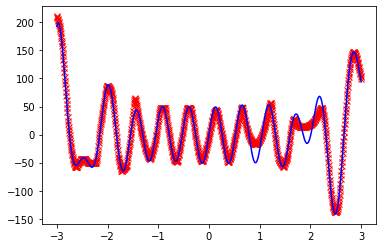

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.17486480532261914
